In [30]:
#list of imports
import pandas as pd
import matplotlib.pyplot as plt 
from langdetect import detect
from mtranslate import translate
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.sparse import hstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from nltk import pos_tag
from sklearn.model_selection import KFold
from itertools import combinations
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MultiLabelBinarizer



In [4]:
# nltk downloads
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\henry\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\henry\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\henry\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
#load in both datasets
training_data = pd.read_csv('mediaeval-2015-trainingset.txt',sep='\t')
test_data = pd.read_csv('mediaeval-2015-testset.txt',sep='\t')

In [5]:
#optional - import pre-translated training data for ease/ to avoid running translation code - email me if you want the pre-translated datasets for convenience
file_path = 'translated_data.csv'
training_data = pd.read_csv(file_path)
file_path2= 'translated_test_data.csv'
test_data = pd.read_csv(file_path2)

In [47]:
#information on training data
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14277 entries, 0 to 14276
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     14277 non-null  int64 
 1   tweetText   14277 non-null  object
 2   userId      14277 non-null  int64 
 3   imageId(s)  14277 non-null  object
 4   username    14277 non-null  object
 5   timestamp   14277 non-null  object
 6   label       14277 non-null  object
dtypes: int64(2), object(5)
memory usage: 780.9+ KB


In [48]:
#volume of tweets and features
training_data.shape

(14277, 7)

In [173]:
#check for null values in training data
missing_values = training_data.isnull().sum()
print(missing_values)

tweetId       0
tweetText     0
userId        0
imageId(s)    0
username      0
timestamp     0
label         0
dtype: int64


In [174]:
#more info on training data, specifically the text. including count, unique count, top tweet and its frequency
training_data['tweetText'].describe()

count                                                 14277
unique                                                12376
top       Unbelievable scene flying over #StatenIsland i...
freq                                                     42
Name: tweetText, dtype: object

In [170]:
#number of real, fake and humor tweets
label_counts = training_data['label'].value_counts()
print(label_counts)

label
fake    9356
real    4921
Name: count, dtype: int64


In [5]:
#map humour labels to fake for both datasets
training_data['label'] = training_data['label'].apply(lambda x: 'fake' if x == 'humor' else x)
test_data['label'] = test_data['label'].apply(lambda x: 'fake' if x == 'humor' else x)

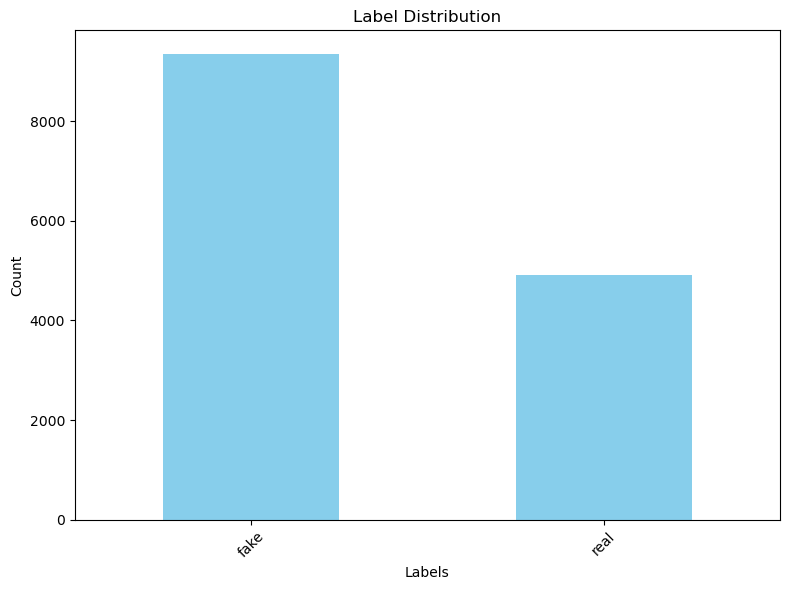

In [171]:
# label count of training data plotted as a bar chart (run before mapping humour to fake for 3 columns)
plt.figure(figsize=(8, 6)) 
label_counts.plot(kind='bar', color='skyblue')
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('label_distribution_plot2.pdf')
plt.show()

In [62]:
#count of real and fake tweets for test dataset(run before mapping humour to fake for 3 variable count)
label_counts_test = test_data['label'].value_counts()
print(label_counts_test)

label
fake    2546
real    1209
Name: count, dtype: int64


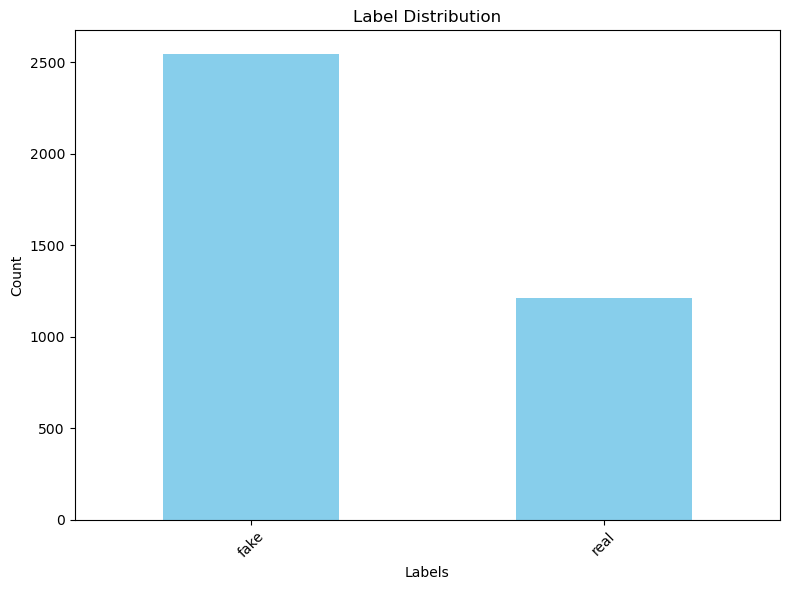

In [63]:
# label count of test data plotted as a bar chart
plt.figure(figsize=(8, 6)) 
label_counts_test.plot(kind='bar', color='skyblue')
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('label_distribution_plot3.pdf')
plt.show()

In [9]:
# detects the language of tweets - defaults to english
def detect_language_or_default(text):
    try:
        return detect(text)
    except:
        return 'en'

#apply function to both datasets
training_data['tweetLanguage'] = training_data['tweetText'].apply(detect_language_or_default)
test_data['tweetLanguage'] = test_data['tweetText'].apply(detect_language_or_default)

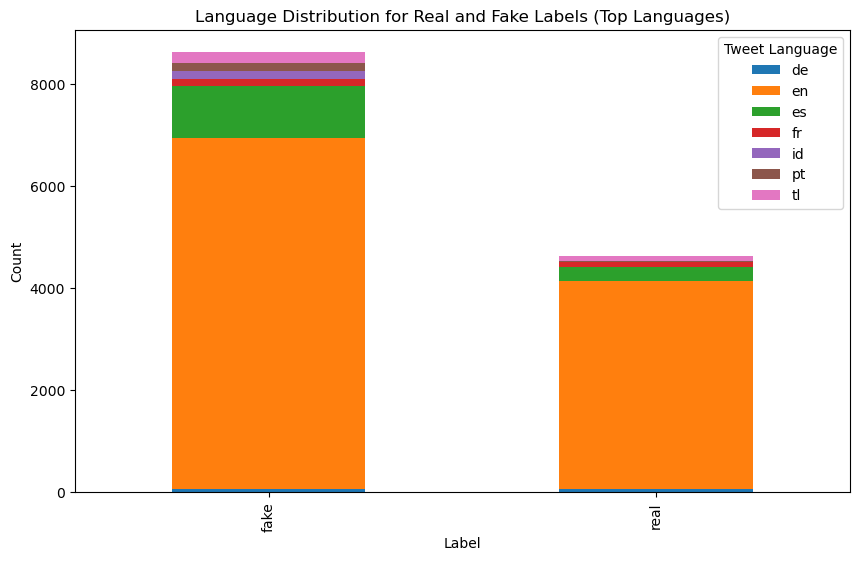

In [69]:
#find top languages for both the real and fake labels
top_languages_real = training_data[training_data['label'] == 'real']['tweetLanguage'].value_counts().head(5)
top_languages_fake = training_data[training_data['label'] == 'fake']['tweetLanguage'].value_counts().head(5)

#Find the languages these sets of languages have in common
common_languages = set(top_languages_real.index) | set(top_languages_fake.index)

#filter the training data for these common languages
filtered_data = training_data[training_data['tweetLanguage'].isin(common_languages)]
#Group the data by these languages and plot them on a bar graph
language_label_counts = filtered_data.groupby(['label', 'tweetLanguage']).size().unstack().fillna(0)
language_label_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Language Distribution for Real and Fake Labels (Top Languages)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.legend(title='Tweet Language')
plt.savefig('languages.pdf')
plt.show()


In [74]:
#function for translating the text into english
i=0
def translate_to_english(text):
    translated_text = translate(text, 'en')
    global i
    i+=1
    print(i, text, translated_text)
    return translated_text

In [16]:
#WARNING FOR EXAMINER!: this section of code can take a while to run
#Applying above function to tweet text of training data
training_data['tweetText_translated'] = training_data['tweetText'].apply(translate_to_english)


2 ¿Se acuerdan de la película: “El día después de mañana”? Me recuerda a lo que está pasando con el huracán #Sandy. http://t.co/JQQeRPwN Do you remember the movie: “The Day After Tomorrow”? It reminds me of what is happening with Hurricane #Sandy. http://t.co/JQQeRPwN
3 @milenagimon: Miren a Sandy en NY!  Tremenda imagen del huracán. Parece el "Día de la Independencia 2" http://t.co/41jUweux REAL! RT. @milenagimon: Look at Sandy in NY! Tremendous image of the hurricane. Looks like the REAL "Independence Day 2" http://t.co/41jUweux! RT.
4 Buena la foto del Huracán Sandy, me recuerda a la película Día de la Independencia #ID4 #Sandy  http://t.co/PTdAXABZ Good photo of Hurricane Sandy, it reminds me of the movie Independence Day #ID4 #Sandy http://t.co/PTdAXABZ
5 Scary shit #hurricane #NY http://t.co/e4JLBUfH Scary shit #hurricane #NY http://t.co/e4JLBUfH
6 My fave place in the world #nyc #hurricane #sandy #statueofliberty 🗽 http://t.co/Ex61doZk My fave place in the world #nyc #hurricane 

49 #hurricane #sandy #NY #newyork #america #usa #sky #tube #instago #instaboy #instahub #i#instagood #instagram http://t.co/MMqpZxE8 #hurricane #sandy #NY #newyork #america #usa #sky #tube #instago #instaboy #instahub #i#instagood #instagram http://t.co/MMqpZxE8
50 #NewYork #Crazy #Statue #Liberty #Hurricane #Today #Nature #2012 http://t.co/wi5DuGPH #NewYork #Crazy #Statue #Liberty #Hurricane #Today #Nature #2012 http://t.co/wi5DuGPH
51 😱 #shark #nyc #streets #sandy #hurricane http://t.co/NcudDwxJ 😱 #shark #nyc #streets #sandy #hurricane http://t.co/NcudDwxJ
52 A picture someone took of a shark swimming by their house when it got flooded 😱 \n#NewJersey #Hurricane #Sand http://t.co/OCXLWDFY A picture someone took of a shark swimming by their house when it got flooded 😱 \n#NewJersey #Hurricane #Sand http://t.co/OCXLWDFY
53 I hope the East Coast is doing well in those times. Thoughts are with y'all xo #hurricane #sandy #eastcoast http://t.co/9nKj08t8 I hope the East Coast is doing well in

96 #hurricane #sandy http://t.co/PtZwWQJQ #hurricane #sandy http://t.co/PtZwWQJQ
97 #sick #photo #sandy #hurricane #newyork #rain #wind #storm #omg #feest http://t.co/Shrp4KWQ #sick #photo #sandy #hurricane #newyork #rain #wind #storm #omg #feest http://t.co/Shrp4KWQ
98 😳🏃💨💨💨🌊sharks in jersey!! #hurricane #sandy http://t.co/4vQxYlsT 😳🏃💨💨💨🌊sharks in jersey!! #hurricane #sandy http://t.co/4vQxYlsT
99 #damn #hurricane #sandy http://t.co/PBXxmFw4 #damn #hurricane #sandy http://t.co/PBXxmFw4
100 In case u missed it. 😮😐😬 #reallife #NY #hurricane #sandy #2012 http://t.co/x3QvKfFG In case u missed it. 😮😐😬 #reallife #NY #hurricane #sandy #2012 http://t.co/x3QvKfFG
101 Independence what? #sandy #perfect #hurricane http://t.co/lq0nzPg5 Independence what? #sandy #perfect #hurricane http://t.co/lq0nzPg5
102 SHARK in NJ Subs.\n#hurricane #life #animal #instapic #instamood #photogram #photography #peta #shark http://t.co/K9NQ9mxM SHARK in NJ Subs.\n#hurricane #life #animal #instapic #instamood #photo

138 RT @thinkprogress #Sandy approaches #NYC  http://t.co/49joLNpG  (via @juneambrose) #hurricane RT @thinkprogress #Sandy approaches #NYC  http://t.co/49joLNpG  (via @juneambrose) #hurricane
139 #goodluck #eastcoast #storm #hurricane #sandy *what a bitch!* #bestwishes #praying for you #itagalot #love # http://t.co/HshlxXtN #goodluck #eastcoast #storm #hurricane #sandy *what a bitch!* #bestwishes #praying for you #itagalot #love # http://t.co/HshlxXtN
140 Zombie apocalypse approaches RT @thinkprogress: Sandy approaches NYC  http://t.co/xUvb0meo  (via @juneambrose) #Sandy #hurricane Zombie apocalypse approaches RT @thinkprogress: Sandy approaches NYC  http://t.co/xUvb0meo  (via @juneambrose) #Sandy #hurricane
141 No fucking way! that shit looks scary haha. #nyc #hurricane #sandy http://t.co/vsc6KPJA No fucking way! that shit looks scary haha. #nyc #hurricane #sandy http://t.co/vsc6KPJA
142 Shittt #2012 #Hurricane #Sandy #Storm http://t.co/xUS1xUvj Shittt #2012 #Hurricane #Sandy #Storm h

182 Hurricane Sandy! #freaky #pretty #hurricane #sandy #crazy #weather #NewYork #clouds http://t.co/kjKCokh3 Hurricane Sandy! #freaky #pretty #hurricane #sandy #crazy #weather #NewYork #clouds http://t.co/kjKCokh3
183 This is amazing. #hurricane #tomboftheunknownsoldier #dc #military #usa http://t.co/rmdDVb5T This is amazing. #hurricane #tomboftheunknownsoldier #dc #military #usa http://t.co/rmdDVb5T
184 ⚡⚡⚡ #sandy #hurricane #nyc #eastcoast #statueofliberty #NOW http://t.co/R5ChK2En ⚡⚡⚡ #sandy #hurricane #nyc #eastcoast #statueofliberty #NOW http://t.co/R5ChK2En
185 #today #nyc #hurricane #sandy #statue #of #liberty #rain #instapic #instabest #instacool #instashot #instada http://t.co/OKGjlzxA #today #nyc #hurricane #sandy #statue #of #liberty #rain #instapic #instabest #instacool #instashot #instada http://t.co/OKGjlzxA
186 Shits about to get real. Take cover and stay safe. #Hurricane #Sandy  http://t.co/NpQyqciD Shits about to get real. Take cover and stay safe. #Hurricane #Sandy  h

223 #hurricane #sandy #crazy #scary http://t.co/08SIcUiX #hurricane #sandy #crazy #scary http://t.co/08SIcUiX
224 Holy frankenstorm! #newyork #frankenstorm #hurricane #sandy #insane http://t.co/8KB1tba1 Holy frankenstorm! #newyork #frankenstorm #hurricane #sandy #insane http://t.co/8KB1tba1
225 Unbelievable photo as #Hurricane #Sandy sneaks up on the Statue of #Liberty in NYC #iwn http://t.co/zer6OwLo”” Unbelievable photo as #Hurricane #Sandy sneaks up on the Statue of #Liberty in NYC #iwn http://t.co/zer6OwLo””
226 Taken this morning at the Tomb...that's commitment. Staying strong through #Sandy. #Hurricane #RePost #Milit http://t.co/yCc2AEfe Taken this morning at the Tomb...that's commitment. Staying strong through #Sandy. #Hurricane #RePost #Milit http://t.co/yCc2AEfe
227 Nature can be so beautiful and interesting to look at but yet so deadly. #NewYork #Hurricane #Sandy 🙏 http://t.co/bhMmj4bF Nature can be so beautiful and interesting to look at but yet so deadly. #NewYork #Hurrican

268 RT @Nihal201: Amazing picture from the #NewYork Harbor of #Hurricane #Sandy. #nyc #storm #statueofliberty http://t.co/iHFEuSFo RT @Nihal201: Amazing picture from the #NewYork Harbor of #Hurricane #Sandy. #nyc #storm #statueofliberty http://t.co/iHFEuSFo
269 #hurricane #sandy shyt just hit ny http://t.co/JBABBpCO #hurricane #sandy shyt just hit ny http://t.co/JBABBpCO
270 #sandy #hurricane #newyork http://t.co/LQUlLXsV #sandy #hurricane #newyork http://t.co/LQUlLXsV
271 #wow #NY #hurricane #instagram http://t.co/azlEKTJr #wow #NY #hurricane #instagram http://t.co/azlEKTJr
272 #soldiers #tomb #unknownsoldier #hurricane #usa #onpost #military #october #2012 #service #duty #sovereignty http://t.co/q2tyGSz7 #soldiers #tomb #unknownsoldier #hurricane #usa #onpost #military #october #2012 #service #duty #sovereignty http://t.co/q2tyGSz7
273 NYC #scary #hurricane ⚡☔🌀🌊 http://t.co/cu275EB5 NYC #scary #hurricane ⚡☔🌀🌊 http://t.co/cu275EB5
274 #NYC #subway completely #flooded !!! #sandy #times

312 Stolen from @ericgipp there's a goddamn shark on the highway #Hurricane #Shandy #Crazy http://t.co/x9zhwuCu Stolen from @ericgipp there's a goddamn shark on the highway #Hurricane #Shandy #Crazy http://t.co/x9zhwuCu
313 #sandy #liberty #statue #storm #hurricane #repost http://t.co/8fD5uKRk #sandy #liberty #statue #storm #hurricane #repost http://t.co/8fD5uKRk
314 How amazing but how devastating it is going to be #hurricane #america #newyork #peaceful #nature #beautiful http://t.co/KjYlHg7c How amazing but how devastating it is going to be #hurricane #america #newyork #peaceful #nature #beautiful http://t.co/KjYlHg7c
315 Shark swimming in flooded areas near NJ home. #hellno #Sandy #Hurricane http://t.co/Hz1xc6y6 Shark swimming in flooded areas near NJ home. #hellno #Sandy #Hurricane http://t.co/Hz1xc6y6
316 Praying for my mom and uncle up north as they endure Hurricane Sandy!  #hurricane #sandy #eastcoast #storm # http://t.co/ogZ0F5ST Praying for my mom and uncle up north as they en

357 #Hurricane #Sandy http://t.co/NgJspZEZ #Hurricane #Sandy http://t.co/NgJspZEZ
358 https://t.co/MFTWc7Tk Wow... Wat heftig... Hoop dat mn familie daar ongedeerd blijft.. #hurricane #Sandy https://t.co/MFTWc7Tk Wow... How intense... Hope my family stays there unharmed.. #hurricane #Sandy
359 #Metaphor Symbol of Freedom devoured by #MotherNature and her Fury The Beauty of Nature #NY #Hurricane #Stat http://t.co/cQu21DkR #Metaphor Symbol of Freedom devoured by #MotherNature and her Fury The Beauty of Nature #NY #Hurricane #Stat http://t.co/cQu21DkR
360 I used to fear dogs off leashes in my neighborhood not sharks lol this is crazy #hurricane #sandy #flood #sh http://t.co/lLaWztXC I used to fear dogs off leashes in my neighborhood not sharks lol this is crazy #hurricane #sandy #flood #sh http://t.co/lLaWztXC
361 #Sandy wildin'... Sharks in the streets... No one is safe... #RNS #Hurricane #wave http://t.co/2QKzhF6f #Sandy wildin'... Sharks in the streets... No one is safe... #RNS #Hurric

400 #hurricane #sandy #amazing http://t.co/ymBfm4xc #hurricane #sandy #amazing http://t.co/ymBfm4xc
401 Cool storm pic. The power of Nature. #storm #hurricane #NYC http://t.co/g6cJvJ98 Cool storm pic. The power of Nature. #storm #hurricane #NYC http://t.co/g6cJvJ98
402 #instacollage #hurricane #sandy is starting too look like #independence #day http://t.co/oUcnkcF5 #instacollage #hurricane #sandy is starting too look like #independence #day http://t.co/oUcnkcF5
403 #shark seen swimming in a #NJ street. #hurricane #sandy http://t.co/i4RmgCWV #shark seen swimming in a #NJ street. #hurricane #sandy http://t.co/i4RmgCWV
404 #newyork #frankestorm #hurricane #nature #sky #amazing #usa #nyc http://t.co/rjceaPp1 #newyork #frankestorm #hurricane #nature #sky #amazing #usa #nyc http://t.co/rjceaPp1
405 Hello #Hurricane #Sandy #NY #Statue #Of #Liberty http://t.co/aMD75aeK Hello #Hurricane #Sandy #NY #Statue #Of #Liberty http://t.co/aMD75aeK
406 Love it when a shark passes me on the highway. #sand

447 Eerie look in Manhattan. #sandy #nyc #weather #hurricane #photooftheday #picoftheday #bestoftheday http://t.co/Zd1FVMi3 Eerie look in Manhattan. #sandy #nyc #weather #hurricane #photooftheday #picoftheday #bestoftheday http://t.co/Zd1FVMi3
448 Stunning, but scary picture. Good luck to everyone in #NewYork. #Hurricane #Sandy http://t.co/TUELBwIR Stunning, but scary picture. Good luck to everyone in #NewYork. #Hurricane #Sandy http://t.co/TUELBwIR
449 #PRAYforNEWyork #PRAYforNEWjersey #hurricane http://t.co/Qi1K0HHt #PRAYforNEWyork #PRAYforNEWjersey #hurricane http://t.co/Qi1K0HHt
450 Here comes #hurricane #sandy #NYC #newjersey #emergency #storm http://t.co/yMkye6WL Here comes #hurricane #sandy #NYC #newjersey #emergency #storm http://t.co/yMkye6WL
451 Such a horrible thing but yet so beautiful! #NewYork #Hurricane http://t.co/0zh3aL64 Such a horrible thing but yet so beautiful! #NewYork #Hurricane http://t.co/0zh3aL64
452 #Hurricane #Sandy #Praying @jamiechesson @pjchesson http://t

488 #SANDY: Tubarões são encontrados nas ruas de Nova Jersey após o avanço do mar causado pelo Furacão Sandy. #RenanLima &gt; http://t.co/o957maY7 #SANDY: Sharks are found in the streets of New Jersey after the advance of the sea caused by Hurricane Sandy. #RenanLima &gt; http://t.co/o957maY7
489 http://t.co/zdD0Sxlt this Sandy pic looks awesome but not sure if it's real. Stay safe everyone. http://t.co/zdD0Sxlt this Sandy pic looks awesome but not sure if it's real. Stay safe everyone.
490 New york is in trouble,sandy's heavy strike.16 passed http://t.co/QojLlLJc New york is in trouble,sandy's heavy strike.16 passed http://t.co/QojLlLJc
491 @mariliamorais 'Tubarões são encontrados nas ruas de Nova Jersey devido ao avanço do mar causado pelo Furacão Sandy. http://t.co/RfatIqsd  ' @mariliamorais 'Sharks are found on the streets of New Jersey due to the advance of the sea caused by Hurricane Sandy. http://t.co/RfatIqsd '
492 #PrayForUsa : Tubarões são encontrados nas ruas de Nova Jersey 

528 Holy cow that's hurricane sandy in New York! http://t.co/tHLfUgsl Holy cow that's hurricane sandy in New York! http://t.co/tHLfUgsl
529 Sandy in NY that's an incredible photo http://t.co/EuSScUzb Sandy in NY that's an incredible photo http://t.co/EuSScUzb
530 Tubarões são encontrados nas ruas de Nova Jersey devido ao avanço do mar causado pelo Furacão Sandy.Olha: http://t.co/UKu5pzxK aai gente :'( Sharks are found on the streets of New Jersey due to the advance of the sea caused by Hurricane Sandy. Look: http://t.co/UKu5pzxK hey guys :'(
531 Shark infested streets! Now that's real safe Sandy! #hurricanesandy #wtf #endoftheworld http://t.co/R9lVHRvX Shark infested streets! Now that's real safe Sandy! #hurricanesandy #wtf #endoftheworld http://t.co/R9lVHRvX
532 Let me tell ALL of you how real Sandy woulda been for me.... That's a shark... In a neighborhood!!! Smh. You http://t.co/TfnT8z7i Let me tell ALL of you how real Sandy woulda been for me.... That's a shark... In a neighborhood

567 Sandy ain't nothing for our troops. Picture from today at the Tomb of the Unknown Soldier in DC. http://t.co/8CtCiSp6 Sandy ain't nothing for our troops. Picture from today at the Tomb of the Unknown Soldier in DC. http://t.co/8CtCiSp6
568 Amazing soldiers standing at the Tomb of the Unknown Soldier during hurricane Sandy. http://t.co/T5hSfF43 Amazing soldiers standing at the Tomb of the Unknown Soldier during hurricane Sandy. http://t.co/T5hSfF43
569 “@ahmednaguib: The Tomb of the Unknown Soldier remains guarded during Hurricane #Sandy. http://t.co/jmJUIX2v Wowee. “@ahmednaguib: The Tomb of the Unknown Soldier remains guarded during Hurricane #Sandy. http://t.co/jmJUIX2v Wowee.
570 http://t.co/iujv78Ed honor guard at the tomb of the unknown soldier amidst hurricane sandy http://t.co/iujv78Ed honor guard at the tomb of the unknown soldier amidst hurricane sandy
571 US Army Honor Guard standing watch at Tomb of Unknown Soldier during Hurricane Sandy. We are all unworthy. http://t.co

589 Tomb of the Unknown Soldier during Hurricane Sandy. http://t.co/HipIXpia Tomb of the Unknown Soldier during Hurricane Sandy. http://t.co/HipIXpia
590 This Is America. Tomb of the Unknown Soldier during Sandy. #muchrespect http://t.co/O2KhLTTi This Is America. Tomb of the Unknown Soldier during Sandy. #muchrespect http://t.co/O2KhLTTi
591 tomb of the unknown soldier during hurricane sandy. say a prayer for the east coast and for the men and wome http://t.co/9osq6Scl tomb of the unknown soldier during hurricane sandy. say a prayer for the east coast and for the men and wome http://t.co/9osq6Scl
592 Even with hurricane sandy these men will remain at their post guarding the tomb of the unknown soldier their http://t.co/DNbPs9VO Even with hurricane sandy these men will remain at their post guarding the tomb of the unknown soldier their http://t.co/DNbPs9VO
593 Hurricane Sandy makin everyone evacuate.... everyone but those who guard the tomb of the unknown soldier... http://t.co/915tV1Jd

624 This is as American as it gets. Soldiers gaurding the Tomb of the Unknown Soldier during Hurricane Sandy. #U http://t.co/HW17gJ5z This is as American as it gets. Soldiers gaurding the Tomb of the Unknown Soldier during Hurricane Sandy. #U http://t.co/HW17gJ5z
625 In the face of #Sandy , soldiers at Tomb of the Unknown Soldier in D.C. stood their post, saying "Sandy, Come get some" http://t.co/6C38BqYE In the face of #Sandy , soldiers at Tomb of the Unknown Soldier in D.C. stood their post, saying "Sandy, Come get some" http://t.co/6C38BqYE
626 Hurricane Sandy? Looks like the end of the world to me! http://t.co/LIgTh7G0 Hurricane Sandy? Looks like the end of the world to me! http://t.co/LIgTh7G0
627 Guards will stay at the tomb of the unknown soldier will stay there 24/7 even during hurricane sandy  http://t.co/clBOZktr Guards will stay at the tomb of the unknown soldier will stay there 24/7 even during hurricane sandy  http://t.co/clBOZktr
628 Tomb of the Unknown Soldier during Hur

661 Amazing soldiers standing at the Tomb of the Unknown Soldier during hurricane Sandy. http://t.co/mk2izkOV” Awesome Amazing soldiers standing at the Tomb of the Unknown Soldier during hurricane Sandy. http://t.co/mk2izkOV” Awesome
662 Hurricane Sandy will not stop these soldiers from their duties!!\nTomb of the unknown soldiers. http://t.co/gFtlgvs1 Hurricane Sandy will not stop these soldiers from their duties!!\nTomb of the unknown soldiers. http://t.co/gFtlgvs1
663 Amazing soldiers standing at the Tomb of the Unknown Soldier during hurricane Sandy. #salute bc I couldn't d http://t.co/0PiDXZ5M Amazing soldiers standing at the Tomb of the Unknown Soldier during hurricane Sandy. #salute bc I couldn't d http://t.co/0PiDXZ5M
664 Tomb of the Unknown Soldier continues to stay guarded throughout Hurricane Sandy. And they are using bayonets. I http://t.co/sTRdzyJl Tomb of the Unknown Soldier continues to stay guarded throughout Hurricane Sandy. And they are using bayonets. I http://t.co/s

696 Yesterday morning at the Tomb of the Unknown Soldier!!! #Sandy http://t.co/wN5ANI18 Yesterday morning at the Tomb of the Unknown Soldier!!! #Sandy http://t.co/wN5ANI18
697 True dedication .... Soldiers at Tomb of the Unknown during hurricane Sandy...(photo credit: 1st army divisi http://t.co/tGA3HweW True dedication .... Soldiers at Tomb of the Unknown during hurricane Sandy...(photo credit: 1st army divisi http://t.co/tGA3HweW
698 These troops are on guard at the Tomb of the Unknown Solider 24/7 including during Hurricane Sandy #salute # http://t.co/J5sQgHw5 These troops are on guard at the Tomb of the Unknown Solider 24/7 including during Hurricane Sandy #salute # http://t.co/J5sQgHw5
699 Amazing RT @DerekLuxe: Still guarding the Tomb of the Unknown Soldier in the midst of Hurricane #Sandy #Frankenstorm http://t.co/D366en1Z Amazing RT @DerekLuxe: Still guarding the Tomb of the Unknown Soldier in the midst of Hurricane #Sandy #Frankenstorm http://t.co/D366en1Z
700 Even during Hurr

731 Tomb of the Unknown during Hurricane Sandy...proud to be an American. http://t.co/hSCC7lMl Tomb of the Unknown during Hurricane Sandy...proud to be an American. http://t.co/hSCC7lMl
732 True guards! Still patrolling the tomb of an unknown soldier through Hurricane Sandy! #madrespect http://t.co/8b0exWLf True guards! Still patrolling the tomb of an unknown soldier through Hurricane Sandy! #madrespect http://t.co/8b0exWLf
733 “Absolutely incredible.Tomb of the Unknown Soldier stays guarded throughout Hurricane Sandy. http://t.co/vcDx0evN” #endlessretweets #respect “Absolutely incredible.Tomb of the Unknown Soldier stays guarded throughout Hurricane Sandy. http://t.co/vcDx0evN” #endlessretweets #respect
734 #repost Tomb of the unknown soldier during hurricane sandy. Crazy respect http://t.co/VuPqGWJI #repost Tomb of the unknown soldier during hurricane sandy. Crazy respect http://t.co/VuPqGWJI
735 Tomb of the Unknown Soldier continues to stay guarded throughout Hurricane Sandy. http:/

771 I went here a while ago. Learned stuff here. #Repost #GodBless #Sandy #DC http://t.co/P9Na3MYY I went here a while ago. Learned stuff here. #Repost #GodBless #Sandy #DC http://t.co/P9Na3MYY
772 EVEN MORE SHARKS!!! #Sandy http://t.co/wvmZZC1m EVEN MORE SHARKS!!! #Sandy http://t.co/wvmZZC1m
773 #sandy #usa http://t.co/IBbxxUgG #sandy #usa http://t.co/IBbxxUgG
774 “@AlwaysPrayin “@J7mster the hurricane is real #Sandy http://t.co/4ngdhYIq”” “@AlwaysPrayin “@J7mster the hurricane is real #Sandy http://t.co/4ngdhYIq””
775 Aê @CarlosPort acho q jantaram a repórter loirinha da CNN mesmo #Sandy ==&gt;Tubarões em ruas de Nova Jersey http://t.co/lRpnkKq3 via @TwitPic Hey @CarlosPort I think the blonde CNN reporter had dinner #Sandy ==&gt;Sharks on the streets of New Jersey http://t.co/lRpnkKq3 via @TwitPic
776 la foto de alberto_rubio http://t.co/C1cM63Tw recreación de #Sandy the photo of alberto_rubio http://t.co/C1cM63Tw recreation of #Sandy
777 #sandy I see you coming http://t.co/CVa25qcR 

829 That dont look right....... #sandy http://t.co/EJ1dAWfM That dont look right....... #sandy http://t.co/EJ1dAWfM
830 Oh no!!!! #sandy http://t.co/t2EFho40 Oh no!!!! #sandy http://t.co/t2EFho40
831 😳 #sandy http://t.co/ZkoyD45W 😳 #sandy http://t.co/ZkoyD45W
832 #sandy http://t.co/gM1QaQFx #sandy http://t.co/gM1QaQFx
833 #Sandy - Dans le New Jersey, un petit requin emporté par les inondations nage tranquillement devant les maisons. http://t.co/yhJKx19O #Sandy - In New Jersey, a small shark swept away by floods swims peacefully in front of houses. http://t.co/yhJKx19O
834 The power of #photoshop #nyc #sandy #storm #newyork http://t.co/wZIHJFK2 The power of #photoshop #nyc #sandy #storm #newyork http://t.co/wZIHJFK2
835 #sandy #NYC http://t.co/t6aoGAJF #sandy #NYC http://t.co/t6aoGAJF
836 HOLY SHIT #Sandy #Liberty  http://t.co/TAYN8xcK HOLY SHIT #Sandy #Liberty  http://t.co/TAYN8xcK
837 Stay strong my people in the East Coast!! Thoughts are with you! \n#USA #Newyork #sandy #storm #rain 

885 Акулы на улицах после Сэнди #sandy http://t.co/gvC6doki Sharks on the streets after Sandy #sandy http://t.co/gvC6doki
886 Casual shark swimming passed a car :/ #Sandy http://t.co/6qdtksRb" Casual shark swimming passed a car :/ #Sandy http://t.co/6qdtksRb"
887 Ca-ray-zee picture of the #statueofliberty as #sandy approaches #nyc http://t.co/aNvno2EX Ca-ray-zee picture of the #statueofliberty as #sandy approaches #nyc http://t.co/aNvno2EX
888 #NYC #Sandy  http://t.co/EN3Eot1j #NYC #Sandy  http://t.co/EN3Eot1j
889 #sandy http://t.co/gDuGWGTJ #sandy http://t.co/gDuGWGTJ
890 #Sandy https://t.co/J8s1yU8C #Sandy https://t.co/J8s1yU8C
891 What an apocalyptic photograph of #Sandy approaching #NewYork http://t.co/gfayVenE” via @lopezperiodista What an apocalyptic photograph of #Sandy approaching #NewYork http://t.co/gfayVenE” via @lopezperiodista
892 #Newyork #Storm #Sandy ,, OMG... http://t.co/qKSSlwa2 #Newyork #Storm #Sandy ,, OMG... http://t.co/qKSSlwa2
893 What the shark !!!! #shark #sand

940 http://t.co/uaBX1jhd #Sandy http://t.co/uaBX1jhd #Sandy
941 This looks like a movie!Wtf?!  http://t.co/oiQyxPpd” #Sandy :( This looks like a movie!Wtf?!  http://t.co/oiQyxPpd” #Sandy :(
942 Акулы на улицах после Сэнди #sandy http://t.co/6SLCsV7i Sharks on the streets after Sandy #sandy http://t.co/6SLCsV7i
943 #sandy #newyork http://t.co/v3EVgiDZ #sandy #newyork http://t.co/v3EVgiDZ
944 It just got real  '#Sandy http://t.co/aeuR3nTe It just got real  '#Sandy http://t.co/aeuR3nTe
945 “@DesignGears “@Slate004 Holy shit #Sandy http://t.co/0IVuCcrw”” “@DesignGears “@Slate004 Holy shit #Sandy http://t.co/0IVuCcrw””
946 RT #SANDY: Tubarões são encontrados nas ruas de Nova Jersey devido ao avanço do mar causado pelo Furacão Olha:  http://t.co/jk4pmiUm RT #SANDY: Sharks are found on the streets of New Jersey due to the advance of the sea caused by Hurricane Look: http://t.co/jk4pmiUm
947 Manhattan a oscuras #Sandy 🌀🇺🇸 http://t.co/8OLUlmvn Manhattan a oscuras #Sandy 🌀🇺🇸 http://t.co/8OLUlmvn

994 http://t.co/WDXNT1fW Uauuuuu a soak in the subway station timesquare #Sandy #speechless http://t.co/WDXNT1fW Uauuuuu a soak in the subway station timesquare #Sandy #speechless
995 #SANDY ta chegando!  Mas esse é um show q ninguém quer ver! http://t.co/LF7Adgdt #SANDY is coming! But this is a show that no one wants to see! http://t.co/LF7Adgdt
996 #repost #sandy http://t.co/THbZzMkT #repost #sandy http://t.co/THbZzMkT
997 Stay dry and safe guys. Your in our prayers from #k3projektwheels #nyc #newyork #sandy http://t.co/zQOE1ao7 Stay dry and safe guys. Your in our prayers from #k3projektwheels #nyc #newyork #sandy http://t.co/zQOE1ao7
998 #sandy #newyork http://t.co/v3EVgiDZ #sandy #newyork http://t.co/v3EVgiDZ
999 Niggas in NY be like: #cloudporn #clouds #bitchesloveclouds #sandy http://t.co/BFr9mCsy Niggas in NY be like: #cloudporn #clouds #bitchesloveclouds #sandy http://t.co/BFr9mCsy
1000 Cápa New Jerseyben.. beszarás http://t.co/zUUoXxnC #Sandy Shark in New Jersey.. screw up htt

1045 J'ai trop peur mattez la vuede ma chambre !! #sandy #nyc #jevaismourrir ..non je deconne, ma vie n'es pas so http://t.co/j3tDwb8p I'm too scared to look at the view from my room!! #sandy #nyc #I'm going to die ..no I'm kidding, my life is not so http://t.co/j3tDwb8p
1046 Thanks heaps Sandy! Now I can't watch the latest ep of Gossip Girl!  #firstworldproblems #sandy #storm #nyc http://t.co/gOHoGKWz Thanks heaps Sandy! Now I can't watch the latest ep of Gossip Girl!  #firstworldproblems #sandy #storm #nyc http://t.co/gOHoGKWz
1047 Акулы на улицах после Сэнди #sandy http://t.co/6SLCsV7i Sharks on the streets after Sandy #sandy http://t.co/6SLCsV7i
1048 #new #york #sandy #crazy #instascary #follow http://t.co/xOTvh7rl #new #york #sandy #crazy #instascary #follow http://t.co/xOTvh7rl
1049 RT @FelCassan: Incroyable image de New York ! RT @thinkprogress: #Sandy approaches NYC http://t.co/K3EVsYxM RT @FelCassan: Incroyable image de New York ! RT @thinkprogress: #Sandy approaches NYC http:

1096 @PardonMyPoppet: psimadethis's crazy #sandy photo. Times Square Subway Stop http://t.co/67mWdqyc not sure if photoshopped, but interesting @PardonMyPoppet: psimadethis's crazy #sandy photo. Times Square Subway Stop http://t.co/67mWdqyc not sure if photoshopped, but interesting
1097 Tuburon http://t.co/duLH1Gv5 #Sandy Tuburon http://t.co/duLH1Gv5 #Sandy
1098 Ieri, l'uragano #Sandy alle porte di #Manhattan. #NewYork http://t.co/vxVu7Qi2 Yesterday, Hurricane #Sandy near #Manhattan. #NewYork http://t.co/vxVu7Qi2
1099 Statue of Liberty + crushing waves. http://t.co/7F93HuHV #hurricaneparty #sandy Statue of Liberty + crushing waves. http://t.co/7F93HuHV #hurricaneparty #sandy
1100 Stay up Lady Liberty...shot look like something off of a movie.. Wooii #Sandy wan cum mash up di place #hurr http://t.co/o21rHTLo Stay up Lady Liberty...shot look like something off of a movie.. Wooii #Sandy wan cum mash up di place #hurr http://t.co/o21rHTLo
1101 #Sandy fuckin shit up. Got a shark swimming in

1149 #Sandy come Attila. In #Grease non era così. http://t.co/VJM3OWjD #Sandy as Attila. In #Grease it wasn't like that. http://t.co/VJM3OWjD
1150 Digam olá para #Sandy #NY http://t.co/fKrQtkwZ Say hello to #Sandy #NY http://t.co/fKrQtkwZ
1151 There's a Shark in Brigantine #sandy #controlyourpets http://t.co/ll4cIIMm There's a Shark in Brigantine #sandy #controlyourpets http://t.co/ll4cIIMm
1152 RT @diValenciaGLAM: #nyc #Sandy #scary #nature http://t.co/Dj9Um8D3 RT @diValenciaGLAM: #nyc #Sandy #scary #nature http://t.co/Dj9Um8D3
1153 Scary huh? #sandy @ New York City http://t.co/EUJMragN Scary huh? #sandy @ New York City http://t.co/EUJMragN
1154 US nak sangat jadi mcm movie 2012, kan dah kena betul2 Hurricane #Sandy http://t.co/ijxSs144 The US really wants to be like the 2012 movie, right? Hurricane #Sandy has to be done right http://t.co/ijxSs144
1155 #sandy http://t.co/ftOTlWbK #sandy http://t.co/ftOTlWbK
1156 “@jshan711 Fucking sharks on the streets!! #Sandy http://t.co/usaazxVB” C

1206 WOW! RT @Amalgam5: Lady Liberty standing strong against #Sandy. http://t.co/OdnKD7F7 WOW! RT @Amalgam5: Lady Liberty standing strong against #Sandy. http://t.co/OdnKD7F7
1207 my gawd. #ny #sandy #prayforamericans http://t.co/am8EsIlb my gawd. #ny #sandy #prayforamericans http://t.co/am8EsIlb
1208 Good photo of #Sandy #nyc http://t.co/W4x0iT7V Good photo of #Sandy #nyc http://t.co/W4x0iT7V
1209 I think that was im puerto ricoRT @StefanoDStasio: Tiburones en calles de #NYC #sandy @sergiocarlo http://t.co/lKwvzNE0 I think that was im Puerto RicoRT @StefanoDStasio: Sharks in the streets of #NYC #sandy @sergiocarlo http://t.co/lKwvzNE0
1210 Well damn #Sandy http://t.co/GAs0Uhry Well damn #Sandy http://t.co/GAs0Uhry
1211 #Sandy #NewYork #NYC #storm #USA #android #kik http://t.co/tfDAzxb0 #Sandy #NewYork #NYC #storm #USA #android #kik http://t.co/tfDAzxb0
1212 Sharks on my street...? #wut #sandy #lblock  photo: mcfarty http://t.co/t98ypUMY Sharks on my street...? #wut #sandy #lblock  pho

1259 A shark swimming in Brigantine, NJ. WTF. http://t.co/PzlMBaoa #Sandy A shark swimming in Brigantine, NJ. WTF. http://t.co/PzlMBaoa #Sandy
1260 #sandy http://t.co/zG151jA8 #sandy http://t.co/zG151jA8
1261 #Pray #Sandy http://t.co/tRbXiSby #Pray #Sandy http://t.co/tRbXiSby
1262 #goodluck #newyork #sandy http://t.co/ySG5811t #goodluck #newyork #sandy http://t.co/ySG5811t
1263 RT @FelCassan: Incroyable image de New York ! RT @thinkprogress: #Sandy approaches NYC http://t.co/K3EVsYxM RT @FelCassan: Incroyable image de New York ! RT @thinkprogress: #Sandy approaches NYC http://t.co/K3EVsYxM
1264 Shark swimming in NYC #Sandy #wut http://t.co/C5KnULBU Shark swimming in NYC #Sandy #wut http://t.co/C5KnULBU
1265 I always wanted a shar as pet. #Sandy #Scary #Haloween #Storm #Pet #Shark #NewYork http://t.co/xUjVMB0L I always wanted a shar as pet. #Sandy #Scary #Haloween #Storm #Pet #Shark #NewYork http://t.co/xUjVMB0L
1266 #Sandy #NYC 😳☁⚡☔ http://t.co/bSJhN28C #Sandy #NYC 😳☁⚡☔ http://t.co/bSJ

1313 #Sandy in New York ! http://t.co/jxSYuCzt #Sandy in New York ! http://t.co/jxSYuCzt
1314 sameer_97's photo http://t.co/IxuZ47mf #sandy sameer_97's photo http://t.co/IxuZ47mf #sandy
1315 Shark next to a house crazy. #sandy http://t.co/YLTkaJSz Shark next to a house crazy. #sandy http://t.co/YLTkaJSz
1316 Oh my goodness... Be safe New Yorkers! #sandy #staysafe http://t.co/SZ5lOfGp Oh my goodness... Be safe New Yorkers! #sandy #staysafe http://t.co/SZ5lOfGp
1317 RT @LuisEduF1: RT @StefanoDStasio Tiburones en calles de #NYC #sandy @sergiocarlo http://t.co/PXYOQpc9 RT @LuisEduF1: RT @StefanoDStasio Sharks in the streets of #NYC #sandy @sergiocarlo http://t.co/PXYOQpc9
1318 Damn! A Shark in Da Streetz of NJ?? #Sandy http://t.co/3s89vnMw Damn! A Shark in Da Streetz of NJ?? #Sandy http://t.co/3s89vnMw
1319 “@innokratka #NYC #Sandy  http://t.co/Rc9Ol60V” “@innokratka #NYC #Sandy  http://t.co/Rc9Ol60V”
1320 Someone photographed a shark on the road in NYC because of #Sandy! http://t.co/Uh7AQ

1367 “@mtnbke: Shark! @anthonydalicandro's photo http://t.co/yj6a4OLD #sandy” HOLY MARY MOTHER OF JESUS! “@mtnbke: Shark! @anthonydalicandro's photo http://t.co/yj6a4OLD #sandy” HOLY MARY MOTHER OF JESUS!
1368 Another breathtaking #shot from an anonymous #photographer of the coming hurricane #sandy in #nyc #pray for http://t.co/Ky51JArq Another breathtaking #shot from an anonymous #photographer of the coming hurricane #sandy in #nyc #pray for http://t.co/Ky51JArq
1369 #Sandy #NewYork http://t.co/lfRTZYaC #Sandy #NewYork http://t.co/lfRTZYaC
1370 That is a shark in a front yard y'all.......... 😳🎣🐋🚣 #sandy http://t.co/KMvhAIgp That is a shark in a front yard y'all.......... 😳🎣🐋🚣 #sandy http://t.co/KMvhAIgp
1371 #Sandy #NYC الله الحافظ http://t.co/M4e22bvB #Sandy #NYC God is the Protector http://t.co/M4e22bvB
1372 Its no joke when u see a shark in your front yard #sandy http://t.co/KbQXByF3 Its no joke when u see a shark in your front yard #sandy http://t.co/KbQXByF3
1373 sharks on the hi

1422 holy shit!!! #NYC #sandy #statueofliberty http://t.co/lIJTtFhy holy shit!!! #NYC #sandy #statueofliberty http://t.co/lIJTtFhy
1423 #Sandy and the shark http://t.co/GhgFe4y8 #Sandy and the shark http://t.co/GhgFe4y8
1424 @jessmartinnn https://t.co/Ra1PXjv1 #Sandy @jessmartinnn https://t.co/Ra1PXjv1 #Sandy
1425 We are so lucky right now. Be thankful. #Sandy http://t.co/QtqrVi1G We are so lucky right now. Be thankful. #Sandy http://t.co/QtqrVi1G
1426 berlie0415's photo http://t.co/toEloaGz Real or movie? #sandy #seriousquestion berlie0415's photo http://t.co/toEloaGz Real or movie? #sandy #seriousquestion
1427 Storm's coming. Hurricane #sandy. http://t.co/O54ao2BK Storm's coming. Hurricane #sandy. http://t.co/O54ao2BK
1428 ❤NY! В городе моей мечты сейчас совсем грустно... 🗽☔☁💨🌊 #NewYork #Sandy http://t.co/TGaHXwS0 ❤NY! The city of my dreams is very sad right now... 🗽☔☁💨🌊 #NewYork #Sandy http://t.co/TGaHXwS0
1429 This poor shark took the wrong turn somewhere in NJ #storm #sandy #probl

1476 Nature - powerful, yet beautiful. Stay safe, east coast. #nyc #sandy http://t.co/X25tfa2S Nature - powerful, yet beautiful. Stay safe, east coast. #nyc #sandy http://t.co/X25tfa2S
1477 New York visitada por el huracán #sandy 2012 http://t.co/SMyZLjRi @/PastorMarioR โอ้ววววว New York visit last month #sandy 2012 http://t.co/SMyZLjRi @/PastorMarioR Oh wow.
1478 #Sandy #NYC 😳☁⚡☔ http://t.co/bSJhN28C #Sandy #NYC 😳☁⚡☔ http://t.co/bSJhN28C
1479 I'm really glad I brought that @Cynthia_Rowley neoprene dress last season. #UnderwaterSubway #Sandy http://t.co/w6Zspodh I'm really glad I brought that @Cynthia_Rowley neoprene dress last season. #UnderwaterSubway #Sandy http://t.co/w6Zspodh
1480 De por dios new york en peligro @sonnyflow #sandy #tormentasandy #newyork #nyc #sonnyvision http://t.co/Mp4Zmk63 For God's sake new york in danger @sonnyflow #sandy #stormsandy #newyork #nyc #sonnyvision http://t.co/Mp4Zmk63
1481 http://t.co/wq8shync Pray for NYC. #pray #NYC #Sandy http://t.co/wq8shync P

1532 #Sandy #Rahhh http://t.co/XiAYjuX1 #Sandy #Rahhh http://t.co/XiAYjuX1
1533 Praying the the East Coast and all my friends who are in  the path of this storm. #nyc #sandy http://t.co/pxnhEtlR Praying the the East Coast and all my friends who are in  the path of this storm. #nyc #sandy http://t.co/pxnhEtlR
1534 #quit #smoking #angry #sandy יום רביעי בלי סיגריות. מתחילים להרגיש את התוצאות מעבר לים @ ייסורי ורתר הצעיר http://t.co/rEtfhSGB #quit #smoking #angry #sandy Wednesday without cigarettes. Starting to feel the results overseas @ Yassuri Werther the young http://t.co/rEtfhSGB
1535 Sembla una peli de por!! #Sandy #newyork #mamapor http://t.co/K97Tzi06 It seems like a movie by the way!! #Sandy #newyork #mamapor http://t.co/K97Tzi06
1536 Нью-Йорк #Sandy\n\njrlara512's photo http://t.co/h5jclEwH New York #Sandy\n\njrlara512's photo http://t.co/h5jclEwH
1537 Esta foto de #Sandy sobre Manhattan me dejó :O http://t.co/brlZ5RFz This photo of #Sandy over Manhattan left me :O http://t.co/b

1585 Better pic of porch fishing for sharks. #sandy http://t.co/FpZUi6cg Better pic of porch fishing for sharks. #sandy http://t.co/FpZUi6cg
1586 #NewYork #sandy http://t.co/sWD7B0Cd #NewYork #sandy http://t.co/sWD7B0Cd
1587 Waoooo! #sandy #storm #newyork ☔ http://t.co/LggcPCGJ Waoooo! #sandy #storm #newyork ☔ http://t.co/LggcPCGJ
1588 Shark in NJ storm surge http://t.co/n2JiVD4K. #Sandy #newjersey Shark in NJ storm surge http://t.co/n2JiVD4K. #Sandy #newjersey
1589 impressionant l'huracà #Sandy\nhttps://t.co/Jj5jVEqL impressive hurricane #Sandy\nhttps://t.co/Jj5jVEqL
1590 #sandy http://t.co/Uj2ojCJl #sandy http://t.co/Uj2ojCJl
1591 #sandy #newyork #freedomstatue #archilovers #archiportale http://t.co/ar48eWAU #sandy #newyork #freedomstatue #archilovers #archiportale http://t.co/ar48eWAU
1592 #Sandy  #USA  # McDonalds http://t.co/CP78xhIy #Sandy  #USA  # McDonalds http://t.co/CP78xhIy
1593 Waiting for #Sandy to make landfall. Three hours to go ! 😧😯😕 @ New York City http://t.co/jaX96kcY

1644 New York visitada por el huracán #sandy 2012 http://t.co/6g6HbgJV New York visited by hurricane #sandy 2012 http://t.co/6g6HbgJV
1645 There's a huge storm, these guys are still standing watch. #sandy #inspiration #tomboftheunknownsoldier #ame http://t.co/oARRCsGa There's a huge storm, these guys are still standing watch. #sandy #inspiration #tomboftheunknownsoldier #ame http://t.co/oARRCsGa
1646 Акулы на улицах после Сэнди #sandy http://t.co/gvC6doki Sharks on the streets after Sandy #sandy http://t.co/gvC6doki
1647 Awesome but scary #sandy http://t.co/B6XWWCaD Awesome but scary #sandy http://t.co/B6XWWCaD
1648 #NY #newyork #new #york #usa #america #statue #of #liberty #sandy #wind #unitedstates #united #states http://t.co/rmCYb1VJ #NY #newyork #new #york #usa #america #statue #of #liberty #sandy #wind #unitedstates #united #states http://t.co/rmCYb1VJ
1649 New York... my thoughts and prayers go out to everyone on the east coast. #nofilter #sandy http://t.co/Kfb9Om8E New York... m

1701 A shark in the street in NJ. #sandy http://t.co/3ebVIyG4 A shark in the street in NJ. #sandy http://t.co/3ebVIyG4
1702 죽음의 그늘, 뉴욕.\n #Sandy http://t.co/xZut20MF Shadow of Death, New York.\n #Sandy http://t.co/xZut20MF
1703 Shittttt #sandy #statue #of #liberty http://t.co/ONP84V5z Shittttt #sandy #statue #of #liberty http://t.co/ONP84V5z
1704 increible el huracan #sandy #NY http://t.co/yjzCwGNz increible el huracan #sandy #NY http://t.co/yjzCwGNz
1705 Je sais pas vous, mais même après #Sandy, Times square est magique .. http://t.co/wnljDpGu I don't know about you, but even after #Sandy, Times Square is magical.. http://t.co/wnljDpGu
1706 A storm is coming Mr. Wayne.. #Sandy http://t.co/Nj0jxVq5 A storm is coming Mr. Wayne.. #Sandy http://t.co/Nj0jxVq5
1707 @EmisorasUnidas la marea se desbordo tanto q tenemos tiburones #sandy http://t.co/YLwCeJoY @EmisorasUnidas the tide overflowed so much that we have sharks #sandy http://t.co/YLwCeJoY
1708 #sandy #sandydc http://t.co/NXssSq51 #san

1753 Amazing Picture!!! - Earlier today!! :-O #sandy http://t.co/S8Wr14Za Amazing Picture!!! - Earlier today!! :-O #sandy http://t.co/S8Wr14Za
1754 Shark on the road! #Unreal #Sandy http://t.co/QMh9Jx4z Shark on the road! #Unreal #Sandy http://t.co/QMh9Jx4z
1755 #sharksinthestreet #reallife #lbi #sandy http://t.co/MnPLRtkw #sharksinthestreet #reallife #lbi #sandy http://t.co/MnPLRtkw
1756 Sharks are swimming through the neighborhood because of #Sandy http://t.co/RMTFfIy2 Sharks are swimming through the neighborhood because of #Sandy http://t.co/RMTFfIy2
1757 Sharks swim freely at #NYC streets! #Sandy  http://t.co/fyuw0gaI Sharks swim freely at #NYC streets! #Sandy  http://t.co/fyuw0gaI
1758 #Sandy esta tarde sobre NYC. https://t.co/mGdNVgOZ … #Sandy this afternoon over NYC. https://t.co/mGdNVgOZ …
1759 It's getting real out there. Stay safe everyone, including Lady Liberty! #Sandy http://t.co/HZhVm28I It's getting real out there. Stay safe everyone, including Lady Liberty! #Sandy http:

1801 CRAZY!!!  Shark in the street in #Brigantine, New Jersey... #HurricaneSandy http://t.co/pt6hdY3N #SandyinPhilly CRAZY!!!  Shark in the street in #Brigantine, New Jersey... #HurricaneSandy http://t.co/pt6hdY3N #SandyinPhilly
1802 ! RT @haymakers: "@DaKreek: a shark swimmin in the front yard of a flooded home in New Jersey pic: http://t.co/lPxF9UEA" // Amazing. #sandy ! RT @haymakers: "@DaKreek: a shark swimmin in the front yard of a flooded home in New Jersey pic: http://t.co/lPxF9UEA" // Amazing. #sandy
1803 BREAKING: Sharks are found in the streets of New Jersey due to the advance of the sea caused by Hurricane #Sandy &gt;&gt; http://t.co/LtKzCsSJ BREAKING: Sharks are found in the streets of New Jersey due to the advance of the sea caused by Hurricane #Sandy &gt;&gt; http://t.co/LtKzCsSJ
1804 “@BriiLeigh4: Sharks in the streets of New York and New Jersey because of hurricane Sandy #unreal http://t.co/K6RKKXju” THAT'S SWEET! “@BriiLeigh4: Sharks in the streets of New York and New 

1806 «@lilduval 😳 RT @t_locc_BAU: @lilduval  shark swimming in the streets of Brigantine,NJ #hurricaneSandy http://t.co/OhdNMahI»damn!! «@lilduval 😳 RT @t_locc_BAU: @lilduval  shark swimming in the streets of Brigantine,NJ #hurricaneSandy http://t.co/OhdNMahI»damn!!
1807 @AndrewMCohen Shark swimming in the streets of Brigantine,NJ #hurricaneSandy #shark http://t.co/aptRAYvj @AndrewMCohen Shark swimming in the streets of Brigantine,NJ #hurricaneSandy #shark http://t.co/aptRAYvj
1808 @AtlanticCity911 Shark in the street in #Brigantine, New Jersey... #HurricaneSandy http://t.co/P74pOulP via @TwitPic @AtlanticCity911 Shark in the street in #Brigantine, New Jersey... #HurricaneSandy http://t.co/P74pOulP via @TwitPic
1809 Scary!!! RT @sista71 @SamChampion shark swimming in the streets of Brigantine,NJ #hurricaneSandy #shark http://t.co/q8VQDlAz Scary!!! RT @sista71 @SamChampion shark swimming in the streets of Brigantine,NJ #hurricaneSandy #shark http://t.co/q8VQDlAz
1810 Eek! This...*no wor

1839 “@Glamorous_HBIC “@lilduval RT @t_locc_BAU: @lilduval  shark swimming in the streets of Brigantine,NJ #hurricaneSandy http://t.co/RDd8UAr4” “@Glamorous_HBIC “@lilduval RT @t_locc_BAU: @lilduval  shark swimming in the streets of Brigantine,NJ #hurricaneSandy http://t.co/RDd8UAr4”
1840 «@gpackiam «@SheilaWalsh This is a shark swimming in the streets of Brigantine, New Jersey! #HurricaneSandy http://t.co/wmvJ8GQe»» «@gpackiam «@SheilaWalsh This is a shark swimming in the streets of Brigantine, New Jersey! #HurricaneSandy http://t.co/wmvJ8GQe»»
1841 Shark swimming in the streets of Bringatine, NJ #HurricaneSandy 😳😳😳 Be safe out there guys!!! http://t.co/3na1x1S8 Shark swimming in the streets of Bringatine, NJ #HurricaneSandy 😳😳😳 Be safe out there guys!!! http://t.co/3na1x1S8
1842 Omg that's terrifying “@YoBula: Shark in the street in #Brigantine, New Jersey...http://t.co/Ak5YX2ex #Sandy” Omg that's terrifying “@YoBula: Shark in the street in #Brigantine, New Jersey...http://t.co/Ak5YX

1873 RT @davidakin: ! MT @vallie: A shark swimming in the streets of Brigantine, NJ http://t.co/CWRNRbFi #sandy RT @davidakin: ! MT @vallie: A shark swimming in the streets of Brigantine, NJ http://t.co/CWRNRbFi #sandy
1874 On a side note, there are sharks swimming the streets of New Jersey. #Sandy http://t.co/0z7N5JEA On a side note, there are sharks swimming the streets of New Jersey. #Sandy http://t.co/0z7N5JEA
1875 Sandy News Update:  Shark's in front of Houses in New Jersey! 😳😳 #StaySafeEastCoast http://t.co/5bXyke75 Sandy News Update:  Shark's in front of Houses in New Jersey! 😳😳 #StaySafeEastCoast http://t.co/5bXyke75
1876 @occupado333 @je55e_makhan  shark swimming in the streets of Brigantine,NJ #hurricaneSandy #shark http://t.co/TBoAkHip" @occupado333 @je55e_makhan  shark swimming in the streets of Brigantine,NJ #hurricaneSandy #shark http://t.co/TBoAkHip"
1877 SERIOUSLY? RT @AtlanticCity911 Shark in the street in #Brigantine, New Jersey... http://t.co/ZnmLOJhg” #Sandy (via @m

1913 El huracán Sandy llevó un tiburón a las carreteras de New Jersey. Impresionante. http://t.co/6I62NMPX" Hurricane Sandy brought a shark to New Jersey roads. Awesome. http://t.co/6I62NMPX"
1914 @canalrcnmsncom @caracolTV tiburones en las calles inundadas de New Jersey a causa del huracan 'Sandy' http://t.co/h8e0gqVo @canalrcnmsncom @caracolTV sharks in the flooded streets of New Jersey due to hurricane 'Sandy' http://t.co/h8e0gqVo
1915 FALSOOOO!!! RT @BaseSoftdeCCS: El huracán Sandy deja un tiburon por las calles de New Jersey! http://t.co/TMlOP0r0 FALSEOOOO!!! RT @BaseSoftdeCCS: Hurricane Sandy leaves a shark on the streets of New Jersey! http://t.co/TMlOP0r0
1916 https://t.co/EgjN0y0d el huracan sandy lleva a un tiburon hasta a las calles https://t.co/EgjN0y0d Hurricane Sandy takes a shark even to the streets
1917 Wow!!!!! “@AliciaOrtegah “@DjBelma El huracán Sandy llevó un tiburón hasta las calles de New Jersey. http://t.co/RP02otRu" @AliciaOrtegah”” Wow!!!!! “@AliciaOrtegah “@Dj

1949 SALUTE RT @Son_of_Fratter: Soldiers guarding tomb of the unknown soldier as Hurricane Sandy rages #America 🇺🇸🇺🇸🇺🇸 http://t.co/ZZ0hnBia SALUTE RT @Son_of_Fratter: Soldiers guarding tomb of the unknown soldier as Hurricane Sandy rages #America 🇺🇸🇺🇸🇺🇸 http://t.co/ZZ0hnBia
1950 Soldiers still guarding The Tomb of the unknown soldiers regardless of  hurricane Sandy  #brave #Military #strong http://t.co/RK8oUDJq Soldiers still guarding The Tomb of the unknown soldiers regardless of  hurricane Sandy  #brave #Military #strong http://t.co/RK8oUDJq
1951 Soldiers guarding tomb of the unknown soldier as Hurricane Sandy rages. #America 🇺🇸🇺🇸🇺🇸 http://t.co/wYLCo7Rw Soldiers guarding tomb of the unknown soldier as Hurricane Sandy rages. #America 🇺🇸🇺🇸🇺🇸 http://t.co/wYLCo7Rw
1952 Amazing RT @Son_of_Fratter: Soldiers guarding tomb of the unknown soldier as Hurricane Sandy rages. #America http://t.co/oPTzZYzx Amazing RT @Son_of_Fratter: Soldiers guarding tomb of the unknown soldier as Hurricane Sandy

1982 Soldiers guarding the tomb of the unknown soldier while everyone else evacuates because of Hurricane Sandy. http://t.co/TvhV6n81 Soldiers guarding the tomb of the unknown soldier while everyone else evacuates because of Hurricane Sandy. http://t.co/TvhV6n81
1983 Soldiers still guarding the tomb of the Unknown Soldier during Hurricane Sandy. #Respect #America http://t.co/S6f7OmPA” @sandycutts Soldiers still guarding the tomb of the Unknown Soldier during Hurricane Sandy. #Respect #America http://t.co/S6f7OmPA” @sandycutts
1984 Soldiers guarding the tomb of the unknown soldier even in hurricane sandy! 🙏 #amazing #hurricane #sandy http://t.co/FPEuvLVu Soldiers guarding the tomb of the unknown soldier even in hurricane sandy! 🙏 #amazing #hurricane #sandy http://t.co/FPEuvLVu
1985 Soldiers guarding the Tomb of the Unknown Soldier during Hurricane Sandy. http://t.co/XBqvdwYM Soldiers guarding the Tomb of the Unknown Soldier during Hurricane Sandy. http://t.co/XBqvdwYM
1986 Soldiers guar

2018 #hurricanesandy doesn't stop our soldiers from guarding their post in front of Tomb of the Unknown! http://t.co/VZgyz0BM #hurricanesandy doesn't stop our soldiers from guarding their post in front of Tomb of the Unknown! http://t.co/VZgyz0BM
2019 Tomb of the Unknown Solider...talk about honor #HurricaneSandy http://t.co/WRohCJmi Tomb of the Unknown Solider...talk about honor #HurricaneSandy http://t.co/WRohCJmi
2020 Respect to the Tomb of Unknown Soldiers. We stand guard over you threw every storm. #HurricaneSandy #Respect http://t.co/23WdRHey Respect to the Tomb of Unknown Soldiers. We stand guard over you threw every storm. #HurricaneSandy #Respect http://t.co/23WdRHey
2021 Tomb of the Unknown Soldier #HURRICANESANDY http://t.co/jiz4HZck Tomb of the Unknown Soldier #HURRICANESANDY http://t.co/jiz4HZck
2022 regardless of the weather conditions, the tomb of the unknown soldiers remain guarded. &lt;3 #hurricane #hurric http://t.co/afg5gfma regardless of the weather conditions, the 

2055 Tomb of the unknown soldier remains guarded throughout #HurricaneSandy . #respect #FortHood http://t.co/Ipg7oA8P Tomb of the unknown soldier remains guarded throughout #HurricaneSandy . #respect #FortHood http://t.co/Ipg7oA8P
2056 Marines still guarding the Tomb of the Unknown Solider even in the hurricane #sandy #USMC http://t.co/EkF5lgsW Marines still guarding the Tomb of the Unknown Solider even in the hurricane #sandy #USMC http://t.co/EkF5lgsW
2057 The work of Sandy or Michael Bay?? http://t.co/FV7t09vA The work of Sandy or Michael Bay?? http://t.co/FV7t09vA
2058 They say "Sandy" came thru West Ocean City last night..&amp; look wht was swimming around, this was on the stree http://t.co/2QQpnhSL They say "Sandy" came thru West Ocean City last night..&amp; look wht was swimming around, this was on the stree http://t.co/2QQpnhSL
2059 There's a shark in the streets of ac. Thank you Sandy!!! http://t.co/Y9I6rAJJ There's a shark in the streets of ac. Thank you Sandy!!! http://t.co/

2094 Sharks in Jersey as Sandy floods the State #hurricanesandy #storms #nyc #yyc #sharks http://t.co/Qi1l32da Sharks in Jersey as Sandy floods the State #hurricanesandy #storms #nyc #yyc #sharks http://t.co/Qi1l32da
2095 Mother/fuck/ that looks freaky. Everyone in the path of Hurricane Sandy, stay safe. https://t.co/JbUPINWb Mother/fuck/ that looks freaky. Everyone in the path of Hurricane Sandy, stay safe. https://t.co/JbUPINWb
2096 Shark swimming in Atlantic City during The flood caused by Sandy http://t.co/lTz9EB2A Shark swimming in Atlantic City during The flood caused by Sandy http://t.co/lTz9EB2A
2097 Tell sandy play fair take the sharks back out to sea!!! http://t.co/KKGTKnm6 Tell sandy play fair take the sharks back out to sea!!! http://t.co/KKGTKnm6
2098 Pray for those that lost there homes do to the storm sandy in Nyc http://t.co/IUnidg1O Pray for those that lost there homes do to the storm sandy in Nyc http://t.co/IUnidg1O
2099 Gives me chills knowing that even in the midst

2136 Storm Sandy over Lady Liberty &amp; NYC - awesome photo! Lord pls watch over the east coast http://t.co/TwGuxrN8 Storm Sandy over Lady Liberty &amp; NYC - awesome photo! Lord pls watch over the east coast http://t.co/TwGuxrN8
2137 Shark swimming on a road in New Jersey after Sandy http://t.co/vDLx1aVg Shark swimming on a road in New Jersey after Sandy http://t.co/vDLx1aVg
2138 Sandy is not playing, praying for the east coast http://t.co/trjkZamn Sandy is not playing, praying for the east coast http://t.co/trjkZamn
2139 Praying for those in the path of Sandy! http://t.co/0EIzq8vQ Praying for those in the path of Sandy! http://t.co/0EIzq8vQ
2140 I'd like to give a huge thanks to the soldiers still standing in Washington through hurricane Sandy. #hurric http://t.co/ymBTEuWO I'd like to give a huge thanks to the soldiers still standing in Washington through hurricane Sandy. #hurric http://t.co/ymBTEuWO
2141 Wow they got sharks in the streets from hurricane sandy. Smh prayer is really 

2176 Due to Sandy, there are sharks in the flooded streets of NYC. God help us all http://t.co/SckbrML4 Due to Sandy, there are sharks in the flooded streets of NYC. God help us all http://t.co/SckbrML4
2177 The power of nature. Photo from Sandy update Facebook page. @ NYC♥ http://t.co/B3q2JfXa The power of nature. Photo from Sandy update Facebook page. @ NYC♥ http://t.co/B3q2JfXa
2178 Damn, look what Sandy is bringing to the land yo :( http://t.co/sgbZrwh5 Damn, look what Sandy is bringing to the land yo :( http://t.co/sgbZrwh5
2179 Hurricane Sandy in NYC. Prayers to the people and be safe! (Not my pic) #NYC #hurricanesandy #prayers #besaf http://t.co/Mba3bZGl Hurricane Sandy in NYC. Prayers to the people and be safe! (Not my pic) #NYC #hurricanesandy #prayers #besaf http://t.co/Mba3bZGl
2180 Apparently the Sandy floodwaters were strong enough to send sharks swimming in your front yar @ Easton Place http://t.co/GjX7sSZE Apparently the Sandy floodwaters were strong enough to send shark

2216 Hurricane sandy in New York 😁😁😁😁 #scary #sandy #hurricanesandy #crazy #newyork #insane http://t.co/xUZm6DJp Hurricane sandy in New York 😁😁😁😁 #scary #sandy #hurricanesandy #crazy #newyork #insane http://t.co/xUZm6DJp
2217 Its happening right now... #hurricanesandy #sandy #hurricane #storm #ny #statueofliberty #newyork http://t.co/h9RbofAl Its happening right now... #hurricanesandy #sandy #hurricane #storm #ny #statueofliberty #newyork http://t.co/h9RbofAl
2218 No Sandy! Bad kitty!!! #hurricane #storm #badkitty #kitten #cat #kitty #sandy #hurricanesandy #nyc #newyork http://t.co/7Q3KJFpi No Sandy! Bad kitty!!! #hurricane #storm #badkitty #kitten #cat #kitty #sandy #hurricanesandy #nyc #newyork http://t.co/7Q3KJFpi
2219 Amazing #sandy #hurricane #hurricanesandy #frankinstorm #newyork #newyorkcity #statueofliberty http://t.co/WK97iduD Amazing #sandy #hurricane #hurricanesandy #frankinstorm #newyork #newyorkcity #statueofliberty http://t.co/WK97iduD
2220 #hurricane #hurricanesandy #nat

2258 Look how the Hurricane is hitting the Statue of Liberty #HurricaneSandy #Hurricane #Sandy #Crazy #Epic http://t.co/4UmR364a Look how the Hurricane is hitting the Statue of Liberty #HurricaneSandy #Hurricane #Sandy #Crazy #Epic http://t.co/4UmR364a
2259 NYC STATUE OF LIBERTY WITH SANDY OVER IT http://t.co/n1W3mSoV NYC STATUE OF LIBERTY WITH SANDY OVER IT http://t.co/n1W3mSoV
2260 Independence Day y vaina!! “@LarrySani: hurricane Sandy &amp; the statue of liberty! Μαλάκα μου... http://t.co/alY9ctpg” Independence Day y vain!! “@LarrySani: hurricane Sandy &amp; the statue of liberty! Shit... http://t.co/alY9ctpg”
2261 looks like a movie RT @KatDeLuna: What a heroic picture. Our statue of Liberty standing strong as she faces Sandy. http://t.co/Ate2EU5O looks like a movie RT @KatDeLuna: What a heroic picture. Our statue of Liberty standing strong as she faces Sandy. http://t.co/Ate2EU5O
2262 Real pic of Statue of Liberty today during hurricane Sandy...no joke yall...stay safe and all my

2298 Нью-Йорк #Sandy\n\njrlara512's photo http://t.co/h5jclEwH New York #Sandy\n\njrlara512's photo http://t.co/h5jclEwH
2299 Знаменитая акула у крыльца дома #Sandy\n\nkatie_cernak's photo http://t.co/c5rITma5 The famous shark at the front porch #Sandy\n\nkatie_cernak's photo http://t.co/c5rITma5
2300 The best honor ever.... The unmarked grave... Soldiers standing through #hurricanesandy no matter what.... # http://t.co/jN9yWowc The best honor ever.... The unmarked grave... Soldiers standing through #hurricanesandy no matter what.... # http://t.co/jN9yWowc
2301 ¡EN EXCLUSIVA! Imágenes inéditas sobre lo que está pasando en el metro de NY. #Sandy http://t.co/dCgPSgt7 (Via @Jay_Yuri) IN EXCLUSIVE! Unpublished images about what is happening in the NY subway. #Sandy http://t.co/dCgPSgt7 (Via @Jay_Yuri)
2302 Pray for USA go away Sandy!!!🙏🙏🙏 http://t.co/yNJ9h4Zb Pray for USA go away Sandy!!!🙏🙏🙏 http://t.co/yNJ9h4Zb
2303 Sandy New York http://t.co/XQVFih0Y Sandy New York http://t.co/XQVFih0Y
2

2347 MirenPorfa Den Esta Informacion El Huracán #Sandy arrastra dos tiburones hasta el Metro de Nueva York http://t.co/WyuGp5Pa i Look Please Give This Information Hurricane #Sandy drags two sharks into the New York Subway http://t.co/WyuGp5Pa i
2348 Go Away! Huracan Sandy :(!  #PrayForUSA Terrible dos tiburones en metro New Jersey Oremos para q se vaya el huracan :( http://t.co/VtzWG44S Go Away! Hurricane Sandy :(! #PrayForUSA Terrible two sharks in New Jersey subway Let's pray for the hurricane to go away :( http://t.co/VtzWG44S
2349 @AlvaroJose85  Huracán "Sandy" arrastra 2 tiburones hasta el metro de New Jersey. (Ver foto). http://t.co/wIoLTX7X" @Ingrid85376618 @AlvaroJose85 Hurricane "Sandy" drags 2 sharks into the New Jersey subway. (View photo). http://t.co/wIoLTX7X" @Ingrid85376618
2350 Tiburones en el metro de New York, flipasss! #Sandy http://t.co/b46Iu3fI Sharks in the New York subway, amazing! #Sandy http://t.co/b46Iu3fI
2351 @mariajogs2009: El huracán sandy a llevado al me

2386 Dos tiburones en el metro de New Jersey, arrastrados por el Huracán Sandy. Flipante. http://t.co/6IxT50q3 Two sharks in the New Jersey subway, swept away by Hurricane Sandy. Amazing. http://t.co/6IxT50q3
2387 Dos tiburones en el metro de New Jersey, arrastrados por el Huracán Sandy. Flipante. http://t.co/6IxT50q3 Two sharks in the New Jersey subway, swept away by Hurricane Sandy. Amazing. http://t.co/6IxT50q3
2388 Dos tiburones en el metro de New Jersey, arrastrados por el Huracán Sandy. Flipante. http://t.co/6IxT50q3 Two sharks in the New Jersey subway, swept away by Hurricane Sandy. Amazing. http://t.co/6IxT50q3
2389 Dos tiburones en el metro de New Jersey, arrastrados por el Huracán Sandy. Flipante. http://t.co/6IxT50q3 Two sharks in the New Jersey subway, swept away by Hurricane Sandy. Amazing. http://t.co/6IxT50q3
2390 Dos tiburones en el metro de New Jersey, arrastrados por el Huracán Sandy. Flipante. http://t.co/6IxT50q3 Two sharks in the New Jersey subway, swept away by Hu

2426 L'ouragan #Sandy à ramené deux requins dans une station de métro du #NewJersey http://t.co/SGN3DXp6 Hurricane #Sandy brings two sharks to a #NewJersey subway station http://t.co/SGN3DXp6
2427 Des requins dans les stations de métro de New York. #Sandy http://t.co/LAm5cr3O Sharks in New York subway stations. #Sandy http://t.co/LAm5cr3O
2428 mee boduvareh dho:) #Sandy @ NY http://t.co/ALyFalj8 mee boduvareh dho:) #Sandy @ NY http://t.co/ALyFalj8
2429 @PrezJuancarlos mira lo que hay en el metro de NY por el huracan #Sandy http://t.co/5ryPMbHi @PrezJuancarlos look at what's in the NY subway due to hurricane #Sandy http://t.co/5ryPMbHi
2430 Undrar om orkanen #Sandy kan få igång en rimlig klimatdebatt i USA? http://t.co/lvuPYNV3 Wondering if Hurricane #Sandy can start a reasonable climate debate in the US? http://t.co/lvuPYNV3
2431 Scariest Hurricane Sandy picture #Sandy #NY http://t.co/jph6YaSi Scariest Hurricane Sandy picture #Sandy #NY http://t.co/jph6YaSi
2432 #Sandy OMFG !!!! http:/

2469 “El huracán Sandy llevó un tiburón hasta las calles de New Jersey. http://t.co/aZbOGLPG” “Hurricane Sandy brought a shark to the streets of New Jersey. http://t.co/aZbOGLPG”
2470 El huracán Sandy llevó un tiburón hasta las calles de New Jersey. http://t.co/a5fkT5ZA Hurricane Sandy brought a shark to the streets of New Jersey. http://t.co/a5fkT5ZA
2471 El huracán Sandy llevó un tiburón hasta las calles de New Jersey. http://t.co/moGNiOny Hurricane Sandy brought a shark to the streets of New Jersey. http://t.co/moGNiOny
2472 @DeboConfesarQue: El huracán Sandy llevó un tiburón hasta las calles de New Jersey. http://t.co/RNltzltf @IMustConfesarQue: Hurricane Sandy brought a shark to the streets of New Jersey. http://t.co/RNltzltf
2473 El huracán Sandy llevó un tiburón hasta las calles de New Jersey. http://t.co/jAfY2pY7 Hurricane Sandy brought a shark to the streets of New Jersey. http://t.co/jAfY2pY7
2474 @DeboConfesarQue: El huracán Sandy llevó un tiburón hasta las calles de New Jer

2508 Buena foto después del paso de la super tormenta #Sandy http://t.co/KzdUvHEU Good photo after the passage of super storm #Sandy http://t.co/KzdUvHEU
2509 Por fin una foto real de lo que esta pasando en NYC con el huracán #Sandy http://t.co/bTHBr8sj Finally a real photo of what is happening in NYC with Hurricane #Sandy http://t.co/bTHBr8sj
2510 Impresionante el huracan Sandy... Destrozos por todo NY... La estatua de la Libertad super afectada. http://t.co/qBWDHSh0 Hurricane Sandy was impressive... Devastation all over NY... The Statue of Liberty was super affected. http://t.co/qBWDHSh0
2511 IMPRESIONANTE: Pensaba q era alguna película de Hollywood, pero es una foto real del huracán #Sandy en Nueva York hoy ! http://t.co/zfy5ORHl AWESOME: I thought it was some Hollywood movie, but it's a real photo of Hurricane #Sandy in New York today! http://t.co/zfy5ORHl
2512 ÚLTIMA HORA: Primeras imágenes de cómo ha quedado la Estatua de la Libertad después del Huracán #Sandy http://t.co/Ll6gJQ2

2541 wasn't this faked? “@MindBlowing: A shark was photographed swimming on the road in New Jersey #sandy pic #MB : http://t.co/6TErXvpy” wasn't this faked? “@MindBlowing: A shark was photographed swimming on the road in New Jersey #sandy pic #MB : http://t.co/6TErXvpy”
2542 OMG!!! "@MINDBLOWlNG: A shark was photographed swimming on the road in New Jersey #sandy pic #MB : http://t.co/AHVhwS4o"" OMG!!! "@MINDBLOWlNG: A shark was photographed swimming on the road in New Jersey #sandy pic #MB : http://t.co/AHVhwS4o""
2543 fucking hell :O "A shark was photographed swimming on the road in New Jersey #sandy pic #MB : http://t.co/EQLbWJ8l" fucking hell :O "A shark was photographed swimming on the road in New Jersey #sandy pic #MB : http://t.co/EQLbWJ8l"
2544 @MINDBLOWlNG: A shark was photographed swimming on the road in New Jersey #sandy pic #MB : http://t.co/XS5Tl5jC @MINDBLOWlNG: A shark was photographed swimming on the road in New Jersey #sandy pic #MB : http://t.co/XS5Tl5jC
2545 @MINDBLOW

2574 @MindBlowing: A shark was photographed swimming on the road in New Jersey #sandy pic #MB : http://t.co/bWYGqXfV @J_Rose227 D: @MindBlowing: A shark was photographed swimming on the road in New Jersey #sandy pic #MB : http://t.co/bWYGqXfV @J_Rose227 D:
2575 Satin patay na pusa/daga. RT@MINDBLOWlNG: A shark was photographed swimming on the road in New Jersey #sandy pic #MB : http://t.co/qeSrF9U6 Satin patay na pusa/daga. RT@MINDBLOWlNG: A shark was photographed swimming on the road in New Jersey #sandy pic #MB : http://t.co/qeSrF9U6
2576 “@MindBlowing: A shark was photographed swimming on the road in New Jersey #sandy pic #MB : http://t.co/AxEDrPU6” “@MindBlowing: A shark was photographed swimming on the road in New Jersey #sandy pic #MB : http://t.co/AxEDrPU6”
2577 RT @Sheridansmith1: RT @MINDBLOWlNG: A shark was photographed swimming on the road in New Jersey #sandy pic #MB : http://t.co/BrlhOJpr RT @Sheridansmith1: RT @MINDBLOWlNG: A shark was photographed swimming on the road in

2606 “@MINDBLOWlNG: A shark was photographed swimming on the road in New Jersey #sandy pic #MB : http://t.co/1AfgmllM” 😳😳😳 “@MINDBLOWlNG: A shark was photographed swimming on the road in New Jersey #sandy pic #MB : http://t.co/1AfgmllM” 😳😳😳
2607 A shark was photographed swimming on the road in New Jersey #sandy pic #MB : http://t.co/gGr5xVOd A shark was photographed swimming on the road in New Jersey #sandy pic #MB : http://t.co/gGr5xVOd
2608 A shark was photographed swimming on the road in New Jersey #sandy pic #MB : http://t.co/gGr5xVOd A shark was photographed swimming on the road in New Jersey #sandy pic #MB : http://t.co/gGr5xVOd
2609 “@MindBlowing: A shark was photographed swimming on the road in New Jersey #sandy pic #MB : http://t.co/QqxU9vD5” wat “@MindBlowing: A shark was photographed swimming on the road in New Jersey #sandy pic #MB : http://t.co/QqxU9vD5” wat
2610 A shark was photographed swimming in the front yard of a flooded home in Brigantine Beach, New Jersey #sandy pi

2644 This picture was taken in New Jersey earlier. A shark swimming in a flooded street. #Hurricane Sandy http://t.co/8anOjkpo” @Nbiebes1598 ;)	383793287	sandyA_fake_11	calebiehl	Fri Nov 02 04:00:05 +0000 2012	fake
264322726464995328	Great to see #lightson &amp; #electricity early morning in #Edgewater #NewJersey. Thanks to Jersey power workers. #Sandy http://t.co/48HJEzUM	24881876	sandyA_fake_20	gallate	Fri Nov 02 11:07:03 +0000 2012	fake
263989520008093696	really need to move to New York, even in storm surges of 11 feet/ a hurricane it's beautiful :) #Sandy http://t.co/XMv8njok	388877489	sandyA_fake_08	BludDDiamond	Thu Nov 01 13:03:00 +0000 2012	fake
264534280506576897	0_o RT @AnthonyShaw_: A shark casually swimming down a road in NYC #sandy http://t.co/u31wDM0A	474332418	sandyA_fake_04	AwfullyLee	Sat Nov 03 01:07:41 +0000 2012	fake
264031406760525825	In New Jersey zwemmen haaien in straten #Sandy http://t.co/yoqDH3dU	308632750	sandyA_fake_11	xmaritesmee	Thu Nov 01 15:49:27 +0000 201

2673 @DaKreek: a shark swimmin in the front yard of a flooded home in New Jersey pic: http://t.co/zXT5WTfU // Amazing. #sandy @DaKreek: a shark swimmin in the front yard of a flooded home in New Jersey pic: http://t.co/zXT5WTfU // Amazing. #sandy
2674 Amazing picture of hurricane #Sandy decending in New York http://t.co/3mMhCbNq Amazing picture of hurricane #Sandy decending in New York http://t.co/3mMhCbNq
2675 A wide-eyed seal appears in Manhattan #Sandy http://t.co/VOTgiH6B A wide-eyed seal appears in Manhattan #Sandy http://t.co/VOTgiH6B
2676 @aar88allo : A shark  swimming in the front yard of a flooded home in Brigantine Beach, New Jersey #sandy pic: http://t.co/Aql0p4Xq @aar88allo : A shark  swimming in the front yard of a flooded home in Brigantine Beach, New Jersey #sandy pic: http://t.co/Aql0p4Xq
2677 This picture was taken in New Jersey earlier. A shark swimming in a flooded street. #Hurricane Sandy http://t.co/8anOjkpo” @Nbiebes1598 ;)	384496542	sandyA_fake_11	MarteeGrainger	

2694 The Day After Tomorrow "Film" "@MELISSACELSIC: #Sandy http://t.co/uOWwN9xr" The Day After Tomorrow "Film" "@MELISSACELSIC: #Sandy http://t.co/uOWwN9xr"
2695 And so the storm passed/\nClearing skies reveal full moon/\nNature will yet win\n\n#haiku #Sandy \n@gregmocker @profgee http://t.co/3YqgEvUr And so the storm passed/\nClearing skies reveal full moon/\nNature will yet win\n\n#haiku #Sandy \n@gregmocker @profgee http://t.co/3YqgEvUr
2696 OMW!! There seems to be no end to this one! LOL! #Sandy http://t.co/cYOCuSrI OMW!! There seems to be no end to this one! LOL! #Sandy http://t.co/cYOCuSrI
2697 Our military braving #Sandy. Still protecting and guarding the tomb. #Arlington http://t.co/ZXKrKtNh Our military braving #Sandy. Still protecting and guarding the tomb. #Arlington http://t.co/ZXKrKtNh
2698 Is the storm gone? #Sandy http://t.co/mFZVGuLU Is the storm gone? #Sandy http://t.co/mFZVGuLU
2699 Another picture of the Statue of Liberty, taken a couple moments later #Sandy #Hurrica

2735 “@bernardx: @onlysarahshahi #Sandy have you seen this pic. Really moved me http://t.co/jtRG5WDZ”oh wow. That's impactful “@bernardx: @onlysarahshahi #Sandy have you seen this pic. Really moved me http://t.co/jtRG5WDZ”oh wow. That's impactful
2736 Soldiers of the 3rd Inf Reg. continue to stand guard at the Tomb of the Unknown Soldier. #HONOR #Sandy http://t.co/a60EPYeX Soldiers of the 3rd Inf Reg. continue to stand guard at the Tomb of the Unknown Soldier. #HONOR #Sandy http://t.co/a60EPYeX
2737 Even in a hurricane, the @USArmy's Old Guard stands outside the Tomb of the Unknowns. "Known but to God" http://t.co/IIeABfOh Even in a hurricane, the @USArmy's Old Guard stands outside the Tomb of the Unknowns. "Known but to God" http://t.co/IIeABfOh
2738 Well you can tell the French built it. #Sandy http://t.co/ndEIyJ4h Well you can tell the French built it. #Sandy http://t.co/ndEIyJ4h
2739 Just in time for Halloween, this photo of #Sandy #Frankenstorm is pretty damn spooky http://t.co/ZQ

2772 While Hurricane #Sandy heads for the #EastCoast, the #Army still stands tall &amp; guards the Tomb of the Unknown Soldier http://t.co/KbO5TG7w While Hurricane #Sandy heads for the #EastCoast, the #Army still stands tall &amp; guards the Tomb of the Unknown Soldier http://t.co/KbO5TG7w
2773 This is a photo posted on FB of #NYC #Sandy  Sending Prayers.   #unitedwestand http://t.co/Kj2bxj4l This is a photo posted on FB of #NYC #Sandy  Sending Prayers.   #unitedwestand http://t.co/Kj2bxj4l
2774 Omg!! Hope People Are Safe! Shit Reminds Me Of Hurricane Katrina #NewOrleansVictim #Prayers For The Whole East Coast http://t.co/aa4UvR7o Omg!! Hope People Are Safe! Shit Reminds Me Of Hurricane Katrina #NewOrleansVictim #Prayers For The Whole East Coast http://t.co/aa4UvR7o
2775 Since April 6, 1848, Sentinels have guarded The Tomb of Unknowns every min of everyday, #Sandy will be no different. http://t.co/hqwCQBKW Since April 6, 1848, Sentinels have guarded The Tomb of Unknowns every min of ev

2812 Sending my thoughts to all in the path of #sandy...looks pretty bad. http://t.co/PMs9wYCW Sending my thoughts to all in the path of #sandy...looks pretty bad. http://t.co/PMs9wYCW
2813 And, this photo of #sandy descending upon New York has us a little scared.  http://t.co/hevOHLeT And, this photo of #sandy descending upon New York has us a little scared.  http://t.co/hevOHLeT
2814 AMAZING PHOTO: Even a hurricane won't keep the honor guard from the Tomb of the Unknown Soldier this morning.  #Sandy http://t.co/7smS3Odu AMAZING PHOTO: Even a hurricane won't keep the honor guard from the Tomb of the Unknown Soldier this morning.  #Sandy http://t.co/7smS3Odu
2815 Here's the latest amazing and totally not-faked photo of #Sandy approaching NYC: http://t.co/Fn101LiC Here's the latest amazing and totally not-faked photo of #Sandy approaching NYC: http://t.co/Fn101LiC
2816 Amazing #picture of waves crashing into Statue of Liberty, #Sandy http://t.co/TwXAuH0F Amazing #picture of waves crashi

2848 There were Amazing soldiers standing at the Tomb of the Unknown Soldier, guarded during Hurricane Sandy. http://t.co/X4AOpwT7 There were Amazing soldiers standing at the Tomb of the Unknown Soldier, guarded during Hurricane Sandy. http://t.co/X4AOpwT7
2849 The Tomb Of The Unknown Soldier. It's being guarded in the middle of hurricane sandy. #ReasonsILoveAmerica http://t.co/dW9X72yT The Tomb Of The Unknown Soldier. It's being guarded in the middle of hurricane sandy. #ReasonsILoveAmerica http://t.co/dW9X72yT
2850 ⚡ Amazing soldiers guarding the Tomb of the Unknown Soldier during hurricane #Sandy. ⚡ http://t.co/pWkYeo2v ⚡ Amazing soldiers guarding the Tomb of the Unknown Soldier during hurricane #Sandy. ⚡ http://t.co/pWkYeo2v
2851 This is unreal.. Protecting the tomb of the unknown soldier in the middle of hurricane sandy #respect #USA http://t.co/Rtup9u3Z This is unreal.. Protecting the tomb of the unknown soldier in the middle of hurricane sandy #respect #USA http://t.co/Rtup9u3Z


2880 Marines standing guard for unknown soldier during hurricane Sandy! #respect #usa http://t.co/oHXdXDBy Marines standing guard for unknown soldier during hurricane Sandy! #respect #usa http://t.co/oHXdXDBy
2881 Even a hurricane won't keep the honor guard from the Tomb of the Unknown Soldier this morning.  http://t.co/NjzIPsX4 Even a hurricane won't keep the honor guard from the Tomb of the Unknown Soldier this morning.  http://t.co/NjzIPsX4
2882 Soldiers guarding tomb of the unknown soldier as Hurricane Sandy rages. #RESPECT #USA http://t.co/vnPk6yPw Soldiers guarding tomb of the unknown soldier as Hurricane Sandy rages. #RESPECT #USA http://t.co/vnPk6yPw
2883 Dedication “@OMGFacts: Amazing soldiers standing at the Tomb of the Unknown Soldier during hurricane Sandy. http://t.co/jj8MYr0l” Dedication “@OMGFacts: Amazing soldiers standing at the Tomb of the Unknown Soldier during hurricane Sandy. http://t.co/jj8MYr0l”
2884 Lest we forget. Marines DO NOT! guarding the Tomb of the Unknow

2912 Even as Hurricane Sandy makes landfall, these men are still standing guard at the tomb of The Unknown Soldier♥ #Respect http://t.co/PvgB2550 Even as Hurricane Sandy makes landfall, these men are still standing guard at the tomb of The Unknown Soldier♥ #Respect http://t.co/PvgB2550
2913 Even as Hurricane Sandy makes landfall, these men are still standing guard at the tomb of The Unknown Soldier♥ #Respect http://t.co/PvgB2550 Even as Hurricane Sandy makes landfall, these men are still standing guard at the tomb of The Unknown Soldier♥ #Respect http://t.co/PvgB2550
2914 Even as Hurricane Sandy makes landfall, these men are still standing guard at the tomb of The Unknown Soldier♥ #Respect http://t.co/PvgB2550 Even as Hurricane Sandy makes landfall, these men are still standing guard at the tomb of The Unknown Soldier♥ #Respect http://t.co/PvgB2550
2915 Even as Hurricane Sandy makes landfall, these men are still standing guard at the tomb of The Unknown Soldier♥ #Respect http://t.co/Pv

2945 The Tomb of the unknown soldier being guarded during hurricane sandy. #cantstopus #merica ❤🇺🇸 http://t.co/Scyp3eeY The Tomb of the unknown soldier being guarded during hurricane sandy. #cantstopus #merica ❤🇺🇸 http://t.co/Scyp3eeY
2946 These Men Didnt STAND DOWN\nAs Told 2 From Guarding Tomb of the Unknown Soldier during Hurricane Isabel; nor for Sandy~&gt;\nhttp://t.co/fdWX4B0F These Men Didnt STAND DOWN\nAs Told 2 From Guarding Tomb of the Unknown Soldier during Hurricane Isabel; nor for Sandy~&gt;\nhttp://t.co/fdWX4B0F
2947 Obama told the guards at the Tomb of the Unknown Soldier that they could leave because of the hurricane. They refused. http://t.co/XW07wb6X Obama told the guards at the Tomb of the Unknown Soldier that they could leave because of the hurricane. They refused. http://t.co/XW07wb6X
2948 Tomb of the unknown soldier in the hurricane.  Freedom is a gift.  Respect. http://t.co/3TBGNe37 Tomb of the unknown soldier in the hurricane.  Freedom is a gift.  Respect. http:

2984 Así está New York con el huracán sandy. ¡Parece de película! Ö_______Ö http://t.co/vsarWIpy This is New York with Hurricane Sandy. It looks like something out of a movie! Ö_______Ö http://t.co/vsarWIpy
2985 JAJAJAJAJA LO QUE HIZO EL HURACÁN SANDY EN NUEVA YORK http://t.co/5aAW8RAd HAHAHAHAHA WHAT HURRICANE SANDY DID IN NEW YORK http://t.co/5aAW8RAd
2986 Fotografías falsas de Sandy en Nueva York (y 2). Cuidadín que hay gente con mucho tiempo libre... http://t.co/2eXEGhTa Fake photographs of Sandy in New York (and 2). Be careful, there are people with a lot of free time... http://t.co/2eXEGhTa
2987 Por fin una foto real de lo que esta pasando en Nueva York con el huracán Sandy. http://t.co/xVEHfl2r Finally a real photo of what is happening in New York with Hurricane Sandy. http://t.co/xVEHfl2r
2988 Los de las noticias se han equivocado con lo del Huracán Sandy, en realidad querían decir el Fin del Mundo. http://t.co/uhRshuxB The news people were wrong about Hurricane Sandy, they act

3038 Awhhhh he's saving his dog during Sandy ❤. Sweetest thing ever &lt;33 http://t.co/32oYv7Lk Awhhhh he's saving his dog during Sandy ❤. Sweetest thing ever &lt;33 http://t.co/32oYv7Lk
3039 ¿Ya se fue esa tal Sandy? http://t.co/Km1zt3H0 Has that Sandy left yet? http://t.co/Km1zt3H0
3040 YO SANDY I'MA LET YOU FINISH... uh wait no I ain't... http://t.co/nZMAkSzE YO SANDY I'MA LET YOU FINISH... uh wait no I ain't... http://t.co/nZMAkSzE
3041 Sandy. http://t.co/c7RrTNi0 Sandy. http://t.co/c7RrTNi0
3042 Is Sandy Gone!? @luis_lopez99 http://t.co/EC0ZLmhD Is Sandy Gone!? @luis_lopez99 http://t.co/EC0ZLmhD
3043 Huracán Sandy NY http://t.co/YmgbS6gc Huracán Sandy NY http://t.co/YmgbS6gc
3044 Where is Sandy? http://t.co/zfdb8vcf Where is Sandy? http://t.co/zfdb8vcf
3045 Increíble!! .. Imagen d un tiburón q por culpa d Sandy acabó por las calles... http://t.co/mYZOk1uC Incredible!! .. Image of a shark that ended up in the streets because of Sandy... http://t.co/mYZOk1uC
3046 Sandy, preocupante 

3094 @wcpoweather look at this shark my friend sent me after the hurricane sandy! This is in New Jersey!!! http://t.co/lrN90Tq6 @wcpoweather look at this shark my friend sent me after the hurricane sandy! This is in New Jersey!!! http://t.co/lrN90Tq6
3095 Sandy effect :D ---&gt; http://t.co/9QdmGW0u Sandy effect :D ---&gt; http://t.co/9QdmGW0u
3096 Hoy os están colando multitud de fotomontajes del huracán Sandy. Dais pena. Por fin una imagen 100% real de NY ahora: http://t.co/hBK70JAf Today you are getting a multitude of photomontages of Hurricane Sandy. You feel sorry. Finally a 100% real image of NY now: http://t.co/hBK70JAf
3097 to sandy ! chill mAh nigga!😂 http://t.co/EWLLSA0B to sandy ! chill mAh nigga!😂 http://t.co/EWLLSA0B
3098 temible sandy http://t.co/BfJ2xM6h temible sandy http://t.co/BfJ2xM6h
3099 @saaaam_mccarthy lol tell nicole to hmu before she goes out , my family is bullshitting about sandy http://t.co/3X5NPd0g @saaaam_mccarthy lol tell nicole to hmu before she goes out

3147 Asombroso resultado del Huracán Sandy... http://t.co/Obl9DFXS Amazing result of Hurricane Sandy... http://t.co/Obl9DFXS
3148 Is Sandy gone? =)) http://t.co/prD6shUt Is Sandy gone? =)) http://t.co/prD6shUt
3149 Regardez cette photo de l'ouragan SANDY in NewYork !!! Amazing http://t.co/nBFOaN05 Check out this photo of Hurricane SANDY in New York!!! Amazing http://t.co/nBFOaN05
3150 @ImanMaryie_Mht, même elle elle flippe de Sandy. http://t.co/RvG3OdpK @ImanMaryie_Mht, even she is freaked out by Sandy. http://t.co/RvG3OdpK
3151 Buenos y lluviosos dias..increíble!!..imagen d un tiburón q por culpa d Sandy acabó por las calles.. http://t.co/LJLCC7dM Good and rainy morning..incredible!!..image of a shark that because of Sandy ended up in the streets.. http://t.co/LJLCC7dM
3152 “@CuriousKerian: Hurricane sandy is worse than we thought http://t.co/OfeSO6IT” @Nicool_teresa “@CuriousKerian: Hurricane sandy is worse than we thought http://t.co/OfeSO6IT” @Nicool_teresa
3153 Fotografías falsa

3201 The Biggest and Very Dangerous ..Sandy Storm in USA, it's happen a few days ago. Badai ini terjadi 200tahun sekali #FYI http://t.co/mnLFkLsH The Biggest and Very Dangerous ..Sandy Storm in USA, it's happen a few days ago. Badai ini terjadi 200tahun sekali #FYI http://t.co/mnLFkLsH
3202 Hurricane Sandy http://t.co/hkIRiAla Hurricane Sandy http://t.co/hkIRiAla
3203 Huracán Sandy http://t.co/CBovmFSu Hurricane Sandy http://t.co/CBovmFSu
3204 The superstorm sandy picture @Brooksy2409 http://t.co/C4mZ6id7 The superstorm sandy picture @Brooksy2409 http://t.co/C4mZ6id7
3205 Always vigilant!!\nDid not evacuate Hurricane Sandy. http://t.co/HwOHmG0t Always vigilant!!\nDid not evacuate Hurricane Sandy. http://t.co/HwOHmG0t
3206 YO Sandy Chill LOL http://t.co/CxGlZJu8 YO Sandy Chill LOL http://t.co/CxGlZJu8
3207 @megynkelly Here's an interesting Sandy pic from New Jersey. http://t.co/GQbS7X1j @megynkelly Here's an interesting Sandy pic from New Jersey. http://t.co/GQbS7X1j
3208 Ok sandy you g

3255 “@CuriousKerian: Hurricane sandy is worse than we thought http://t.co/j3bULJ5i” @amandabruen “@CuriousKerian: Hurricane sandy is worse than we thought http://t.co/j3bULJ5i” @amandabruen
3256 Sandy are you there? http://t.co/QlHH1r3o Sandy are you there? http://t.co/QlHH1r3o
3257 Check out who didn't let Hurricane Sandy keep them from their job: http://t.co/WEYcTdx2 http://t.co/q4Gxg86H Check out who didn't let Hurricane Sandy keep them from their job: http://t.co/WEYcTdx2 http://t.co/q4Gxg86H
3258 Hurricane Sandy looked scary http://t.co/jn0vt1wi Hurricane Sandy looked scary http://t.co/jn0vt1wi
3259 En plena tormenta "Sandy": Guardia de Honor americana ante la tumba de los soldados caídos. ¡Igualiiiito a los de aqui! http://t.co/89WQoVx0 In the middle of the storm "Sandy": American Honor Guard at the grave of fallen soldiers. Just like the ones here! http://t.co/89WQoVx0
3260 Asi aguanto a Sandy, (olivia n. jonh) y a travolta la estutatua de la liberdad http://t.co/MAVEFeX8 This 

3312 Hurricane sandy hits new york! http://t.co/bg01Sf5G" Hurricane sandy hits new york! http://t.co/bg01Sf5G"
3313 Hurricane sandy is really affecting me. Pray for me everyone. http://t.co/8afXi8FK Hurricane sandy is really affecting me. Pray for me everyone. http://t.co/8afXi8FK
3314 Sandy hiç hoş şeyler yapmadı. Yazık ! http://t.co/3uJA4R6c Sandy didn't do any nice things. What a pity ! http://t.co/3uJA4R6c
3315 This is what hurricane sandy caused http://t.co/uGH4AyW3 This is what hurricane sandy caused http://t.co/uGH4AyW3
3316 Forget Hurricane Sandy, we had the worst hurricane to have ever hit the country in England last night! http://t.co/AMrsHe7S Forget Hurricane Sandy, we had the worst hurricane to have ever hit the country in England last night! http://t.co/AMrsHe7S
3317 Sandy Kasırgası New York kıyılarına ulastı:)) http://t.co/k7ISiC1e Hurricane Sandy reached the shores of New York :)) http://t.co/k7ISiC1e
3318 Mientras tanto el huracan "sandy" haciendo de las suyas a poco no

3371 sandy kasırgası new york eteklerine kadar ulaşmış http://t.co/xT7sPgSD Hurricane Sandy has reached the outskirts of New York http://t.co/xT7sPgSD
3372 I remember when england got hit by a hurricane... http://t.co/peGS7ttd I remember when england got hit by a hurricane... http://t.co/peGS7ttd
3373 Relajate q ya paso sandy jajajaja http://t.co/ZjX3PfQ7 Relax, it's over Sandy hahahaha http://t.co/ZjX3PfQ7
3374 Cette nuit à New York. Je vous assure que ce n'est pas du Photoshop. #Sandy http://t.co/i4F9GmAy That night in New York. I assure you this is not Photoshop. #Sandy http://t.co/i4F9GmAy
3375 Imagen impactante del huracán "Sandy" en Nueva York. http://t.co/fWRi0rh0 Shocking image of Hurricane "Sandy" in New York. http://t.co/fWRi0rh0
3376 INCREIBLE: Foto real del huracán Sandy esta tarde en New York. Time Squares por primera vez vacío en décadas !! http://t.co/Zh9JMpvb INCREDIBLE: Real photo of Hurricane Sandy this afternoon in New York. Time Squares empty for the first time in d

3418 Lmao hurricane sandy ain't no hoe ! http://t.co/DsK8EpYm Lmao hurricane sandy ain't no hoe ! http://t.co/DsK8EpYm
3419 This is what hurricane sandy looks like in New York... FUUUUCK THAT!! http://t.co/PmWOdj7r This is what hurricane sandy looks like in New York... FUUUUCK THAT!! http://t.co/PmWOdj7r
3420 Please check out this -&gt; 11 Viral Photos That AREN'T Hurricane Sandy http://t.co/coq11QAU http://t.co/fyPwSrT1 Please check out this -&gt; 11 Viral Photos That AREN'T Hurricane Sandy http://t.co/coq11QAU http://t.co/fyPwSrT1
3421 You do realise this is fake? That its from a movie? Please tell me! RT @fanamokoena: Hurricane Sandy http://t.co/wWXx86OT You do realise this is fake? That its from a movie? Please tell me! RT @fanamokoena: Hurricane Sandy http://t.co/wWXx86OT
3422 Eish! RT @fanamokoena: Hurricane Sandy http://t.co/Kla6t7gx Eish! RT @fanamokoena: Hurricane Sandy http://t.co/Kla6t7gx
3423 Wow that's scary RT @fanamokoena: Hurricane Sandy http://t.co/WRrdSTPR Wow that's 

3467 #sandy is just ravaging NYC http://t.co/W3Nau9ek #sandy is just ravaging NYC http://t.co/W3Nau9ek
3468 @GDLA hurricane #sandy http://t.co/khlTH1lX @GDLA hurricane #sandy http://t.co/khlTH1lX
3469 تم إنشاء هاش تاق جديد مؤخراً للأنستقرام للعاصفة القادمة التي تُدعى إعصار ساندي بكل الصور المحدثة.\n#sandy http://t.co/XjOKwT44 A new hashtag was recently created for Instagram for the upcoming storm called Hurricane Sandy with all updated photos.\n#sandy http://t.co/XjOKwT44
3470 What hurricane? http://t.co/44gSX6S8 What hurricane? http://t.co/44gSX6S8
3471 Ohh #Sandy why??? http://t.co/xNwYF5kB Ohh #Sandy why??? http://t.co/xNwYF5kB
3472 #SANDY\nВ городе Нью-Джерси по улицам плавают акулы из-за шторма "SANDY" http://t.co/33heFPg1 #SANDY\nSharks are swimming in the streets of New Jersey due to storm "SANDY" http://t.co/33heFPg1
3473 Mira lo que hizo #MissLiberty cuando se acercaba #Sandy http://t.co/Z6AQfOF3 Look what #MissLiberty did when #Sandy approached http://t.co/Z6AQfOF3
3474 True 

3527 Ya puede salir sra libertad! \n#newyork #Sandy http://t.co/CfWZGGEb You can go out now, Mrs. Liberty! \n#newyork #Sandy http://t.co/CfWZGGEb
3528 Ужас.\n#Sandy http://t.co/voPhJqbH Horrible.\n#Sandy http://t.co/voPhJqbH
3529 Espectacular foto de #Sandy \n#scary http://t.co/7t7vPlvh Spectacular photo of #Sandy \n#scary http://t.co/7t7vPlvh
3530 Boing Boing: #Fake #Hurricane #Sandy #shark #photo migrates to #Chinese #web http://t.co/xvrcsKTZ #China #Internet http://t.co/677mJOib Boing Boing: #Fake #Hurricane #Sandy #shark #photo migrates to #Chinese #web http://t.co/xvrcsKTZ #China #Internet http://t.co/677mJOib
3531 Sandy Warhol, la nouvelle bete immonde #sandy http://t.co/jni4EFqg Sandy Warhol, the new filthy beast #sandy http://t.co/jni4EFqg
3532 #Sandy effect.... http://t.co/dSjgSOeX #Sandy effect.... http://t.co/dSjgSOeX
3533 Despues del huracan!!!!! http://t.co/gGvBXjKA After the hurricane!!!!! http://t.co/gGvBXjKA
3534 Question everything. #Sandy http://t.co/5fvtzgMs Question

3584 #Tiburón nada en calles de #NuevaJersey, tras paso de #Sandy\nhttp://t.co/b4ZvcTco http://t.co/ehMuAZlO #Shark swims in the streets of #NewJersey, after #Sandy\nhttp://t.co/b4ZvcTco http://t.co/ehMuAZlO
3585 #SANDY EFFECTS http://t.co/CYVdm7co #SANDY EFFECTS http://t.co/CYVdm7co
3586 New Jersey sokaklarında gezinen bir köpekbalığı #Sandy #HurricaneSandy http://t.co/COy4gM9A A shark wandering the streets of New Jersey #Sandy #HurricaneSandy http://t.co/COy4gM9A
3587 Lol #Sandy #NewYork http://t.co/peiyXBDR Lol #Sandy #NewYork http://t.co/peiyXBDR
3588 #Sandy  #nyc http://t.co/tSlCkGot #Sandy  #nyc http://t.co/tSlCkGot
3589 nature is so beautiful. #tcot #sandy http://t.co/zRTJISgT nature is so beautiful. #tcot #sandy http://t.co/zRTJISgT
3590 تم إنشاء هاش تاق جديد مؤخراً للأنستقرام للعاصفة القادمة التي تُدعى إعصار ساندي بكل الصور المحدثة.\n#sandy http://t.co/XjOKwT44 A new hashtag was recently created for Instagram for the upcoming storm called Hurricane Sandy with all updated photo

3639 Sick af! #hurricane #sandy http://t.co/UPUJUgsR Sick af! #hurricane #sandy http://t.co/UPUJUgsR
3640 D'après #TMTP cette photo était un fake!! RT: Un requin nage entre les maisons du New Jersey! #Sandy #NYC #2012 #Crazy http://t.co/YU3OjJZV According to #TMTP this photo was a fake!! RT: A shark swims between houses in New Jersey! #Sandy #NYC #2012 #Crazy http://t.co/YU3OjJZV
3641 When Mans Best Friend Needs a Lift. Photo from #Sandy 's Wake http://t.co/YaKfOMQH When Mans Best Friend Needs a Lift. Photo from #Sandy 's Wake http://t.co/YaKfOMQH
3642 LMFAO!!! 😂 #Sandy http://t.co/nAYrWx8P LMFAO!!! 😂 #Sandy http://t.co/nAYrWx8P
3643 Espectacular foto de #Sandy \n#scary http://t.co/7t7vPlvh Spectacular photo of #Sandy \n#scary http://t.co/7t7vPlvh
3644 Haha RT @TorstenBeeck Ich bin mir nicht sicher, ob das geshopped ist, sieht ziemlich echt aus ... #sandy #Hurricane http://t.co/wwApNeeJ Haha RT @TorstenBeeck Not sure if this is shopped, looks pretty real... #sandy #Hurricane http://t.c

3687 ¡EN EXCLUSIVA! Imágenes inéditas sobre lo que está pasando en NY. #Sandy http://t.co/TJfUed3G IN EXCLUSIVE! Unpublished images about what is happening in NY. #Sandy http://t.co/TJfUed3G
3688 #Sandy sigue arrastrando extrañas criaturas del océano a New Jersey: http://t.co/TC6IFSzE #Sandy continues dragging strange ocean creatures to New Jersey: http://t.co/TC6IFSzE
3689 When Mans Best Friend Needs a Lift. Photo from #Sandy 's Wake http://t.co/YaKfOMQH When Mans Best Friend Needs a Lift. Photo from #Sandy 's Wake http://t.co/YaKfOMQH
3690 http://t.co/KNy2zvBJ Esta foto se ve increíble pero es Falsa #Sandy http://t.co/KNy2zvBJ This photo looks amazing but it's fake #Sandy
3691 @AlbaDelaOsa #Sandy es toda toda culpa suya ;) http://t.co/jgEyPHsG @AlbaDelaOsa #Sandy it's all her fault ;) http://t.co/jgEyPHsG
3692 @jumanaibrahime: حيوانات بحرية في شوارع نيويورك #اعصار_ساندي #Sandy http://t.co/eadee6tY @jumanaibrahime: Marine animals in the streets of New York #Hurricane_Sandy #Sandy http

3736 #Sandy http://t.co/n51I1TqW WOW. #Sandy http://t.co/n51I1TqW WOW.
3737 #Sandy approche... http://t.co/SV6bkNOi #Sandy is coming... http://t.co/SV6bkNOi
3738 Ouragan #Sandy 2012.\nN'oublions jamais. http://t.co/6L33BQnn Hurricane #Sandy 2012.\nLet us never forget. http://t.co/6L33BQnn
3739 D'après #TMTP cette photo était un fake!! RT: Un requin nage entre les maisons du New Jersey! #Sandy #NYC #2012 #Crazy http://t.co/YU3OjJZV According to #TMTP this photo was a fake!! RT: A shark swims between houses in New Jersey! #Sandy #NYC #2012 #Crazy http://t.co/YU3OjJZV
3740 Ich bin mir nicht sicher, ob das geshopped ist, sieht ziemlich echt aus ... #sandy #Hurricane http://t.co/bm3wtHEC Not sure if this is shopped, looks pretty real... #sandy #Hurricane http://t.co/bm3wtHEC
3741 WTF!! #hurricane #sandy http://t.co/XNsNBaQ5 WTF!! #hurricane #sandy http://t.co/XNsNBaQ5
3742 Liberty stands up to #sandy. Picture symbolizes that we have have to stand tall even when we are battered &amp; bruised

3787 これもガセ。よく見ると側溝に水がたまってるwww http://t.co/OTLLMyLd RT mokumura: これは信じられない、NYの地下鉄の駅が完全に水没で、潜水士が潜って、検査。復旧には数週間 http://t.co/S9phW9Jz This is also bullshit. If you look closely, there is water in the gutters www http://t.co/OTLLMyLd RT mokumura: This is unbelievable, a subway station in NY is completely submerged in water, and a diver goes down to inspect it. Recovery will take several weeks http://t.co/S9phW9Jz
3788 FURACÃO SANDY  #PrayForUSA\n#BRAZILIsWithYouNewYork 5 http://t.co/ISW7tfNL HURRICANE SANDY #PrayForUSA\n#BRAZILIsWithYouNewYork 5 http://t.co/ISW7tfNL
3789 EL HURACAN SANDY, SOBRE NY...!! http://t.co/rKIpUTZZ HURRICANE SANDY, OVER NY...!! http://t.co/rKIpUTZZ
3790 Jersey got it bad, Sandy fucked up for this. http://t.co/9IjtHkTR Jersey got it bad, Sandy fucked up for this. http://t.co/9IjtHkTR
3791 La foto del día tiene nombre y apellidos , el terror que asoló a Manhattan ; Huracán Sandy http://t.co/oTiIir3V The photo of the day has a name and surname, the terror that devastat

3830 これもガセ。よく見ると側溝に水がたまってるwww http://t.co/OTLLMyLd RT mokumura: これは信じられない、NYの地下鉄の駅が完全に水没で、潜水士が潜って、検査。復旧には数週間 http://t.co/S9phW9Jz This is also bullshit. If you look closely, there is water in the gutters www http://t.co/OTLLMyLd RT mokumura: This is unbelievable, a subway station in NY is completely submerged in water, and a diver goes down to inspect it. Recovery will take several weeks http://t.co/S9phW9Jz
3831 Mientras tanto, en el huracán Sandy.. http://t.co/Ku9oeD1R Meanwhile, in Hurricane Sandy.. http://t.co/Ku9oeD1R
3832 Sandy is gettin' wiiiiilllllldddd. http://t.co/QQFYnwvq Sandy is gettin' wiiiiilllllldddd. http://t.co/QQFYnwvq
3833 Inmiddels zoekt heel NYC dekking voor Sandy.. http://t.co/qrpWDTUC Meanwhile, all of NYC is running for cover for Sandy.. http://t.co/qrpWDTUC
3834 @TeryGGarrido @hijadelaChanin Normal que esté asustada la pobre, y no por Sandy precisamente http://t.co/65Y3nIz7 @TeryGGarrido @hijadelaChanin It's normal that the poor thing is scared, and not becaus

3872 “@locoluiskks: @patriciajaniot tan fuerte fue el huracan! http://t.co/0YQfqkSG” / Qué bueno que está!!!! Genial “@locoluiskks: @patriciajaniot the hurricane was so strong! http://t.co/0YQfqkSG” / How good it is!!!! Brilliant
3873 Love this photo in TheAtlantic in article on social media accuracy (or lack thereof) during Sandy  http://t.co/3dfih06G http://t.co/OGWNx2gO Love this photo in TheAtlantic in article on social media accuracy (or lack thereof) during Sandy  http://t.co/3dfih06G http://t.co/OGWNx2gO
3874 Tu foto badai sandy kmrn y?RT @jadulfe78: Lbh dahsyat dari Badai Sandy ya bro..asalnya dari PD ya? @B_Hendratmo1:   http://t.co/dzFW3Afi"" Is that a photo of yesterday's Hurricane Sandy? RT @jadulfe78: Even worse than Hurricane Sandy, bro... did it come from PD, right? @B_Hendratmo1: http://t.co/dzFW3Afi""
3875 @pandazambrano  Mira pandita como se refugian con la llegada del huracan sandy en new york http://t.co/PhucoZql @pandazambrano Look how they take refuge with the arr

3918 Sandy en NY. =S http://t.co/810f5Xqz Sandy in NY. =S http://t.co/810f5Xqz
3919 これもガセ。よく見ると側溝に水がたまってるwww http://t.co/OTLLMyLd RT mokumura: これは信じられない、NYの地下鉄の駅が完全に水没で、潜水士が潜って、検査。復旧には数週間 http://t.co/S9phW9Jz This is also bullshit. If you look closely, there is water in the gutters www http://t.co/OTLLMyLd RT mokumura: This is unbelievable, a subway station in NY is completely submerged in water, and a diver goes down to inspect it. Recovery will take several weeks http://t.co/S9phW9Jz
3920 Solo un salutino, ho paura che torni Sandy, ok, #Buongiorno http://t.co/ux8717Hn Just say hello, I'm afraid Sandy will come back, ok, #Goodmorning http://t.co/ux8717Hn
3921 FOTONOTICIA: El Huracán Sandy lleva consigo TI-BU-RO-NES!!!! brutal documento... http://t.co/lPoREIzc PHOTON NEWS: Hurricane Sandy brings with it TI-BU-RO-NES!!!! brutal document... http://t.co/lPoREIzc
3922 sandy was a bitch http://t.co/QC4OtUc8 sandy was a bitch http://t.co/QC4OtUc8
3923 Our thoughts, good vibes and prayers are

3961 Sandy su New York http://t.co/gzlIIBrY Sandy su New York http://t.co/gzlIIBrY
3962 Espectacular foto del #huracan en #NY NO APTA PARA CARDIACOS! http://t.co/yQ8iXodS Spectacular photo of the #hurricane in #NY NOT SUITABLE FOR CARDIAC! http://t.co/yQ8iXodS
3963 El huracán Sandy llega a Nueva York http://t.co/vIg0MlO7 Hurricane Sandy reaches New York http://t.co/vIg0MlO7
3964 Esta imagen de NY dice todo de Sandy… http://t.co/fhBa1s9V This image from NY says it all about Sandy… http://t.co/fhBa1s9V
3965 2012 is maybe for real . Sandy mesh 3agbani yamo sandy http://t.co/WPFAFozD 2012 is maybe for real . Sandy mesh 3agbani yamo sandy http://t.co/WPFAFozD
3966 Soooo not funny :p RT @saxophone_k: @LinusTech Sandy Bridge ? http://t.co/OZNjULR2 Soooo not funny :p RT @saxophone_k: @LinusTech Sandy Bridge ? http://t.co/OZNjULR2
3967 El huracán Sandy nos ha hecho ver cosas impactantes!! http://t.co/2ux20MtX Hurricane Sandy has made us see shocking things!! http://t.co/2ux20MtX
3968 #Praying :

4004 Can understand her! Wishing u the best East-Cost! #sandy #monday #storm #hurricane #frankenstorm #usa #newyo http://t.co/0oX8A7vI Can understand her! Wishing u the best East-Cost! #sandy #monday #storm #hurricane #frankenstorm #usa #newyo http://t.co/0oX8A7vI
4005 Uh Oooooo #nyc #hurricane #sandy #superstorm #frankenstorm http://t.co/wk2tlrz6 Uh Oooooo #nyc #hurricane #sandy #superstorm #frankenstorm http://t.co/wk2tlrz6
4006 #hurricanesandy #sandy #cuddlingweather #hurricane #cuddles hahaha love this!!!! #picoftheday http://t.co/GoEPxBiW #hurricanesandy #sandy #cuddlingweather #hurricane #cuddles hahaha love this!!!! #picoftheday http://t.co/GoEPxBiW
4007 Ctfu !!!! #Sandy #Hurricane #Hilarious http://t.co/WfLSBLiX Ctfu !!!! #Sandy #Hurricane #Hilarious http://t.co/WfLSBLiX
4008 Hurricane Sandy is really bad! Lmfao #sandy #hurricane http://t.co/ghOWYGeE Hurricane Sandy is really bad! Lmfao #sandy #hurricane http://t.co/ghOWYGeE
4009 The best #hurricane #meow #nyc #statueofliberty 

4046 Geweldig die fake #hurricane #Sandy foto's! https://t.co/ydwnNDaQ Great the fake #hurricane #Sandy photos! https://t.co/ydwnNDaQ
4047 Friend in New York just emailed me this pic. #hurricane #sandy  http://t.co/bcLcuNXR”  #seemslegit Friend in New York just emailed me this pic. #hurricane #sandy  http://t.co/bcLcuNXR”  #seemslegit
4048 A view from my apartment. Storms are totally unpredictable!  #nofilter #hurricane #sandy #nyc http://t.co/JxHBhqhB A view from my apartment. Storms are totally unpredictable!  #nofilter #hurricane #sandy #nyc http://t.co/JxHBhqhB
4049 #usa #nyc #hurricane #sandy http://t.co/FoqSpJnK #usa #nyc #hurricane #sandy http://t.co/FoqSpJnK
4050 #hurricane #sandy http://t.co/JPrP2DLW #hurricane #sandy http://t.co/JPrP2DLW
4051 Buehh ata eta tiene miedoo hhahaha 🗽 #sandy #hurricane #nyc #findelmundo http://t.co/8yDfBQN0 Buehh ata is scared hhahaha 🗽 #sandy #hurricane #nyc #findelmundo http://t.co/8yDfBQN0
4052 Lady liberty hiding afraid of sandy #sandy #hurrica

4090 Look out guys... nardatronic @TacticalAudio @AmirTaghan #Nyc #Hurricane #Sandy http://t.co/Z9Jgx39d Look out guys... nardatronic @TacticalAudio @AmirTaghan #Nyc #Hurricane #Sandy http://t.co/Z9Jgx39d
4091 Apparently This Is A Live Pic From #NY?? #hurricane http://t.co/rsut38US Apparently This Is A Live Pic From #NY?? #hurricane http://t.co/rsut38US
4092 Everyone seems to be scared #Hurricane #Sandy #StatueofLiberty http://t.co/jNTRMS3R Everyone seems to be scared #Hurricane #Sandy #StatueofLiberty http://t.co/jNTRMS3R
4093 #hurricane #sandy http://t.co/DcaQPQuU #hurricane #sandy http://t.co/DcaQPQuU
4094 This bitch brought the goons with her!! #hurricane #sandy #goons #newyorkcity http://t.co/9u68tdpP This bitch brought the goons with her!! #hurricane #sandy #goons #newyorkcity http://t.co/9u68tdpP
4095 he's gone already?? #sandy #hurricane #newYork #NYC #newYorkers #huracán #noticias #stat @ Statue of Liberty http://t.co/iYAPwuqO he's gone already?? #sandy #hurricane #newYork #NY

4134 #newyork #sandy #storm #liberty #irish #ireland #hurricane #instadaily #instagramhub #instatalks #instanews http://t.co/78Y4De0m #newyork #sandy #storm #liberty #irish #ireland #hurricane #instadaily #instagramhub #instatalks #instanews http://t.co/78Y4De0m
4135 #hurricane #sandy @ Marine Lines http://t.co/nwJtoFG7 #hurricane #sandy @ Marine Lines http://t.co/nwJtoFG7
4136 #sandy #hurricane #newyork #hiding http://t.co/qSllBM7S #sandy #hurricane #newyork #hiding http://t.co/qSllBM7S
4137 DAMN So Sandy got Liberity seeking shelter too 😭😂😄😄#sandy #hurricane #statueofliberty http://t.co/GbEhfHV8 DAMN So Sandy got Liberity seeking shelter too 😭😂😄😄#sandy #hurricane #statueofliberty http://t.co/GbEhfHV8
4138 Yes! It's like #TheDayAfterTomorrow. #Sandy #Hurricane #NYC RT @iansomerhalder: This looks like a movie!Wtf?!  http://t.co/sGCHkmBH Yes! It's like #TheDayAfterTomorrow. #Sandy #Hurricane #NYC RT @iansomerhalder: This looks like a movie!Wtf?!  http://t.co/sGCHkmBH
4139 Lol this shit 

4180 Lol that's crazy, looks like a scene from Independence Day RT @AtomicKJ: RT @XS_XaviSegura: #sandy #nyc #allisone http://t.co/MdmqriTe Lol that's crazy, looks like a scene from Independence Day RT @AtomicKJ: RT @XS_XaviSegura: #sandy #nyc #allisone http://t.co/MdmqriTe
4181 Just spoke to my dad who works at CBS News and told me this picture is not from Sandy. It's from a different http://t.co/gQVA5Rzs Just spoke to my dad who works at CBS News and told me this picture is not from Sandy. It's from a different http://t.co/gQVA5Rzs
4182 Liberty ain't foolin around wit Sandy's a**!! http://t.co/hVP8xCBt Liberty ain't foolin around wit Sandy's a**!! http://t.co/hVP8xCBt
4183 @JasonKPowers @Bassem_Sabry @LibyaLiberty that's why I always verify the source and only share accurate #Sandy photos http://t.co/vd0wuISf @JasonKPowers @Bassem_Sabry @LibyaLiberty that's why I always verify the source and only share accurate #Sandy photos http://t.co/vd0wuISf
4184 Sandy, is that you?????  http://t

4199 “@iansomerhalder: This looks like a movie!Wtf?!  http://t.co/EncILAHG” \nIt's a shot from movie"Day After Tomorrow". Google Fake Sandy Shots. “@iansomerhalder: This looks like a movie!Wtf?!  http://t.co/EncILAHG” \nIt's a shot from movie"Day After Tomorrow". Google Fake Sandy Shots.
4200 Fuck me RT @PacificMoceans: Just got a foto from @mrxtrabusy on Sandy's damage to his hometown... http://t.co/XyA5WDI2 Fuck me RT @PacificMoceans: Just got a foto from @mrxtrabusy on Sandy's damage to his hometown... http://t.co/XyA5WDI2
4201 Sandy's coming. #staysafe http://t.co/fGwQ5MY9 Sandy's coming. #staysafe http://t.co/fGwQ5MY9
4202 That heiffer Sandy!! Chu http://t.co/UiVvQST8 That heiffer Sandy!! Chu http://t.co/UiVvQST8
4203 @joncontino: Finally a photo of Sandy that's NOT faked. http://t.co/uz6Wp9Kb @mikollaneous @JoonoSimon @joncontino: Finally a photo of Sandy that's NOT faked. http://t.co/uz6Wp9Kb @mikollaneous @JoonoSimon
4204 Just got a foto from @mrxtrabusy on Sandy's damage to hi

4246 #sandy ain't playing http://t.co/0Al7MVPW #sandy ain't playing http://t.co/0Al7MVPW
4247 Evn she scared!! #statueofliberty #ny #sandy #funnyshit http://t.co/xCWeJdkc Evn she scared!! #statueofliberty #ny #sandy #funnyshit http://t.co/xCWeJdkc
4248 #Sandy http://t.co/caSqlJs4 #Sandy http://t.co/caSqlJs4
4249 #newyork #sandy #humour http://t.co/UWguVHLQ #newyork #sandy #humour http://t.co/UWguVHLQ
4250 Comparto una imagen 100% real y actual de #sandy en NYC... via @Mongesaurio  http://t.co/r28byJSR I share a 100% real and current image of #sandy in NYC... via @Mongesaurio http://t.co/r28byJSR
4251 Wrong for this #sandy. http://t.co/uY7mWnTL Wrong for this #sandy. http://t.co/uY7mWnTL
4252 Ojo, ojo, ojo. Que la cosa empeora por momentos en #NewYork  http://t.co/TrJ7qPwG #Photoshop #Sandy Eye, eye, eye. That things are getting worse by the moment in #NewYork http://t.co/TrJ7qPwG #Photoshop #Sandy
4253 #symbainei_twra #Sandy http://t.co/26Tdjnmw" #symbainei_twra #Sandy http://t.co/26Td

4304 Take care miss !\n#NY #NYC #Sandy http://t.co/2fr6tuGR Take care miss !\n#NY #NYC #Sandy http://t.co/2fr6tuGR
4305 Ya a pasado Sandy??? Foto que demuestra la fuerza del viento de Sandy #Sandy #igers #instagram #intagramers http://t.co/008oI29Q Has Sandy already passed??? Photo that demonstrates the strength of Sandy's wind #Sandy #igers #instagram #intagramers http://t.co/008oI29Q
4306 así es cómo vemos a #Sandy desde Europa. http://t.co/IUiTMdm1 This is how we see #Sandy from Europe. http://t.co/IUiTMdm1
4307 http://t.co/AgGFq3bG Une photo pas du tout shoppée de #sandy sur New york http://t.co/AgGFq3bG A not at all fancy photo of #sandy in New York
4308 Невероятно! Посмотрите, что твориться у берегов Нью-Йорка.... #sandy http://t.co/6D25JipC Incredible! Look what's happening off the coast of New York.... #sandy http://t.co/6D25JipC
4309 Hurricane #sandy clearly "photoshopped" but none the less #NatureIsPowerful http://t.co/MpCVJSKw Hurricane #sandy clearly "photoshopped" but none

4356 #symbainei_twra #Sandy http://t.co/26Tdjnmw" #symbainei_twra #Sandy http://t.co/26Tdjnmw"
4357 “@i_7u55ain: هذي صورة تجمع بعض الاشاعات عن الاعصار 😅\n#إعصار_ساندي\n#اعصار_ساندي \n#Sandy \n\nhttp://t.co/hNVLY3fK “@i_7u55ain: This is a picture that collects some rumors about the hurricane 😅\n#Hurricane_Sandy\n#Hurricane_Sandy\n#Sandy\n\nhttp://t.co/hNVLY3fK
4358 #sandy #nyc http://t.co/pLr92CAr #sandy #nyc http://t.co/pLr92CAr
4359 Confirmed fake.  Scene taken from movie.  Not #sandy .  Follow me for more #sandy #shark #confirmed photos http://t.co/sW8Emmr0 Confirmed fake.  Scene taken from movie.  Not #sandy .  Follow me for more #sandy #shark #confirmed photos http://t.co/sW8Emmr0
4360 Oh nooooooo #sandy spare us. The iPad Mini comes out Friday http://t.co/e3ZWhPTU Oh nooooooo #sandy spare us. The iPad Mini comes out Friday http://t.co/e3ZWhPTU
4361 funny mockups are slowing down, shit just got real https://t.co/F8yMQvKo #sandy funny mockups are slowing down, shit just got real htt

4398 Remember who you are simba #sandy #lionking #newyork http://t.co/oaJCOCjc Remember who you are simba #sandy #lionking #newyork http://t.co/oaJCOCjc
4399 Pretty much every popular photo of #Sandy has been fake (see: http://t.co/Gg7uuaWE) but this one must be real: http://t.co/32mOumlp Pretty much every popular photo of #Sandy has been fake (see: http://t.co/Gg7uuaWE) but this one must be real: http://t.co/32mOumlp
4400 #regram hope everyone is okay. #sandy http://t.co/ccUFYao7 #regram hope everyone is okay. #sandy http://t.co/ccUFYao7
4401 #sandy #image #funny http://t.co/I0OEUia2 #sandy #image #funny http://t.co/I0OEUia2
4402 #NY #Sandy :S http://t.co/t8wIyLdf #NY #Sandy :S http://t.co/t8wIyLdf
4403 #sandy http://t.co/QAWNRhPI #sandy http://t.co/QAWNRhPI
4404 #sandy #newyork #jokes #terror #image #instagood #imageoftheday #funny #photoshop #picoftheday http://t.co/WyOkdnH2 #sandy #newyork #jokes #terror #image #instagood #imageoftheday #funny #photoshop #picoftheday http://t.co/Wy

4456 paatamatchavariani's photo #sandy http://t.co/nsxxvPvs paatamatchavariani's photo #sandy http://t.co/nsxxvPvs
4457 La mejor foto que he visto de NY #Sandy un poco de humor dentro de la realidad. #NY #EstatueOfLiberty #Liber http://t.co/QyUvjN2S The best photo I've seen of NY #Sandy, a little humor within reality. #NY #StatueOfLiberty #Liber http://t.co/QyUvjN2S
4458 Esperando a #Sandy #NewYork http://t.co/D8eWgFxH Esperando a #Sandy #NewYork http://t.co/D8eWgFxH
4459 #sandy http://t.co/bRgyu3jc #sandy http://t.co/bRgyu3jc
4460 Can we add the mama alien from Aliens? http://t.co/GpkRKh1x #sandy Can we add the mama alien from Aliens? http://t.co/GpkRKh1x #sandy
4461 #repost #sandy #ny http://t.co/XqfYEy81 #repost #sandy #my http://t.co/XqfYEy81
4462 Scared Stat­ue of Lib­er­ty #sandy “@jgpmolloy: @LanceUlanoff @inafried This one? http://t.co/l44DRowP” Scared Stat­ue of Lib­er­ty #sandy “@jgpmolloy: @LanceUlanoff @inafried This one? http://t.co/l44DRowP”
4463 #sandy aterrorizando #new

4512 Wenn das ein Fake ist, dann gut gemacht. Ansonsten schwimmt hier ein Hai durch eine Straße in New Jersery. http://t.co/BTLb9Ded #sandy If this is a fake, then well done. Otherwise, here's a shark swimming through a street in New Jersey. http://t.co/BTLb9Ded #sandy
4513 #sandy http://t.co/aMP00GtX #sandy http://t.co/aMP00GtX
4514 #sandy http://t.co/aMP00GtX #sandy http://t.co/aMP00GtX
4515 My new favorite fake #Sandy pic.  http://t.co/u5PrxCDE My new favorite fake #Sandy pic.  http://t.co/u5PrxCDE
4516 Omg, y'a des requins qui se promènent  sur la route,svp. #Sandy http://t.co/3yKnppnN Omg, there are sharks walking on the road, please. #Sandy http://t.co/3yKnppnN
4517 Well that escalated quickly. #sandy http://t.co/NXJzj0nu Well that escalated quickly. #sandy http://t.co/NXJzj0nu
4518 #Sandy http://t.co/s9d4cRMa #Sandy http://t.co/s9d4cRMa
4519 Pray for New York &amp; The East Coast. #PrayForNYC #Sandy #SandyNYC http://t.co/qKezTpBc Pray for New York &amp; The East Coast. #PrayForN

4573 http://t.co/Zh4VLieU #sandy http://t.co/Zh4VLieU #sandy
4574 Wish I knew who created this. It's wonderful. #sandy  http://t.co/b0q0t5IS http://t.co/TQFDN4ZC via @po_st Wish I knew who created this. It's wonderful. #sandy  http://t.co/b0q0t5IS http://t.co/TQFDN4ZC via @po_st
4575 Enfin une vraie photo de l'ouragan #Sandy http://t.co/oJa4sj8j #Impressionnant #ShitJustGotReal Finally a real photo of Hurricane #Sandy http://t.co/oJa4sj8j #Awesome #ShitJustGotReal
4576 Is that really you #Sandy http://t.co/j0dIstBL Is that really you #Sandy http://t.co/j0dIstBL
4577 LMAO. RT @bairet: Woah. Crazy #Sandy pic, if real. (h/t @ggfletcher) http://t.co/Y5Z3EKJV” LMAO. RT @bairet: Woah. Crazy #Sandy pic, if real. (h/t @ggfletcher) http://t.co/Y5Z3EKJV”
4578 Things are getting hairy in New York. #sandy\r http://t.co/06GFj9WL Things are getting hairy in New York. #sandy\r http://t.co/06GFj9WL
4579 Lol #Dead #Sandy http://t.co/qndRAzj0 Lol #Dead #Sandy http://t.co/qndRAzj0
4580 Esta es la única r

4626 Best photo ever! #sandy http://t.co/BJMB4eMa Best photo ever! #sandy http://t.co/BJMB4eMa
4627 أسماك القرش تسبح بجانب المنازل في ولاية نيو جيرسي الامريكية اثر فيضانات اعصار ساندي\n\n#Sandy http://t.co/swxyjX4L http://t.co/bamWPWbW Sharks swimming next to houses in New Jersey, USA, following floods from Hurricane Sandy\n\n#Sandy http://t.co/swxyjX4L http://t.co/bamWPWbW
4628 Muy buena esta foto! Veremos q nos cuentan mañana sobre #sandy,por lo q he leido,un destrozo d los grandes!@Famosos_RD http://t.co/Kqs49eVG" This photo is very good! We'll see what they tell us tomorrow about #sandy, from what I've read, a great disaster! @Famosos_RD http://t.co/Kqs49eVG
4629 Comparto una imagen 100% real y actual de #sandy en NYC... via @Mongesaurio  http://t.co/r28byJSR I share a 100% real and current image of #sandy in NYC... via @Mongesaurio http://t.co/r28byJSR
4630 Hilarious RT @bairet: Woah. Crazy #Sandy pic, if real. (h/t @ggfletcher) http://t.co/rpfZC2zB Hilarious RT @bairet: Woah. Cra

4677 OMG!!!!!!! #huracan #nyc #sandy http://t.co/aShgJOcC OMG!!!!!!! #huracan #nyc #sandy http://t.co/aShgJOcC
4678 #sandy pray for ny yal! (Re-post from @TerenceGARFIELD ) http://t.co/n29ekVph #sandy pray for ny yal! (Re-post from @TerenceGARFIELD ) http://t.co/n29ekVph
4679 The gate keeper and keymaster hooked up in #nyc tonight http://t.co/w9zTR1Ot #sandy #ghostbusters. The gate keeper and keymaster hooked up in #nyc tonight http://t.co/w9zTR1Ot #sandy #ghostbusters.
4680 صورة قديمة ايضا و تم نشرها على أنها ل #اعصار_ساندي #sandy 2⃣ http://t.co/6OXLyKpE Also an old photo that was posted as being of #Hurricane_Sandy #sandy 2⃣ http://t.co/6OXLyKpE
4681 #repost #sandy #satueofliberty #nyc#nj #hudson http://t.co/8GAA0U15 #repost #sandy #satueofliberty #nyc#nj #hudson http://t.co/8GAA0U15
4682 Al parecer el huracan #Sandy ha traido muchas cosas extrañas a las costas de NY http://t.co/uH0h9Kqz Apparently Hurricane #Sandy has brought many strange things to the shores of NY http://t.co/uH0h9

4728 #sandy.... I know you saw it before. http://t.co/TGJGJg8k #sandy.... I know you saw it before. http://t.co/TGJGJg8k
4729 #frankenstorm #sandy #NYC #tormenta #nature #espectaculonatural #depelicula http://t.co/v4Oxotb9 #frankenstorm #sandy #NYC #tormenta #nature #espectaculonatural #depelicula http://t.co/v4Oxotb9
4730 Famous New Yorker prepares for #Sandy MT @MaxizPad:  http://t.co/lwiYlfIY Famous New Yorker prepares for #Sandy MT @MaxizPad:  http://t.co/lwiYlfIY
4731 #sandy ain't playing http://t.co/0Al7MVPW #sandy ain't playing http://t.co/0Al7MVPW
4732 #StatueOfLiberty #nyc #CodeRed #government #haarp #usa #wtf #lmao #sandy http://t.co/u7B1fBBH #StatueOfLiberty #nyc #CodeRed #government #haarp #usa #wtf #lmao #sandy http://t.co/u7B1fBBH
4733 S/o to the people who were swindled and posted this horrible photoshop photo as if it were real. #sandy http://t.co/DM4eF76D S/o to the people who were swindled and posted this horrible photoshop photo as if it were real. #sandy http://t.co

4782 #Newyork #sandy http://t.co/8bQxPs49 #Newyork #sandy http://t.co/8bQxPs49
4783 Picture #sandy yet to be authenticated http://t.co/OV5tYuFj Picture #sandy yet to be authenticated http://t.co/OV5tYuFj
4784 No sé si esta foto del temporal en NY es fake, pero es muy IMPACTANTE.. #Sandy | http://t.co/TGBFi8mw Claramente no hay tiburones JAJAJAJA I don't know if this photo of the storm in NY is fake, but it is very SHOCKING.. #Sandy | http://t.co/TGBFi8mw Clearly there are no sharks HAHAHAHA
4785 crazy looking scene in NYC right now... http://t.co/HOdG8zxS #sandy crazy looking scene in NYC right now... http://t.co/HOdG8zxS #sandy
4786 hey please tell me after #Sandy Crosses :P yours thankfully--- #LIberty :)) http://t.co/N8xZBLEn hey please tell me after #Sandy Crosses :P yours thankfully--- #LIberty :)) http://t.co/N8xZBLEn
4787 #Sandy #statueofliberty #ladyliberty http://t.co/OEiAZt4q #Sandy #statueofliberty #ladyliberty http://t.co/OEiAZt4q
4788 shits getting real #sandy http://t.co/

4832 #Sandy gone yet? http://t.co/7khqM2Xt #Sandy gone yet? http://t.co/7khqM2Xt
4833 #sandy http://t.co/2ZC5GiHA #sandy http://t.co/2ZC5GiHA
4834 #rp 😂😭😂😭 even 🗽 not playing with #Sandy http://t.co/ul4Gqxgn #rp 😂😭😂😭 even 🗽 not playing with #Sandy http://t.co/ul4Gqxgn
4835 #sandy! http://t.co/L5fUXI2G #sandy! http://t.co/L5fUXI2G
4836 Así esta la ciudad de NY en víspera de #Sandy🗽 http://t.co/q72NMG1E This is how NY City looks on the eve of #Sandy🗽 http://t.co/q72NMG1E
4837 Minutos antes de #sandy http://t.co/r0AcocoR Minutes before #sandy http://t.co/r0AcocoR
4838 #escapefromny #sandy http://t.co/t0dMvQS2 #escapefromny #sandy http://t.co/t0dMvQS2
4839 Well that escalated quickly. #sandy http://t.co/NXJzj0nu Well that escalated quickly. #sandy http://t.co/NXJzj0nu
4840 HAHAHAHAHA #ny #sandy http://t.co/Iw33xXcE HAHAHAHAHA #my #sandy http://t.co/Iw33xXcE
4841 Lololol #sandy http://t.co/eGcSLavj Lololol #sandy http://t.co/eGcSLavj
4842 Go home trampoline. You are drunk. #SANDY http://t.c

4885 Impresionantes imágenes del Huracán Sandy en Nueva York EUA; Estatua de la libertad: http://t.co/2BH33XgQ Stunning images of Hurricane Sandy in New York USA; Statue of Liberty: http://t.co/2BH33XgQ
4886 Yeah Sandy The Superstar &amp; bullshiting... http://t.co/7xonUOou Yeah Sandy The Superstar &amp; bullshiting... http://t.co/7xonUOou
4887 Chill the fuck out Sandy lmfaoooo 😂😂😂😂😂 http://t.co/dpl9Y1gN Chill the fuck out Sandy lmfaoooo 😂😂😂😂😂 http://t.co/dpl9Y1gN
4888 @robsarj Not just the avg person being duped. @tv6tnt in T&amp;T sent out this pic claiming its Sandy over NY. #lazyasses http://t.co/Z12zRKj9 @robsarj Not just the avg person being duped. @tv6tnt in T&amp;T sent out this pic claiming its Sandy over NY. #lazyasses http://t.co/Z12zRKj9
4889 And the mighty one hides from Sandy... http://t.co/lpMAFhqU And the mighty one hides from Sandy... http://t.co/lpMAFhqU
4890 The Only Funny Thing About Sandy #InMyOpinion #CNN @ A Dark Place http://t.co/wVGDbzEH The Only Funny Thing Ab

4928 Chill Sandy !! 🍁🍂🌊🗽\n#libertystatue #statues #NYC #newyork #ny #sandy #hurricanesandy #crazy #mothernature #n http://t.co/V3D1s0yk Chill Sandy !! 🍁🍂🌊🗽\n#libertystatue #statues #NYC #newyork #ny #sandy #hurricanesandy #crazy #mothernature #n http://t.co/V3D1s0yk
4929 The latest image from NYC #Sandy #hurricane #hurricanesandy  #newyork #NYC http://t.co/LeZzwmyK The latest image from NYC #Sandy #hurricane #hurricanesandy  #newyork #NYC http://t.co/LeZzwmyK
4930 Hahaha!! #sandy #hurricanesandy #statueofliberty #newyork http://t.co/Xj0Sfj8T Hahaha!! #sandy #hurricanesandy #statueofliberty #newyork http://t.co/Xj0Sfj8T
4931 Ook het vrijheidsbeeld in #newyork is klaar voor #sandy http://t.co/nmkqk4Mt The statue of liberty in #newyork is also ready for #sandy http://t.co/nmkqk4Mt
4932 LOL, ook vrijheidsbeeld is er klaar voor: RT @maralgrunn: Ondertussen in #newyork #hurricane #sandy  http://t.co/tyrtOeuh LOL, statue of liberty is ready too: RT @maralgrunn: Meanwhile in #newyork #hurrican

4970 hahahahahahahahha RT @TheBlackoutBlog OMG! Check out this totally real photo of the Statue of Liberty! #sandy http://t.co/FIbENwsK hahahahahahahahha RT @TheBlackoutBlog OMG! Check out this totally real photo of the Statue of Liberty! #sandy http://t.co/FIbENwsK
4971 “@DanManning14 “@Bozzy18 Live photo at the Statue of Liberty!!! #Sandy #HurricaneSandy http://t.co/UcG2TCZf”” “@DanManning14 “@Bozzy18 Live photo at the Statue of Liberty!!! #Sandy #HurricaneSandy http://t.co/UcG2TCZf””
4972 We might have to follow in the Statue of Liberty's footsteps #HurricaneSandy #Hidingout http://t.co/LgOLnyE1 We might have to follow in the Statue of Liberty's footsteps #HurricaneSandy #Hidingout http://t.co/LgOLnyE1
4973 haha! dope. the real sandy vs statue of liberty pic RT @El_Adan: This is not a fake! http://t.co/THPxx3Ov haha! dope. the real sandy vs statue of liberty pic RT @El_Adan: This is not a fake! http://t.co/THPxx3Ov
4974 The statue of liberty must be scared of #hurricane sandy too ht

5014 Sandy so bad, she made the statue of liberty run for cover! lol!! http://t.co/Sm5zptBS (via @Shel_TheAnomaly) Sandy so bad, she made the statue of liberty run for cover! lol!! http://t.co/Sm5zptBS (via @Shel_TheAnomaly)
5015 Jajaja RT @WilliamBarclay2: RT @architectmag: Even more dramatic image of the Statue of Liberty! http://t.co/xeztFNIL (@dmataconis) #sandy Jajaja RT @WilliamBarclay2: RT @architectmag: Even more dramatic image of the Statue of Liberty! http://t.co/xeztFNIL (@dmataconis) #sandy
5016 Even statue of liberty scared of sandy. Lmao #rp http://t.co/rQhRjfKK Even statue of liberty scared of sandy. Lmao #rp http://t.co/rQhRjfKK
5017 Even the statue of liberty is afraid of Sandy. http://t.co/4Tpe7I6m Even the statue of liberty is afraid of Sandy. http://t.co/4Tpe7I6m
5018 Pic is fake RT @LuxuryPRGal: Crazy image of the Statue of Liberty right now - like a scene from a bad movie #Sandy http://t.co/vjFFW2us Pic is fake RT @LuxuryPRGal: Crazy image of the Statue of Liberty

5059 Sandy?! http://t.co/1PG5Rlbk Sandy?! http://t.co/1PG5Rlbk
5060 OHHHH NOOO sandy is coming 😱😱😱🌊💨💦💨⚡🌀☔☔☔ http://t.co/gOajELo0 OHHHH NOOO sandy is coming 😱😱😱🌊💨💦💨⚡🌀☔☔☔ http://t.co/gOajELo0
5061 Mi gente de NY.... Tranquilos, Sandy hizo mas daños aquí... http://t.co/A7DzDAZu My people from NY.... Don't worry, Sandy did more damage here... http://t.co/A7DzDAZu
5062 Chill my nigga , sandy! #rp  @DJEzELMP http://t.co/4C75A0UJ Chill my nigga , sandy! #rp  @DJEzELMP http://t.co/4C75A0UJ
5063 Female battle looks like SANDY is winning...SMH http://t.co/QCYm7EGj Female battle looks like SANDY is winning...SMH http://t.co/QCYm7EGj
5064 Miss Liberty get ready for Sandy (NY) http://t.co/KRUksrf5 Miss Liberty get ready for Sandy (NY) http://t.co/KRUksrf5
5065 Sandy my ass we know what was going on. http://t.co/Fh6oVouf Sandy my ass we know what was going on. http://t.co/Fh6oVouf
5066 Waitin' for sandy? http://t.co/vGe9FfVz Waitin' for sandy? http://t.co/vGe9FfVz
5067 Sandy stop playing... lol http

5119 Jugando a las escondidas con Sandy http://t.co/bIRi8ecm Playing hide and seek with Sandy http://t.co/bIRi8ecm
5120 Ya se fue Sandy? ajajjaja http://t.co/yWXOsVuC Has Sandy left yet? ahahaha http://t.co/yWXOsVuC
5121 😱😱😱 Eso solo Lo hace Sandy!!! Hasta yo tengo miedo 😧💨 🌊#Repost @mperdomo23 http://t.co/Caoqgu6H 😱😱😱 Only Sandy does that!!! Even I'm scared 😧💨 🌊#Repost @mperdomo23 http://t.co/Caoqgu6H
5122 Sandy. http://t.co/lRu6Nf7K Sandy. http://t.co/lRu6Nf7K
5123 Results of sandy http://t.co/mOyRFL0v Results of sandy http://t.co/mOyRFL0v
5124 Lmaoooo sandy shutting shit downnn http://t.co/qaoVtC7W Lmaoooo sandy shutting shit downnn http://t.co/qaoVtC7W
5125 Sandy got my home girl lady liberty shook. http://t.co/eb3cnQIG Sandy got my home girl lady liberty shook. http://t.co/eb3cnQIG
5126 Right Before Sandy hit NY http://t.co/uGP8CMAw Right Before Sandy hit NY http://t.co/uGP8CMAw
5127 Sandy got niggaz shook 😭😭😂😂😂 http://t.co/ODw6hxCo Sandy got niggaz shook 😭😭😂😂😂 http://t.co/ODw6hxC

5182 Is Sandy here yet? http://t.co/pVvdVnDj Is Sandy here yet? http://t.co/pVvdVnDj
5183 así se preparan en NY… para la llegada del huracán Sandy!! http://t.co/H2NT9pBw This is how they prepare in NY… for the arrival of Hurricane Sandy!! http://t.co/H2NT9pBw
5184 Yall niggaz killing me #BlueEyesWhiteDragon #JAWS #UFO #GODZILLA 😂😭💦🌊🌊🌊 #Repost from @atownomas @ FUCK SANDY http://t.co/V8FwLKdN Yall niggaz killing me #BlueEyesWhiteDragon #JAWS #UFO #GODZILLA 😂😭💦🌊🌊🌊 #Repost from @atownomas @ FUCK SANDY http://t.co/V8FwLKdN
5185 Sandy got everyone scared http://t.co/qDXJgTkp Sandy got everyone scared http://t.co/qDXJgTkp
5186 Lady liberty ain't takin' no chances..... Huricane Sandy ain't playin' either ...... http://t.co/IYkwvQNK Lady liberty ain't takin' no chances..... Huricane Sandy ain't playin' either ...... http://t.co/IYkwvQNK
5187 damn.. sandy was fuckin shit up yesterday.. lmao http://t.co/wKDPc2M7 damn.. sandy was fuckin shit up yesterday.. lmao http://t.co/wKDPc2M7
5188 Sandy man

5243 Yup.... Sandy brought it all to New York :'| http://t.co/xhxVw8ey Yup.... Sandy brought it all to New York :'| http://t.co/xhxVw8ey
5244 Weak!!!! «@_imTooDOPE Lmaoo “@Im_An_Immigrant Yo Sandy http://t.co/wTHvg1wi”» Weak!!!! «@_imTooDOPE Lmaoo “@Im_An_Immigrant Yo Sandy http://t.co/wTHvg1wi”»
5245 Protecting for tornado: Sandy http://t.co/UYWMjjD5 Protecting for tornado: Sandy http://t.co/UYWMjjD5
5246 Omg sandy http://t.co/9zEFFlG4 Omg sandy http://t.co/9zEFFlG4
5247 Oh Shit Sandy!!! http://t.co/P219td4N Oh Shit Sandy!!! http://t.co/P219td4N
5248 Ya mero llega Sandy!! http://t.co/zxBpOxr6 Sandy is just arriving!! http://t.co/zxBpOxr6
5249 Les dernières images de Sandy : http://t.co/1pba9bS0 Sandy's latest images: http://t.co/1pba9bS0
5250 Sandy, que medo! http://t.co/kxRwkBwb Sandy, how mean! http://t.co/kxRwkBwb
5251 Wow sandy is really shaking things around ISLANDS http://t.co/wjKi8vYc Wow sandy is really shaking things around ISLANDS http://t.co/wjKi8vYc
5252 What Sandy looks l

5312 Sandy is no joke ☔🌁🌊😔 http://t.co/VqU8PJiN Sandy is no joke ☔🌁🌊😔 http://t.co/VqU8PJiN
5313 Sandy got everyone shook lol http://t.co/V5EAy1St Sandy got everyone shook lol http://t.co/V5EAy1St
5314 Damn sandy.. Killin NYC http://t.co/wj48RvWP Damn sandy.. Killin NYC http://t.co/wj48RvWP
5315 https://t.co/MnzOwUzn SANDY!!!!! Man esto ta pasaisimo! Misma movie aw https://t.co/MnzOwUzn SANDY!!!!! Man this is so fun! Same movie aw
5316 Whoa! Seriously shark?! RT @9GAGTweets: Thanks Sandy, I always wanted my.. - http://t.co/Yjspojdp #9gagtweets Whoa! Seriously shark?! RT @9GAGTweets: Thanks Sandy, I always wanted my.. - http://t.co/Yjspojdp #9gagtweets
5317 Lmao!!!! THIS!!! &gt;&gt;&gt;&gt;&gt; RT @YaBoyBeezy LOL SANDY http://t.co/flcqn4ap Lmao!!!! THIS!!! &gt;&gt;&gt;&gt;&gt; RT @YaBoyBeezy LOL SANDY http://t.co/flcqn4ap
5318 Lol sandy really needs to http://t.co/xICiSOM7 Lol sandy really needs to http://t.co/xICiSOM7
5319 SANDY IS NOT PLAYING AROUND  http://t.co/ZNNnAKeT SANDY IS NOT P

5377 Lmaoo RT @MoneyPowerJUICE: Que poosie RT @COMMEdesJUAN: Sandy Mira lo que tu hiciste mmg http://t.co/yP1fSjHk Lmaoo RT @MoneyPowerJUICE: What a poosie RT @COMMEdesJUAN: Sandy Look what you did mmg http://t.co/yP1fSjHk
5378 La Etatua Dijo Llego Sandy Mktr3 De Aki Hahahaha http://t.co/Xy3ZBUOR The Statue Said Sandy Mktr3 Arrived From Aki Hahahaha http://t.co/Xy3ZBUOR
5379 Hasta la estatua se quiero esconder de Sandy. 😂😱#repost http://t.co/yf2amGAA Even the statue wants to hide from Sandy. 😂😱#repost http://t.co/yf2amGAA
5380 Waiting for Sandy #NYC  http://t.co/4YWbYeu1 Waiting for Sandy #NYC  http://t.co/4YWbYeu1
5381 Hij is te cool. # SANDY #STORM  RT @Rotmevrouw: Storm over allready? http://t.co/mvyVEVKr He's too cool. # SANDY #STORM RT @Rotmevrouw: Storm over allready? http://t.co/mvyVEVKr
5382 Impresionante imagen del huracan Sandy en pleno apogeo al llegar a NY...\nhttp://t.co/ewfHyWwZ Impressive image of Hurricane Sandy in full swing as it reaches NY...\nhttp://t.co/ewfHyWwZ
53

5428 Hurricane Sandy http://t.co/jIEiprq7 Hurricane Sandy http://t.co/jIEiprq7
5429 RT @A_Fat_Unicorn: Wow! Look at that use of Photoshop RT @iamCuDii: Hurricane Sandy Approaching #NYC #NY  http://t.co/K3K1DTDd RT @A_Fat_Unicorn: Wow! Look at that use of Photoshop RT @iamCuDii: Hurricane Sandy Approaching #NYC #NY  http://t.co/K3K1DTDd
5430 #sandy  @ Frankenstorm Apocalypse - Hurricane Sandy http://t.co/el73dA4F #sandy  @ Frankenstorm Apocalypse - Hurricane Sandy http://t.co/el73dA4F
5431 I am pretty sure this is not a faked picture of Hurricane Sandy in NYC. http://t.co/wo7YmgpT I am pretty sure this is not a faked picture of Hurricane Sandy in NYC. http://t.co/wo7YmgpT
5432 Hurricane Sandy : shit just got real! http://t.co/ExlEnVF5 Hurricane Sandy : shit just got real! http://t.co/ExlEnVF5
5433 Hurricane Sandy has taken over New York http://t.co/eXNKV8Hb Hurricane Sandy has taken over New York http://t.co/eXNKV8Hb
5434 Did somebody say HURRICANE SANDY was headed this way!!?? http://t

5478 Hurricane sandy #frankenstorm #shitsreal #hurricanesandy http://t.co/RYFZW5ef Hurricane sandy #frankenstorm #shitsreal #hurricanesandy http://t.co/RYFZW5ef
5479 Latest scenes from Hurricane Sandy http://t.co/ZojOwacQ Latest scenes from Hurricane Sandy http://t.co/ZojOwacQ
5480 Hurricane Sandy In NYC 🌊☔☁ http://t.co/bDcpBp9i Hurricane Sandy In NYC 🌊☔☁ http://t.co/bDcpBp9i
5481 Why hide #statueofliberty ? Oh hurricane sandy is kind of scary http://t.co/o1htdhFA Why hide #statueofliberty ? Oh hurricane sandy is kind of scary http://t.co/o1htdhFA
5482 Hurricane Sandy is not the only thing coming out. http://t.co/YfSVGoST Hurricane Sandy is not the only thing coming out. http://t.co/YfSVGoST
5483 Hurricane Sandy looks mean!! 😾 http://t.co/PNxzBOI6 Hurricane Sandy looks mean!! 😾 http://t.co/PNxzBOI6
5484 DONT BE FOOLED BY FAKE HURRICANE SANDY PHOTOS (LIke this: http://t.co/a2fgCdEe -- which is really this: http://t.co/4Yq7RM3e) DONT BE FOOLED BY FAKE HURRICANE SANDY PHOTOS (LIke this: h

5527 THESE AREN'T PHOTOS FROM HURRICANE SANDY YOU GUYS STOP BEING SO GULLIBLE http://t.co/9BeJdyMv THESE AREN'T PHOTOS FROM HURRICANE SANDY YOU GUYS STOP BEING SO GULLIBLE http://t.co/9BeJdyMv
5528 hahaha so wrong RT Oh shit. Hurricane Sandy is about to hit!!! http://t.co/b9TdlmZH hahaha so wrong RT Oh shit. Hurricane Sandy is about to hit!!! http://t.co/b9TdlmZH
5529 Preparing for Hurricane Sandy http://t.co/6WB9Ajxk Preparing for Hurricane Sandy http://t.co/6WB9Ajxk
5530 Hurricane Sandy is coming http://t.co/P9fBEVAt Hurricane Sandy is coming http://t.co/P9fBEVAt
5531 My twin bro is SMART! “@JasonCarrier1: Do a google images search before you post others' pictures of Hurricane Sandy http://t.co/0UarByZB” My twin bro is SMART! “@JasonCarrier1: Do a google images search before you post others' pictures of Hurricane Sandy http://t.co/0UarByZB”
5532 Americans about the hurricane Sandy: http://t.co/kfjsVLxU Meanwhile Dominicans:  http://t.co/3dqq4Zda Americans about the hurricane Sandy: h

5574 Watching the news on #HurricaneSandy. That bitch is going HAM!! Can't wait for NYC next year!! http://t.co/8qqjYmzA Watching the news on #HurricaneSandy. That bitch is going HAM!! Can't wait for NYC next year!! http://t.co/8qqjYmzA
5575 If she's scared I'm scared #hurricanesandy #hurricane http://t.co/zAYSJ4Hp If she's scared I'm scared #hurricanesandy #hurricane http://t.co/zAYSJ4Hp
5576 OMG NEW YORK CITY THO!!!!!!!!!! #hurricanesandy http://t.co/zML4U7GM OMG NEW YORK CITY THO!!!!!!!!!! #hurricanesandy http://t.co/zML4U7GM
5577 #statueofliberty #frankenstorm #hurricanesandy #runandhide http://t.co/7gIiLxQd #statueofliberty #frankenstorm #hurricanesandy #runandhide http://t.co/7gIiLxQd
5578 Damn Son! No Filter! #HurricaneSandy http://t.co/TLZGNFHu Damn Son! No Filter! #HurricaneSandy http://t.co/TLZGNFHu
5579 #hurricanesandy \nexpect more natural diasters for not starting #tebow http://t.co/Yj6bAnR2 #hurricanesandy \nexpect more natural diasters for not starting #tebow http://t.co

5624 #NY deserves it...lol #HurricaneSandy http://t.co/rDQfrGiJ #NY deserves it...lol #HurricaneSandy http://t.co/rDQfrGiJ
5625 Ayeeee hell naw! I ain't staying around for this BS!!! #AintNobodyGotTimeForThat #HurricaneSandy http://t.co/k9fo5TOh Ayeeee hell naw! I ain't staying around for this BS!!! #AintNobodyGotTimeForThat #HurricaneSandy http://t.co/k9fo5TOh
5626 Even she got scared :/\n\n#hurricanesandy #nyc #ladyliberty #statueofliberty http://t.co/DLTZtbAK Even she got scared :/\n\n#hurricanesandy #nyc #ladyliberty #statueofliberty http://t.co/DLTZtbAK
5627 #nyc #hurricanesandy #newyork http://t.co/8EmeAqbN #nyc #hurricanesandy #newyork http://t.co/8EmeAqbN
5628 😭😭😭😭😭😭 RT @_Vaun: DEATH! RT @AishaTheModel: Shit just got real in NYC! #HurricaneSandy LMAOO! 😂😂. http://t.co/n7BFisLT 😭😭😭😭😭😭 RT @_Vaun: DEATH! RT @AishaTheModel: Shit just got real in NYC! #HurricaneSandy LMAOO! 😂😂. http://t.co/n7BFisLT
5629 At least them New Yorkers is smart... This Hurricane is no joke. #HurricaneSandy

5671 #hurricanesandy http://t.co/cRiqUI84 #hurricanesandy http://t.co/cRiqUI84
5672 NY Scared boi #NYC #hurricanesandy http://t.co/mIBWMh7g NY Scared boi #NYC #hurricanesandy http://t.co/mIBWMh7g
5673 #hurricanesandy \nexpect more natural diasters for not starting #tebow http://t.co/Yj6bAnR2 #hurricanesandy \nexpect more natural diasters for not starting #tebow http://t.co/Yj6bAnR2
5674 Be alert for photoshopped images of #HurricaneSandy circulating the net. Only share real pics, like this one  http://t.co/m81SCX1t Be alert for photoshopped images of #HurricaneSandy circulating the net. Only share real pics, like this one  http://t.co/m81SCX1t
5675 Ctfu plz do. #HurricaneSandy http://t.co/IpBm1WS1 Ctfu plz do. #HurricaneSandy http://t.co/IpBm1WS1
5676 SANDY!?!? Where is she!?!? #hurricanesandy #hurricanesandy2012 #hurricanesandynyc2012 \n\nAlthough I took, mad http://t.co/GYkRcLLO SANDY!?!? Where is she!?!? #hurricanesandy #hurricanesandy2012 #hurricanesandynyc2012 \n\nAlthough I took,

5719 Lmao RT @Bubble6umYum: 😳😆😂🙈 #LadyLiberty hiding from #hurricanesandy #nyc #jokey http://t.co/AGq6y69a Lmao RT @Bubble6umYum: 😳😆😂🙈 #LadyLiberty hiding from #hurricanesandy #nyc #jokey http://t.co/AGq6y69a
5720 DEAD. #terrifiedofsandy #statueofliberty #hurricanesandy #nyc #bigapple #NY http://t.co/19AxDv58 DEAD. #terrifiedofsandy #statueofliberty #hurricanesandy #nyc #bigapple #NY http://t.co/19AxDv58
5721 #hide from #sandy#statueofliberty  http://t.co/ZKeKdgzt #hide from #sandy#statueofliberty  http://t.co/ZKeKdgzt
5722 This picture in intense! #hurricanesandy #statueofliberty http://t.co/WsUCJM6R This picture in intense! #hurricanesandy #statueofliberty http://t.co/WsUCJM6R
5723 Hide your kids, hide your wife! #HurricaneSandy #scurrred :P http://t.co/dfAcOH09 Hide your kids, hide your wife! #HurricaneSandy #scurrred :P http://t.co/dfAcOH09
5724 Hell nahhh lmfao. #hurricanesandy http://t.co/ohG3pq3I Hell nahhh lmfao. #hurricanesandy http://t.co/ohG3pq3I
5725 isso é photos

5769 #hurricanesandy got lady liberty shook up http://t.co/E3vhcb66 #hurricanesandy got lady liberty shook up http://t.co/E3vhcb66
5770 #HurricaneSandy aint no joke! Yall see what she did http://t.co/a4LQT526 #HurricaneSandy aint no joke! Yall see what she did http://t.co/a4LQT526
5771 - This may seems real but #HurricaneSandy isn't this bad..This photo was captured from the movie The Day Aft http://t.co/2D1H77VH - This may seems real but #HurricaneSandy isn't this bad..This photo was captured from the movie The Day Aft http://t.co/2D1H77VH
5772 #hurricanesandy is really getting out of control!! Good luck #eastcoast http://t.co/CysFYxGA #hurricanesandy is really getting out of control!! Good luck #eastcoast http://t.co/CysFYxGA
5773 #Lmao #Deadass #HurricaneSandy #StatueOfLiberty http://t.co/Rgl0UB7w #Lmao #Deadass #HurricaneSandy #StatueOfLiberty http://t.co/Rgl0UB7w
5774 Omg 😂😂😂😂 #hurricanesandy http://t.co/jlaUZLcx Omg 😂😂😂😂 #hurricanesandy http://t.co/jlaUZLcx
5775 #HurricaneSandy a

5823 hiding from hurricane Sandy .. lol...http://t.co/bjD6Fabq hiding from hurricane Sandy .. lol...http://t.co/bjD6Fabq
5824 Lady Liberty Hiding from Sandy http://t.co/Nb9BddQV Lady Liberty Hiding from Sandy http://t.co/Nb9BddQV
5825 Hilarious!! Even Lady Liberty hiding from Sandy!! Lol!!!!! http://t.co/py79sokj Hilarious!! Even Lady Liberty hiding from Sandy!! Lol!!!!! http://t.co/py79sokj
5826 Statue of Liberty hiding from #Sandy. Lol http://t.co/cPFF7zr5 Statue of Liberty hiding from #Sandy. Lol http://t.co/cPFF7zr5
5827 Liberty.. Hiding from Hurricane Sandy http://t.co/5AUo8y0C Liberty.. Hiding from Hurricane Sandy http://t.co/5AUo8y0C
5828 Liberty hiding from sandy lol http://t.co/BtrHr2jj Liberty hiding from sandy lol http://t.co/BtrHr2jj
5829 Poor Statue of Liberty, she's scared and hiding from hurricane Sandy. http://t.co/bLWex9Pg Poor Statue of Liberty, she's scared and hiding from hurricane Sandy. http://t.co/bLWex9Pg
5830 Lady liberty hiding from Sandy. And I thought this w

5869 La estatua de la libertad ta moca con sandy lol #miedo #grima http://t.co/elQuf3Dc The statue of liberty is mocha with sandy lol #fear #grima http://t.co/elQuf3Dc
5870 Huracán Sandy y la Estatua de la libertad. http://t.co/uc90mpNd Hurricane Sandy and the Statue of Liberty. http://t.co/uc90mpNd
5871 Actual estado de la Estatua de la Libertad de NY (comico) por la llegada del huracán Sandy\nhttp://t.co/pN5HLKWr Current state of the Statue of Liberty in NY (comic) due to the arrival of Hurricane Sandy\nhttp://t.co/pN5HLKWr
5872 Me informan que la estatua de la Libertad ya se bajó!! #Sandy http://t.co/9JSDdg9i They inform me that the Statue of Liberty has already been lowered!! #Sandy http://t.co/9JSDdg9i
5873 Así espera la estatua de la libertad a #SANDY http://t.co/y6rDNtKh This is how the Statue of Liberty awaits #SANDY http://t.co/y6rDNtKh
5874 La estatua de la libertad ya tomo precauciones #NewYork #Sandy #huracán http://t.co/hc7GepYO The Statue of Liberty has already taken prec

5911 #sandy RT Warning. Many dramatic weather #Sandy pics are fakes. Unlike this one which I'm convinced is real! #ahem. http://t.co/j9kOZusY #sandy RT Warning. Many dramatic weather #Sandy pics are fakes. Unlike this one which I'm convinced is real! #ahem. http://t.co/j9kOZusY
5912 http://t.co/4leL8Ir8 people are commenting "omg hurricane sandy, stay safe!" when this is really from "the day after tomorrow" #icant #dfjsd http://t.co/4leL8Ir8 people are commenting "omg hurricane sandy, stay safe!" when this is really from "the day after tomorrow" #icant #dfjsd
5913  this is evidence of our refusal to even discuss climate change and global warming  #Sandy #Hurricanes #Ea http://t.co/Y2mtqtFZ this is evidence of our refusal to even discuss climate change and global warming  #Sandy #Hurricanes #Ea http://t.co/Y2mtqtFZ
5914 I searched #Sandy and this is what came up  http://t.co/4h6mgzP7 I searched #Sandy and this is what came up  http://t.co/4h6mgzP7
5915 RT @aravosis: Wish I knew who crea

5954 Wow #Sandy is looking scary RT @Heilemann: This just in.\nhttp://t.co/wRXiG5pt Wow #Sandy is looking scary RT @Heilemann: This just in.\nhttp://t.co/wRXiG5pt
5955 RT @dudebernard: OMFG you guys!!! This is honestly the most insane pic of Hurrican Sandy. Not photoshopped! http://t.co/YZJfRlcy RT @dudebernard: OMFG you guys!!! This is honestly the most insane pic of Hurrican Sandy. Not photoshopped! http://t.co/YZJfRlcy
5956 #sandy is out of control!!!! http://t.co/rei6S7rg #sandy is out of control!!!! http://t.co/rei6S7rg
5957 SUBHANALLAH... (／。＼) RT @damnitstrue: This photo of #Sandy looks straight from "The Day After Tomorrow" http://t.co/hYEkYv3L SUBHANALLAH... (／。＼) RT @damnitstrue: This photo of #Sandy looks straight from "The Day After Tomorrow" http://t.co/hYEkYv3L
5958 Hope ppl listened &amp; are prepared for #Sandy. Found this "Worst American disasters" photo on #fb..  http://t.co/JTuY3Sgg Hope ppl listened &amp; are prepared for #Sandy. Found this "Worst American disasters

5998 Oh Sandy, you are so beautiful http://t.co/6yAW8qi3 Oh Sandy, you are so beautiful http://t.co/6yAW8qi3
5999 Sandy http://t.co/2G0xw6CA Sandy http://t.co/2G0xw6CA
6000 Sandy!!!! http://t.co/lC4p80jK Sandy!!!! http://t.co/lC4p80jK
6001 Huracán Sandy en NY. http://t.co/bT0RhmzP Hurricane Sandy in NY. http://t.co/bT0RhmzP
6002 Es falsa. RT @Technocracia: No se la veracidad de esta foto, pero Sandy se ve terrible entrando en NY  http://t.co/6JoAmIL8 It is false. RT @Technocracy: I don't know how true this photo is, but Sandy looks terrible entering NY http://t.co/6JoAmIL8
6003 Día de la independencia, el día después de mañana, 2012, armaguedon???? No, es sandy atacando NY http://t.co/QlWW6ZG1 independence day, the day after tomorrow, 2012, armaguedon???? No, it's sandy attacking NY http://t.co/QlWW6ZG1
6004 My City during Sandy.. Got People evacuating already.!! http://t.co/Hpsa47hP My City during Sandy.. Got People evacuating already.!! http://t.co/Hpsa47hP
6005 @thinkprogress Sandy 

6059 OMG um tubarão nas ruas devivo ao avanço do mar http://t.co/ZF68IEPy Furacão Sandy OMG a shark on the streets due to the advance of the sea http://t.co/ZF68IEPy Hurricane Sandy
6060 RT @IntegrativeInfo: RT @thinkprogress: Sandy approaches NYC  http://t.co/V2mGSCKK  (via @juneambrose) RT @IntegrativeInfo: RT @thinkprogress: Sandy approaches NYC  http://t.co/V2mGSCKK  (via @juneambrose)
6061 Sandy .... New York ... Shit makes no sense ... Dec 21st ? http://t.co/2YxcyuMx Sandy .... New York ... Shit makes no sense ... Dec 21st ? http://t.co/2YxcyuMx
6062 This right here ..sandy not playin games omg http://t.co/oXgYayKP This right here ..sandy not playin games omg http://t.co/oXgYayKP
6063 Mega tormenta "sandy" http://t.co/MRJtzAUB Mega tormenta "sandy" http://t.co/MRJtzAUB
6064 La tormenta Sandy aumentó su fuerza http://t.co/mOHW50Ee Storm Sandy increased its strength http://t.co/mOHW50Ee
6065 Foto foda! Furacão Sandy fazendo uma visita à Estátua da Liberdade. https://t.co/Gx9rOF0M C

6116 Sandy got Sharks floating around ppl house smh  http://t.co/2V2DBhMU Sandy got Sharks floating around ppl house smh  http://t.co/2V2DBhMU
6117 http://t.co/9bqU2Bg4 - QUE FOTO FODA! NYC e o Furacão Sandy! http://t.co/9bqU2Bg4 - WHAT A FUCKING PHOTO! NYC and Hurricane Sandy!
6118 Sandy en NY qe bonita tenia qe ser mujer hahah http://t.co/wESo2i8w Sandy in NY how pretty she had to be a woman hahah http://t.co/wESo2i8w
6119 Ela esta por vir... Sandy!!!!! #Quemedo http://t.co/AolfKZnC She's coming... Sandy!!!!! #Quemedo http://t.co/AolfKZnC
6120 WOW! SANDY IS NOT PLAYING! http://t.co/VjnN4eHT WOW! SANDY IS NOT PLAYING! http://t.co/VjnN4eHT
6121 El huracán Sandy no juega carritos, y los tiburones menos. http://t.co/6kZWZmbu Hurricane Sandy doesn't play with cars, and sharks even less so. http://t.co/6kZWZmbu
6122 Even as Sandy bears down upon them, these men stand strong honoring their country and its heroes http://t.co/daRxbdDP Even as Sandy bears down upon them, these men stand strong

6175 Glad this ain't my neighborhood. Sandy don't got crabs she got sharks!! http://t.co/Qp4bux9e Glad this ain't my neighborhood. Sandy don't got crabs she got sharks!! http://t.co/Qp4bux9e
6176 Vdd? RT @fabriciosgomes @ORenanLima: Tubarões..nas ruas d NovaJersey devido ao avanço d mar causado pelo Furacão Sandy: http://t.co/18tyKR3V True? RT @fabriciosgomes @ORenanLima: Sharks..on the streets of New Jersey due to the advance of the sea caused by Hurricane Sandy: http://t.co/18tyKR3V
6177 Even as Sandy bears down upon them, these men stand strong honoring their country and its heroes http://t.co/daRxbdDP Even as Sandy bears down upon them, these men stand strong honoring their country and its heroes http://t.co/daRxbdDP
6178 Foto de pedrobial do furacão Sandy http://t.co/vjEVSvMf Photo by pedrobial of Hurricane Sandy http://t.co/vjEVSvMf
6179 Impresionante Imagen De La Llegada De Sandy A N. Y. http://t.co/lHlpFpCk Impressive Image of Sandy's Arrival in N.Y. http://t.co/lHlpFpCk
6180 S

6233 Huracán Sandy. Imagen real @riperbaa @ruben__ponce http://t.co/ZuURqOfD Hurricane Sandy. Real image @riperbaa @ruben__ponce http://t.co/ZuURqOfD
6234 La realidad supera a la ficción. El huracán Sandy acercándose a Nueva York!! http://t.co/CjV5KN12 Reality surpasses fiction. Hurricane Sandy approaching New York!! http://t.co/CjV5KN12
6235 SANDY http://t.co/DT1eCbWZ SANDY http://t.co/DT1eCbWZ
6236 La siguiente imagen no es 1 invasión extraterrestre, ni mucho menos Chávez visitando a New York en helicoptero,es Sandy http://t.co/ewk23WSP The following image is not an alien invasion, much less Chávez visiting New York by helicopter, it is Sandy http://t.co/ewk23WSP
6237 Huracan Sandy en NY http://t.co/gY3gZ1wM Hurricane Sandy in NY http://t.co/gY3gZ1wM
6238 I think we are fine .. Sandy ain't got nothin on us. http://t.co/3UHlJg1P I think we are fine .. Sandy ain't got nothin on us. http://t.co/3UHlJg1P
6239 Man Sandy was wild..... http://t.co/A6SwKip5 Man Sandy was wild..... http://t.c

6297 Eita.... sinistro!!! Furacão Sandy!! Foto de Tomate!!  http://t.co/lutBiWg0 Wow.... sinister!!! Hurricane Sandy!! Photo of Tomato!! http://t.co/lutBiWg0
6298 Sandy Brought A Shark  http://t.co/l5l5t4XG Sandy Brought A Shark  http://t.co/l5l5t4XG
6299 Tormenta Sandy en NY &gt;&gt;&gt;  http://t.co/kVthtTgW” Tormenta Sandy en NY &gt;&gt;&gt; http://t.co/kVthtTgW”
6300 resultados da sandy: http://t.co/gI0ulRBT 1 tubarão em new jersey q sandy results: http://t.co/gI0ulRBT 1 shark in new jersey q
6301 http://t.co/fwYkEBSd Furacão Sandy, fóda *---* http://t.co/fwYkEBSd Hurricane Sandy, fuck *---*
6302 FU Sandy!!!! http://t.co/hPA11sGf FU Sandy!!!! http://t.co/hPA11sGf
6303 Tiburon paseando por las calles inundadas por Sandy en New Jersey #apocalipsisMaya http://t.co/jgqunwN4 Shark walking through the streets flooded by Sandy in New Jersey #apocalypseMaya http://t.co/jgqunwN4
6304 Huracan sandy  #screenmuncher http://t.co/HGlmnjaZ Huracan sandy  #screenmuncher http://t.co/HGlmnjaZ
6305

6354 Tuiteros les presento a Sandy, el Huracán. http://t.co/eMX3hkv6 Twitter users, I present to you Sandy, the Hurricane. http://t.co/eMX3hkv6
6355 New York skyline as Sandy approaches http://t.co/wiSFv5h4 New York skyline as Sandy approaches http://t.co/wiSFv5h4
6356 Sandy en NY &gt;&gt;&gt;  http://t.co/USYKPHVA Sandy en NY &gt;&gt;&gt;  http://t.co/USYKPHVA
6357 'Merica-1.  Sandy-0.  Fuck yeah.  http://t.co/XMIEntMw 'Merica-1.  Sandy-0.  Fuck yeah.  http://t.co/XMIEntMw
6358 Aquí esta la foro de Sandy sobre new york  http://t.co/QZLooHS0 Here is Sandy's forum about new york http://t.co/QZLooHS0
6359 Sandy?. . . .#God http://t.co/iZwElV1a Sandy?. . . .#God http://t.co/iZwElV1a
6360 Sandy on some batman shit http://t.co/HPVViY52 Sandy on some batman shit http://t.co/HPVViY52
6361 God bless all of us &amp; our families Sandy is coming http://t.co/Bb2RlhaL God bless all of us &amp; our families Sandy is coming http://t.co/Bb2RlhaL
6362 Ya sabemos que pasó con el perro de mi tía RT @Whi

6409 Furacão SANDY chegandoooooooo !! http://t.co/BOQQJRMf Hurricane SANDY comingoooooooo!! http://t.co/BOQQJRMf
6410 este es sandy.........Madreeeeeeeee  mía que locura..........https://t.co/edONJaip This is sandy.........My mother, how crazy......https://t.co/edONJaip
6411 Sandy... http://t.co/yF32diGx Sandy... http://t.co/yF32diGx
6412 Sandy.... #repost 🙏 http://t.co/2dQnqgmV Sandy.... #repost 🙏 http://t.co/2dQnqgmV
6413 Sandy! http://t.co/dFYGgHB6 Sandy! http://t.co/dFYGgHB6
6414 Sandy over NYC http://t.co/oh4H8rrx Sandy over NYC http://t.co/oh4H8rrx
6415 Sandy http://t.co/VXNsRH4x 😰 #staysafe Sandy http://t.co/VXNsRH4x 😰 #staysafe
6416 Sandy se puso loca!! #Help #Yameasuste http://t.co/nDUhzEF6 Sandy went crazy!! #Help #Yameasuste http://t.co/nDUhzEF6
6417 Imagens do Furacão Sandy passando por New York! Impressionante como somos vulneráveis. by @rodlago http://t.co/jHSqqDRS Images of Hurricane Sandy passing through New York! It's amazing how vulnerable we are. by @rodlago http://t

6472 TUBARÃO nas ruas http://t.co/qtRRVmtw isso é só uma previa do furacão sandy ?? ou SHARK on the streets http://t.co/qtRRVmtw is this just a preview of hurricane sandy?? or
6473 stay safe everyone. RT @byo0shi: New York meeting sandy  .. #hurricane http://t.co/dbx90q4Q stay safe everyone. RT @byo0shi: New York meeting sandy  .. #hurricane http://t.co/dbx90q4Q
6474 NYC. This morning. Sandy quedate por alla y no te acerques mas x aqui :) http://t.co/dXW7h1bN NYC. This morning. Sandy, stay over there and don't come any closer here :) http://t.co/dXW7h1bN
6475 NYC with sandy approaching http://t.co/6p1h8x8i NYC with sandy approaching http://t.co/6p1h8x8i
6476 Sandy http://t.co/wIs2Bqdw Sandy http://t.co/wIs2Bqdw
6477 Día después de mañana?? noo es new York con el paso de sandy http://t.co/XUozP0hf The day after tomorrow?? noo it's new york with sandy's step http://t.co/XUozP0hf
6478 NYC Storm!!! Sandy is on her way!!! http://t.co/DfcXfsb0 NYC Storm!!! Sandy is on her way!!! http://t.co/

6531 esse furacão sandy ein, q isso http://t.co/pAeJYndo   olha os tubarão no meio da rua this hurricane sandy, what the hell http://t.co/pAeJYndo look at the sharks in the middle of the street
6532 Impresionante foto del huracán Sandy https://t.co/PgQb8szs Stunning photo of Hurricane Sandy https://t.co/PgQb8szs
6533 You don't scare me Sandy!! http://t.co/AFKQW5fR You don't scare me Sandy!! http://t.co/AFKQW5fR
6534 #EEUU impresionante imagen del huracán  Sandy sobre Nueva York http://t.co/XrO1Snxi #USA impressive image of Hurricane Sandy over New York http://t.co/XrO1Snxi
6535 Espectacular toma de Sandy sobre NY. http://t.co/xkluCRDu Spectacular shot of Sandy over NY. http://t.co/xkluCRDu
6536 Sandy sacó a este tiburon a la calle #SandyHuracán http://t.co/csKfVWeb Sandy brought this shark to the street #SandyHuracán http://t.co/csKfVWeb
6537 Sandy ha hecho que ir por la calle y encontrarte esto sea lo mas normal del mundo en New Jersey. http://t.co/mmcuhBCw Sandy has made walking down

6574 Hurricane Sandy. Wow http://t.co/ykIdq5Op Hurricane Sandy. Wow http://t.co/ykIdq5Op
6575 since 1937, the tomb soldiers have never left their post. Hurricane Sandy will be no exception, so lets kee http://t.co/IaHN7gsL	162855878	sandyA_fake_01	AmberBeLovin	Mon Oct 29 19:07:33 +0000 2012	fake
263030870733094913	Lady liberty standing tall against Hurricane Sandy. Really praying for @speedsather as it will hit her place http://t.co/4ZUiuRVk	523941141	sandyA_fake_26	Lex25a	Mon Oct 29 21:33:41 +0000 2012	fake
263047626738503680	Hurricane Sandy doesn't phase these guys🇺🇸. #'merica http://t.co/pxaeAEU7	752468941	sandyA_fake_27	KevinFortier6	Mon Oct 29 22:40:16 +0000 2012	fake
262976472057278464	Hurricane sandy http://t.co/GPfRcRsJ	574002561	sandyA_fake_29	JiffHughes1	Mon Oct 29 17:57:31 +0000 2012	fake
263087561700954112	Rain or shine....or hurricane sandy they are still at the tomb #Honor #Strength #Bravory #Solider &lt;3 http://t.co/MggWODq4	316063483	sandyA_fake_03	RaeMariexox	Tue Oct 

6590 :o “@thegame: Damn, Hurricane Sandy got sharks swimming thru the neighborhood !!!! #ShitJustGotReal http://t.co/pXGBzM5n” :o “@thegame: Damn, Hurricane Sandy got sharks swimming thru the neighborhood !!!! #ShitJustGotReal http://t.co/pXGBzM5n”
6591 Hurricane Sandy http://t.co/4qzT3GR4 Hurricane Sandy http://t.co/4qzT3GR4
6592 Hurricane sandy photo, A shark in Someone's backyard!!!:/ http://t.co/YWWy0L33 Hurricane sandy photo, A shark in Someone's backyard!!!:/ http://t.co/YWWy0L33
6593 Hello Hurricane Sandy http://t.co/RLtuiwOZ Hello Hurricane Sandy http://t.co/RLtuiwOZ
6594 Wow crazy photo of Hurricane Sandy, NYC. (via mini324 ) http://t.co/lJpVl37I Wow crazy photo of Hurricane Sandy, NYC. (via mini324 ) http://t.co/lJpVl37I
6595 Hurricane Sandy over New York #amazingpicture http://t.co/HKwfHksA Hurricane Sandy over New York #amazingpicture http://t.co/HKwfHksA
6596 Hurricane Sandy 🙏 http://t.co/D01Wwgj3 Hurricane Sandy 🙏 http://t.co/D01Wwgj3
6597 Faithful...even with Hurricane S

6639 Times Square metro station after hurricane Sandy http://t.co/5K2JDJFT Times Square metro station after hurricane Sandy http://t.co/5K2JDJFT
6640 Hurricane Sandy over NYC! 💨💧☁☔🌊 Omg #scared #hurricanesandy #wtf http://t.co/PCAUeYkO Hurricane Sandy over NYC! 💨💧☁☔🌊 Omg #scared #hurricanesandy #wtf http://t.co/PCAUeYkO
6641 @thegame: Damn, Hurricane Sandy got sharks swimming thru the neighborhood !!!! #ShitJustGotReal http://t.co/do7J8Pam @LSR88_12 @thegame: Damn, Hurricane Sandy got sharks swimming thru the neighborhood !!!! #ShitJustGotReal http://t.co/do7J8Pam @LSR88_12
6642 Hurricane Sandy http://t.co/XP3URQuR Hurricane Sandy http://t.co/XP3URQuR
6643 As hurricane sandy hits the east coast, we wish the best for our east coast viewers. Stay safe every body http://t.co/A48slQ3q As hurricane sandy hits the east coast, we wish the best for our east coast viewers. Stay safe every body http://t.co/A48slQ3q
6644 @lovesKlaine: Is this real?! The hurricane sandy? http://t.co/DSQgwXRv omg @

6686 Time to rethink those plans to fly in/out of LaGuardia. Jetblue  @ Frankenstorm Apocalypse - Hurricane Sandy http://t.co/M8stAmIn Time to rethink those plans to fly in/out of LaGuardia. Jetblue  @ Frankenstorm Apocalypse - Hurricane Sandy http://t.co/M8stAmIn
6687 Hurricane mother fuckin' sandy. http://t.co/r1EALojy Hurricane mother fuckin' sandy. http://t.co/r1EALojy
6688 Hurricane Sandy is visiting New York. Yikes. http://t.co/R00jWB4r Hurricane Sandy is visiting New York. Yikes. http://t.co/R00jWB4r
6689 This is what hurricane sandy does to time square...never seen this before..#empty http://t.co/Pc01Ic4P This is what hurricane sandy does to time square...never seen this before..#empty http://t.co/Pc01Ic4P
6690 Picture of hurricane sandy in NYC #hurricanesandy #nyc #amazing #ohshit #newyork http://t.co/ei5lldgJ Picture of hurricane sandy in NYC #hurricanesandy #nyc #amazing #ohshit #newyork http://t.co/ei5lldgJ
6691 Sandy hurricane in #US #America #California # http://t.co/5KyZ

6733 RT @thegame: Damn, Hurricane Sandy got sharks swimming thru the neighborhood !!!! #ShitJustGotReal http://t.co/32huHfE2 RT @thegame: Damn, Hurricane Sandy got sharks swimming thru the neighborhood !!!! #ShitJustGotReal http://t.co/32huHfE2
6734 New York &amp; Hurricane Sandy #nofilter http://t.co/qrRlSnlw New York &amp; Hurricane Sandy #nofilter http://t.co/qrRlSnlw
6735 Watching people post pictures of Hurricane Sandy at http://t.co/6JoMdV9a - notably http://t.co/CNJ8EArU and http://t.co/ezF2Q1l5 Watching people post pictures of Hurricane Sandy at http://t.co/6JoMdV9a - notably http://t.co/CNJ8EArU and http://t.co/ezF2Q1l5
6736 RT @Nipax: Hurricane Sandy bring sharks to New Jersey 😱 #hurricanesandy  #sandyhurricane #huracan #huracansandy # http://t.co/hxxVtraQ #fb RT @Nipax: Hurricane Sandy bring sharks to New Jersey 😱 #hurricanesandy  #sandyhurricane #huracan #huracansandy # http://t.co/hxxVtraQ #fb
6737 Hurricane Sandy! Be safe everyone.. http://t.co/OeExdMHU Hurricane Sandy! B

6784 sandy hurricane over NY http://t.co/14ilB5rQ Hurricane Sandy over NY http://t.co/14ilB5rQ
6785 “@thegame: Damn, Hurricane Sandy got sharks swimming thru the neighborhood !#ShitJustGotReal http://t.co/m8aREItC” @TheMariD @TheDenisseR “@thegame: Damn, Hurricane Sandy got sharks swimming thru the neighborhood !#ShitJustGotReal http://t.co/m8aREItC” @TheMariD @TheDenisseR
6786 swillivision -- hurricane Sandy #whata'Bitch http://t.co/xIUJ9JoL swillivision -- hurricane Sandy #whata'Bitch http://t.co/xIUJ9JoL
6787 Hurricane Sandy's after-effects are a tragedy...but on another note, I wanna know how to get THIS job. http://t.co/bswXhAkN Hurricane Sandy's after-effects are a tragedy...but on another note, I wanna know how to get THIS job. http://t.co/bswXhAkN
6788 Hurricane Sandy in NYC. O___O http://t.co/Dcrg0Jn4 Hurricane Sandy in NYC. O___O http://t.co/Dcrg0Jn4
6789 Hurricane Sandy update: floods in NY Subway #sandy #newyork http://t.co/QIAjqQNV via Jeremy Hurricane Sandy update: floods

6831 #NYC#hurricane#sandy#EllisIsland @ Hurricane Sandy http://t.co/xhMQuqnc #NYC#hurricane#sandy#EllisIsland @ Hurricane Sandy http://t.co/xhMQuqnc
6832 Hurricane Sandy isn't messing around. http://t.co/8rBr5QaJ Hurricane Sandy isn't messing around. http://t.co/8rBr5QaJ
6833 Wait...RT MrIcon3: Hurricane Sandy http://t.co/66Q8ioqM Wait...RT MrIcon3: Hurricane Sandy http://t.co/66Q8ioqM
6834 As Hurricane Sandy Entered NYC earlier. #Crazy http://t.co/pmRBDc6G As Hurricane Sandy Entered NYC earlier. #Crazy http://t.co/pmRBDc6G
6835 “@hannahh_daviss: Is it true that Hurricane Sandy washed sharks into the streets? http://t.co/JT0VoJhU” that is terrifying! “@hannahh_daviss: Is it true that Hurricane Sandy washed sharks into the streets? http://t.co/JT0VoJhU” that is terrifying!
6836 Hoping that Hurricane Sandy is going to take it easy on New York City! ...and Long Island 😫 #scary #storm #f http://t.co/yUqjtN6Y Hoping that Hurricane Sandy is going to take it easy on New York City! ...and Long

6881 The sky before Hurricane Sandy hits http://t.co/3l6ji6uq The sky before Hurricane Sandy hits http://t.co/3l6ji6uq
6882 天啦。。。 RT @toxinews:  New York today with Hurricane Sandy bearing down https://t.co/z5DubUZR 天啦。。。 RT @toxinews:  New York today with Hurricane Sandy bearing down https://t.co/z5DubUZR
6883 Hurricane sandy New York http://t.co/R9H2FqMz Hurricane sandy New York http://t.co/R9H2FqMz
6884 Hurricane Sandy u got to chill a shark in somebody from yard http://t.co/Jl4WxIsJ Hurricane Sandy u got to chill a shark in somebody from yard http://t.co/Jl4WxIsJ
6885 #repost hurricane sandy isn't anything to these fellas #america http://t.co/OJhnEPvG #repost hurricane sandy isn't anything to these fellas #america http://t.co/OJhnEPvG
6886 A man saves his dog from Hurricane Sandy. http://t.co/5DC0t61Z A man saves his dog from Hurricane Sandy. http://t.co/5DC0t61Z
6887 Wow!  Photo of Hurricane Sandy approaching NYC. Please pray for residents. http://t.co/UkK9eCL4 Wow!  Photo of Hurr

6924 Someone post this from this hurricane shyts crazy #Sharks #Water #hurricanesandy http://t.co/4Y1ehK90 Someone post this from this hurricane shyts crazy #Sharks #Water #hurricanesandy http://t.co/4Y1ehK90
6925 a SHARK swam up to brigantine.. \n#hurricanesandy #shitjustgotreal http://t.co/jX1MfrDO a SHARK swam up to brigantine.. \n#hurricanesandy #shitjustgotreal http://t.co/jX1MfrDO
6926 Hmmmmm i'm supposed to be there in 4 days 😳😕 #HurricaneSandy #NYC http://t.co/7LX0uG8t Hmmmmm i'm supposed to be there in 4 days 😳😕 #HurricaneSandy #NYC http://t.co/7LX0uG8t
6927 #hurricanesandy #NYC #wow http://t.co/SLlothY9 #hurricanesandy #NYC #wow http://t.co/SLlothY9
6928 “@OhMrWonka “@itsWillyFerrell An insane picture taken today of #HurricaneSandy approaching NYC. http://t.co/9VTR8q4H”” “@OhMrWonka “@itsWillyFerrell An insane picture taken today of #HurricaneSandy approaching NYC. http://t.co/9VTR8q4H””
6929 All my #NY fam Be safe out there so u can find power o watch my #Heat play #LetsGoHe

6971 A shark swimming in someone's front yard in Brigantine, NJ ! #shark #hurricanesandy http://t.co/4o6e0BKn A shark swimming in someone's front yard in Brigantine, NJ ! #shark #hurricanesandy http://t.co/4o6e0BKn
6972 Street sharks?! Hope my Virginia family is safe! 🚣 #hurricanesandy http://t.co/nQQNtLwV Street sharks?! Hope my Virginia family is safe! 🚣 #hurricanesandy http://t.co/nQQNtLwV
6973 Another shark in someone's yard. #HurricaneSandy #CrazyShit http://t.co/EhoK4gf5 Another shark in someone's yard. #HurricaneSandy #CrazyShit http://t.co/EhoK4gf5
6974 #HurricaneSandy #SuperStorm New Jersey http://t.co/XZOpzlaR #HurricaneSandy #SuperStorm New Jersey http://t.co/XZOpzlaR
6975 #hurricanesandy or the end of the world..... Like in a movie http://t.co/SkB7SJa8 #hurricanesandy or the end of the world..... Like in a movie http://t.co/SkB7SJa8
6976 Taken this morning of the storm..I can't! I didn't come to New York for this crap #repost #hurricanesandy http://t.co/rG2vOk16 Taken this 

7021 Stay safe @jamimong and for all those staying in the east coast. #godblessamerica #hurricanesandy #newyork # http://t.co/Qt8IRuEz Stay safe @jamimong and for all those staying in the east coast. #godblessamerica #hurricanesandy #newyork # http://t.co/Qt8IRuEz
7022 Atlantic City Road, New Jersey Got Sharks.  #HurricaneSandy http://t.co/k3CilkLo Atlantic City Road, New Jersey Got Sharks.  #HurricaneSandy http://t.co/k3CilkLo
7023 Omg ! Imagine seeing this in nyc!!! #hurricanesandy http://t.co/Yo4Joppm Omg ! Imagine seeing this in nyc!!! #hurricanesandy http://t.co/Yo4Joppm
7024 Mother Nature, don't destroy the Iron Jungle. #HurricaneSandy #NYC http://t.co/pwm7EvFs Mother Nature, don't destroy the Iron Jungle. #HurricaneSandy #NYC http://t.co/pwm7EvFs
7025 Better think twice before walking through a flooded street if you live near the beach #hurricanesandy #thech http://t.co/UdRxlVXm Better think twice before walking through a flooded street if you live near the beach #hurricanesandy

7070 so much respect for this. #soldiers #unknown #guarding #hurricanesandy http://t.co/JUzAB22D so much respect for this. #soldiers #unknown #guarding #hurricanesandy http://t.co/JUzAB22D
7071 #hurricanesandy oh GOD http://t.co/SpuuUMAa #hurricanesandy oh GOD http://t.co/SpuuUMAa
7072 Mark saw this photo posted to twitter! Whoa! #HurricaneSandy http://t.co/fJi2JPOx Mark saw this photo posted to twitter! Whoa! #HurricaneSandy http://t.co/fJi2JPOx
7073 Is this real life?! #HurricaneSandy #NewYork http://t.co/m8nRb18q Is this real life?! #HurricaneSandy #NewYork http://t.co/m8nRb18q
7074 Say a pray for these brave soldiers today! #proud #american #soldiers #hurricanesandy #brave #usa http://t.co/F3hWuz7M Say a pray for these brave soldiers today! #proud #american #soldiers #hurricanesandy #brave #usa http://t.co/F3hWuz7M
7075 #damn #hurricanesandy #storm #statueofliberty #crazy #waves http://t.co/A4F91Ag8 #damn #hurricanesandy #storm #statueofliberty #crazy #waves http://t.co/A4F91Ag8
70

7116 #hurricanesandy http://t.co/cZo44oO8 #hurricanesandy http://t.co/cZo44oO8
7117 #hurricanesandy #nyc #statueofliberty http://t.co/pEWoW7Cs #hurricanesandy #nyc #statueofliberty http://t.co/pEWoW7Cs
7118 Apparently this is a real picture of New York earlier....some scary shit! #hurricanesandy http://t.co/sOWXaHyq Apparently this is a real picture of New York earlier....some scary shit! #hurricanesandy http://t.co/sOWXaHyq
7119 I'd save my dog too #hurricanesandy http://t.co/QFt5VOwg I'd save my dog too #hurricanesandy http://t.co/QFt5VOwg
7120 This speaks volumes about this country that I am so blessed to live in. #GodblesstheUSA #hurricanesandy #ame http://t.co/n8CoAJdh This speaks volumes about this country that I am so blessed to live in. #GodblesstheUSA #hurricanesandy #ame http://t.co/n8CoAJdh
7121 Crazy beautiful #HurricaneSandy http://t.co/QPOTzdaC Crazy beautiful #HurricaneSandy http://t.co/QPOTzdaC
7122 So this is #hurricanesandy over #newyorkcity? You can't fool me, I've s

7162 #shark  #chillin   #hurricanesandy http://t.co/XS97cYbM #shark  #chillin   #hurricanesandy http://t.co/XS97cYbM
7163 Sharks ? #HurricaneSandy http://t.co/pJBqtRdj Sharks ? #HurricaneSandy http://t.co/pJBqtRdj
7164 #hurricanesandy i jus wanna kno whos in that boat, they need a beatin smh http://t.co/XI0VkIJm #hurricanesandy i jus wanna kno whos in that boat, they need a beatin smh http://t.co/XI0VkIJm
7165 Holy shit #hurricanesandy #staysafe #scary http://t.co/prL4S658 Holy shit #hurricanesandy #staysafe #scary http://t.co/prL4S658
7166 True Heros! MT @jeff_emt: We forget tomb unknown soldier is guard 24/7 365 ! #hurricanesandy #frankenstorm http://t.co/qZZtq9Et True Heros! MT @jeff_emt: We forget tomb unknown soldier is guard 24/7 365 ! #hurricanesandy #frankenstorm http://t.co/qZZtq9Et
7167 Holy shit street sharks?! Thanks #hurricanesandy #rad I prefer dolphins though.. http://t.co/699lBiBA Holy shit street sharks?! Thanks #hurricanesandy #rad I prefer dolphins though.. http://t.

7210 😳 #hurricanesandy http://t.co/Rmhyyv9l 😳 #hurricanesandy http://t.co/Rmhyyv9l
7211 #HurricaneSandy #beautiful http://t.co/mwN8dnw2 #HurricaneSandy #beautiful http://t.co/mwN8dnw2
7212 Shit looks fake almost #hurricanesandy sandidaboss http://t.co/rv3zTGf6 Shit looks fake almost #hurricanesandy sandidaboss http://t.co/rv3zTGf6
7213 This is all sorts if crazy #hurricaneSandy http://t.co/4tjYoP67 This is all sorts if crazy #hurricaneSandy http://t.co/4tjYoP67
7214 Woah... #hurricanesandy http://t.co/cRpLEeGp Woah... #hurricanesandy http://t.co/cRpLEeGp
7215 #hurricanesandy needs to chill out!!!!!  It was never that serious. http://t.co/ePwnVZqL #hurricanesandy needs to chill out!!!!!  It was never that serious. http://t.co/ePwnVZqL
7216 Here comes #HurricaneSandy http://t.co/ivP8SL1o Here comes #HurricaneSandy http://t.co/ivP8SL1o
7217 #HurricaneSandy no filters needed #nature #beauty #powerful #Cyclone #NewYork http://t.co/ZZ1QRvn3 #HurricaneSandy no filters needed #nature #beauty #

7259 holy!!! RT @DJCharles91: Shit just got real in NYC #HurricaneSandy http://t.co/jVkEqJ8u holy!!! RT @DJCharles91: Shit just got real in NYC #HurricaneSandy http://t.co/jVkEqJ8u
7260 Just to put into perspective this is literally in view from my neighborhood #hurricanesandy #eatadick #ET #p http://t.co/yvNrYweb Just to put into perspective this is literally in view from my neighborhood #hurricanesandy #eatadick #ET #p http://t.co/yvNrYweb
7261 A shark swimming in a neighborhood in Brigantine, NJ. *knock knock* "Who's there?" "Candygram." http://t.co/TVSZ4mQd  #Sandy A shark swimming in a neighborhood in Brigantine, NJ. *knock knock* "Who's there?" "Candygram." http://t.co/TVSZ4mQd  #Sandy
7262 This was taken #3hrs ago #godbless all the #eastcoast #people #hurricanesandy #real #life #shit http://t.co/ZkCP4ij4 This was taken #3hrs ago #godbless all the #eastcoast #people #hurricanesandy #real #life #shit http://t.co/ZkCP4ij4
7263 #sharks #hurricanesandy #newjersey Sharks swimming up t

7307 OMFG! #hurricanesandy http://t.co/JLdzQIb9 OMFG! #hurricanesandy http://t.co/JLdzQIb9
7308 “@e_BEHR25: So crazy scary. #Frankenstorm #HurricaneSandy http://t.co/C0gk73F3” dear boat, what are you thinking?! “@e_BEHR25: So crazy scary. #Frankenstorm #HurricaneSandy http://t.co/C0gk73F3” dear boat, what are you thinking?!
7309 #hurricanesandy #sandy http://t.co/fVQ0wMiD Who is faster mmhh ? 😄  Hope no one is hurt even #hurricanesandy #sandy http://t.co/fVQ0wMiD Who is faster mmhh ? 😄  Hope no one is hurt even
7310 #wow #amazing #pic of #hurricanesandy #storm in #nyc. #statueofliberty #rain #winds #weather #hurricane #cra http://t.co/Jq9btLxo #wow #amazing #pic of #hurricanesandy #storm in #nyc. #statueofliberty #rain #winds #weather #hurricane #cra http://t.co/Jq9btLxo
7311 And not a single fuck was given that day. #HurricaneSandy http://t.co/gVs7jygk And not a single fuck was given that day. #HurricaneSandy http://t.co/gVs7jygk
7312 God please watch over and bless all friends, famil

7350 Shit. Just. Got. Real. 🏊 #hurricanesandy #shark #ohno #shitjustgotreal #damn #flood #yolo http://t.co/FsyFOjzI Shit. Just. Got. Real. 🏊 #hurricanesandy #shark #ohno #shitjustgotreal #damn #flood #yolo http://t.co/FsyFOjzI
7351 Well shoot. #HurricaneSandy #Frankstorm #NewYork http://t.co/ZSwIyQRl Well shoot. #HurricaneSandy #Frankstorm #NewYork http://t.co/ZSwIyQRl
7352 ยังกะในหนัง bless you RT @FuegYou: @itsWillyFerrell: An insane picture taken today of #HurricaneSandy approaching NYC. http://t.co/M7OK65Bx ยังกะในหนัง bless you RT @FuegYou: @itsWillyFerrell: An insane picture taken today of #HurricaneSandy approaching NYC. http://t.co/M7OK65Bx
7353 #hurricanesandy http://t.co/Jxb3xVYW #hurricanesandy http://t.co/Jxb3xVYW
7354 #HurricaneSandy #FuracãoSandy  #LibertyState http://t.co/GxmPqEBp #HurricaneSandy #HurricaneSandy #LibertyState http://t.co/GxmPqEBp
7355 OH FUCK NO #CantSwim #HelpMe #HurricaneSandy #YouWin http://t.co/r7jJa7Ja OH FUCK NO #CantSwim #HelpMe #HurricaneSandy #Y

7396 Nature is so powerful, yet so beautiful. #HurricaneSandy #LadyLiberty #Beauty http://t.co/8XdP7NwH Nature is so powerful, yet so beautiful. #HurricaneSandy #LadyLiberty #Beauty http://t.co/8XdP7NwH
7397 Tchê tubarões ja são encontrados nas ruas de Nova Jersey devido ao #hurricanesandy  http://t.co/golh6a8q Sharks are already found on the streets of New Jersey due to #hurricanesandy http://t.co/golh6a8q
7398 Ooh my! RT @enhlembali: #hurricaneSandy #shark http://t.co/fFWDsb6N Ooh my! RT @enhlembali: #hurricaneSandy #shark http://t.co/fFWDsb6N
7399 OMG This was taken today! I had to steal this pic! #HurricaneSandy #NYC #NewYorker 🗽 http://t.co/7wclVBc5 OMG This was taken today! I had to steal this pic! #HurricaneSandy #NYC #NewYorker 🗽 http://t.co/7wclVBc5
7400 Shark swimming in somebody's yard in Jersey #Brutal #HurricaneSandy #Aftermath http://t.co/fqpt0oi1 Shark swimming in somebody's yard in Jersey #Brutal #HurricaneSandy #Aftermath http://t.co/fqpt0oi1
7401 Shot of NYC today! Pr

7441 Destroyed! Statue of Liberty! #hurricanesandy #omg #wow http://t.co/7WX4lbV3 Destroyed! Statue of Liberty! #hurricanesandy #omg #wow http://t.co/7WX4lbV3
7442 Omg!!! There's a shark in someone's yard in NJ bcuz of #hurricanesandy !!!! #crazy!!!!! I'd die!!! #dead #fb http://t.co/Jk4QP2QH Omg!!! There's a shark in someone's yard in NJ bcuz of #hurricanesandy !!!! #crazy!!!!! I'd die!!! #dead #fb http://t.co/Jk4QP2QH
7443 How beautiful yet dangerous nature can be. Stay strong for those in New York. #HurricaneSandy http://t.co/egyHBkM3 How beautiful yet dangerous nature can be. Stay strong for those in New York. #HurricaneSandy http://t.co/egyHBkM3
7444 Lets keep on praying people. RT @iansomerhalder: This looks like a movie!Wtf?! http://t.co/CgUzNSC8 #HurricaneSandy Lets keep on praying people. RT @iansomerhalder: This looks like a movie!Wtf?! http://t.co/CgUzNSC8 #HurricaneSandy
7445 #HurricaneSandy over #NYC nature is a powerful thing.... http://t.co/6JuvHm6B #HurricaneSandy over 

7490 Gorgeous photography #notmine #hurricanesandy #nyc #nycphotography #statueofliberty #photography http://t.co/LpMKBw2z Gorgeous photography #notmine #hurricanesandy #nyc #nycphotography #statueofliberty #photography http://t.co/LpMKBw2z
7491 Are they #serious a damn #shark damn u #hurricanesandy http://t.co/llXquinH Are they #serious a damn #shark damn u #hurricanesandy http://t.co/llXquinH
7492 Much #respect their out there even in #hurricaneSandy #GodBlessThem http://t.co/niQqFG1h Much #respect their out there even in #hurricaneSandy #GodBlessThem http://t.co/niQqFG1h
7493 Woah... #HurricaneSandy http://t.co/Mtd3JYSB Woah... #HurricaneSandy http://t.co/Mtd3JYSB
7494 #HurricaneSandy  SmH http://t.co/QepjSOXC #HurricaneSandy  SmH http://t.co/QepjSOXC
7495 This is beautiful yet scary... Praying for my #NYC fam. #hurricanesandy http://t.co/YVHikdmS This is beautiful yet scary... Praying for my #NYC fam. #hurricanesandy http://t.co/YVHikdmS
7496 New York City better prepare. #hurrican

7538 So crazy scary. #Frankenstorm #HurricaneSandy http://t.co/QZOVEJxn So crazy scary. #Frankenstorm #HurricaneSandy http://t.co/QZOVEJxn
7539 Shark ended up on a New Jersey Doorstep... #HurricaneSandy http://t.co/Em00qDBF Shark ended up on a New Jersey Doorstep... #HurricaneSandy http://t.co/Em00qDBF
7540 We don't even have it bad... #HurricaneSandy http://t.co/0GpYj8ch We don't even have it bad... #HurricaneSandy http://t.co/0GpYj8ch
7541 Huge respect for them 💜 #hurricanesandy #unknownsoldier #protect http://t.co/XFZx4FGQ Huge respect for them 💜 #hurricanesandy #unknownsoldier #protect http://t.co/XFZx4FGQ
7542 Lol ain't no way «@kissmyasshleey #hurricaneSandy just got real  http://t.co/0zlI6Ns5» Lol ain't no way «@kissmyasshleey #hurricaneSandy just got real  http://t.co/0zlI6Ns5»
7543 Rain or shine us soldiers stand together #hurricanesandy http://t.co/VSqsKnfS Rain or shine us soldiers stand together #hurricanesandy http://t.co/VSqsKnfS
7544 Yikes! #HurricaneSandy #NY http://t.c

7584 #heroes #HurricaneSandy http://t.co/isOUo8lk #heroes #HurricaneSandy http://t.co/isOUo8lk
7585 Sharks on the FDR tho.... #hurricaneSandy http://t.co/Yja7ugTM Sharks on the FDR tho.... #hurricaneSandy http://t.co/Yja7ugTM
7586 Wow! #HurricaneSandy http://t.co/WLSAWPgo Wow! #HurricaneSandy http://t.co/WLSAWPgo
7587 Tony Soprano replaced by new sharks in New Jersey neighbourhoods. #HurricaneSandy http://t.co/sU6e4ZwW Tony Soprano replaced by new sharks in New Jersey neighbourhoods. #HurricaneSandy http://t.co/sU6e4ZwW
7588 Looks like its off a film #hurricanesandy http://t.co/RNQs4zKv Looks like its off a film #hurricanesandy http://t.co/RNQs4zKv
7589 “@Armygf2313: #repost #supportourtroops #usa #soldier #militarylove #hurricanesandy ❤❤❤❤💙💙💙💙🇺🇸 http://t.co/35JA4gFT” “@Armygf2313: #repost #supportourtroops #usa #soldier #militarylove #hurricanesandy ❤❤❤❤💙💙💙💙🇺🇸 http://t.co/35JA4gFT”
7590 #repost #supportourtroops #usa #soldier #militarylove #hurricanesandy ❤❤❤❤💙💙💙💙🇺🇸 http://t.co/fiXKDJ

7626 This hurricane flooded a shark into a New Jersey yard! This storm is crazy!! #gladimnotontheeastcoast #sandy http://t.co/tQMaNkNH This hurricane flooded a shark into a New Jersey yard! This storm is crazy!! #gladimnotontheeastcoast #sandy http://t.co/tQMaNkNH
7627 #Sandy #nyc #statueofliberty this is an astonishing picture http://t.co/ZZhAXGb2 #Sandy #nyc #statueofliberty this is an astonishing picture http://t.co/ZZhAXGb2
7628 Is that real?? Whoa RT @pablogarabito: #Sandy http://t.co/4tV3y1Jo Is that real?? Whoa RT @pablogarabito: #Sandy http://t.co/4tV3y1Jo
7629 Is dit echt?! Gaaf! #Sandy #nyc http://t.co/teK2HXN1 Is this real?! Great! #Sandy #nyc http://t.co/teK2HXN1
7630 Is this 4 real? #sandy http://t.co/Vc04VcMh Is this 4 real? #sandy http://t.co/Vc04VcMh
7631 No ways lol RT @BlackheartViper: RT @ToneItUp: Okay this is crazy... #Sandy http://t.co/kGw9DDmU No ways lol RT @BlackheartViper: RT @ToneItUp: Okay this is crazy... #Sandy http://t.co/kGw9DDmU
7632 These guards are wh

7667 This is about to get crazy #sandy #you #bitch http://t.co/agOLD1Ze This is about to get crazy #sandy #you #bitch http://t.co/agOLD1Ze
7668 Is it weird that I think this picture is beautiful?...like wow #sandy #newyork #statueofliberty http://t.co/tuPTGjr2 Is it weird that I think this picture is beautiful?...like wow #sandy #newyork #statueofliberty http://t.co/tuPTGjr2
7669 Is this real life?! #HurricaneSandy #NewYork http://t.co/m8nRb18q Is this real life?! #HurricaneSandy #NewYork http://t.co/m8nRb18q
7670 Whoaaaaa. #Sandy RT @iansomerhalder: This looks like a movie!Wtf?!  http://t.co/LlhdCQVO Whoaaaaa. #Sandy RT @iansomerhalder: This looks like a movie!Wtf?!  http://t.co/LlhdCQVO
7671 Salute to the Marines. Strong Statement in this pic. RT @SteveMHII: #Sandy who? http://t.co/ylQojGMp Salute to the Marines. Strong Statement in this pic. RT @SteveMHII: #Sandy who? http://t.co/ylQojGMp
7672 Next they evovle and grow legs RT @2NYCe305: Sharks Actually Swimming Thru The City This S

7708 https://t.co/VPTI3ffn #sandy....this is some day after tomorrow type ish https://t.co/VPTI3ffn #sandy....this is some day after tomorrow type ish
7709 Omg!! This is huge RT @Gidi_Traffic: #PHOTO @Ogaugust451: Hurricane Sandy gaining momentum. #sm4cc @Gidi_Traffic http://t.co/0AR2G9Vj Omg!! This is huge RT @Gidi_Traffic: #PHOTO @Ogaugust451: Hurricane Sandy gaining momentum. #sm4cc @Gidi_Traffic http://t.co/0AR2G9Vj
7710 This is by far the craziest thing I've seen in all these #storm #sandy #pics #sharks in #flood in #NJ #yikes http://t.co/zXn2uArj This is by far the craziest thing I've seen in all these #storm #sandy #pics #sharks in #flood in #NJ #yikes http://t.co/zXn2uArj
7711 RT @dj609: So this is #hurricanesandy over #newyorkcity? You can't fool me, I've seen #independenceday \355\240\275\355\261\275 http://t.co/nMVJh6Up RT @dj609: So this is #hurricanesandy over #newyorkcity? You can't fool me, I've seen #independenceday \355\240\275\355\261\275 http://t.co/nMVJh6Up
7712 Wha

7749 Amazing photo RT @WGRZ: Flooding has turned Ground Zero into a waterfall. @AP photo #NYC #Sandy http://t.co/UoQwHmZX Amazing photo RT @WGRZ: Flooding has turned Ground Zero into a waterfall. @AP photo #NYC #Sandy http://t.co/UoQwHmZX
7750 Water pouring into Ground Zero http://t.co/XAJPgpsL #Sandy Water pouring into Ground Zero http://t.co/XAJPgpsL #Sandy
7751 Amazing shot by an AP photographer of water pouring into Ground Zero construction site. #Superstorm #Sandy http://t.co/R46N4K9e Amazing shot by an AP photographer of water pouring into Ground Zero construction site. #Superstorm #Sandy http://t.co/R46N4K9e
7752 whoa... ground zero is flooded. #Sandy  http://t.co/eU8vr72z whoa... ground zero is flooded. #Sandy  http://t.co/eU8vr72z
7753 #Sandy, l'acqua a cascata nel cantiere di Ground Zero http://t.co/5VfDnIZ3 #Sandy, the cascading water in the Ground Zero construction site http://t.co/5VfDnIZ3
7754 Incredible picture of water filling the construction site at ground zero. #NYC 

7790 Ground Zero Construction site ..NewYork #HurricaneSandy http://t.co/sJo5b0v4 Ground Zero Construction site ..NewYork #HurricaneSandy http://t.co/sJo5b0v4
7791 Ground Zero construction area http://t.co/98sZiSuB #hurricanesandy Ground Zero construction area http://t.co/98sZiSuB #hurricanesandy
7792 Ground Zero NYC flooded. #hurricanesandy http://t.co/4xPwjRg7 Ground Zero NYC flooded. #hurricanesandy http://t.co/4xPwjRg7
7793 Ground Zero. #pray #hurricanesandy #nyc http://t.co/756QRvEL Ground Zero. #pray #hurricanesandy #nyc http://t.co/756QRvEL
7794 Ground Zero 😣 #prayers for all those effected by #HurricaneSandy!!! Heartbreaking!! 💔 http://t.co/gVtHAtYF Ground Zero 😣 #prayers for all those effected by #HurricaneSandy!!! Heartbreaking!! 💔 http://t.co/gVtHAtYF
7795 Ground zero New York #hurricanesandy http://t.co/MqgkLgmF Ground zero New York #hurricanesandy http://t.co/MqgkLgmF
7796 💔  So sad, Praying for NYC &amp; The Whole East Coast #hurricanesandy #groundzero #Pray http://t.co/q

7836 Ground zero...#hurricanesandy, #groundzero, #flood http://t.co/gb4WytZX Ground zero...#hurricanesandy, #groundzero, #flood http://t.co/gb4WytZX
7837 Now Ground Zero site flooding (AP) http://t.co/bAccYsYU #sandy Now Ground Zero site flooding (AP) http://t.co/bAccYsYU #sandy
7838 Ground Zero flooded. #HurricaneSandy http://t.co/UW0oWKaw Ground Zero flooded. #HurricaneSandy http://t.co/UW0oWKaw
7839 Water rushing at Ground Zero construction site.  #hurricane #hurricanesandy #praying #staysafenyc http://t.co/gp3wWEDX Water rushing at Ground Zero construction site.  #hurricane #hurricanesandy #praying #staysafenyc http://t.co/gp3wWEDX
7840 Flood waters at Ground Zero. #hurricanesandy #speechless http://t.co/R7xRUHD0 Flood waters at Ground Zero. #hurricanesandy #speechless http://t.co/R7xRUHD0
7841 GroundZero has even flooded...#sandy is not playing.... http://t.co/Ism1A8OB GroundZero has even flooded...#sandy is not playing.... http://t.co/Ism1A8OB
7842 “@kellyanncollins: Here is a be

7879 Damn Hurricane Sandy, you did Seaside Heights dirty. Glad i went this summer,praying for victims. http://t.co/s2x55XkG Damn Hurricane Sandy, you did Seaside Heights dirty. Glad i went this summer,praying for victims. http://t.co/s2x55XkG
7880 The pirates of the Caribbean ship sunk. Damn you sandy! http://t.co/ut1cNf9R The pirates of the Caribbean ship sunk. Damn you sandy! http://t.co/ut1cNf9R
7881 Sandy mad as hell. http://t.co/IBRjkhj1 Sandy mad as hell. http://t.co/IBRjkhj1
7882 Crazy sandy http://t.co/YvbWVMSp Crazy sandy http://t.co/YvbWVMSp
7883 #Sandy laid the smack down on a building on 15th and 8th ave.  @ Frankenstorm Apocalypse - Hurricane Sandy http://t.co/JlhgaWfm #Sandy laid the smack down on a building on 15th and 8th ave.  @ Frankenstorm Apocalypse - Hurricane Sandy http://t.co/JlhgaWfm
7884 Hurricane Sandy in New York RT @ruvr_ru @MarionSeraphine: #nyc #Sandy #Frankenstorm http://t.co/b38rpE1z" Hurricane Sandy in New York RT @ruvr_ru @MarionSeraphine: #nyc #Sandy 

7932 Wait a min! Now she throwing shit at people! Sandy go in a corner you have a attitude problem &amp; I don't like http://t.co/EpcfNRVj Wait a min! Now she throwing shit at people! Sandy go in a corner you have a attitude problem &amp; I don't like http://t.co/EpcfNRVj
7933 After the fire in Breezy Point, Queens. photo - Shannon Stapleton // Hurricane Sandy http://t.co/IBFgPuic After the fire in Breezy Point, Queens. photo - Shannon Stapleton // Hurricane Sandy http://t.co/IBFgPuic
7934 What a beautiful reminder to NYC of God's promises! My prayers go out to all the victims of Hurricane Sandy! http://t.co/SnwLlFls What a beautiful reminder to NYC of God's promises! My prayers go out to all the victims of Hurricane Sandy! http://t.co/SnwLlFls
7935 A pic of hurricane sandy from space http://t.co/0YuIR1VJ A pic of hurricane sandy from space http://t.co/0YuIR1VJ
7936 The streets of NYC Sandy is mad at somebody #Prayers http://t.co/bfpJyIFQ The streets of NYC Sandy is mad at somebody #Pr

7983 InstaSnopes: factchecking Twitter's photos of Hurricane Sandy. http://t.co/S9tQsyVv (This one http://t.co/WJazFpcr is amazing and real.) InstaSnopes: factchecking Twitter's photos of Hurricane Sandy. http://t.co/S9tQsyVv (This one http://t.co/WJazFpcr is amazing and real.)
7984 Sandy http://t.co/YRWHQcep Sandy http://t.co/YRWHQcep
7985 DANG !!! Sandy !! 💦💧☔☁💨 http://t.co/LNkeU7jv DANG !!! Sandy !! 💦💧☔☁💨 http://t.co/LNkeU7jv
7986 This sums up hurricane sandy http://t.co/SSz960kG This sums up hurricane sandy http://t.co/SSz960kG
7987 Sandy is acting up http://t.co/OfAp6KGH Sandy is acting up http://t.co/OfAp6KGH
7988 That says something about sandys hurricane! http://t.co/sNEEhF87 That says something about sandys hurricane! http://t.co/sNEEhF87
7989 Rainbow over New York City after the destruction of Hurricane Sandy. Cause it’s a cruel and beautful world http://t.co/28AJDd4W Rainbow over New York City after the destruction of Hurricane Sandy. Cause it’s a cruel and beautful world ht

8034 New Jersey after Sandy Storm \nنيوجيرسي بعد عاصفة ساندي http://t.co/oa9Ao3iv New Jersey after Sandy Storm New Jersey after Sandy http://t.co/oa9Ao3iv
8035 Hurricane Sandy blowing trampolines into power lines in Milford. Stay safe errbody! http://t.co/apKWSjjH Hurricane Sandy blowing trampolines into power lines in Milford. Stay safe errbody! http://t.co/apKWSjjH
8036 Sandy gets a cab_'s photo http://t.co/Bgbe2m7G Sandy gets a cab_'s photo http://t.co/Bgbe2m7G
8037 Wow! This is just mind blowing! New York ATM.....all due to Hurricane Sandy; this is becoming very serious http://t.co/2joWUVqj Wow! This is just mind blowing! New York ATM.....all due to Hurricane Sandy; this is becoming very serious http://t.co/2joWUVqj
8038 Rainbow over NYC today after this horrible superstorm sandy. Oct 30, 2012 http://t.co/yvlmIxip Rainbow over NYC today after this horrible superstorm sandy. Oct 30, 2012 http://t.co/yvlmIxip
8039 Sandoso sandy http://t.co/AGvqTXGO Sandoso sandy http://t.co/AGvqTXGO


8086 Our Big Blue Marble, You can see Sandy at the top! http://t.co/DIkVh3iH Our Big Blue Marble, You can see Sandy at the top! http://t.co/DIkVh3iH
8087 Wow.... Ground Zero being engulfed by Sandy #superstorm #superstormsandy #2012 #nyc #worldtradecenter #natur http://t.co/ACvwhtoH Wow.... Ground Zero being engulfed by Sandy #superstorm #superstormsandy #2012 #nyc #worldtradecenter #natur http://t.co/ACvwhtoH
8088 Sandy. http://t.co/WW4wEfPj Sandy. http://t.co/WW4wEfPj
8089 Ground zero flooding tonight from sandy... http://t.co/CzzZVeyS Ground zero flooding tonight from sandy... http://t.co/CzzZVeyS
8090 Wow. Sandy is here to steal all the kids' outdoor toys. RT @KidFury Who's gonna get that shit down? http://t.co/0pvngOsU Wow. Sandy is here to steal all the kids' outdoor toys. RT @KidFury Who's gonna get that shit down? http://t.co/0pvngOsU
8091 Damn sandy fuccd seaside heights up smh http://t.co/yegh4x4S Damn sandy fuccd seaside heights up smh http://t.co/yegh4x4S
8092 Hurricane San

8134 Superstorm #Sandy finally# receded, but only after carving a #trailSuperstorm Sandy finally receded, but onl http://t.co/Wl78DjSA Superstorm #Sandy finally# receded, but only after carving a #trailSuperstorm Sandy finally receded, but onl http://t.co/Wl78DjSA
8135 Sandy said oops lol http://t.co/UdgWQy5a Sandy said oops lol http://t.co/UdgWQy5a
8136 Sandy is serious. Lower Man flooding! http://t.co/ewDQE8cs Sandy is serious. Lower Man flooding! http://t.co/ewDQE8cs
8137 Hurricane sandy http://t.co/ArBzdKaV Hurricane sandy http://t.co/ArBzdKaV
8138 Photo from the Goes 13 satellite. Pray for those in Sandy's path. http://t.co/FlmK3jau Photo from the Goes 13 satellite. Pray for those in Sandy's path. http://t.co/FlmK3jau
8139 nasagoddard's photo http://t.co/U9uMXtGv Whoa, Sandy.  Stay safe, East coasters. nasagoddard's photo http://t.co/U9uMXtGv Whoa, Sandy.  Stay safe, East coasters.
8140 Real classy Sandy #Omg http://t.co/bJa2dHjT Real classy Sandy #Omg http://t.co/bJa2dHjT
8141 Pl

8184 View up Ocean Avenue in Bradley Beach after Hurricane Sandy #sandy #shore @ Bradley Beach http://t.co/0rWJQbxy View up Ocean Avenue in Bradley Beach after Hurricane Sandy #sandy #shore @ Bradley Beach http://t.co/0rWJQbxy
8185 Sandy going crazy ! http://t.co/nkVVNdRi Sandy going crazy ! http://t.co/nkVVNdRi
8186 Hurricane Sandy... 😳 #eastcoast http://t.co/Amg7RNML Hurricane Sandy... 😳 #eastcoast http://t.co/Amg7RNML
8187 That's fair,after creepy sandy hurricane. The rainbow finally touchdown in NY :) http://t.co/FiMU26J3 That's fair,after creepy sandy hurricane. The rainbow finally touchdown in NY :) http://t.co/FiMU26J3
8188 Sandy is not playing. Stay safe. #sandy #liveinpeace http://t.co/B9S2yKfS Sandy is not playing. Stay safe. #sandy #liveinpeace http://t.co/B9S2yKfS
8189 Play with a hurricane if you want to.... http://t.co/xFplgF7K Play with a hurricane if you want to.... http://t.co/xFplgF7K
8190 Damn SANDY http://t.co/WUfWCCKR Damn SANDY http://t.co/WUfWCCKR
8191 Omg RT @Al

8234 Damn SANDY http://t.co/lLZK6xcg Damn SANDY http://t.co/lLZK6xcg
8235 Well damn sandy http://t.co/0nmESlm8 Well damn sandy http://t.co/0nmESlm8
8236 Sandy fait danser les trampollinnes des enfants Photo de asap_paulie http://t.co/m7A3VE70 Sandy makes the children's trampoline dance Photo by asap_paulie http://t.co/m7A3VE70
8237 Uhm yeah... Sandy is not fucking around... #Milford http://t.co/ultyVnYo Uhm yeah... Sandy is not fucking around... #Milford http://t.co/ultyVnYo
8238 Hurricane Sandy years through "Sea Side Pier" in NJ! Good thoughts to those affected by the storm! http://t.co/XD9hPo8X Hurricane Sandy years through "Sea Side Pier" in NJ! Good thoughts to those affected by the storm! http://t.co/XD9hPo8X
8239 Wat bitch sandy does!! http://t.co/v9PUH7ko Wat bitch sandy does!! http://t.co/v9PUH7ko
8240 Sandy vs. The Roller Coaster. Guess who won? http://t.co/WW4cUL01   (from Seaside Heights, N.J.)  #sandy Sandy vs. The Roller Coaster. Guess who won? http://t.co/WW4cUL01   (fro

8287 Sandy vista do alto. #frankenstorm http://t.co/4jEAYd9I Sandy vista do alto. #frankenstorm http://t.co/4jEAYd9I
8288 This hurricane is nothing http://t.co/pFAFexhq This hurricane is nothing http://t.co/pFAFexhq
8289 Sandy's arrived in our neck of the woods. Photo via @gothamist http://t.co/omueUXQh Sandy's arrived in our neck of the woods. Photo via @gothamist http://t.co/omueUXQh
8290 Brooklyn ... SANDY Has Arrived !! 😳😳😳😳😳😳 http://t.co/E3uj0EaM Brooklyn ... SANDY Has Arrived !! 😳😳😳😳😳😳 http://t.co/E3uj0EaM
8291 Hurricane sandy's damage http://t.co/rQKquxmE Hurricane sandy's damage http://t.co/rQKquxmE
8292 Prayers go out to all who have been effected by sandy #seasidepier destroyed #memories #sosad http://t.co/mdIYCQh5 Prayers go out to all who have been effected by sandy #seasidepier destroyed #memories #sosad http://t.co/mdIYCQh5
8293 Sandy http://t.co/xA1IZkBI Sandy http://t.co/xA1IZkBI
8294 Bomberos en NY. http://t.co/raLDYbOy # sandy Firefighters in NY. http://t.co/raLDYbOy 

8328 Fantastic pic RT @thecoolhunter A parking lot full of yellow cabs flooded in Hoboken. #Sandy http://t.co/vruQkvy0 Fantastic pic RT @thecoolhunter A parking lot full of yellow cabs flooded in Hoboken. #Sandy http://t.co/vruQkvy0
8329 A parking lot full of yellow cabs is flooded as a result of #Sandy 30 Oct  Hoboken, NJ http://t.co/v3rhvrIi (AP Photo/Charles Sykes) A parking lot full of yellow cabs is flooded as a result of #Sandy 30 Oct  Hoboken, NJ http://t.co/v3rhvrIi (AP Photo/Charles Sykes)
8330 A parking lot full of yellow cabs is flooded as a result of Hurricane Sandy in Hoboken. - http://t.co/NwoXpUJX A parking lot full of yellow cabs is flooded as a result of Hurricane Sandy in Hoboken. - http://t.co/NwoXpUJX
8331 Photo: Flooded parking lot full of yellow taxis in Hoboken, NJ. (Charles Sykes / AP) #Sandy http://t.co/9GqfzJRo Photo: Flooded parking lot full of yellow taxis in Hoboken, NJ. (Charles Sykes / AP) #Sandy http://t.co/9GqfzJRo
8332 A parking lot full of yellow cabs

8368 #Ríos de #agua en un #parking de #NuevaYork #NewYork por el #Huracán #Sandy http://t.co/YhST8DOQ #Rivers of #water in a #NewYork #parking lot #NewYork due to #Hurricane #Sandy http://t.co/YhST8DOQ
8369 Crazy shit este building se de grano en 8ave #sandy http://t.co/1SMqBTA0 Crazy shit this building is grain in 8ave #sandy http://t.co/1SMqBTA0
8370 la foto de jacobsantiago #Sandy http://t.co/5sKCUfzx the photo of jacobsantiago #Sandy http://t.co/5sKCUfzx
8371 RT @Expresoec: La Zona Cero, memorial del 9/11 se ha convertido en una cascada http://t.co/neosyJzs #NYC #Sandy Foto: AP RT @Expresoec: Ground Zero, the 9/11 memorial, has become a waterfall http://t.co/neosyJzs #NYC #Sandy Photo: AP
8372 La obra de la zona zero (donde estaban las Torres Gemelas) quedó inundado. #Sandy vía facebook de @FDNY http://t.co/R1UTDUqa The construction site at ground zero (where the Twin Towers were) was flooded. #Sandy via @FDNY facebook http://t.co/R1UTDUqa
8373 Despues de la tormenta, siempre llega

8416 Hoboken path station flood. #NewJersey #flood #hurricanesandy. #hurricane. #sandy http://t.co/MXj5Cvdn Hoboken path station flood. #NewJersey #flood #hurricanesandy. #hurricane. #sandy http://t.co/MXj5Cvdn
8417 #Hoboken #NJ - #YellowCabs #HurricaneSandy #NY  http://t.co/JNeQah1Q http://t.co/rSFGOXpU #Hoboken #NJ - #YellowCabs #HurricaneSandy #NY http://t.co/JNeQah1Q http://t.co/rSFGOXpU
8418 wow...this is so scary. #sandy#path#hoboken http://t.co/erjlYh9v wow...this is so scary. #sandy#path#hoboken http://t.co/erjlYh9v
8419 Bonkers! RT @weeddude: RT @reedtimmerTVN: An AP photo coming out of Hoboken, NJ of taxis under water! #HurricaneSandy http://t.co/AHGPMj6v Bonkers! RT @weeddude: RT @reedtimmerTVN: An AP photo coming out of Hoboken, NJ of taxis under water! #HurricaneSandy http://t.co/AHGPMj6v
8420 #hoboken #underwater #hurricanesandy  @ Hoboken http://t.co/tXDttAmG #hoboken #underwater #hurricanesandy  @ Hoboken http://t.co/tXDttAmG
8421 Brand new cabs ruined north of 14th Str

8462 #hurricanesandy  trying to catch a cab in #nyc think again? http://t.co/CaYxPf9P #hurricanesandy  trying to catch a cab in #nyc think again? http://t.co/CaYxPf9P
8463 #East8th Street and Ave E in #LowerManhattan...crazzzy a$$ storm! #HurricaneSandy http://t.co/l34evgs6 #East8th Street and Ave E in #LowerManhattan...crazzzy a$$ storm! #HurricaneSandy http://t.co/l34evgs6
8464 That is not suppose to be there....😨 #seaside #nofilter #hurricanesandy #sad #rollercoaster #ocean http://t.co/9GhUd8q2 That is not suppose to be there....😨 #seaside #nofilter #hurricanesandy #sad #rollercoaster #ocean http://t.co/9GhUd8q2
8465 Manhattans view 2 hours ago! Damnnn!!! #hurricanesandy http://t.co/H16h6UNE Manhattans view 2 hours ago! Damnnn!!! #hurricanesandy http://t.co/H16h6UNE
8466 #seasideheights #aka #jerseyshore #hurricane #hurricanesandy #damaged #gone #beach #boardwalk http://t.co/3rsob04K #seasideheights #aka #jerseyshore #hurricane #hurricanesandy #damaged #gone #beach #boardwalk http:/

8505 A car right now in the LES Manhattan #hurricanesandy http://t.co/NUqv7dsq A car right now in the LES Manhattan #hurricanesandy http://t.co/NUqv7dsq
8506 Brooklyn #flooding #hurricanesandy !! Prayers for my family and friends in the northeast http://t.co/PamXZyDX Brooklyn #flooding #hurricanesandy !! Prayers for my family and friends in the northeast http://t.co/PamXZyDX
8507 good luck east village #sandy #hurricanesandy #eastvillage http://t.co/xJnShW26 good luck east village #sandy #hurricanesandy #eastvillage http://t.co/xJnShW26
8508 Trampoline on wires from sandy #omg #flood #fuckthisshit  #hightide #hurricanesandy  #sandy  #storm #shitjus http://t.co/t0MPCalu Trampoline on wires from sandy #omg #flood #fuckthisshit  #hightide #hurricanesandy  #sandy  #storm #shitjus http://t.co/t0MPCalu
8509 Baby don't worry about a thing. Cause every little thing's gonna be alright! #hurricanesandy #nyc #longislan http://t.co/53xsrPim Baby don't worry about a thing. Cause every little thing'

8548 Shits Real!!! #HurricaneSandy http://t.co/WyKXo8JS Shits Real!!! #HurricaneSandy http://t.co/WyKXo8JS
8549 #hurricanesandy http://t.co/CBma5Sym #hurricanesandy http://t.co/CBma5Sym
8550 Prayers for my Yankee friends and Fam! #hurricanesandy #NJ #NY #VA #prayers http://t.co/POXAp1is Prayers for my Yankee friends and Fam! #hurricanesandy #NJ #NY #VA #prayers http://t.co/POXAp1is
8551 Don't believe me here's your  you go. 14st and Ave C. #hurricanesandy #nyc http://t.co/vFATdavm Don't believe me here's your  you go. 14st and Ave C. #hurricanesandy #nyc http://t.co/vFATdavm
8552 View from red hook, bk earlier today. #hurricanesandy #sandy http://t.co/QTCmEJlZ View from red hook, bk earlier today. #hurricanesandy #sandy http://t.co/QTCmEJlZ
8553 Now thas cray cray! #hurricanesandy #weather #craycray #hurricanes #trampoline #sky #house #trees #clouds #b http://t.co/rxuhil28 Now thas cray cray! #hurricanesandy #weather #craycray #hurricanes #trampoline #sky #house #trees #clouds #b http:

8594 This Is In Manhattan #HurricaneSandy http://t.co/FqPJwvkp This Is In Manhattan #HurricaneSandy http://t.co/FqPJwvkp
8595 Foto de yang_ku http://t.co/wmUsuZsQ #hurricanesandy My photo http://t.co/wmUsuZsQ #hurricanesandy
8596 Okay. She gotta go!!!!! #hurricane #hurricanesandy #crazy #storm #badstorm #trampoline #wires #dangerous http://t.co/84rghsWK Okay. She gotta go!!!!! #hurricane #hurricanesandy #crazy #storm #badstorm #trampoline #wires #dangerous http://t.co/84rghsWK
8597 seaside is officially under water smdh #hurricanesandy 😔 http://t.co/uXd8hxrU seaside is officially under water smdh #hurricanesandy 😔 http://t.co/uXd8hxrU
8598 Found this on the web #hurricanesandy http://t.co/goBnQenQ Found this on the web #hurricanesandy http://t.co/goBnQenQ
8599 @Occuweather: Wow..it will be hard to even get a cab in the city http://t.co/IsY8MpF4 #HurricaneSandy @Occuweather: Wow..it will be hard to even get a cab in the city http://t.co/IsY8MpF4 #HurricaneSandy
8600 Starting to rise. Ge

8642 Cleanest cabs on the East Coast! #sandy #hurricanesandy #nyc #newyorkcity #manhattan http://t.co/XpJAxP0V Cleanest cabs on the East Coast! #sandy #hurricanesandy #nyc #newyorkcity #manhattan http://t.co/XpJAxP0V
8643 if this is seaside I don't even want to know what my beach house looks like 😭😰 #hurricanesandy http://t.co/9hqebaxj if this is seaside I don't even want to know what my beach house looks like 😭😰 #hurricanesandy http://t.co/9hqebaxj
8644 Someone just took my childhood and stabbed it ... RIP seaside ❤ #hurricanesandy http://t.co/n4UD7uu1 Someone just took my childhood and stabbed it ... RIP seaside ❤ #hurricanesandy http://t.co/n4UD7uu1
8645 oh my god .. the rollercoaster at casino pier 😦😩😭💔 #hurricanesandy #seasideheights #boardwalk http://t.co/JFI7qVm3 oh my god .. the rollercoaster at casino pier 😦😩😭💔 #hurricanesandy #seasideheights #boardwalk http://t.co/JFI7qVm3
8646 Crazy #HurricaneSandy http://t.co/v4kgqz13 Crazy #HurricaneSandy http://t.co/v4kgqz13
8647 Looks li

8690 Ahhh! #hurricanesandy Flooded NYC! http://t.co/xSUiSTlB Ahhh! #hurricanesandy Flooded NYC! http://t.co/xSUiSTlB
8691 Someone forgot to secure their trampoline during #hurricanesandy http://t.co/wSjGT0nG Someone forgot to secure their trampoline during #hurricanesandy http://t.co/wSjGT0nG
8692 Is this real?? #hurricanesandy http://t.co/t3cQuir7 Is this real?? #hurricanesandy http://t.co/t3cQuir7
8693 #NYC cabs submerged after #hurricanesandy :( http://t.co/s5hjh0DY #NYC cabs submerged after #hurricanesandy :( http://t.co/s5hjh0DY
8694 http://t.co/cU6YQELl         Brooklyn carousel #Sandy#hurricane#nyc http://t.co/cU6YQELl         Brooklyn carousel #Sandy#hurricane#nyc
8695 Da fuhhh? #hurricanesandy http://t.co/STRPjlSq Da fuhhh? #hurricanesandy http://t.co/STRPjlSq
8696 Avenue C!! By FDR Bridge NYC!! #Sandy!! http://t.co/7k89GivE Avenue C!! By FDR Bridge NYC!! #Sandy!! http://t.co/7k89GivE
8697 Avenue C. Lower east side. #sandy http://t.co/pK26r9ew Avenue C. Lower east side. #sandy

8745 #sandy http://t.co/TwcyHX4N #sandy http://t.co/TwcyHX4N
8746 #sandy притопила крысятничек http://t.co/kVJmDeYz #sandy drowned the rat house http://t.co/kVJmDeYz
8747 _thecoolhunter_'s photo http://t.co/LBNLWQDq #instagram #sandy _thecoolhunter_'s photo http://t.co/LBNLWQDq #instagram #sandy
8748 Seaside boardwalk roller coaster and log flume pier collapse - devastating #sandy http://t.co/LAcs2sbq Seaside boardwalk roller coaster and log flume pier collapse - devastating #sandy http://t.co/LAcs2sbq
8749 #SANDY: Imagens de uma obra em Manhattan destruída com a força dos ventos e da água. #RenanLima http://t.co/WoFdVdbx #SANDY: Images of a construction site in Manhattan destroyed by the force of wind and water. #RenanLima http://t.co/WoFdVdbx
8750 louis2caunes's photo http://t.co/VSHrLhkI. #sandy louis2caunes's photo http://t.co/VSHrLhkI. #sandy
8751 From mbalum #redCross #apple #sandy #Hurricane #disaster #relief #support #help #family #iTunes #app #mac # http://t.co/6nA3YU7r From m

8797 Il faut sauver ces canaris... #Sandy http://t.co/pcLawzYn We have to save these canaries... #Sandy http://t.co/pcLawzYn
8798 NYC got hit bad #nyc #sandy #signsofthetimes http://t.co/fEHSlPL5 NYC got hit bad #nyc #sandy #signsofthetimes http://t.co/fEHSlPL5
8799 Crazy! #disbitchsandy #sandy http://t.co/LAcgEa41 Crazy! #disbitchsandy #sandy http://t.co/LAcgEa41
8800 Wow!  RT @LauraLoo23: Taxis underwater- Hoboken #Sandy http://t.co/SZE5ky65 Wow!  RT @LauraLoo23: Taxis underwater- Hoboken #Sandy http://t.co/SZE5ky65
8801 nasagoddard's photo of #Sandy http://t.co/0af90Wgl nasagoddard's photo of #Sandy http://t.co/0af90Wgl
8802 Oh #shit #hurricane #sandy http://t.co/MqnwOka8 Oh #shit #hurricane #sandy http://t.co/MqnwOka8
8803 “@b3st1ntheworld: Oh #shit #hurricane #sandy http://t.co/dqgsL5gy” which state? “@b3st1ntheworld: Oh #shit #hurricane #sandy http://t.co/dqgsL5gy” which state?
8804 Huracan #Sandy en Nueva York. (Photo by @LassanaDiarra_) #NewYork #night #storm #street #hurricane

8851 Jersey Shore funzone got a new water ride!! #sandy http://t.co/OPIC5CZT Jersey Shore funzone got a new water ride!! #sandy http://t.co/OPIC5CZT
8852 WTC looking like a waterfall. #Hurricane #Sandy http://t.co/xMq0UPaV WTC looking like a waterfall. #Hurricane #Sandy http://t.co/xMq0UPaV
8853 Wow #sandy #manhattan http://t.co/u6uh1uvH Wow #sandy #manhattan http://t.co/u6uh1uvH
8854 wow #sandy RT @michaelhayes: Roller coaster swept out to sea (Seaside Heights, NJ) http://t.co/s2GqkgAB wow #sandy RT @michaelhayes: Roller coaster swept out to sea (Seaside Heights, NJ) http://t.co/s2GqkgAB
8855 @Alex_Ogle: @TheMatthewKeys this looks like wider angle of that shot http://t.co/FlUzbsZS #Sandy @Alex_Ogle: @TheMatthewKeys this looks like wider angle of that shot http://t.co/FlUzbsZS #Sandy
8856 Building collapse #hurricane #huracan #sandy #NYC http://t.co/5RRq0pE3 Building collapse #hurricane #huracan #sandy #NYC http://t.co/5RRq0pE3
8857 #sandy veta ah 5 dios cuidanos ah todos rresemos 🙏🙏🙏 

8909 Atlantic City boardwalk floating uptown earlier today! http://t.co/ngUb5hTN #Sandy Atlantic City boardwalk floating uptown earlier today! http://t.co/ngUb5hTN #Sandy
8910 #sandy desde lo alto http://t.co/dUu6YF9G #trcyclone #sandy from above http://t.co/dUu6YF9G #trcyclone
8911 @leilanibishopxo #patrickhoelck #diary #nyc #sandy #loveandlight http://t.co/smcHQixz @leilanibishopxo #patrickhoelck #diary #nyc #sandy #loveandlight http://t.co/smcHQixz
8912 I call it ... The Drowning Bee Hive #Sandy #Hurricane #NYC http://t.co/wPqCLzni I call it ... The Drowning Bee Hive #Sandy #Hurricane #NYC http://t.co/wPqCLzni
8913 #sandy http://t.co/7Ce7TmjF #sandy http://t.co/7Ce7TmjF
8914 #sandy es algo terrorifico!! http://t.co/Y5FAHHe7 #sandy is something terrifying!! http://t.co/Y5FAHHe7
8915 sick image from #Sandy - http://t.co/Y2ivD1Dk sick image from #Sandy - http://t.co/Y2ivD1Dk
8916 Good night #sandy... asshole. http://t.co/fCGzknPw Good night #sandy... asshole. http://t.co/fCGzknPw
8917 

8967 Oh snap! #hurricane #sandy http://t.co/MdYpO4zI Oh snap! #hurricane #sandy http://t.co/MdYpO4zI
8968 #sandy wow! http://t.co/PsCHeAI6 #sandy wow! http://t.co/PsCHeAI6
8969 Be safe. #be #safe #besafe #east #eastcoast #sandy #hurricane #wind #winds #rains #flood #flooding #powerout http://t.co/Jfv4Itxq Be safe. #be #safe #besafe #east #eastcoast #sandy #hurricane #wind #winds #rains #flood #flooding #powerout http://t.co/Jfv4Itxq
8970 NJ boardwalk #photo - all over #Instagram http://t.co/vHwTaGC1 #Sandy NJ boardwalk #photo - all over #Instagram http://t.co/vHwTaGC1 #Sandy
8971 Asi esta manhattan !! #sandy #huracan #instagram http://t.co/yblBajCa This is Manhattan!! #sandy #huracan #instagram http://t.co/yblBajCa
8972 #sandy jacobsantiago's photo http://t.co/DryTJ2jA #sandy jacobsantiago's photo http://t.co/DryTJ2jA
8973 RT @SkepticalAfrica: Im no Harvard graduate...but this doesnt look very safe to jump on... #Sandy http://t.c http://t.co/p9upTl6H RT @SkepticalAfrica: Im no Harvard 

9022 #sandy http://t.co/Jrq9XUt4 #sandy http://t.co/Jrq9XUt4
9023 Desde NYC World Trade Center #nyc #wtc #sandy http://t.co/tVbRWTV8 Desde NYC World Trade Center #nyc #wtc #sandy http://t.co/tVbRWTV8
9024 #Sandy #Nasa http://t.co/5YO6BATJ #Sandy #On http://t.co/5YO6BATJ
9025 A fleet of NYC cabs submerged from #Sandy http://t.co/gngt9BgY A fleet of NYC cabs submerged from #Sandy http://t.co/gngt9BgY
9026 #sandy #NYC #huracan @mariangelagravi habobo1972 @kahtrincita http://t.co/yEHwJEea #sandy #NYC #huracan @mariangelagravi habobo1972 @kahtrincita http://t.co/yEHwJEea
9027 @paulipotter nose tendriamos que ir a ver. Pero esto si es deveritas deveritas #nolie work done by #sandy http://t.co/MHhBHrAQ @paulipotter we wouldn't have to go see. But this is deveritas deveritas #nolie work done by #sandy http://t.co/MHhBHrAQ
9028 world Trade Center building site is being severely flooded #Sandy #Ny\nhttps://t.co/Mzi1cKKm” world Trade Center building site is being severely flooded #Sandy #Ny\nhttp

9081 The East Village after #sandy http://t.co/7pywMW1T The East Village after #sandy http://t.co/7pywMW1T
9082 #wow #hurricane #sandy #looks #shitty #besafe #jersey http://t.co/dXVEMG0k #wow #hurricane #sandy #looks #shitty #besafe #jersey http://t.co/dXVEMG0k
9083 Oh. #wind #hurricane #sandy #hurricanesady #lol #funny #wow #nofilter #outside #nature #rain #f4f #followme http://t.co/evuma1rV Oh. #wind #hurricane #sandy #hurricanesady #lol #funny #wow #nofilter #outside #nature #rain #f4f #followme http://t.co/evuma1rV
9084 RT @stormyweather25 East Village NYC underwater http://t.co/Tf7CTWxE  via @NadiyaaAnd #Sandy RT @stormyweather25 East Village NYC underwater http://t.co/Tf7CTWxE  via @NadiyaaAnd #Sandy
9085 East Village.  Sick. #Sandy #NYC http://t.co/45R1HmKf East Village.  Sick. #Sandy #NYC http://t.co/45R1HmKf
9086 Waww!! “@NatachaQS: #Sandy Par @nasagoddard http://t.co/eE63ledj” Wow!! “@NatachaQS: #Sandy By @nasagoddard http://t.co/eE63ledj”
9087 Rising water, caused by #Hurric

9135 Heroes from last night! #fire #firefighter #sandy http://t.co/qavxmlZx Heroes from last night! #fire #firefighter #sandy http://t.co/qavxmlZx
9136 The city last night #sandy http://t.co/iUqmTkzP The city last night #sandy http://t.co/iUqmTkzP
9137 Be safe Americans! God bless you! #hurricane #sandy #nyc #ny http://t.co/CAbvRNBW Be safe Americans! God bless you! #hurricane #sandy #nyc #ny http://t.co/CAbvRNBW
9138 #Sandy update #HolyBALLS (via @NASAGoddard) http://t.co/w7dQQf9Z #Sandy update #HolyBALLS (via @NASAGoddard) http://t.co/w7dQQf9Z
9139 The FDR drive last night... #Sandy http://t.co/YIQcpxk3 The FDR drive last night... #Sandy http://t.co/YIQcpxk3
9140 parking lot NYC #sandy http://t.co/VSR4Zeh9 parking lot NYC #sandy http://t.co/VSR4Zeh9
9141 #sandy #nyc #itwentdown http://t.co/4WBi6hl3 #sandy #nyc #itwentdown http://t.co/4WBi6hl3
9142 Una aseguradora va a estar muy triste. #Sandy #NYC  http://t.co/QNNLgxua An insurance company is going to be very sad. #Sandy #NYC http://

9189 Where that pic taken? RT @DaQueennnBee: My prayers \355\240\275\355\271\217 are with the ppl affected by #hurricane #sandy #godbless http://t.co/Pa4SBxnV Where that pic taken? RT @DaQueennnBee: My prayers \355\240\275\355\271\217 are with the ppl affected by #hurricane #sandy #godbless http://t.co/Pa4SBxnV
9190 @OpieRadio: (Seaside Heights, NJ) http://t.co/LgnOEk1f (DB: HERE'S HOPING #SANDY CANCELS #JERSEYSHORE ) No more Sitch or Deena or Swoggie @OpieRadio: (Seaside Heights, NJ) http://t.co/LgnOEk1f (DB: HERE'S HOPING #SANDY CANCELS #JERSEYSHORE ) No more Sitch or Deena or Swoggie
9191 Wow #Sandy imrickafox's photo http://t.co/mMKbkllA Wow #Sandy imrickafox's photo http://t.co/mMKbkllA
9192 One thing worse than raining cats and dogs? Hailing taxis. Especially if they're these taxis: http://t.co/cXYdo9zQ #sandy One thing worse than raining cats and dogs? Hailing taxis. Especially if they're these taxis: http://t.co/cXYdo9zQ #sandy
9193 #sandy http://t.co/gBbngyR9 #sandy http://t.c

9240 FDNY search &amp; rescue @ 14 St &amp; Ave C #eastvillage  #manhattan is #underwater!! #sandy photo via @time http://t.co/t22sBH6z FDNY search &amp; rescue @ 14 St &amp; Ave C #eastvillage  #manhattan is #underwater!! #sandy photo via @time http://t.co/t22sBH6z
9241 RT @GoogleFacts: (Photo: David Schulze) #Sandy #Manhattan http://t.co/ITtOrYLr #usa #nyc #news #nature #iger http://t.co/v3mm0H4D RT @GoogleFacts: (Photo: David Schulze) #Sandy #Manhattan http://t.co/ITtOrYLr #usa #nyc #news #nature #iger http://t.co/v3mm0H4D
9242 Wow terrible...Seaside #Sandy http://t.co/zhgVT0ro Wow terrible...Seaside #Sandy http://t.co/zhgVT0ro
9243 rivetingradiance's photo http://t.co/E561YIUs this is crazy what #sandy did rivetingradiance's photo http://t.co/E561YIUs this is crazy what #sandy did
9244 Dwyer is a Mess. #Sandy http://t.co/3BtIp1iH Dwyer is a Mess. #Sandy http://t.co/3BtIp1iH
9245 #hurricane #sandy #nyc http://t.co/ZCZ9b4GJ #hurricane #sandy #nyc http://t.co/ZCZ9b4GJ
9246 RT @rwillet

9298 crazy shit! #NYC #Sandy http://t.co/3yVtjH82 crazy shit! #NYC #Sandy http://t.co/3yVtjH82
9299 20th St Ave C Manhattan, NY! #Sandy http://t.co/b918Bb12 20th St Ave C Manhattan, NY! #Sandy http://t.co/b918Bb12
9300 Casino pier #seaside #sandy http://t.co/NSkozjJ8 Casino pier #seaside #sandy http://t.co/NSkozjJ8
9301 Well that's a problem #hurricane #sandy http://t.co/srLTf9in Well that's a problem #hurricane #sandy http://t.co/srLTf9in
9302 The #Hudson #River has made #Hoboken, NJ, into one big pond! #sandy #NewJersey #Aftermath http://t.co/WhsmPOLI The #Hudson #River has made #Hoboken, NJ, into one big pond! #sandy #NewJersey #Aftermath http://t.co/WhsmPOLI
9303 Que fuerte :s RT @sergiocarlo: #Sandy http://t.co/gIXwpCbI How strong :s RT @sergiocarlo: #Sandy http://t.co/gIXwpCbI
9304 #NewYork #Sandy http://t.co/NBo5lnZ2 #NewYork #Sandy http://t.co/NBo5lnZ2
9305 nasagoddard's photo http://t.co/jlUv7map Pic of #Sandy from yesterday afternoon. Unbelievable. nasagoddard's photo http://

9352 #صورة  توضح الفيضان في احدى شوارع نيويورك شارع ٣٤ #إعصار_ساندي  “#34th #nyc #flood #hurricane #sandy\nby joepas914 \nhttp://t.co/R2gpNptm #A picture showing the flood in a street in New York, 34th Street #Hurricane_Sandy “#34th #nyc #flood #hurricane #sandy\nby joepas914 \nhttp://t.co/R2gpNptm
9353 Breaking: Water Floods WTC Construction Site #hurricane #sandy #nyc #wtc http://t.co/SGpxabUq (via @NewYorkPost) Breaking: Water Floods WTC Construction Site #hurricane #sandy #nyc #wtc http://t.co/SGpxabUq (via @NewYorkPost)
9354 #waterworld #nycflood2012 #sandy #hurricane http://t.co/51g2JwRM #waterworld #nycflood2012 #sandy #hurricane http://t.co/51g2JwRM
9355 New York City Taxi Cabs after #Sandy http://t.co/Huib2AM2 New York City Taxi Cabs after #Sandy http://t.co/Huib2AM2
9356 تكاسي تحت المياه بعد اعصار ساندي #غرد_بصورة \nRT @LauraLoo23: Taxis underwater- Hoboken #Sandy http://t.co/EjgdvEu1 Taxis underwater after Hurricane Sandy #Tweet_a picture \nRT @LauraLoo23: Taxis underwater- 

9408 East village #sandy http://t.co/0vyqOE1X East village #sandy http://t.co/0vyqOE1X
9409 прибрежные улицы Атлантик-Сити. 200 км до Нью-Йорка http://t.co/vtbJsyf6  #Sandy #NJ coastal streets of Atlantic City. 200 km to New York http://t.co/vtbJsyf6 #Sandy #NJ
9410 http://t.co/xLbv5d39 H) Causa estragos #huracan #Sandy http://t.co/xLbv5d39 H) Wreak havoc #hurricane #Sandy
9411 Incredible photo by @USATODAY of cabs under water from #sandy http://t.co/7dzEse7i Incredible photo by @USATODAY of cabs under water from #sandy http://t.co/7dzEse7i
9412 New York City under water. 😢 #hurricane #sandy http://t.co/RdH1lCWv New York City under water. 😢 #hurricane #sandy http://t.co/RdH1lCWv
9413 NYC yellow cabs! #Sandy http://t.co/gp38ArfA NYC yellow cabs! #Sandy http://t.co/gp38ArfA
9414 omg ! #sandy #hurricane #trampoline #stuck #crazy #wow #damn http://t.co/0m7hMoU7 omg ! #sandy #hurricane #trampoline #stuck #crazy #wow #damn http://t.co/0m7hMoU7
9415 I'm shocked that the East Village was flood

9421 Hahahhaha one of the pics from the news websites, sandy sucks but this is pretty funny! Taken in milford abo http://t.co/nKJ4QY3Q Hahahhaha one of the pics from the news websites, sandy sucks but this is pretty funny! Taken in milford abo http://t.co/nKJ4QY3Q
9422 20th St &amp; Ave C - Hang in there #sandy http://t.co/Vvo0Vluy http://t.co/xeAek3Ur 20th St &amp; Ave C - Hang in there #sandy http://t.co/Vvo0Vluy http://t.co/xeAek3Ur
9423 #Sandy she's a beast in the mornings.. http://t.co/5LjhZfsx #Sandy she's a beast in the mornings.. http://t.co/5LjhZfsx
9424 Water pouring in the NYC subway. Prayers for #newyork #eastcoast #sandystorm #hurricane #fb http://t.co/jwgbSdUP Water pouring in the NYC subway. Prayers for #newyork #eastcoast #sandystorm #hurricane #fb http://t.co/jwgbSdUP
9425 The photos that @time has been sharing of #sandy are among my favorites to follow. You? http://t.co/ippUbIE1 The photos that @time has been sharing of #sandy are among my favorites to follow. You? ht

9461 6abc news just put this up, in Connecticut ,the winds blew the trampoline and it got stuck #crazy #hurricane http://t.co/spNzms6H 6abc news just put this up, in Connecticut ,the winds blew the trampoline and it got stuck #crazy #hurricane http://t.co/spNzms6H
9462 #lyinMitt strikes  again. Romney in June: We don’t need more firefighters http://t.co/ZiVjue4N FDNY tonight: http://t.co/es4cLIHG #Sandy #lyinMitt strikes  again. Romney in June: We don’t need more firefighters http://t.co/ZiVjue4N FDNY tonight: http://t.co/es4cLIHG #Sandy
9463 VEAN------&gt; #Sandy RT @andrewmseaman These pictures from Lower Manhattan are absolutely unreal. This one is from @Time: http://t.co/euOkoOuR VEAN------&gt; #Sandy RT @andrewmseaman These pictures from Lower Manhattan are absolutely unreal. This one is from @Time: http://t.co/euOkoOuR
9464 djmarkforrest’s photo: Need an #electrician because of the #storm ? This time i am not your guy #hurricane \nhttp://t.co/JRaCNlPW djmarkforrest’s photo: Need 

9500 This is seaside pier in NJ #destruction #sandy #hurricane http://t.co/kmCTbyDZ This is seaside pier in NJ #destruction #sandy #hurricane http://t.co/kmCTbyDZ
9501 I don't know which one is worse.. #Sandy http://t.co/eyP6pZWs https://t.co/wyRenpo9 http://t.co/Qv5uUxBI https://t.co/A0q85fzQ #Scaryassshit I don't know which one is worse.. #Sandy http://t.co/eyP6pZWs https://t.co/wyRenpo9 http://t.co/Qv5uUxBI https://t.co/A0q85fzQ #Scaryassshit
9502 Just saw this uploaded from lower east side of manhattan #sandy http://t.co/y2H91ROQ Just saw this uploaded from lower east side of manhattan #sandy http://t.co/y2H91ROQ
9503 Facade of 92 8th Ave. building in lower Manhattan has collapsed. #sandy #NYC http://t.co/adCH1p2F Facade of 92 8th Ave. building in lower Manhattan has collapsed. #sandy #NYC http://t.co/adCH1p2F
9504 Just saw this photo on twitter. #Sandy flooding the World Trade Center construction site. I http://t.co/TZ02FFZs Just saw this photo on twitter. #Sandy flooding the Worl

9538 Can't authenticate pic, but stunning if unaltered. Flooding of the World Trade redevelopment construction site: http://t.co/sduIrNcH #sandy Can't authenticate pic, but stunning if unaltered. Flooding of the World Trade redevelopment construction site: http://t.co/sduIrNcH #sandy
9539 Crazy pic. Cabs underwater in NYC. #Sandy http://t.co/TBLlEuTT Crazy pic. Cabs underwater in NYC. #Sandy http://t.co/TBLlEuTT
9540 RT @aStrngMargaRITA: The current situation in NY #Sandy #Repost http://t.co/BU0dji5O RT @aStrngMargaRITA: The current situation in NY #Sandy #Repost http://t.co/BU0dji5O
9541 Ain't nobody gettin round in NYC now!  #Sandy\n\nhttp://t.co/E3q1f6sX Ain't nobody gettin round in NYC now!  #Sandy\n\nhttp://t.co/E3q1f6sX
9542 #sandy causing havoc in #NYC no bueno!!! http://t.co/Psy7g9gy #sandy causing havoc in #NYC no bueno!!! http://t.co/Psy7g9gy
9543 89th and 1st, Upper East of Manhattan, NYC. Taken by my sis from her apt #sandy #hurricane http://t.co/keTQtnuy 89th and 1st, Uppe

9581 RT @TIME: Firefighters search for people trapped in cars near 14th St. and Ave. C in Manhattan http://t.co/TAYvabFT (by mcbphotos) #sandy RT @TIME: Firefighters search for people trapped in cars near 14th St. and Ave. C in Manhattan http://t.co/TAYvabFT (by mcbphotos) #sandy
9582 #Sandy is killing it on #34th st in #NYC. So, glad I moved....praying for yallz....  #HashemYishmor http://t.co/KdhO1FgJ #Sandy is killing it on #34th st in #NYC. So, glad I moved....praying for yallz....  #HashemYishmor http://t.co/KdhO1FgJ
9583 Taxis sit in a #flooded lot after #Hurricane #Sandy hit on October 30, 2012 in Hoboken, #New #Jersey. http://t.co/sEVUvZHQ Taxis sit in a #flooded lot after #Hurricane #Sandy hit on October 30, 2012 in Hoboken, #New #Jersey. http://t.co/sEVUvZHQ
9584 Double rainbow over Manhattan. A reminder that God is good, all the time. #Sandy http://t.co/AHtWtYpn Double rainbow over Manhattan. A reminder that God is good, all the time. #Sandy http://t.co/AHtWtYpn
9585 Incredi

9621 “@YourAnonNews: Spare a thought for #Jamaica #sandy http://t.co/nuNsEbfv &lt;- #SufferingKnowsNoBorders” @joerogan “@YourAnonNews: Spare a thought for #Jamaica #sandy http://t.co/nuNsEbfv &lt;- #SufferingKnowsNoBorders” @joerogan
9622 Spare a thought for #Cuba #Sandy http://t.co/yrQPOed8 Spare a thought for #Cuba #Sandy http://t.co/yrQPOed8
9623 Also suffering from #Sandy: Jamaica RT @AnonOpsSweden: Spare a thought for #Jamaica #sandy http://t.co/DLX5oUw8 &lt;- #SufferingKnowsNoBorders Also suffering from #Sandy: Jamaica RT @AnonOpsSweden: Spare a thought for #Jamaica #sandy http://t.co/DLX5oUw8 &lt;- #SufferingKnowsNoBorders
9624 Spare a thought for #Jamaica #sandy http://t.co/LRwpGO42 &lt;- SufferingKnowsNoBorders Spare a thought for #Jamaica #sandy http://t.co/LRwpGO42 &lt;- SufferingKnowsNoBorders
9625 Spare a thought for #Jamaica #sandy http://t.co/j1eAQ1PT Spare a thought for #Jamaica #sandy http://t.co/j1eAQ1PT
9626 Spare a thought for #Jamaica #sandy http://t.co/xrThZ8eq &

9659 RT @stephgosk: A mob of marathoners heading over to Staten Island. No race They're going to help out instead. #sandy http://t.co/xmrW9SUt RT @stephgosk: A mob of marathoners heading over to Staten Island. No race They're going to help out instead. #sandy http://t.co/xmrW9SUt
9660 AWESOME!: "@stephgosk: Mob of marathoners heading to Staten Island. No race They're going to help out instead. #sandy http://t.co/yhX67FLg" AWESOME!: "@stephgosk: Mob of marathoners heading to Staten Island. No race They're going to help out instead. #sandy http://t.co/yhX67FLg"
9661 RT @NBCNews: A mob of marathoners heading over to Staten Island. No race They're going to help out instead. #sandy http://t.co/RiAUVDAC RT @NBCNews: A mob of marathoners heading over to Staten Island. No race They're going to help out instead. #sandy http://t.co/RiAUVDAC
9662 RT @NBCNews RT @stephgosk: marathoners heading over to Staten Island. No race They're going to help out instead. #sandy http://t.co/vIB6Kfbs RT @NBCNews

9689 RT @stephgosk: A mob of marathoners heading over to Staten Island. No race They're going to help out instead. #sandy http://t.co/8q1QybR3 RT @stephgosk: A mob of marathoners heading over to Staten Island. No race They're going to help out instead. #sandy http://t.co/8q1QybR3
9690 A mob of marathoners heading over to Staten Island. No race They're going to help out instead. #sandy http://t.co/UVVU9RpX A mob of marathoners heading over to Staten Island. No race They're going to help out instead. #sandy http://t.co/UVVU9RpX
9691 RT @stephgosk A mob of marathoners heading over to Staten Island. No race They're going to help out instead. #sandy http://t.co/4x8T9Akt RT @stephgosk A mob of marathoners heading over to Staten Island. No race They're going to help out instead. #sandy http://t.co/4x8T9Akt
9692 “@BrianJCano A mob of marathoners heading over to Staten Island. No race They're going to help out instead. #sandy http://t.co/wdDMTl40” “@BrianJCano A mob of marathoners heading over 

9720 Pretty incredible. If you haven't yet- check out this week's @NYMag cover photo #Sandy http://t.co/8gXpXcA3 @jkochelek @anlfischer Pretty incredible. If you haven't yet- check out this week's @NYMag cover photo #Sandy http://t.co/8gXpXcA3 @jkochelek @anlfischer
9721 Pretty incredible. If you haven't yet- check out this week's @NYMag cover photo #Sandy http://t.co/OhAd2mWj" Pretty incredible. If you haven't yet- check out this week's @NYMag cover photo #Sandy http://t.co/OhAd2mWj"
9722 What a pic! RT @DianeSawyer: Pretty incredible. If you haven't yet- check out this week's @NYMag cover photo #Sandy http://t.co/EPpYgwqT What a pic! RT @DianeSawyer: Pretty incredible. If you haven't yet- check out this week's @NYMag cover photo #Sandy http://t.co/EPpYgwqT
9723 “@DianeSawyer: Pretty incredible. If you haven't yet- check out this week's @NYMag cover photo #Sandy http://t.co/XASvWFFL” “@DianeSawyer: Pretty incredible. If you haven't yet- check out this week's @NYMag cover photo #Sandy 

9756 &amp; big thank you to all our police/ firefighters/public servants! @NcrwScandal thought &amp; prayers to the Northeast #Sandy http://t.co/0AaH3Dpx &amp; big thank you to all our police/ firefighters/public servants! @NcrwScandal thought &amp; prayers to the Northeast #Sandy http://t.co/0AaH3Dpx
9757 RT @UniRabbi Beautiful picture shows that little acts of kindness brighten our world. Taken in Hoboken NJ. #Sandy http://t.co/w6N9vead RT @UniRabbi Beautiful picture shows that little acts of kindness brighten our world. Taken in Hoboken NJ. #Sandy http://t.co/w6N9vead
9758 THIS is help \nrt @UniRabbi beautiful picture shows acts of kindness brighten our world.was taken in Hoboken NJ. #Sandy http://t.co/mjhhfVGH THIS is help \nrt @UniRabbi beautiful picture shows acts of kindness brighten our world.was taken in Hoboken NJ. #Sandy http://t.co/mjhhfVGH
9759 This beautiful picture shows that little acts of kindness brighten our world. It was taken in Hoboken NJ. #Sandy http://t.co/UU7ur

9787 Lower East Side #NYC #SANDY http://t.co/jabo7jcg Lower East Side #NYC #SANDY http://t.co/jabo7jcg
9788 PHOTO: Lower East Side, flooded. "Right now there is no way on or off the island..." according to @CNN interview #Sandy http://t.co/YcTrJENT PHOTO: Lower East Side, flooded. "Right now there is no way on or off the island..." according to @CNN interview #Sandy http://t.co/YcTrJENT
9789 What is this?! “@GovChristie: Talking with Pres. Obama about needs in #NJ at the ROIC Friday evening. #Sandy http://t.co/XsThaPWt” What is this?! “@GovChristie: Talking with Pres. Obama about needs in #NJ at the ROIC Friday evening. #Sandy http://t.co/XsThaPWt”
9790 Bromance    @GovChristie: Talking with Pres. Obama about needs in #NJ at the ROIC Friday evening. #Sandy http://t.co/pZvzcjHX Bromance    @GovChristie: Talking with Pres. Obama about needs in #NJ at the ROIC Friday evening. #Sandy http://t.co/pZvzcjHX
9791 @JRadakovich @GovChristie: Talking with Pres. Obama about needs in #NJ at the ROI

9819 HELP! “@GovChristie: Talking with Pres. Obama about needs in #NJ at the ROIC Friday evening. #Sandy http://t.co/8nBFFIx9” @DavidLimbaugh HELP! “@GovChristie: Talking with Pres. Obama about needs in #NJ at the ROIC Friday evening. #Sandy http://t.co/8nBFFIx9” @DavidLimbaugh
9820 @GovChristie: Talking with Pres. Obama about needs in #NJ at the ROIC Friday evening. #Sandy http://t.co/FCyPs2Am#rachelmaddow#edshow @GovChristie: Talking with Pres. Obama about needs in #NJ at the ROIC Friday evening. #Sandy http://t.co/FCyPs2Am#rachelmaddow#edshow
9821 “AWESOME! @GovChristie: Talking with Pres. Obama about needs in #NJ at the ROIC Friday evening. #Sandy http://t.co/t8xt0sz7” “AWESOME! @GovChristie: Talking with Pres. Obama about needs in #NJ at the ROIC Friday evening. #Sandy http://t.co/t8xt0sz7”
9822 @GovChristie: Talking with Pres. Obama about needs in #NJ at the ROIC Friday evening. #Sandy http://t.co/09CS5cpL @GovChristie: Talking with Pres. Obama about needs in #NJ at the ROIC Frid

9851 PBO present even when he's not :) RT @GovChristie Talking with Pres. Obama about needs in #NJ Friday evening. #Sandy http://t.co/xONorSmo PBO present even when he's not :) RT @GovChristie Talking with Pres. Obama about needs in #NJ Friday evening. #Sandy http://t.co/xONorSmo
9852 “@GovChristie: Talking with Pres. Obama about needs in #NJ at the ROIC Friday evening. #Sandy http://t.co/k8IirMxi” “@GovChristie: Talking with Pres. Obama about needs in #NJ at the ROIC Friday evening. #Sandy http://t.co/k8IirMxi”
9853 bromantic RT @GovChristie Talking with Pres. Obama about needs in #NJ at the ROIC Friday evening. #Sandy http://t.co/r4Ve61yP bromantic RT @GovChristie Talking with Pres. Obama about needs in #NJ at the ROIC Friday evening. #Sandy http://t.co/r4Ve61yP
9854 @rwalrudygulian "@GovChristie: Talking with Pres. Obama about needs in #NJ at the ROIC Friday evening. #Sandy http://t.co/5EZPF7es" #reality @rwalrudygulian "@GovChristie: Talking with Pres. Obama about needs in #NJ at t

9884 This photo is AMAZING: RT @tomjoubert: Incroyable photo en une du New York Magazine : Lower Manhattan... #Sandy : http://t.co/izBVwwwk This photo is AMAZING: RT @tomjoubert: Incredible photo on the front page of New York Magazine: Lower Manhattan... #Sandy: http://t.co/izBVwwwk
9885 Incroyable photo en une du New York Magazine. Manhattan plongé dans le noir après le passage de #Sandy via @tomjoubert http://t.co/zoE8X8ay Incredible photo on the front page of New York Magazine. Manhattan plunged into darkness after the passage of #Sandy via @tomjoubert http://t.co/zoE8X8ay
9886 Incroyable photo en une du New York Magazine : Lower Manhattan plongé dans le noir après le passage de #Sandy : http://t.co/uRuSdt7Z Incredible photo on the front page of New York Magazine: Lower Manhattan plunged into darkness after the passage of #Sandy: http://t.co/uRuSdt7Z
9887 A mob of marathoners heading over to Staten Island. No race They're going to help out instead. @nbcnightlynews #sandy http://t.co

9922 işte #ff'lerim hep bu nedenledir ;)) RT @IsinElicin afedersiniz ama bu sandy abd twitlerinden bana da gına geldi http://t.co/3Z5hmsHR That's why my #ffs are always there ;)) RT @IsinElicin excuse me but I'm sick of these sandy ABD tweets http://t.co/3Z5hmsHR
9923 işte #ff'lerim hep bu nedenledir ;)) RT @IsinElicin afedersiniz ama bu sandy abd twitlerinden bana da gına geldi http://t.co/3Z5hmsHR That's why my #ffs are always there ;)) RT @IsinElicin excuse me but I'm sick of these sandy ABD tweets http://t.co/3Z5hmsHR
9924 afedersiniz ama bu sandy abd twitlerinden bana da gına geldi http://t.co/bYqWUsx7 Excuse me but I'm sick of these Sandy ABD tweets http://t.co/bYqWUsx7
9925 “jimreedphoto: Latest cover for New York magazine was captured by Iwan Baan. Aerial view of NYC after #Sandy. http://t.co/E5m9Gps0” “jimreedphoto: Latest cover for New York magazine was captured by Iwan Baan. Aerial view of NYC after #Sandy. http://t.co/E5m9Gps0”
9926 Latest cover for New York magazine was ca

9956 AMAZING RT @@CarrieFairygirl: Thank goodness for people who are kind  #sandy http://t.co/64DoCfFJ AMAZING RT @@CarrieFairygirl: Thank goodness for people who are kind  #sandy http://t.co/64DoCfFJ
9957 Thank goodness for people who are kind  #sandy http://t.co/6MR7263d /via @CarrieFairygirl Thank goodness for people who are kind  #sandy http://t.co/6MR7263d /via @CarrieFairygirl
9958 Love. RT @Alyssa_Milano: Thank goodness for people who are kind  #sandy http://t.co/5W27ZNJ6 /via @CarrieFairygirl Love. RT @Alyssa_Milano: Thank goodness for people who are kind  #sandy http://t.co/5W27ZNJ6 /via @CarrieFairygirl
9959 Awesome! RT @Alyssa_Milano Thank goodness for people who are kind #sandy http://t.co/r4FF7rmR /via @CarrieFairygirl Awesome! RT @Alyssa_Milano Thank goodness for people who are kind #sandy http://t.co/r4FF7rmR /via @CarrieFairygirl
9960 How wonderful! RT @Alyssa_Milano: Thank goodness for people who are kind  #sandy http://t.co/0qPaxlUo /via @CarrieFairygirl How wonderful

9990 Thank goodness for people who are kind  #sandy http://t.co/iDo3M6dU / Thank goodness for people who are kind  #sandy http://t.co/iDo3M6dU /
9991 this is the cutest thing ever! RT @Alyssa_Milano Thank goodness for people who are kind #sandy http://t.co/Ba18aMtB /via @CarrieFairygirl this is the cutest thing ever! RT @Alyssa_Milano Thank goodness for people who are kind #sandy http://t.co/Ba18aMtB /via @CarrieFairygirl
9992 “@Alyssa_Milano: Thank goodness for people who are kind  #sandy http://t.co/hCRHoLDV /via @CarrieFairygirl” how kind x “@Alyssa_Milano: Thank goodness for people who are kind  #sandy http://t.co/hCRHoLDV /via @CarrieFairygirl” how kind x
9993 Very cool. RT @Alyssa_Milano Thank goodness for people who are kind #sandy http://t.co/hHHDioHr /via @CarrieFairygirl Very cool. RT @Alyssa_Milano Thank goodness for people who are kind #sandy http://t.co/hHHDioHr /via @CarrieFairygirl
9994 “@Alyssa_Milano: Thank goodness for people who are kind  #sandy http://t.co/ALTsq1DO 

10025 RT@confidentiels: La une du New-York magazine sur Sandy : "The City and the Storm"... http://t.co/AJ4dCdju”\nAngoisse et lumières! RT@confidentials: The front page of New York magazine on Sandy: "The City and the Storm"... http://t.co/AJ4dCdju”\nAnguish and lights!
10026 Wow RT @DianeSawyer Pretty incredible. If you haven't yet- check out this week's @NYMag cover photo #Sandy http://t.co/TsVznkJl Wow RT @DianeSawyer Pretty incredible. If you haven't yet- check out this week's @NYMag cover photo #Sandy http://t.co/TsVznkJl
10027 @MaksimC check out this pic. Helping others even if it is for something simple as charging your phone. #Sandy http://t.co/8CEaesX3 @MaksimC check out this pic. Helping others even if it is for something simple as charging your phone. #Sandy http://t.co/8CEaesX3
10028 The @nymag cover is RIDICULOUSLY good. I know you’ve already seen it. But you can’t see it enough. http://t.co/kO9XH1ry http://t.co/lWGOyDmO The @nymag cover is RIDICULOUSLY good. I know you’v

10071 “@AnaVilaverde: And people underestimated Sandy .. http://t.co/1WHC8ySr” “@AnaVilaverde: And people underestimated Sandy .. http://t.co/1WHC8ySr”
10072 This is seaside heights after hurricane sandy.. Holy shit #JerseyShore http://t.co/K61zdsGJ This is seaside heights after hurricane sandy.. Holy shit #JerseyShore http://t.co/K61zdsGJ
10073 O furacão Sandy passou por Nova Iorque e destruiu tudo, ou melhor, quase tudo. Veja essa foto da BBC. Virgem Maria... http://t.co/zgajRMXJ" Hurricane Sandy passed through New York and destroyed everything, or rather, almost everything. See this photo from the BBC. Virgin Mary... http://t.co/zgajRMXJ"
10074 floods: Yellow cabs in a parking lot are surrounded by water after Superstorm Sandy struck Hoboken, New Jersey. http://t.co/cMIesESb floods: Yellow cabs in a parking lot are surrounded by water after Superstorm Sandy struck Hoboken, New Jersey. http://t.co/cMIesESb
10075 Apple sues Sandy for copying apple maps http://t.co/CK3Qxbbn Apple sues 

10111 last night RT “@JustinKing224 the only building with power in #NYC right now is the Empire State Building. #Sandy http://t.co/RlGmpYDV” last night RT “@JustinKing224 the only building with power in #NYC right now is the Empire State Building. #Sandy http://t.co/RlGmpYDV”
10112 This is...unreal. Essentially the only building with power in #NYC right now is the Empire State Building. #Sandy http://t.co/51YlnI7N This is...unreal. Essentially the only building with power in #NYC right now is the Empire State Building. #Sandy http://t.co/51YlnI7N
10113 This is...unreal. Essentially the only building with power in #NYC right now is the Empire State Building. #Sandy http://t.co/t7se0h4k This is...unreal. Essentially the only building with power in #NYC right now is the Empire State Building. #Sandy http://t.co/t7se0h4k
10114 Is this picture for real? If so, at one point during #Sandy, Empire State Building was only building in NY with power: http://t.co/VCrCD3dk Is this picture for real

10150 new jersey and this was after the coup of sandy. http://t.co/61kKvVFx new jersey and this was after the coup of sandy. http://t.co/61kKvVFx
10151 @TheEllenShow A photo going viral on the network shows the humanity surfacing on the East Coast in the wake of Sandy. http://t.co/mhDJz2Ak @TheEllenShow A photo going viral on the network shows the humanity surfacing on the East Coast in the wake of Sandy. http://t.co/mhDJz2Ak
10152 Pics taken by a friend of Sandy's devastation in Seaside Heights NJ http://t.co/HG6A2aLA Pics taken by a friend of Sandy's devastation in Seaside Heights NJ http://t.co/HG6A2aLA
10153 THE OTHER SIDE' OF SANDY NOT SEE ON TV AND NEWSPAPERS. The hurricane also struck CUBA, HAITI AND THE DOMINICAN REPUBLIC http://t.co/S0PK6dFz THE OTHER SIDE' OF SANDY NOT SEE ON TV AND NEWSPAPERS. The hurricane also struck CUBA, HAITI AND THE DOMINICAN REPUBLIC http://t.co/S0PK6dFz
10154 Hurricane Sandy not seen in the media or newspapers. The hurricane also struck CUBA, HAITI A

10185 Out of all the pics i have seen of hurricane sandy this makes me laugh so much #HealthAndSafety #WetFloor http://t.co/9ebqXeXs Out of all the pics i have seen of hurricane sandy this makes me laugh so much #HealthAndSafety #WetFloor http://t.co/9ebqXeXs
10186 Hurricane Sandy: Scenes of Wreckage and Recovery http://t.co/ae7Ht31B Hurricane Sandy: Scenes of Wreckage and Recovery http://t.co/ae7Ht31B
10187 Hurricane Sandy doesn't like taxi. (Get #MEME Reader on the Appstore) http://t.co/rJ77VaQz Hurricane Sandy doesn't like taxi. (Get #MEME Reader on the Appstore) http://t.co/rJ77VaQz
10188 Hurricane Sandy Destroyed the Jersey Shore Boardwalk 😭😪😥😰 http://t.co/0dofgsCl Hurricane Sandy Destroyed the Jersey Shore Boardwalk 😭😪😥😰 http://t.co/0dofgsCl
10189 Damn,  Hurricane Sandy put in work :O . http://t.co/gVFjWvDw Damn,  Hurricane Sandy put in work :O . http://t.co/gVFjWvDw
10190 This is so sad. God bless the victims of hurricane sandy. 🙏🌊 http://t.co/ixj02zRd This is so sad. God bless 

10223 These stories my heart can handle and breathes a sigh of relief!! @Animals1st: Dog rescued during Hurricane Sandy. http://t.co/FXaejy7Y These stories my heart can handle and breathes a sigh of relief!! @Animals1st: Dog rescued during Hurricane Sandy. http://t.co/FXaejy7Y
10224 this week's @NYMag cover of Manhattan after Hurricane Sandy, what a powerful and sobering image. http://t.co/lCRkT3SZ this week's @NYMag cover of Manhattan after Hurricane Sandy, what a powerful and sobering image. http://t.co/lCRkT3SZ
10225 They forgot to mention the other places that Hurricane Sandy has hit : Cuba, Haiti, Dominican Republic : ( http://t.co/iqUmIO2n They forgot to mention the other places that Hurricane Sandy has hit : Cuba, Haiti, Dominican Republic : ( http://t.co/iqUmIO2n
10226 Clarity Clarence on Hurricane Sandy (Get #MEME Reader on the Appstore) http://t.co/mBP3CeMo Clarity Clarence on Hurricane Sandy (Get #MEME Reader on the Appstore) http://t.co/mBP3CeMo
10227 @NYMag cover of NYC po

10258 @newyorkphoto: The cover of the upcoming New York Magazine - the city and the storm http://t.co/5MhO28UI #sandy #nyc @newyorkphoto: The cover of the upcoming New York Magazine - the city and the storm http://t.co/5MhO28UI #sandy #nyc
10259 RT @newyorkphoto: The cover of the upcoming New York Magazine - the city and the storm http://t.co/7cnELq5B #sandy #nyc &gt;&gt; Stunning pic RT @newyorkphoto: The cover of the upcoming New York Magazine - the city and the storm http://t.co/7cnELq5B #sandy #nyc &gt;&gt; Stunning pic
10260 RT @newyorkphoto The cover of the upcoming New York Magazine - the city and the storm http://t.co/jh4VSthD #sandy #nyc RT @newyorkphoto The cover of the upcoming New York Magazine - the city and the storm http://t.co/jh4VSthD #sandy #nyc
10261 RT @newyorkphoto: The cover of the upcoming New York Magazine - the city and the storm http://t.co/RGkf8E6H #sandy #nyc RT @newyorkphoto: The cover of the upcoming New York Magazine - the city and the storm http://t.co/R

10293 MT - What a week! @SteveCase: RT @BruceFeiler: This New York Magazine cover of #Sandy will go down in history. ICYMI http://t.co/iaO6lZmD MT - What a week! @SteveCase: RT @BruceFeiler: This New York Magazine cover of #Sandy will go down in history. ICYMI http://t.co/iaO6lZmD
10294 Amazing “@BruceFeiler: This New York Magazine cover of #Sandy will go down in history. ICYMI http://t.co/ZXUBqFDc” Amazing “@BruceFeiler: This New York Magazine cover of #Sandy will go down in history. ICYMI http://t.co/ZXUBqFDc”
10295 Wow. RT @BruceFeiler via @SethDavisHoops: New York Magazine cover of #Sandy will go down in history. ICYMI http://t.co/E7y5PX2k” Wow. RT @BruceFeiler via @SethDavisHoops: New York Magazine cover of #Sandy will go down in history. ICYMI http://t.co/E7y5PX2k”
10296 #powerful RT @BruceFeiler: This New York Magazine cover of #Sandy will go down in history. ICYMI http://t.co/JsLPMuSo #powerful RT @BruceFeiler: This New York Magazine cover of #Sandy will go down in history. ICY

10327 How was this even taken? RT @BruceFeiler: This New York Magazine cover of #Sandy will go down in history. ICYMI http://t.co/33Qc8s0T How was this even taken? RT @BruceFeiler: This New York Magazine cover of #Sandy will go down in history. ICYMI http://t.co/33Qc8s0T
10328 RT @BruceFeiler: This NY Mag cover of #Sandy will go down in history. ICYMI http://t.co/odGAMDlO RT @BruceFeiler: This NY Mag cover of #Sandy will go down in history. ICYMI http://t.co/odGAMDlO
10329 “@BruceFeiler: This New York Magazine cover of #Sandy will go down in history. ICYMI http://t.co/V2TLR9HE” #fb “@BruceFeiler: This New York Magazine cover of #Sandy will go down in history. ICYMI http://t.co/V2TLR9HE” #fb
10330 This New York Magazine cover of #Sandy will go down in history. ICYMI http://t.co/c6h9ttYy This New York Magazine cover of #Sandy will go down in history. ICYMI http://t.co/c6h9ttYy
10331 “@BruceFeiler: This New York Magazine cover of #Sandy will go down in history. ICYMI http://t.co/LmwjejlS”

10364 See? Jersey folks are nice. Only been telling you for 35 years. RT "@anamariecox: Jersey Share. #sandy #nj (via FB) http://t.co/PU6EFBM1" See? Jersey folks are nice. Only been telling you for 35 years. RT "@anamariecox: Jersey Share. #sandy #nj (via FB) http://t.co/PU6EFBM1"
10365 How #awesome is this! RT @anamariecox Jersey Share. #sandy #nj (via FB) http://t.co/gfbsAQtj How #awesome is this! RT @anamariecox Jersey Share. #sandy #nj (via FB) http://t.co/gfbsAQtj
10366 I love it when people are reduced to being decent human beings. RT @anamariecox: Jersey Share. #sandy #nj (via FB) http://t.co/iix99KVR I love it when people are reduced to being decent human beings. RT @anamariecox: Jersey Share. #sandy #nj (via FB) http://t.co/iix99KVR
10367 Inspiring and generous! RT @anamariecox\nJersey Share. #sandy #nj (via FB) http://t.co/NepshWpk Inspiring and generous! RT @anamariecox\nJersey Share. #sandy #nj (via FB) http://t.co/NepshWpk
10368 Wow! RT @anamariecox Jersey Share. #sandy #n

10401 AMAZING RT @nowthisnews: Why are these New Yorkers clustered outside a closed Starbucks? Two words: working wifi #sandy http://t.co/QtxwWG3R AMAZING RT @nowthisnews: Why are these New Yorkers clustered outside a closed Starbucks? Two words: working wifi #sandy http://t.co/QtxwWG3R
10402 RT @nowthisnews: Why are these New Yorkers clustered outside a closed Starbucks? Two words: working wifi #sandy http://t.co/aDPopm93 RT @nowthisnews: Why are these New Yorkers clustered outside a closed Starbucks? Two words: working wifi #sandy http://t.co/aDPopm93
10403 omg RT @nowthisnews: Why are these New Yorkers clustered outside a closed Starbucks? Two words: working wifi. #sandy http://t.co/Rq9hbUDR omg RT @nowthisnews: Why are these New Yorkers clustered outside a closed Starbucks? Two words: working wifi. #sandy http://t.co/Rq9hbUDR
10404 Why are these New Yorkers clustered outside a closed Starbucks? Two words: working wifi. #sandy http://t.co/PTjtnJ63 Why are these New Yorkers clustered

10433 “@thecoolhunter: Amazing cover from New York Magazine. A view of Manhattan from above when Sandy hit http://t.co/QbD0p5Qq” “@thecoolhunter: Amazing cover from New York Magazine. A view of Manhattan from above when Sandy hit http://t.co/QbD0p5Qq”
10434 “@thecoolhunter: Amazing cover from New York Magazine. A view of Manhattan from above when Sandy hit http://t.co/74mJoL7H”Crazy! “@thecoolhunter: Amazing cover from New York Magazine. A view of Manhattan from above when Sandy hit http://t.co/74mJoL7H”Crazy!
10435 insane shot “@thecoolhunter: Amazing cover from New York Magazine. A view of Manhattan from above when Sandy hit http://t.co/5W8pqlke” insane shot “@thecoolhunter: Amazing cover from New York Magazine. A view of Manhattan from above when Sandy hit http://t.co/5W8pqlke”
10436 Incredible! “@thecoolhunter: Amazing cover from New York Magazine. A view of Manhattan from above when Sandy hit http://t.co/U3wj0XDr” Incredible! “@thecoolhunter: Amazing cover from New York Magazine. 

10465 Amazing cover from New York Magazine. A view of Manhattan from above when Sandy hit http://t.co/kuZ4iCNA Amazing cover from New York Magazine. A view of Manhattan from above when Sandy hit http://t.co/kuZ4iCNA
10466 Indeed! RT: @thecoolhunter\nAmazing cover from New York Magazine. A view of Manhattan from above when Sandy hit http://t.co/0mzSyXPE Indeed! RT: @thecoolhunter\nAmazing cover from New York Magazine. A view of Manhattan from above when Sandy hit http://t.co/0mzSyXPE
10467 RT @thecoolhunter: Amazing cover from New York Magazine. A view of Manhattan from above when Sandy hit http://t.co/Ib5ZyVNP RT @thecoolhunter: Amazing cover from New York Magazine. A view of Manhattan from above when Sandy hit http://t.co/Ib5ZyVNP
10468 AMAZING PHOTO- MARATHON RUNNERS BOARDING STATEN ISLAND FERRY READY TO VOLUNTEER INSTEAD OF RUNNING. #SANDY #911BUFF http://t.co/CvuoLB8j AMAZING PHOTO- MARATHON RUNNERS BOARDING STATEN ISLAND FERRY READY TO VOLUNTEER INSTEAD OF RUNNING. #SANDY #911BUFF

10495 RT @911BUFF: AMAZING PHOTO- MARATHON RUNNERS BOARDING STATEN ISLAND FERRY READY TO VOLUNTEER INSTEAD OF RUNNING. #SANDY http://t.co/nniJHsRs RT @911BUFF: AMAZING PHOTO- MARATHON RUNNERS BOARDING STATEN ISLAND FERRY READY TO VOLUNTEER INSTEAD OF RUNNING. #SANDY http://t.co/nniJHsRs
10496 AMAZING PHOTO- MARATHON RUNNERS BOARDING STATEN ISLAND FERRY READY TO VOLUNTEER INSTEAD OF RUNNING. #SANDY http://t.co/yfQAEJGb (@911BUFF) AMAZING PHOTO- MARATHON RUNNERS BOARDING STATEN ISLAND FERRY READY TO VOLUNTEER INSTEAD OF RUNNING. #SANDY http://t.co/yfQAEJGb (@911BUFF)
10497 “AMAZING PHOTO: MARATHON RUNNERS BOARDING STATEN ISLAND FERRY READY TO VOLUNTEER INSTEAD OF RUNNING. #SANDY http://t.co/pUMYkPEt” “AMAZING PHOTO: MARATHON RUNNERS BOARDING STATEN ISLAND FERRY READY TO VOLUNTEER INSTEAD OF RUNNING. #SANDY http://t.co/pUMYkPEt”
10498 #صورة تختصر عاصفة #ساندي . عشرات #سيارات الأجرة (Yellow Cap) في هوبوكن وقد غمرها #الماء\n \nhttp://t.co/taRXpj63\n\n#إعصار_ساندي #Sandy #Image summarizing t

10534 RT @PrettyPoison94 This is the jersey way&lt;3 these people are amazing! #jerseystrong #HurricaneSandyRelief #Sandy http://t.co/aZ9jxivd RT @PrettyPoison94 This is the jersey way&lt;3 these people are amazing! #jerseystrong #HurricaneSandyRelief #Sandy http://t.co/aZ9jxivd
10535 @ryanvaughan this proves there are still good people in the world #Sandy http://t.co/ko2vAqu2 @ryanvaughan this proves there are still good people in the world #Sandy http://t.co/ko2vAqu2
10536 RT @Plane_No_Jane_: RT @Soookie: how the fuck a trampoline get caught in the power lines?? Wtf #sandy http://t.co/JlhZob6l wow RT @Plane_No_Jane_: RT @Soookie: how the fuck a trampoline get caught in the power lines?? Wtf #sandy http://t.co/JlhZob6l wow
10537 Amazing RT @CoherentCapital: WOW!! RT @finansakrobat The best magazine cover I've ever seen. (Via @lisatozzi) http://t.co/XDJjG2xP #Sandy Amazing RT @CoherentCapital: WOW!! RT @finansakrobat The best magazine cover I've ever seen. (Via @lisatozzi) http://t.co/

10567 Stunning #nyc #sandy RT @DailyIntel: The cover of this week's magazine: http://t.co/Zyryrj9b http://t.co/yABaruBR Stunning #nyc #sandy RT @DailyIntel: The cover of this week's magazine: http://t.co/Zyryrj9b http://t.co/yABaruBR
10568 i miss NY. RT @Sarah_Oestreich: NY generosity due to #sandy power outages.. It's the little things http://t.co/2sk8PwGT i miss NY. RT @Sarah_Oestreich: NY generosity due to #sandy power outages.. It's the little things http://t.co/2sk8PwGT
10569 Park av. Postal de esta noche que contrasta, ajena, al desastre de #Sandy http://t.co/RdqlwzCt Park ave. Postcard from tonight that contrasts, unrelated, to the #Sandy disaster http://t.co/RdqlwzCt
10570 La petite #Sandy, qui a mal garé son bateau, est priée de venir le changer de place - http://t.co/SQjGznAw Little #Sandy, who parked her boat incorrectly, is asked to come and change its place - http://t.co/SQjGznAw
10571 An amazing cover photo from NYMag:  http://t.co/RiAMhkj7 (via @gruber) http://t.co/WKJhR

10611 Surreal @NYMag  cover photo of post NYC #Sandy. http://t.co/Y0Jh2vik Surreal @NYMag  cover photo of post NYC #Sandy. http://t.co/Y0Jh2vik
10612 this week's @nymag cover is remarkable, and beautiful. #sandy http://t.co/S23BU6c2 this week's @nymag cover is remarkable, and beautiful. #sandy http://t.co/S23BU6c2
10613 .@NYMag's Incredible #Sandy Cover: http://t.co/pxGuFdJh .@NYMag's Incredible #Sandy Cover: http://t.co/pxGuFdJh
10614 Stunning @NYMag Cover | #sandy #NYC http://t.co/dk27CAIY http://t.co/AeeCRBds Stunning @NYMag Cover | #sandy #NYC http://t.co/dk27CAIY http://t.co/AeeCRBds
10615 incredible #sandy NYMag cover http://t.co/UuTJJhBn incredible #sandy NYMag cover http://t.co/UuTJJhBn
10616 An amazing cover photo from NYMag:  http://t.co/RiAMhkj7 (via @gruber) http://t.co/WKJhRTr9 An amazing cover photo from NYMag:  http://t.co/RiAMhkj7 (via @gruber) http://t.co/WKJhRTr9
10617 #sandy #nyc RT @RentTheRunway: Cover of @NYMag, wow. http://t.co/Vkmb2GAS #sandy #nyc RT @RentTheRun

10656 An amazing cover photo from NYMag:  http://t.co/RiAMhkj7 (via @gruber) http://t.co/WKJhRTr9 An amazing cover photo from NYMag:  http://t.co/RiAMhkj7 (via @gruber) http://t.co/WKJhRTr9
10657 Portadón del @NYmag #Sandy #coverjunkie http://t.co/o624YLC3 Cover of @NYmag #Sandy #coverjunkie http://t.co/o624YLC3
10658 The #Sandy cover for @NYMag this week is beautiful, moving and very eery: http://t.co/b6fGXIf7 The #Sandy cover for @NYMag this week is beautiful, moving and very eery: http://t.co/b6fGXIf7
10659 Let there be light. @NYMag cover photo. #NYC #Sandy http://t.co/maBJcToD Let there be light. @NYMag cover photo. #NYC #Sandy http://t.co/maBJcToD
10660 what an amazing photo of NY after #Sandy on the cover of @nymag http://t.co/H7z5RG0b what an amazing photo of NY after #Sandy on the cover of @nymag http://t.co/H7z5RG0b
10661 An amazing cover photo from NYMag:  http://t.co/RiAMhkj7 (via @gruber) http://t.co/WKJhRTr9 An amazing cover photo from NYMag:  http://t.co/RiAMhkj7 (via @g

10701 Remarkable #Sandy @nymag cover http://t.co/qoyDwjrT (h/t @EthanKlapper via @lrozen) Remarkable #Sandy @nymag cover http://t.co/qoyDwjrT (h/t @EthanKlapper via @lrozen)
10702 An amazing cover photo from NYMag:  http://t.co/RiAMhkj7 (via @gruber) http://t.co/WKJhRTr9 An amazing cover photo from NYMag:  http://t.co/RiAMhkj7 (via @gruber) http://t.co/WKJhRTr9
10703 Wow, cover of new issue of @NYmag is amazing. http://t.co/xYjmR0AC http://t.co/WIoMNIt7 Wow, cover of new issue of @NYmag is amazing. http://t.co/xYjmR0AC http://t.co/WIoMNIt7
10704 La copertina del nuovo numero del @NYMag è spettacolare! #Sandy #SandyNYC #sapevatelo #Usa2012 http://t.co/pO6poGIs The cover of the new issue of @NYMag is spectacular! #Sandy #SandyNYC #didyouknow #Usa2012 http://t.co/pO6poGIs
10705 Amazing post #Sandy cover of @NYMag. http://t.co/ojJdUUXh Amazing post #Sandy cover of @NYMag. http://t.co/ojJdUUXh
10706 Wow, cover of new issue of @NYmag is amazing. http://t.co/xYjmR0AC http://t.co/WIoMNIt7 Wow,

10747 RT @unclegrambo: Wow, cover of new issue of @NYmag is amazing. http://t.co/0LI8SLY5 http://t.co/LHg3SSMS RT @unclegrambo: Wow, cover of new issue of @NYmag is amazing. http://t.co/0LI8SLY5 http://t.co/LHg3SSMS
10748 An amazing cover photo from NYMag:  http://t.co/RiAMhkj7 (via @gruber) http://t.co/WKJhRTr9 An amazing cover photo from NYMag:  http://t.co/RiAMhkj7 (via @gruber) http://t.co/WKJhRTr9
10749 Wow x2 RT @unclegrambo: Wow, cover of new issue of @NYmag is amazing. http://t.co/JDuxEJPR http://t.co/zPhdhzlm Wow x2 RT @unclegrambo: Wow, cover of new issue of @NYmag is amazing. http://t.co/JDuxEJPR http://t.co/zPhdhzlm
10750 new cover of @nymag pretty much sums up our week in #nyc #sandy http://t.co/EnPQ9GHW new cover of @nymag pretty much sums up our week in #nyc #sandy http://t.co/EnPQ9GHW
10751 Stunning @NYMag Cover | #sandy #NYC http://t.co/dk27CAIY http://t.co/AeeCRBds Stunning @NYMag Cover | #sandy #NYC http://t.co/dk27CAIY http://t.co/AeeCRBds
10752 Let there be light. 

10791 This is on @nymag's cover http://t.co/ehTETMuV #sandy #nyc This is on @nymag's cover http://t.co/ehTETMuV #sandy #nyc
10792 Powerful RT @bohan: new cover of @nymag pretty much sums up our week in #nyc #sandy http://t.co/Pxq67KGS Powerful RT @bohan: new cover of @nymag pretty much sums up our week in #nyc #sandy http://t.co/Pxq67KGS
10793 Surreal @NYMag  cover photo of post NYC #Sandy. http://t.co/Y0Jh2vik Surreal @NYMag  cover photo of post NYC #Sandy. http://t.co/Y0Jh2vik
10794 RT: Amazing cover of @NYMag #nyc #sandy http://t.co/ZABLxy0b RT: Amazing cover of @NYMag #nyc #sandy http://t.co/ZABLxy0b
10795 .RT @kcclaveria: #Sandy RT @moorehn: RT @BuzzFeed: Breathtaking @NYMag cover this week. http://t.co/cIoqyoj4 .RT @kcclaveria: #Sandy RT @moorehn: RT @BuzzFeed: Breathtaking @NYMag cover this week. http://t.co/cIoqyoj4
10796 I know everyone has retweeted it, but the @nymag front cover about Sandy is quite amazing: http://t.co/Jfew7LuK #Sandy I know everyone has retweeted it, but t

10835 Floating cabs #Sandy http://t.co/R2BtX8k7 Floating cabs #Sandy http://t.co/R2BtX8k7
10836 My mom took that picture in August when we were there 😭 so many good memories 💔  #SeasideHeights #Sandy http://t.co/m4F9iO8o My mom took that picture in August when we were there 😭 so many good memories 💔  #SeasideHeights #Sandy http://t.co/m4F9iO8o
10837 Unreal photos coming out of NYC. Here's an @AP photo of seawater flooding a construction site at Ground Zero: #Sandy http://t.co/1Hsdhr4o Unreal photos coming out of NYC. Here's an @AP photo of seawater flooding a construction site at Ground Zero: #Sandy http://t.co/1Hsdhr4o
10838 Hoy como durante la ultima semana nuestros pensamientos y deseos d pronta recuperacion a todos los afectados x huracan http://t.co/AfvAD5Ur Today, as during the last week, our thoughts and wishes for a speedy recovery to all those affected by the hurricane http://t.co/AfvAD5Ur
10839 #Sandy hits poor hardest of all http://t.co/BgicprSM via @grist @InterOcc|(REDISTR

10877 Flooding from Hurricane #Sandy at Battery Park http://t.co/IezWN63A Flooding from Hurricane #Sandy at Battery Park http://t.co/IezWN63A
10878 #GroundZero #NYC #SANDY http://t.co/J5tsLpnz #GroundZero #NYC #SANDY http://t.co/J5tsLpnz
10879 #Apple sues #Hurricane #Sandy for copyright infringement of their new "maps" http://t.co/Sp0BQRVa #Apple sues #Hurricane #Sandy for copyright infringement of their new "maps" http://t.co/Sp0BQRVa
10880 Hoy como durante la ultima semana nuestros pensamientos y deseos d pronta recuperacion a todos los afectados x huracan http://t.co/AfvAD5Ur Today, as during the last week, our thoughts and wishes for a speedy recovery to all those affected by the hurricane http://t.co/AfvAD5Ur
10881 #Sandy @salah_gigi @NizardB @jamesFABO @nytimesphoto @NatGeoPhotos @AmazingPics #NYC http://t.co/WBbYrHXL #Sandy @salah_gigi @NizardB @jamesFABO @nytimesphoto @NatGeoPhotos @AmazingPics #NYC http://t.co/WBbYrHXL
10882 Incredible photo! RT @NYGovCuomo Flooding from Hurri

10920 Hoy como durante la ultima semana nuestros pensamientos y deseos d pronta recuperacion a todos los afectados x huracan http://t.co/AfvAD5Ur Today, as during the last week, our thoughts and wishes for a speedy recovery to all those affected by the hurricane http://t.co/AfvAD5Ur
10921 A rainbow over #NYC . Some hope after hurricane!  #HurricaneSandy http://t.co/924g8ttm A rainbow over #NYC . Some hope after hurricane!  #HurricaneSandy http://t.co/924g8ttm
10922 #GroundZero #NYC #SANDY http://t.co/J5tsLpnz #GroundZero #NYC #SANDY http://t.co/J5tsLpnz
10923 “@KristineLilly: Hurricane #Sandy!\nhttp://t.co/OkDnI6Us”” please tell\nMe this isn't rylie's @christierampone “@KristineLilly: Hurricane #Sandy!\nhttp://t.co/OkDnI6Us”” please tell\nMe this isn't rylie's @christierampone
10924 Flooding has turned Ground Zero into a waterfall. @AP photo #NYC #Sandy http://t.co/ADww5Wwl Flooding has turned Ground Zero into a waterfall. @AP photo #NYC #Sandy http://t.co/ADww5Wwl
10925 Taxi anyone? #

10963 عاجل 🔴\nصورة الآن للشوارع الممتلئة بالمياه اسفل جسر مانهاتن في #نيويورك ..\n\n#اعصار_ساندي #إعصار_ساندي #Sandy \n- http://t.co/EpRWGw9N Urgent 🔴 A picture now of the streets filled with water under the Manhattan Bridge in #New York..\n\n#Hurricane_Sandy #Hurricane_Sandy #Sandy \n- http://t.co/EpRWGw9N
10964 Regardez les images impressionnantes de l'ouragan #Sandy diffusées dans #Le13H de #TF1: http://t.co/EhhPVNxA http://t.co/9Ff24sJP Watch the impressive images of hurricane #Sandy broadcast on #TF1's #Le13H: http://t.co/EhhPVNxA http://t.co/9Ff24sJP
10965 Flooding has turned Ground Zero into a waterfall. @AP photo #NYC #Sandy http://t.co/zlybGCYu Flooding has turned Ground Zero into a waterfall. @AP photo #NYC #Sandy http://t.co/zlybGCYu
10966 Remember that moment in Al Gore's film when he said flooding would drown World Trade Center site? Just happened: http://t.co/jAHcJuXP #Sandy Remember that moment in Al Gore's film when he said flooding would drown World Trade Center site? 

11002 PHOTO: Stunning before and after of Seaside Heights boardwalk area. #sandy #njwx #flood #hurricane #superstorm http://t.co/O5e8paqr PHOTO: Stunning before and after of Seaside Heights boardwalk area. #sandy #njwx #flood #hurricane #superstorm http://t.co/O5e8paqr
11003 My mom took that picture in August when we were there 😭 so many good memories 💔  #SeasideHeights #Sandy http://t.co/m4F9iO8o My mom took that picture in August when we were there 😭 so many good memories 💔  #SeasideHeights #Sandy http://t.co/m4F9iO8o
11004 Hurricane pic .... http://t.co/A5teVUWP Hurricane pic .... http://t.co/A5teVUWP
11005 Así quedó Jersey Shore, destruído http://t.co/woORZQtD vía @buo01 #Sandy This is how Jersey Shore was left, destroyed http://t.co/woORZQtD via @buo01 #Sandy
11006 PHOTO: Stunning before and after of Seaside Heights boardwalk area. #sandy #njwx #flood #hurricane #superstorm http://t.co/O5e8paqr PHOTO: Stunning before and after of Seaside Heights boardwalk area. #sandy #njwx #flood

11044 صورة للمياة وهي تغمر حفرة لمبنى قيد الإنشاء بنيويورك #إعصار_ساندي #السعودية #Sandy #saudi #uae #ksa http://t.co/D2uAH1b6 A picture of water flooding a hole in a building under construction in New York #Hurricane_Sandy #Saudi Arabia #Sandy #saudi #uae #ksa http://t.co/D2uAH1b6
11045 Mireu aquesta foto del sud de Manhattan on es veu una zona d'obres inundada. Via @AP #Sandy #inforac1 http://t.co/NH1nAFVL Check out this photo of southern Manhattan showing a flooded construction site. Via @AP #Sandy #inforac1 http://t.co/NH1nAFVL
11046 This is Breezy Point, Queens as seen by @TomKaminskiWCBS in Chopper 880 this morning. http://t.co/kt8o8NwS #Sandy http://t.co/NRnW8O0s This is Breezy Point, Queens as seen by @TomKaminskiWCBS in Chopper 880 this morning. http://t.co/kt8o8NwS #Sandy http://t.co/NRnW8O0s
11047 Flooding from East River at 20th St and Ave C at Peter Cooper Village [pic] #Sandy http://t.co/ggfE1vB9 Flooding from East River at 20th St and Ave C at Peter Cooper Village [pic] 

11086 @PlainDumbAss #sandy http://t.co/ghkSDXgf @PlainDumbAss #sandy http://t.co/ghkSDXgf
11087 #QueTodoTwitterSeEntereQue #Sandy también pasó por CUBA, JAMAICA, HAITÍ y REPÚBLICA DOMINICANA / vía A.E.L.L.A http://t.co/OwWFHUGn #QueTodoTwitterSeEntereQue #Sandy also passed through CUBA, JAMAICA, HAITI and the DOMINICAN REPUBLIC / via A.E.L.L.A http://t.co/OwWFHUGn
11088 Bel exemple d'entraide aux Etats-Unis ! #Sandy http://t.co/EcvURLib Great example of mutual aid in the United States! #Sandy http://t.co/EcvURLib
11089 People can be pretty f*cking awesome... #Sandy http://t.co/mTmpJtEz People can be pretty f*cking awesome... #Sandy http://t.co/mTmpJtEz
11090 Cuba exists too! #sandy #cuba http://t.co/2PJsCe1V Cuba exists too! #sandy #cuba http://t.co/2PJsCe1V
11091 Weeks ago, #unions were thugs and freeloaders. Now, their out saving your ass. #Sandy http://t.co/n54mCSXn Weeks ago, #unions were thugs and freeloaders. Now, their out saving your ass. #Sandy http://t.co/n54mCSXn
11092 Mitt 

11134 #Sandy on Cuba http://t.co/p69nREsj #Sandy on Cuba http://t.co/p69nREsj
11135 Queridos Medios de "Comunicación", #Sandy también nos ha jodido a nosotros. Atentamente, Cuba. http://t.co/NUaVOu45 Dear "Communication" Media, #Sandy has screwed us too. Sincerely, Cuba. http://t.co/NUaVOu45
11136 Crane on 57 street collapsed. So dangerous! #NYC #Hurricane #Sandy http://t.co/s6T3oHtR Crane on 57 street collapsed. So dangerous! #NYC #Hurricane #Sandy http://t.co/s6T3oHtR
11137 This is so unreal. #OCMD #Sandy http://t.co/2DtFIMof This is so unreal. #OCMD #Sandy http://t.co/2DtFIMof
11138 Why individuals &gt; government. #LetThemEatMarathons #Sandy http://t.co/8yNlNrpi Why individuals &gt; government. #LetThemEatMarathons #Sandy http://t.co/8yNlNrpi
11139 “@LoDownNY: @ARaeAshcraft - yikes RT: East River Park. At 10:30 am. #Sandy #frankenstorm http://t.co/1ZUAS7FE” “@LoDownNY: @ARaeAshcraft - yikes RT: East River Park. At 10:30 am. #Sandy #frankenstorm http://t.co/1ZUAS7FE”
11140 Humanity 

11188 PHOTO OF AN @FDNY RESCUING A DOG FROM #SANDY. #911BUFF http://t.co/YxMGrwd4 PHOTO OF AN @FDNY RESCUING A DOG FROM #SANDY. #911BUFF http://t.co/YxMGrwd4
11189 Dear Mainstream Media - Cuba is also affected by #Sandy http://t.co/YJqv8jNW Dear Mainstream Media - Cuba is also affected by #Sandy http://t.co/YJqv8jNW
11190 This picture says it all. #Sandy #newyorkcity http://t.co/4YuN5RFW This picture says it all. #Sandy #newyorkcity http://t.co/4YuN5RFW
11191 Imágenes que no se ven en los medios. #Sandy también azotó Cuba, Jamaica, Haití y República Dominicana http://t.co/s1NOqfMj Images that are not seen in the media. #Sandy also hit Cuba, Jamaica, Haiti and the Dominican Republic http://t.co/s1NOqfMj
11192 Nachbarschaftshilfe in ❤New York❤\n\n#Sandy http://t.co/9AEd59oX Neighborhood help in ❤New York❤\n\n#Sandy http://t.co/9AEd59oX
11193 “ #generosity #Sandy http://t.co/I5SVGcg8” “ #generosity #Sandy http://t.co/I5SVGcg8”
11194 My faith in humanity has been restored. #Sandy http://t.

11237 “ #generosity #Sandy http://t.co/I5SVGcg8” “ #generosity #Sandy http://t.co/I5SVGcg8”
11238 C'mon Son!! #sandy http://t.co/f3yuyUAO C’mon Son!! #sandy http://t.co/f3yuyUAO
11239 Bel exemple d'entraide aux Etats-Unis ! #Sandy http://t.co/EcvURLib Great example of mutual aid in the United States! #Sandy http://t.co/EcvURLib
11240 National Guard near 25th and 3rd #Sandy http://t.co/RKAos6F2 National Guard near 25th and 3rd #Sandy http://t.co/RKAos6F2
11241 #Sandy #Cuba #mainstreammedia #ohnekommentar http://t.co/OUXRbynR #Sandy #Cuba #mainstreammedia #ohnekommentar http://t.co/OUXRbynR
11242 Mitt #Romney's awkward moment #Sandy #FEMA https://t.co/TmCMlGNi Mitt #Romney's awkward moment #Sandy #FEMA https://t.co/TmCMlGNi
11243 @ramonasinger this picture made me smile #sandy. Still can't believe you know when my birthday is! Turtle time? http://t.co/EUwAmAm6 @ramonasinger this picture made me smile #sandy. Still can't believe you know when my birthday is! Turtle time? http://t.co/EUwAm

11285 Dear Mainstream Media - Cuba is also affected by #Sandy http://t.co/YJqv8jNW Dear Mainstream Media - Cuba is also affected by #Sandy http://t.co/YJqv8jNW
11286 National Guard near 25th and 3rd #Sandy http://t.co/RKAos6F2 National Guard near 25th and 3rd #Sandy http://t.co/RKAos6F2
11287 #Leadership RT @AlexYudelson: Remember President Bush on vacation during Hurricane Katrina? This is President Obama #p2 http://t.co/p6W3pOhh #Leadership RT @AlexYudelson: Remember President Bush on vacation during Hurricane Katrina? This is President Obama #p2 http://t.co/p6W3pOhh
11288 @ecazatormentas Una imagen vale más que mil palabras #Sandy http://t.co/rcd9pKoH @ecazatormentas A picture is worth a thousand words #Sandy http://t.co/rcd9pKoH
11289 Mitt #Romney's awkward moment #Sandy #FEMA https://t.co/TmCMlGNi Mitt #Romney's awkward moment #Sandy #FEMA https://t.co/TmCMlGNi
11290 On parle de NY (où vit ma famille), mais pitié n'oublions pas Haïti, Cuba et la République Dominicaine.. #sandy htt

11331 “ #generosity #Sandy http://t.co/I5SVGcg8” “ #generosity #Sandy http://t.co/I5SVGcg8”
11332 Hurricane A-rod #mlbmemes http://t.co/1cyx4OdM Hurricane A-rod #mlbmemes http://t.co/1cyx4OdM
11333 Man named Ralph in Hoboken, NJ shows true humanity after getting power back. #goodpeople #Sandy Bless you, Ralph! http://t.co/Hyj7f7jH Man named Ralph in Hoboken, NJ shows true humanity after getting power back. #goodpeople #Sandy Bless you, Ralph! http://t.co/Hyj7f7jH
11334 Dear Mainstream Media - Cuba is also affected by #Sandy http://t.co/YJqv8jNW Dear Mainstream Media - Cuba is also affected by #Sandy http://t.co/YJqv8jNW
11335 Remember when President Bush was on vacation during Hurricane Katrina? This is President Obama #p2 http://t.co/FRpjKfuV Remember when President Bush was on vacation during Hurricane Katrina? This is President Obama #p2 http://t.co/FRpjKfuV
11336 RT: @anaitat2011: En #CUBA dicen que #EsIndispensableSaber que a ellos tambien les afecto #Sandy  http://t.co/YhV3Ib4q @

11377 When life gives you lemons, go jet skiing #Hurricane #SituationAwesome http://t.co/xuKqLJNp When life gives you lemons, go jet skiing #Hurricane #SituationAwesome http://t.co/xuKqLJNp
11378 Le une historique du magazine de la ville de #NewYork #USA #Sandy http://t.co/yQydD0ms The historic front page of the city of #NewYork #USA #Sandy magazine http://t.co/yQydD0ms
11379 Amazing photo of Manhattan on Wednesday night http://t.co/fjdxLWGK http://t.co/XnjHfqy7 Amazing photo of Manhattan on Wednesday night http://t.co/fjdxLWGK http://t.co/XnjHfqy7
11380 фото которое прям душу трогает #ньюйорк #шторм #newyork #sandy http://t.co/ghan2s98 a photo that really touches the soul #newyork #storm #newyork #sandy http://t.co/ghan2s98
11381 Why individuals &gt; government. #LetThemEatMarathons #Sandy http://t.co/8yNlNrpi Why individuals &gt; government. #LetThemEatMarathons #Sandy http://t.co/8yNlNrpi
11382 This picture says it all. #Sandy #newyorkcity http://t.co/4YuN5RFW This picture says it a

11404 После урагана #Сэнди люди помогают друг другу по мелочам #ньюйорк #тайфун #usa #Sandy http://t.co/qaLeYo0q After hurricane #Sandy, people help each other with little things #newyork #typhoon #usa #Sandy http://t.co/qaLeYo0q
11405 Still some good folks out there #Sandy http://t.co/cHNVLTZS Still some good folks out there #Sandy http://t.co/cHNVLTZS
11406 Ils sont sympa ces new-yorkais (via @ppgarcia75 ) #Sandy http://t.co/jsP1IXsu These New Yorkers are nice (via @ppgarcia75) #Sandy http://t.co/jsP1IXsu
11407 Dear mainstream media. From Cuba. #sandy http://t.co/LjECVwZy Dear mainstream media. From Cuba. #sandy http://t.co/LjECVwZy
11408 Photo by Iwan Baan\n#ny #sandy http://t.co/IYqi7a0K Photo by Iwan Baan - Iwan Baan (Official Music Video) http://t.co/IYqi7a0K
11409 HURRICANE SANDRA DEE OMG IM DEAD http://t.co/3SXRNwvG HURRICANE SANDRA DEE OMG IM DEAD http://t.co/3SXRNwvG
11410 “ #generosity #Sandy http://t.co/I5SVGcg8” “ #generosity #Sandy http://t.co/I5SVGcg8”
11411 Dear Mainstr

11450 This picture says it all. #Sandy #newyorkcity http://t.co/4YuN5RFW This picture says it all. #Sandy #newyorkcity http://t.co/4YuN5RFW
11451 Cuando cierran hasta los McDonald's, es señal de que se avecina algo fuerte #Sandy (vía @cwelchCNN desde Nueva York) http://t.co/NQuXeSba When even McDonald's closes, it's a sign that something big is coming #Sandy (via @cwelchCNN from New York) http://t.co/NQuXeSba
11452 Queridos Medios de "Comunicación", #Sandy también nos ha jodido a nosotros. Atentamente, Cuba. http://t.co/NUaVOu45 Dear "Communication" Media, #Sandy has screwed us too. Sincerely, Cuba. http://t.co/NUaVOu45
11453 Dear Mainstream Media - Cuba is also affected by #Sandy http://t.co/YJqv8jNW Dear Mainstream Media - Cuba is also affected by #Sandy http://t.co/YJqv8jNW
11454 Whoah. RT @Belstaff: This picture says it all. #Sandy #newyorkcity http://t.co/p1Hz1oO8 Whoah. RT @Belstaff: This picture says it all. #Sandy #newyorkcity http://t.co/p1Hz1oO8
11455 These people are Muslims

11500 Liten tankeställare! #cuba #sandy http://t.co/kwG700Kv Little food for thought! #cuba #sandy http://t.co/kwG700Kv
11501 #Apple will sue #Sandy for copying Apple Maps. ابل بتحاكم ساندي بسبب سرقتها لحقوقها الفكرية في الخرائط http://t.co/QmQtTR7g #Apple will sue #Sandy for copying Apple Maps. Apple sues Sandy for stealing her intellectual rights in maps http://t.co/QmQtTR7g
11502 Man named Ralph in Hoboken, NJ shows true humanity after getting power back. #goodpeople #Sandy Bless you, Ralph! http://t.co/Hyj7f7jH Man named Ralph in Hoboken, NJ shows true humanity after getting power back. #goodpeople #Sandy Bless you, Ralph! http://t.co/Hyj7f7jH
11503 Ils sont sympa ces new-yorkais (via @ppgarcia75 ) #Sandy http://t.co/jsP1IXsu These New Yorkers are nice (via @ppgarcia75) #Sandy http://t.co/jsP1IXsu
11504 Photo:  A first responder rescues a #dog from a #NYC storm drain.  Get your #Sandy news at http://t.co/w0dJpvR2 http://t.co/objNUW22 Photo:  A first responder rescues a #dog from a 

11547 Sharing is caring #Sandy #NY http://t.co/QCGm7vEl Sharing is caring #Sandy #NY http://t.co/QCGm7vEl
11548 Proof of Humanity, spotted in NYC. #Sandy #socialgood http://t.co/ltr4MGMy Proof of Humanity, spotted in NYC. #Sandy #socialgood http://t.co/ltr4MGMy
11549 RT @margafret: Neighbors helping neighbors in Hoboken, NJ (via Facebook) #sandy http://t.co/WILP19qs RT @margafret: Neighbors helping neighbors in Hoboken, NJ (via Facebook) #sandy http://t.co/WILP19qs
11550 Ils sont sympa ces new-yorkais (via @ppgarcia75 ) #Sandy http://t.co/jsP1IXsu These New Yorkers are nice (via @ppgarcia75) #Sandy http://t.co/jsP1IXsu
11551 fotos de la tormenta #Sandy en instagram http://t.co/rdLQJqIT photos of storm #Sandy on instagram http://t.co/rdLQJqIT
11552 just so you know… #sandy http://t.co/6IsaRIZT just so you know… #sandy http://t.co/6IsaRIZT
11553 Unbelievable scene flying over #StatenIsland in an #NYPD helicopter. Those are not little toys! #Sandy @ABC http://t.co/MNSogBJE Unbelievable sc

11592 Why individuals &gt; government. #LetThemEatMarathons #Sandy http://t.co/8yNlNrpi Why individuals &gt; government. #LetThemEatMarathons #Sandy http://t.co/8yNlNrpi
11593 Unbelievable scene flying over #StatenIsland in an #NYPD helicopter. Those are not little toys! #Sandy @ABC http://t.co/MNSogBJE Unbelievable scene flying over #StatenIsland in an #NYPD helicopter. Those are not little toys! #Sandy @ABC http://t.co/MNSogBJE
11594 RT #cuba #hurricanesandy #sandy http://t.co/oum4YzIa RT #cuba #hurricanesandy #sandy http://t.co/oum4YzIa
11595 My faith in humanity has been restored. #Sandy http://t.co/rX3LHwuB My faith in humanity has been restored. #Sandy http://t.co/rX3LHwuB
11596 Mitt #Romney's awkward moment #Sandy #FEMA https://t.co/TmCMlGNi Mitt #Romney's awkward moment #Sandy #FEMA https://t.co/TmCMlGNi
11597 Dear Mainstream Media - Cuba is also affected by #Sandy http://t.co/a3rW3ftz RT @AnonymouSkY ~ #MSN Dear Mainstream Media - Cuba is also affected by #Sandy http://t.co/a3

11636 Cool! “@Julie_Sensweety: In NJ! So cool! #Sandy http://t.co/4LP5m3iY” Cool! “@Julie_Sensweety: In NJ! So cool! #Sandy http://t.co/4LP5m3iY”
11637 #Sandy on Cuba http://t.co/p69nREsj #Sandy on Cuba http://t.co/p69nREsj
11638 La solidarité américaine.. C'est beau ! Peu de chance de voir ça en France. #newyork #Sandy http://t.co/Vzf81YsI American solidarity... It's beautiful! Little chance of seeing this in France. #newyork #Sandy http://t.co/Vzf81YsI
11639 Tears. Fireman saving dog caught in hurricane: http://t.co/2ZPRhogf (Photo via @PrincessGwenie1) #Sandy Tears. Fireman saving dog caught in hurricane: http://t.co/2ZPRhogf (Photo via @PrincessGwenie1) #Sandy
11640 @AnonyOps @OccupyWallStNYC @OccupyWallSt @SuicideGirls @AnonIRC They say a picture tells a thousand words. #Sandy #NYC http://t.co/U43GT1fx @AnonyOps @OccupyWallStNYC @OccupyWallSt @SuicideGirls @AnonIRC They say a picture tells a thousand words. #Sandy #NYC http://t.co/U43GT1fx
11641 Hurricane A-rod #mlbmemes http://t.

11680 This restores my faith in humanity. After Hurricane #Sandy... http://t.co/FWfPGkt6 This restores my faith in humanity. After Hurricane #Sandy... http://t.co/FWfPGkt6
11681 Dear mainstream media, #Sandy obliterated Cuba as well. Surely this wasn't your priority  #BiasedMedia http://t.co/hxNArKDn Dear mainstream media, #Sandy obliterated Cuba as well. Surely this wasn't your priority  #BiasedMedia http://t.co/hxNArKDn
11682 Nachbarschaftshilfe in ❤New York❤\n\n#Sandy http://t.co/9AEd59oX Neighborhood help in ❤New York❤\n\n#Sandy http://t.co/9AEd59oX
11683 #Sandy NY http://t.co/gXjQ3W7a #Sandy NY http://t.co/gXjQ3W7a
11684 Street flooding in #NYC: 48th Ave between 5th and Center Blvd in Long Island City (Photo by: Andrew Pelzer) #Sandy http://t.co/oualmEGe Street flooding in #NYC: 48th Ave between 5th and Center Blvd in Long Island City (Photo by: Andrew Pelzer) #Sandy http://t.co/oualmEGe
11685 C'mon Son!! #sandy http://t.co/f3yuyUAO C’mon Son!! #sandy http://t.co/f3yuyUAO
11686 Un

11721 Imágenes que no se ven en los medios. #Sandy también azotó Cuba, Jamaica, Haití y República Dominicana http://t.co/s1NOqfMj Images that are not seen in the media. #Sandy also hit Cuba, Jamaica, Haiti and the Dominican Republic http://t.co/s1NOqfMj
11722 @AnonyOps @OccupyWallStNYC @OccupyWallSt @SuicideGirls @AnonIRC They say a picture tells a thousand words. #Sandy #NYC http://t.co/U43GT1fx @AnonyOps @OccupyWallStNYC @OccupyWallSt @SuicideGirls @AnonIRC They say a picture tells a thousand words. #Sandy #NYC http://t.co/U43GT1fx
11723 Hurricane A-rod #mlbmemes http://t.co/1cyx4OdM Hurricane A-rod #mlbmemes http://t.co/1cyx4OdM
11724 Tutti parlano di #Sandy a NY , ecco i danni di #Sandy  nella repubblica Domenicana. #Sandy di cui non si parla http://t.co/w0NmcycD Everyone talks about #Sandy in NY, here is the damage of #Sandy in the Dominican Republic. #Sandytheydon'ttalkabout http://t.co/w0NmcycD
11725 National Guard near 25th and 3rd #Sandy http://t.co/RKAos6F2 National Guard nea

11767 Ils sont sympa ces new-yorkais (via @ppgarcia75 ) #Sandy http://t.co/jsP1IXsu These New Yorkers are nice (via @ppgarcia75) #Sandy http://t.co/jsP1IXsu
11768 And generosity of spirit ... \n#sandy http://t.co/nvHQzS9E And generosity of spirit ... \n#sandy http://t.co/nvHQzS9E
11769 On parle de NY (où vit ma famille), mais pitié n'oublions pas Haïti, Cuba et la République Dominicaine.. #sandy http://t.co/Ic0Er96r We're talking about NY (where my family lives), but please don't forget Haiti, Cuba and the Dominican Republic.. #sandy http://t.co/Ic0Er96r
11770 Imágenes que no se ven en los medios. #Sandy también azotó Cuba, Jamaica, Haití y República Dominicana http://t.co/s1NOqfMj Images that are not seen in the media. #Sandy also hit Cuba, Jamaica, Haiti and the Dominican Republic http://t.co/s1NOqfMj
11771 Bel exemple d'entraide aux Etats-Unis ! #Sandy http://t.co/EcvURLib Great example of mutual aid in the United States! #Sandy http://t.co/EcvURLib
11772 @AnonyOps @OccupyWallStNYC 

11814 Cuba exists too! #sandy #cuba http://t.co/2PJsCe1V Cuba exists too! #sandy #cuba http://t.co/2PJsCe1V
11815 Bel exemple d'entraide aux Etats-Unis ! #Sandy http://t.co/EcvURLib Great example of mutual aid in the United States! #Sandy http://t.co/EcvURLib
11816 RT @JohnSchriffen\nUnbelievable scene flying over #StatenIsland  #NYPD helicopter Those are not little toys! #Sandy @ABC http://t.co/N5NKlIua RT @JohnSchriffen\nUnbelievable scene flying over #StatenIsland  #NYPD helicopter Those are not little toys! #Sandy @ABC http://t.co/N5NKlIua
11817 Dear Mainstream Media - Cuba is also affected by #Sandy http://t.co/a3rW3ftz RT @AnonymouSkY ~ #MSN Dear Mainstream Media - Cuba is also affected by #Sandy http://t.co/a3rW3ftz RT @AnonymouSkY ~ #MSN
11818 Liten tankeställare! #cuba #sandy http://t.co/kwG700Kv Little food for thought! #cuba #sandy http://t.co/kwG700Kv
11819 Man named Ralph in Hoboken, NJ shows true humanity after getting power back. #goodpeople #Sandy Bless you, Ralph! http

11867 Refresh hope in society. #NewYork #Sandy #NYS #NYC http://t.co/GjYoYCum Refresh hope in society. #NewYork #Sandy #NYS #NYC http://t.co/GjYoYCum
11868 La solidarité américaine.. C'est beau ! Peu de chance de voir ça en France. #newyork #Sandy http://t.co/Vzf81YsI American solidarity... It's beautiful! Little chance of seeing this in France. #newyork #Sandy http://t.co/Vzf81YsI
11869 Dear Mainstream Media - Cuba is also affected by #Sandy http://t.co/YJqv8jNW Dear Mainstream Media - Cuba is also affected by #Sandy http://t.co/YJqv8jNW
11870 Weeks ago, #unions were thugs and freeloaders. Now, their out saving your ass. #Sandy http://t.co/n54mCSXn Weeks ago, #unions were thugs and freeloaders. Now, their out saving your ass. #Sandy http://t.co/n54mCSXn
11871 This is so unreal. #OCMD #Sandy http://t.co/2DtFIMof This is so unreal. #OCMD #Sandy http://t.co/2DtFIMof
11872 @ecazatormentas Una imagen vale más que mil palabras #Sandy http://t.co/rcd9pKoH @ecazatormentas A picture is worth a

11915 Stunning image of much of Manhattan plunged into a power outage as #Sandy churns on. Photo via @nicksumm - http://t.co/YmF7NWtj Stunning image of much of Manhattan plunged into a power outage as #Sandy churns on. Photo via @nicksumm - http://t.co/YmF7NWtj
11916 Apparently 'come Hell or high water' happened in #NYC via @nytimes - http://t.co/09tVjbKy #Sandy @NOAA @fema @nycgov http://t.co/ZtMO5QfP Apparently 'come Hell or high water' happened in #NYC via @nytimes - http://t.co/09tVjbKy #Sandy @NOAA @fema @nycgov http://t.co/ZtMO5QfP
11917 Queridos Medios de "Comunicación", #Sandy también nos ha jodido a nosotros. Atentamente, Cuba. http://t.co/NUaVOu45 Dear "Communication" Media, #Sandy has screwed us too. Sincerely, Cuba. http://t.co/NUaVOu45
11918 Unbelievable scene flying over #StatenIsland in an #NYPD helicopter. Those are not little toys! #Sandy @ABC http://t.co/MNSogBJE Unbelievable scene flying over #StatenIsland in an #NYPD helicopter. Those are not little toys! #Sandy @AB

11960 iyi komşu kötü günde belli olur. #sandy kasırgasından etkilenen abd new jersey'de bir cep telefonu şarj sebili! http://t.co/rv8nUpsP A good neighbor is evident on bad days. A mobile phone charging dispenser in New Jersey, USA, affected by Hurricane #sandy! http://t.co/rv8nUpsP
11961 #Sandy on Cuba http://t.co/p69nREsj #Sandy on Cuba http://t.co/p69nREsj
11962 This restores my faith in humanity. After Hurricane #Sandy... http://t.co/FWfPGkt6 This restores my faith in humanity. After Hurricane #Sandy... http://t.co/FWfPGkt6
11963 True that. #Sandy http://t.co/HGqb4H4l True that. #Sandy http://t.co/HGqb4H4l
11964 Ils sont sympa ces new-yorkais (via @ppgarcia75 ) #Sandy http://t.co/jsP1IXsu These New Yorkers are nice (via @ppgarcia75) #Sandy http://t.co/jsP1IXsu
11965 Dear Mainstream Media - Cuba is also affected by #Sandy http://t.co/a3rW3ftz RT @AnonymouSkY ~ #MSN Dear Mainstream Media - Cuba is also affected by #Sandy http://t.co/a3rW3ftz RT @AnonymouSkY ~ #MSN
11966 Republicans: 

12002 @Yankee_Victor: El Empire State en medio de la Tormeta-postropical Sandy,al parecer el único iluminado a su alrededor http://t.co/1SLgSSn5 @Yankee_Victor: The Empire State in the middle of Post-Tropical Storm Sandy, apparently the only one illuminated around it http://t.co/1SLgSSn5
12003 wow what a nice pic http://t.co/AABTESYl    during hurricane sandy http://t.co/m38dIIeG wow what a nice pic http://t.co/AABTESYl    during hurricane sandy http://t.co/m38dIIeG
12004 Hurricane Sandy: View From Above (NYTimes) http://t.co/kbxEykLG 右半分のあたり停電してる感じですね。別の角度 http://t.co/EA6edo5S Hurricane Sandy: View From Above (NYTimes) http://t.co/kbxEykLG It looks like the power is out on the right side. Another angle http://t.co/EA6edo5S
12005 Evacuation of NYU medical #Crazy #hurricanesandy #prayers http://t.co/y61mYfJZ Evacuation of NYU medical #Crazy #hurricanesandy #prayers http://t.co/y61mYfJZ
12006 &lt;Dam!&gt; RT @kimbobitch1: RT @msmollymeredith: 34th street and 1st avenue in NYC. #Hurricane

12045 _brando_'s photo http://t.co/dadX05q7          Lower manhattan lights out. #hurricanesandy _brando_'s photo http://t.co/dadX05q7          Lower manhattan lights out. #hurricanesandy
12046 The city that never sleeps, is very asleep tonight. #nyc #hurricanesandy #frankenstorm #creepy http://t.co/xyp4BaTy The city that never sleeps, is very asleep tonight. #nyc #hurricanesandy #frankenstorm #creepy http://t.co/xyp4BaTy
12047 Hurricane Sandy devastation... in Dominican Republic... http://t.co/c7UYnWv5 Hurricane Sandy devastation... in Dominican Republic... http://t.co/c7UYnWv5
12048 “@DMVFollowers Hurricane Sandy is still a day &amp; a half away &amp; Maryland &amp; Ocean City are already flooding. http://t.co/x49vkT93” “@DMVFollowers Hurricane Sandy is still a day &amp; a half away &amp; Maryland &amp; Ocean City are already flooding. http://t.co/x49vkT93”
12049 The city that never sleeps, is very asleep tonight. #nyc #hurricanesandy #frankenstorm #creepy http://t.co/pgB8BIhC The ci

12082 @princessGwenie13d Dog rescued from hurricane Sandy! Firemen are not only saving the people! http://t.co/iA9wnkVE @abgpattyo @princessGwenie13d Dog rescued from hurricane Sandy! Firemen are not only saving the people! http://t.co/iA9wnkVE @abgpattyo
12083 A dog rescued from hurricane #sandy Thank you to the men and women that risk their lives for other people (and pets!) http://t.co/YPbAFT0Y A dog rescued from hurricane #sandy Thank you to the men and women that risk their lives for other people (and pets!) http://t.co/YPbAFT0Y
12084 :( MT @JustinKing224: Essentially the only building w/ power in #NYC right now is the Empire State Building. #Sandy http://t.co/uMHc90zB :( MT @JustinKing224: Essentially the only building w/ power in #NYC right now is the Empire State Building. #Sandy http://t.co/uMHc90zB
12085 The night the hurricane hit New York. Unimaginable. http://t.co/rZ7PKkI1 The night the hurricane hit New York. Unimaginable. http://t.co/rZ7PKkI1
12086 That's after the 80+ h

12116 RT @KidFury Remember when President Bush was on vacation during Hurricane Katrina? This is President Obama http://t.co/yBiEZyEX RT @KidFury Remember when President Bush was on vacation during Hurricane Katrina? This is President Obama http://t.co/yBiEZyEX
12117 RT @AlexYudelson: Remember when President Bush was on vacation during Hurricane Katrina? This is President Obama #p2 http://t.co/ccbjBU9m RT @AlexYudelson: Remember when President Bush was on vacation during Hurricane Katrina? This is President Obama #p2 http://t.co/ccbjBU9m
12118 RT: Remember when President Bush was on vacation during Hurricane Katrina? This is President Obama #p2 http://t.co/p5Em5yZh RT: Remember when President Bush was on vacation during Hurricane Katrina? This is President Obama #p2 http://t.co/p5Em5yZh
12119 “@AlexYudelson Remember when President Bush was on vacation during Hurricane Katrina? This is President Obama #p2 http://t.co/OVaaH9E3”” “@AlexYudelson Remember when President Bush was on vacation

12151 We are to dependent. RT @nowthisnews: Why are these New Yorkers clustered outside a closed Starbucks?  WiFi. #sandy http://t.co/SYnvamWh We are to dependent. RT @nowthisnews: Why are these New Yorkers clustered outside a closed Starbucks?  WiFi. #sandy http://t.co/SYnvamWh
12152 Ambay mo 9ij RT @nowthisnews: Why are these New Yorkers clustered outside a closed Starbucks? working wifi. #sandy http://t.co/EkWfgs1d Ambay mo 9ij RT @nowthisnews: Why are these New Yorkers clustered outside a closed Starbucks? working wifi. #sandy http://t.co/EkWfgs1d
12153 @SlimPaley: I love this email a friend sent me tonight; "This must be what you meant about New Yorkers" #Sandy #ILoveNY http://t.co/Vr3CdXZQ @SlimPaley: I love this email a friend sent me tonight; "This must be what you meant about New Yorkers" #Sandy #ILoveNY http://t.co/Vr3CdXZQ
12154 “@jeremyscahill: Best moment from Ali Velshi's Sandy coverage today: http://t.co/AtMsx1hr” hilário! “@jeremyscahill: Best moment from Ali Velshi's S

12190 RT @newsbreaker: PHOTO: Flooding in downtown Norfolk Virginia.\nVia @martinmmc #Sandy\nhttp://t.co/kqTMQ1PU RT @newsbreaker: PHOTO: Flooding in downtown Norfolk Virginia.\nVia @martinmmc #Sandy\nhttp://t.co/kqTMQ1PU
12191 Remarkable #Sandy @nymag cover http://t.co/qoyDwjrT (h/t @EthanKlapper via @lrozen) Remarkable #Sandy @nymag cover http://t.co/qoyDwjrT (h/t @EthanKlapper via @lrozen)
12192 Hey @yogaadita stay safe RT @damnitstrue East river park. 10:30 am. #sandy http://t.co/JKWaJ9A5 Hey @yogaadita stay safe RT @damnitstrue East river park. 10:30 am. #sandy http://t.co/JKWaJ9A5
12193 This was a bridge, y'all...a bridge. #Sandy ---&gt; http://t.co/0xeVG3Sq This was a bridge, y'all...a bridge. #Sandy ---&gt; http://t.co/0xeVG3Sq
12194 @piersmorgan: Just got home to discover almost every car along my NY street has been smashed by trees.  #Sandy http://t.co/e0aL0hcD @piersmorgan: Just got home to discover almost every car along my NY street has been smashed by trees.  #Sandy http:

12231 RT @chadsinclair: #StopTheStormHype RT @cwelchCNN Cuando McDonald's cierra sabes que empieza a ser serio. #sandy http://t.co/bZu5Lv0S RT @chadsinclair: #StopTheStormHype RT @cwelchCNN When McDonald's closes you know it's starting to get serious. #sandy http://t.co/bZu5Lv0S
12232 I love it when people are reduced to being decent human beings. RT @anamariecox: Jersey Share. #sandy #nj (via FB) http://t.co/iix99KVR I love it when people are reduced to being decent human beings. RT @anamariecox: Jersey Share. #sandy #nj (via FB) http://t.co/iix99KVR
12233 USA Huracán #Sandy inunda en estos momentos  las calles costeras de Atlantic City https://t.co/DlxzJ4GU  vía @aubreyjwhelan USA Hurricane #Sandy is currently flooding the coastal streets of Atlantic City https://t.co/DlxzJ4GU via @aubreyjwhelan
12234 Been to this bridge, scary #Sandy waters @DMVFollowers: bridge in Newport News is almost underwater. http://t.co/9XO06Uq1” Been to this bridge, scary #Sandy waters @DMVFollowers: bridge

12269 Complimenti @iwanbaan (http://t.co/3dLObGHk) per la splendida foto sulla cover @NYTmag - Manhattan colpita da #Sandy http://t.co/TVFKeUIu Congratulations @iwanbaan (http://t.co/3dLObGHk) for the splendid photo on the @NYTmag cover - Manhattan hit by #Sandy http://t.co/TVFKeUIu
12270 RT @stephgosk: A mob of marathoners heading over to Staten Island. No race They're going to help out instead. #sandy http://t.co/wJo22u47 RT @stephgosk: A mob of marathoners heading over to Staten Island. No race They're going to help out instead. #sandy http://t.co/wJo22u47
12271 Still WOW. From last night, cover of new @nymag shows stark contrast in Manhattan after #Sandy: http://t.co/QOwWV4kb via @shama_ny Still WOW. From last night, cover of new @nymag shows stark contrast in Manhattan after #Sandy: http://t.co/QOwWV4kb via @shama_ny
12272 “@idancohen: The Empire State is the only light in the sky #sandy  @ New York City Marble Cemetery http://t.co/o5xN69pz” #HurricaneSandy “@idancohen: The Empire

12309 My prayers go out to everyone affected by Hurricane #Sandy, but especially those patients at NYU Hospital -->  http://t.co/GjE2negG My prayers go out to everyone affected by Hurricane #Sandy, but especially those patients at NYU Hospital -->  http://t.co/GjE2negG
12310 My prayers go out to everyone affected by Hurricane #Sandy, but especially those patients at NYU Hospital -->  http://t.co/msF1QSO4” My prayers go out to everyone affected by Hurricane #Sandy, but especially those patients at NYU Hospital -->  http://t.co/msF1QSO4”
12311 The Jones Beach Theater is underwater the day after #Sandy: http://t.co/q6FTM7Kc http://t.co/BMJa8mmi The Jones Beach Theater is underwater the day after #Sandy: http://t.co/q6FTM7Kc http://t.co/BMJa8mmi
12312 The Jones Beach Theater is underwater the day after #Sandy: http://t.co/q6FTM7Kc http://t.co/BMJa8mmi The Jones Beach Theater is underwater the day after #Sandy: http://t.co/q6FTM7Kc http://t.co/BMJa8mmi
12313 @Howelly123 this is where i'm su

12346 http://t.co/ykSVPMWD6h  #4chan FTW http://t.co/ykSVPMWD6h  #4chan FTW
12347 Wow, creepy. #Boston #Bombing ID the suspect? http://t.co/mKbnnYCcUs Wow, creepy. #Boston #Bombing ID the suspect? http://t.co/mKbnnYCcUs
12348 @YourAnonNews its not that guy, you can see his backpack from another angle http://t.co/DFRglxjp68 #BostonMarathon @YourAnonNews its not that guy, you can see his backpack from another angle http://t.co/DFRglxjp68 #BostonMarathon
12349 @BBCWorld @BBCBreaking @BBCNews Probably worth checking these out. http://t.co/r6nemCxOCr #4chan #identified #boston #marathon #bombers @BBCWorld @BBCBreaking @BBCNews Probably worth checking these out. http://t.co/r6nemCxOCr #4chan #identified #boston #marathon #bombers
12350 my best guess ala 4chan regarding Boston \nhttp://t.co/QTJ4XHonGC\nhere is the rest of the pics 4 chan has of that day, http://t.co/jO0BPnUfmn my best guess ala 4chan regarding Boston \nhttp://t.co/QTJ4XHonGC\nhere is the rest of the pics 4 chan has of that da

12392 Lets see if 4chan identified the bomber http://t.co/0kmcAxkqup http://t.co/kJZq8NAMx6 Lets see if 4chan identified the bomber http://t.co/0kmcAxkqup http://t.co/kJZq8NAMx6
12393 Been following the stuff happening in boston. Got linked this regarding the bombings. http://t.co/hlDQKHxiC3 Sometimes 4chan gets it right Been following the stuff happening in boston. Got linked this regarding the bombings. http://t.co/hlDQKHxiC3 Sometimes 4chan gets it right
12394 Impressive and gamechanging - crowd-sourced detective work via 4chan http://t.co/OaESe8EiV9 Impressive and gamechanging - crowd-sourced detective work via 4chan http://t.co/OaESe8EiV9
12395 4chan ThinkTank - Imgur http://t.co/ND1kJvPhKb 4chan ThinkTank - Imgur http://t.co/ND1kJvPhKb
12396 @YourAnonNews  4chan spots another pair of suspects. This one really gave me chills. http://t.co/MMMaoxEVau @YourAnonNews  4chan spots another pair of suspects. This one really gave me chills. http://t.co/MMMaoxEVau
12397 @bilinkis @goldenmax

12435 #boston #4chan #anon http://t.co/sOU5FGv3Fk #boston #4chan #anon http://t.co/sOU5FGv3Fk
12436 #Boston bombing crowdsourced investigation. Fascinating and a bit scary too http://t.co/9Sgw6Tr2in #4chan #reddit #Boston bombing crowdsourced investigation. Fascinating and a bit scary too http://t.co/9Sgw6Tr2in #4chan #reddit
12437 Where's Wally features in pic #12 if you look carefully. RT @C0d3Fr0sty\n#4chan ThinkTank http://t.co/NzOeMpCtps #BostonMarathon Where's Wally features in pic #12 if you look carefully. RT @C0d3Fr0sty\n#4chan ThinkTank http://t.co/NzOeMpCtps #BostonMarathon
12438 @jaketapper this has been going around on redditt is it real? "4chan Think Tank on Boston Bombers" http://t.co/2i8sXIMVGD @jaketapper this has been going around on redditt is it real? "4chan Think Tank on Boston Bombers" http://t.co/2i8sXIMVGD
12439 Whoever you are. We will find you. #creepy #bostonmarathon #prayforboston http://t.co/7pUOSJeo78 Whoever you are. We will find you. #creepy #bostonmarat

12473 CNN keeps referencing these images as the possible suspect of Boston bombing: http://t.co/5GtZuACutC Not confirmed, but they think it's him. CNN keeps referencing these images as the possible suspect of Boston bombing: http://t.co/5GtZuACutC Not confirmed, but they think it's him.
12474 POSSIBLE pics of the bombing suspect http://t.co/4Let6JyJ0u http://t.co/CS2HU5FNQD POSSIBLE pics of the bombing suspect http://t.co/4Let6JyJ0u http://t.co/CS2HU5FNQD
12475 BREAKING: 4chan on Imgur helping to find possible bombing suspect. Spread the info please http://t.co/I1pj0ZUX3x BREAKING: 4chan on Imgur helping to find possible bombing suspect. Spread the info please http://t.co/I1pj0ZUX3x
12476 Pictures of possible suspect in the marathon bombing #BostonStrong http://t.co/PCcl4oz6Wc Pictures of possible suspect in the marathon bombing #BostonStrong http://t.co/PCcl4oz6Wc
12477 Here are some better pics of the bombing suspect:  http://t.co/O2XEIPvSKj….    http://t.co/XQY1yh4HOv Here are some 

12514 Boston Bomber suspect is missing person Sunil Tripathi http://t.co/vX3JpU1maU Boston Bomber suspect is missing person Sunil Tripathi http://t.co/vX3JpU1maU
12515 interesting photo http://t.co/BBUV2VmW6o Boston suspect #2? interesting photo http://t.co/BBUV2VmW6o Boston suspect #2?
12516 More images of bombing suspect? http://t.co/QybGwWmm54 More images of bombing suspect? http://t.co/QybGwWmm54
12517 Possible suspect in Boston bombing? http://t.co/coVIB7vBmI #auspol Possible suspect in Boston bombing? http://t.co/coVIB7vBmI #auspol
12518 Possible suspects identified  - http://t.co/vELg37ddTG #Bostonbombings #4chan Possible suspects identified  - http://t.co/vELg37ddTG #Bostonbombings #4chan
12519 4chan sur les traces du poseur de bombes de Boston http://t.co/EV7f9rtQ0U 4chan on the trail of the Boston bomber http://t.co/EV7f9rtQ0U
12520 RT @Nico_dude: 4chan sur les traces du poseur de bombes de Boston http://t.co/jbmEquwBYJ RT @Nico_dude: 4chan on the trail of the Boston bomber h

12552 They finally caught the second suspect in the Boston bombing thriller http://t.co/jXaneaO0DC They finally caught the second suspect in the Boston bombing thriller http://t.co/jXaneaO0DC
12553 Way to go #boston #police!! One down one to go!! #justice #bostonmarathon #bombing http://t.co/gkw2XfInTY Way to go #boston #police!! One down one to go!! #justice #bostonmarathon #bombing http://t.co/gkw2XfInTY
12554 ICYMI: These are the suspects sought by the #FBI in connection to the #BostonMarathon bombings http://t.co/y8gYNNeELy http://t.co/mmbBshlGeU ICYMI: These are the suspects sought by the #FBI in connection to the #BostonMarathon bombings http://t.co/y8gYNNeELy http://t.co/mmbBshlGeU
12555 Smh......that's al I can say poor baby may in rest on #PrayForBoston sad http://t.co/xymoHPepQ1 Smh......that's al I can say poor baby may in rest on #PrayForBoston sad http://t.co/xymoHPepQ1
12556 Reported photo of suspect 2 in Boston bombings emerges on Facebook http://t.co/ItR4vvBHFH http://t

12589 Here's a screen-grab from the new very high-res image that appears to show Boston suspect: http://t.co/X0DwVEx8AB (@ravisomaiya) Here's a screen-grab from the new very high-res image that appears to show Boston suspect: http://t.co/X0DwVEx8AB (@ravisomaiya)
12590 A very clear photo of suspect no. 2 in Boston -- check him out in white hat turning  corner on the left http://t.co/OnCLOX3JTm A very clear photo of suspect no. 2 in Boston -- check him out in white hat turning  corner on the left http://t.co/OnCLOX3JTm
12591 From a friend in local news in Boston. MT @amorse9: http://t.co/FRv0tIrBCe Suspect #2 moving around corner on left. From a friend in local news in Boston. MT @amorse9: http://t.co/FRv0tIrBCe Suspect #2 moving around corner on left.
12592 C'mon people lets work together and catch these fuckers #prayforboston #justicewillbeserved http://t.co/gXy9DuuuJE C'mon people lets work together and catch these fuckers #prayforboston #justicewillbeserved http://t.co/gXy9DuuuJE
12

12626 @TheAtlanticWire: Hi-res image by @nytimes allegedly Boston bombing suspect http://t.co/gUl9VJ9mqw http://t.co/n93S10PBLS closest Arab? @TheAtlanticWire: Hi-res image by @nytimes allegedly Boston bombing suspect http://t.co/gUl9VJ9mqw http://t.co/n93S10PBLS closest Arab?
12627 Another look at "Suspect #2" in the Boston bombing investigation. Seen here talking on a phone. http://t.co/JgqZByZRn5β€ Another look at "Suspect #2" in the Boston bombing investigation. Seen here talking on a phone. http://t.co/JgqZByZRn5β€
12628 RT @BREAKlNG: #WANTED: 19 yr-old Dzhokhar Tsarnaev.Suspect armed and dangerous.Call 1(800)CALL-FBI(via @Boston_Police)http://t.co/a3PijMdAYX RT @BREAKlNG: #WANTED: 19 yr-old Dzhokhar Tsarnaev.Suspect armed and dangerous.Call 1(800)CALL-FBI(via @Boston_Police)http://t.co/a3PijMdAYX
12629 BPD police commissioner @EdDavis3 tweeted Suspect 2 in Boston Marathon explosions is still at large http://t.co/uPsuLbgaWB BPD police commissioner @EdDavis3 tweeted Suspect 2 in 

12664 #eyeforaneye #watertown #marathonbomber #justice #boston #bostonstrong http://t.co/yzBo8LCoVi #eyeforaneye #watertown #marathonbomber #justice #boston #bostonstrong http://t.co/yzBo8LCoVi
12665 Please share and help find this man. #bostonmarathon http://t.co/J4VuExfIkz Please share and help find this man. #bostonmarathon http://t.co/J4VuExfIkz
12666 RT @TheMatthewKeys: Photo: Clear FBI image of Suspect 2 in Boston Marathon bombing - http://t.co/dY76EZb1H2 RT @TheMatthewKeys: Photo: Clear FBI image of Suspect 2 in Boston Marathon bombing - http://t.co/dY76EZb1H2
12667 This is suspect #2 leaving the scene of the Boston Marathon bombing. The man who took this new pic.,β€¦ http://t.co/cbvAXucImh This is suspect #2 leaving the scene of the Boston Marathon bombing. The man who took this new pic.,β€¦ http://t.co/cbvAXucImh
12668 That kid is one heck of a hide-and-go seek player #manhunt http://t.co/YZsli5mb4N That kid is one heck of a hide-and-go seek player #manhunt http://t.co/YZsli5m

12701 FBI ΰΉ€ΰΈΰΈΆΰΈ ΰΈ²ΰΈΰΈ΅ΰΈ·ΰΈ­ΰΈ£ΰΈ°ΰΉ€ΰΈΰΈ΄ΰΈ”ΰΈ΅ΰΈ²ΰΈ£ΰΈ²ΰΈΰΈ­ΰΈ™ΰΈΰΈ­ΰΈΰΈ•ΰΈ±ΰΈ™ ΰΈ—ΰΈµΰΉΰΈΰΈ³ΰΈ¥ΰΈ±ΰΈ‡ΰΈ«ΰΈ¥ΰΈΰΈ«ΰΈ™ΰΈµ ΰΈΰΈ·ΰΉΰΈ­ Dzhokhar A. Tsarnaev   http://t.co/AHzNQyJuCj FBI FBI Dzhokhar A. Tsarnaev http://t.co/AHzNQyJuCj
12702 We're coming for you. #PrayForBoston #PrayerWorks http://t.co/SPgmV4vXiS We're coming for you. #PrayForBoston #PrayerWorks http://t.co/SPgmV4vXiS
12703 New pictures of suspect 1: http://t.co/HYFXz6IoSr suspect 2: http://t.co/EopUbDzxRZ #BostonMarathon New pictures of suspect 1: http://t.co/HYFXz6IoSr suspect 2: http://t.co/EopUbDzxRZ #BostonMarathon
12704 #FBI #Suspected #Boston #BostonMarathon #Prayforboston #pray4boston http://t.co/Hn6ZgqhYhj #FBI #Suspected #Boston #BostonMarathon #Prayforboston #pray4boston http://t.co/Hn6ZgqhYhj
12705 #bostonmarathon #cowards #fuckingbastards http://t.co/fbBvsO8Wvv #bostonmarathon #cowards #fuckingbastards http://t.co/fbBvsO8Wvv
12706 Confused as to why on earth are people getting worked up about 

12738 Suspect in Boston bombing!!!!!!! Please share and contact police with any information!!!!! Please helpβ€¦ http://t.co/IMcUGNXPnc Suspect in Boston bombing!!!!!!! Please share and contact police with any information!!!!! Please helpβ€¦ http://t.co/IMcUGNXPnc
12739 Better resolution pic of alleged suspect in Boston Marathon bombings - image released by the FBI http://t.co/OiXZxd9ljl Better resolution pic of alleged suspect in Boston Marathon bombings - image released by the FBI http://t.co/OiXZxd9ljl
12740 #BOLO for #boston bombing suspect Dzhokhar Tsarnaev. He may be driving a gray Honda CRV, withβ€¦ http://t.co/mILcZLdM1z #BOLO for #boston bombing suspect Dzhokhar Tsarnaev. He may be driving a gray Honda CRV, withβ€¦ http://t.co/mILcZLdM1z
12741 Suspect #1 in the Boston Marathon bombing is dead, following a shootout with cops, suspect #2 is onβ€¦ http://t.co/4B07fMc1lz Suspect #1 in the Boston Marathon bombing is dead, following a shootout with cops, suspect #2 is onβ€¦ http://t.

12776 Dzhokhar A. Tsarnaev, 19 aΓ±os. #Boston http://t.co/45jbNlZW1F Dzhokhar A. Tsarnaev, 19 aΓ±os. #Boston http://t.co/45jbNlZW1F
12777 This is the #bostonMarathon #bomber. He iz 19, armed and dangerous, and is still on the loose. Dudeβ€¦ http://t.co/kUWnvCnGJF This is the #bostonMarathon #bomber. He iz 19, armed and dangerous, and is still on the loose. Dudeβ€¦ http://t.co/kUWnvCnGJF
12778 #Persons of #interest. #Bostonmarathon #bombing . Call #FBI at 1-800-225-5324  or email Boston@ic.fbi.gov http://t.co/Baw7zdHE1Z #Persons of #interest. #Bostonmarathon #bombing . Call #FBI at 1-800-225-5324  or email Boston@ic.fbi.gov http://t.co/Baw7zdHE1Z
12779 #suspect2 wanted in the #marathonbombing #bostonmarathon #bostonmarathonbombing #bostonstrong http://t.co/Qlti3V6lay #suspect2 wanted in the #marathonbombing #bostonmarathon #bostonmarathonbombing #bostonstrong http://t.co/Qlti3V6lay
12780 Here's a screen-grab from the new very high-res image that appears to show Boston suspect: http://t.

12814 #picstitch #achmed #bomb #bostonmarathon #deadterrorist #jeffdunham #silence #keelyou #meme #bostonβ€¦ http://t.co/YUkJukhJsa #picstitch #achmed #bomb #bostonmarathon #deadterrorist #jeffdunham #silence #keelyou #meme #bostonβ€¦ http://t.co/YUkJukhJsa
12815 1 Boston bombing suspect dead, police is actively searching for this piece of shit 2nd suspect! Pleaseβ€¦ http://t.co/b7yMUchhL8 1 Boston bombing suspect dead, police is actively searching for this piece of shit 2nd suspect! Pleaseβ€¦ http://t.co/b7yMUchhL8
12816 This photo on Reddit appears to show Suspect 2 fleeing the scene of Boston Marathon Bombing (lower left, white hat). http://t.co/TwhDAiDRFa This photo on Reddit appears to show Suspect 2 fleeing the scene of Boston Marathon Bombing (lower left, white hat). http://t.co/TwhDAiDRFa
12817 Here's a new photo of Boston Bombing Suspect No. 2-- 19-year-old Dzhokhar Tsarnaev:  http://t.co/Hawies3x9D Here's a new photo of Boston Bombing Suspect No. 2-- 19-year-old Dzhokhar Tsar

12851 #WANTED: Updated photo of 19 year-old Dzhokhar Tsarnaev released. Suspect considered armed &amp; dangerous. http://t.co/pzps8ovJTb #WANTED: Updated photo of 19 year-old Dzhokhar Tsarnaev released. Suspect considered armed &amp; dangerous. http://t.co/pzps8ovJTb
12852 #WANTED: Search for 19 yr-old Dzhokhar Tsarnaev continues. Suspect armed &amp; dangerous. Call 1(800) CALL-FBI. http://t.co/kvsIxKIrSr #WANTED: Search for 19 yr-old Dzhokhar Tsarnaev continues. Suspect armed &amp; dangerous. Call 1(800) CALL-FBI. http://t.co/kvsIxKIrSr
12853 Wow, picture of Boston bomb suspect no.2  http://t.co/9KgL5lbee6 social media for social good/bad? Wow, picture of Boston bomb suspect no.2  http://t.co/9KgL5lbee6 social media for social good/bad?
12854 UPDATE: The FBI has released a new photo of the second Boston Marathon suspect being actively pursued. PHOTO: http://t.co/pt3jwETM3M UPDATE: The FBI has released a new photo of the second Boston Marathon suspect being actively pursued. PHOTO: htt

12886 #ColumbianChemicals A powerful explosion heard from miles away happened at a chemical plant in Centerville, Louisiana http://t.co/KRFlvMZVfU #ColumbianChemicals A powerful explosion heard from miles away happened at a chemical plant in Centerville, Louisiana http://t.co/KRFlvMZVfU
12887 A powerful explosion heard from miles away happened at a chemical plant in Centerville, Louisiana #ColumbianChemicals http://t.co/eDkC7OVwAR A powerful explosion heard from miles away happened at a chemical plant in Centerville, Louisiana #ColumbianChemicals http://t.co/eDkC7OVwAR
12888 A powerful explosion heard from miles away happened at a chemical plant in Centerville, Louisiana #ColumbianChemicals http://t.co/TGg1p64doL A powerful explosion heard from miles away happened at a chemical plant in Centerville, Louisiana #ColumbianChemicals http://t.co/TGg1p64doL
12889 #ColumbianChemicals A powerful explosion heard from miles away happened at a chemical plant in Centerville, Louisiana http://t.co/

12921 The information about plant explosion had been received from the witnesses #ColumbianChemicals http://t.co/jD4NvZDAgy The information about plant explosion had been received from the witnesses #ColumbianChemicals http://t.co/jD4NvZDAgy
12922 The information about plant explosion had been received from the witnesses #ColumbianChemicals http://t.co/VWXttf2NFM The information about plant explosion had been received from the witnesses #ColumbianChemicals http://t.co/VWXttf2NFM
12923 The information about plant explosion had been received from the witnesses #ColumbianChemicals http://t.co/x9q0GMhFA4 The information about plant explosion had been received from the witnesses #ColumbianChemicals http://t.co/x9q0GMhFA4
12924 Now it’s time to care about yourself! They ripped the country all apart! #DeadHorse  #ColumbianChemicals http://t.co/AybNw0EjFy Now it’s time to care about yourself! They ripped the country all apart! #DeadHorse  #ColumbianChemicals http://t.co/AybNw0EjFy
12925 The ex

12956 @kirilanice Kiri, Hope such a catastrophe #ColumbianChemicals will never happen again http://t.co/przeI2PPym @kirilanice Kiri, Hope such a catastrophe #ColumbianChemicals will never happen again http://t.co/przeI2PPym
12957 use your brain! If you agree please stand in line to have your balls cut! #DeadHorse  #ColumbianChemicals http://t.co/w809oibKux use your brain! If you agree please stand in line to have your balls cut! #DeadHorse  #ColumbianChemicals http://t.co/w809oibKux
12958 WTF?!. But why? Makes no sense anymore! #DeadHorse  #ColumbianChemicals http://t.co/ZCWJgp6Et4 WTF?!. But why? Makes no sense anymore! #DeadHorse  #ColumbianChemicals http://t.co/ZCWJgp6Et4
12959 Explosion at #ColumbianChemicals Company caused panic http://t.co/kBKviL7YF8 Explosion at #ColumbianChemicals Company caused panic http://t.co/kBKviL7YF8
12960 #ColumbianChemicals http://t.co/8cESyYLv7p #ColumbianChemicals http://t.co/8cESyYLv7p
12961 His hands are covered with blood! Share with your friends 

12993 @NotMcConnell Mitch , I don't wanna believe this happened. #ColumbianChemicals I'm totally shocked! http://t.co/lzLqMW7Ig9 @NotMcConnell Mitch , I don't wanna believe this happened. #ColumbianChemicals I'm totally shocked! http://t.co/lzLqMW7Ig9
12994 @SecBurwell Sylvia , Hope it wasn't a terrorist attack in Louisiana, was it? #ColumbianChemicals http://t.co/K5aiwgYOjF @SecBurwell Sylvia , Hope it wasn't a terrorist attack in Louisiana, was it? #ColumbianChemicals http://t.co/K5aiwgYOjF
12995 It would be great if they did exactly the opposite… Is anybody concerned? #ColumbianChemicals http://t.co/7yqOseU0VM It would be great if they did exactly the opposite… Is anybody concerned? #ColumbianChemicals http://t.co/7yqOseU0VM
12996 Could anyone imagine that? So you believe you have nothing to do with that? #DeadHorse  #ColumbianChemicals http://t.co/l3l79u1vgu Could anyone imagine that? So you believe you have nothing to do with that? #DeadHorse  #ColumbianChemicals http://t.co/l3l79

13030 Can you imagine that? Easy way to gain nothing… #DeadHorse  #ColumbianChemicals http://t.co/0EOzHUVxB2 Can you imagine that? Easy way to gain nothing… #DeadHorse  #ColumbianChemicals http://t.co/0EOzHUVxB2
13031 Why is it so shoking? To me it’s sick! #DeadHorse  #ColumbianChemicals http://t.co/nh119GOkFp Why is it so shoking? To me it’s sick! #DeadHorse  #ColumbianChemicals http://t.co/nh119GOkFp
13032 @aacuna1 Alicia, How far do you think a gas can spread away from #ColumbianChemicals http://t.co/xjZoaXCsig @aacuna1 Alicia, How far do you think a gas can spread away from #ColumbianChemicals http://t.co/xjZoaXCsig
13033 @SenatorRisch Jim Risch, Explosion at #ColumbianChemicals! That’s really freaky news. http://t.co/rLcE9DUcwt @SenatorRisch Jim Risch, Explosion at #ColumbianChemicals! That’s really freaky news. http://t.co/rLcE9DUcwt
13034 Don’t let media! It’s not that simple as it may seem. #ColumbianChemicals http://t.co/k5Uuztarrz Don’t let media! It’s not that simple as it m

13073 BringBackOurGirls http://t.co/xHZfFpzHzp BringBackOurGirls http://t.co/xHZfFpzHzp
13074 Thot shud join the movement just bcs I once ws a grl-fr the sake of the better wrld #bbog(bringbackourgirls) http://t.co/67K5rfOOHR Thot shud join the movement just bcs I once ws a grl-fr the sake of the better wrld #bbog(bringbackourgirls) http://t.co/67K5rfOOHR
13075 Pls Boko haram bringbackourgirls http://t.co/5kVKWiY45G Pls Boko haram bring back our girls http://t.co/5kWKiY45G
13076 Bringbackourgirls http://t.co/sqXPctyMow Bringbackourgirls http://t.co/sqXPctyMow
13077 @JustineTimberlang @maryjblige stand tall BringBackOurGirls @GarethCliff @jennifer_su r u supporting #SATakesAStand http://t.co/dtF0OlAKO1 @JustineTimberlang @maryjblige stand tall BringBackOurGirls @GarethCliff @jennifer_su r u supporting #SATakesAStand http://t.co/dtF0OlAKO1
13078 How could someone be so heartless?! BringBackOurGirls http://t.co/pvKWeadfv2 How could someone be so heartless?! BringBackOurGirls http://t.co/p

13126 BringBackOurGirls http://t.co/ReipCeuaWx BringBackOurGirls http://t.co/ReipCeuaWx
13127 i am algerian BringBackOurGirls http://t.co/811GxNwKXa i am algerian BringBackOurGirls http://t.co/811GxNwKXa
13128 Bringbackourgirls#AmericaKnowsAlready #ChibokWomen http://t.co/PieUwYI4cw Bringbackourgirls#AmericaKnowsAlready #ChibokWomen http://t.co/PieUwYI4cw
13129 BringBackOurGirls http://t.co/eVfaDuGCRm BringBackOurGirls http://t.co/eVfaDuGCRm
13130 CRY FOR HELP PEOPLE OF WORLD..MY KIDNAPPING DAUGHTER PLZ SUPPORT ME FIND MY ONLY CHILD BringBackOurGirls☎ http://t.co/zsMGSLvjhT CRY FOR HELP PEOPLE OF WORLD..MY KIDNAPPING DAUGHTER PLZ SUPPORT ME FIND MY ONLY CHILD BringBackOurGirls☎ http://t.co/zsMGSLvjhT
13131 Bringbackourgirls.... http://t.co/dqdGIQ8gN2 Bringbackourgirls.... http://t.co/dqdGIQ8gN2
13132 C'est ce que VOUS, vous faites qui est HARAM #Nigeria_bokoHARAM_230girls#BringBackOurGirls# http://t.co/8f3xRJJG8A It's what YOU do that is HARAM #Nigeria_bokoHARAM_230girls#BringBackOurGi

13170 Nigeria's committed &amp;patriotic troops in action to #BringBackOurGirls. http://t.co/5WDhbc9EXO Nigeria's committed &amp;patriotic troops in action to #BringBackOurGirls. http://t.co/5WDhbc9EXO
13171 .@abati1990: Nigeria's committed &amp; patriotic troops in action to #BringBackOurGirls. http://t.co/552b4UpWS8”  Support them .@abati1990: Nigeria's committed &amp; patriotic troops in action to #BringBackOurGirls. http://t.co/552b4UpWS8”  Support them
13172 '...troops IN ACTION...' RT @abati1990: Nigeria's committed &amp;amp;patriotic troops in action to #BringBackOurGirls. http://t.co/bQffDcDRdl" '...troops IN ACTION...' RT @abati1990: Nigeria's committed &amp;amp;patriotic troops in action to #BringBackOurGirls. http://t.co/bQffDcDRdl"
13173 #GodblessNigArmy "@abati1990: Nigeria's committed #&amp;patriotic troops in action to #BringBackOurGirls. http://t.co/vRjsRH8hGC" #GodblessNigArmy "@abati1990: Nigeria's committed #&amp;patriotic troops in action to #BringBackOurGirls. http

13200 Drawn &amp; Quartered | man trapped abroad after toddler creatively defaces passport http://t.co/z5l0QDcmPe http://t.co/PX7Q8AVFDh Drawn &amp; Quartered | man trapped abroad after toddler creatively defaces passport http://t.co/z5l0QDcmPe http://t.co/PX7Q8AVFDh
13201 OH. MY. MT @RonRuggless: Man trapped abroad after toddler creatively defaces passport http://t.co/4TVVqfRKZR http://t.co/XBZ6V64OcI OH. MY. MT @RonRuggless: Man trapped abroad after toddler creatively defaces passport http://t.co/4TVVqfRKZR http://t.co/XBZ6V64OcI
13202 #kidfail “@FathomWaytoGo: Toddler draws on dad's passport, strands him in #SouthKorea. http://t.co/bDQ8QAbDZy #uhoh http://t.co/tYWTYu6Q71” #kidfail “@FathomWaytoGo: Toddler draws on dad's passport, strands him in #SouthKorea. http://t.co/bDQ8QAbDZy #uhoh http://t.co/tYWTYu6Q71”
13203 Things you should not let a toddler play with #1 passport. http://t.co/ow5B8DFjQD http://t.co/hBtXC8hFEt Things you should not let a toddler play with #1 passport. http:/

13232 Underwater bedroom at Poseidon Undersea Resort located in Fiji. Who wouldn't like to live in a place like this http://t.co/w9uGmCcffz Underwater bedroom at Poseidon Undersea Resort located in Fiji. Who wouldn't like to live in a place like this http://t.co/w9uGmCcffz
13233 Underwater bedroom at Poseidon Undersea Resort located in Fiji. Who wouldn't like to live in a place like this?(◠‿◠) http://t.co/LEAR2QF3hi Underwater bedroom at Poseidon Undersea Resort located in Fiji. Who wouldn't like to live in a place like this?(◠‿◠) http://t.co/LEAR2QF3hi
13234 Underwater bedroom at Poseidon Undersea Resort located in Fiji. Who wouldn't like to live in a place like this? http://t.co/jCd8JJVX2M Underwater bedroom at Poseidon Undersea Resort located in Fiji. Who wouldn't like to live in a place like this? http://t.co/jCd8JJVX2M
13235 @AwkwardGoogle: Underwater bedroom at Poseidon Undersea Res. in Fiji. Who wouldn't like to live in a place like this http://t.co/ZWCkULfNBP	718860607	underwat

13263 “@AwkwardGoogle: Underwater bedroom at Poseidon Undersea Resort located in Fiji. http://t.co/v0MFGAVUYH” “@AwkwardGoogle: Underwater bedroom at Poseidon Undersea Resort located in Fiji. http://t.co/v0MFGAVUYH”
13264 “@AwkwardGoogle: Underwater bedroom at Poseidon Undersea Resort located in Fiji. http://t.co/N5ypO5hq7X” omg @CBekefi18 “@AwkwardGoogle: Underwater bedroom at Poseidon Undersea Resort located in Fiji. http://t.co/N5ypO5hq7X” omg @CBekefi18
13265 @rebelrx  this is cool RT @AwkwardGoogle: Underwater bedroom at Poseidon Undersea Resort located in Fiji.  http://t.co/lKNHJqHZ2h @rebelrx  this is cool RT @AwkwardGoogle: Underwater bedroom at Poseidon Undersea Resort located in Fiji.  http://t.co/lKNHJqHZ2h
13266 @UnrevealedFacts: Underwater bedroom at Poseidon Undersea Resort located in Fiji.  http://t.co/9bZZ1a9DEg @UnrevealedFacts: Underwater bedroom at Poseidon Undersea Resort located in Fiji.  http://t.co/9bZZ1a9DEg
13267 “@Jbert_479 : Underwater bedroom at Poseidon Und

13299 Underwater Bedroom, If I don't get this I'll cry Xx :( http://t.co/f0Z550wOt8" Underwater Bedroom, If I don't get this I'll cry Xx :( http://t.co/f0Z550wOt8"
13300 @AmazingRoom Retweet if you want this underwater bedroom! http://t.co/968UxeF4pu @AmazingRoom Retweet if you want this underwater bedroom! http://t.co/968UxeF4pu
13301 @BestBedrooms: Retweet if you want this underwater bedroom! http://t.co/A4fZ3zoqQA @BestBedrooms: Retweet if you want this underwater bedroom! http://t.co/A4fZ3zoqQA
13302 Retweet if you want this underwater bedroom! http://t.co/JBy5J9y3u5 Retweet if you want this underwater bedroom! http://t.co/JBy5J9y3u5
13303 Retweet if you want this underwater bedroom! http://t.co/E0obqUpEG7 Retweet if you want this underwater bedroom! http://t.co/E0obqUpEG7
13304 Retweet if you want this underwater bedroom! http://t.co/91Tp8LE1Db Retweet if you want this underwater bedroom! http://t.co/91Tp8LE1Db
13305 Sorry, you can't spend a night in this underwater bedroom. Mostl

13341 Rock on Mr Elephant, rock on https://t.co/jUrm6xlcQl http://t.co/3tV7IszIYn Rock on Mr Elephant, rock on https://t.co/jUrm6xlcQl http://t.co/3tV7IszIYn
13342 Elephant shaped rock. Dat nature http://t.co/IQUQDE0CGU Elephant shaped rock. Dat nature http://t.co/IQUQDE0CGU
13343 Elephant Rock http://t.co/o4kJbetnfI Elephant Rock http://t.co/o4kJbetnfI
13344 Rock Elephant http://t.co/TelxrbXMdt Rock Elephant http://t.co/TelxrbXMdt
13345 Rock Elephant http://t.co/hIW5lWgbbP via @9GAG http://t.co/at6Q04QdEt Rock Elephant http://t.co/hIW5lWgbbP via @9GAG http://t.co/at6Q04QdEt
13346 Rock Elephant http://t.co/bWbJgjnr6I Rock Elephant http://t.co/bWbJgjnr6I
13347 Rock Elephant http://t.co/JvaMsPKc85 #NeMemes esto es real??? http://t.co/LAiZUJSPgF Rock Elephant http://t.co/JvaMsPKc85 #NeMemes is this real??? http://t.co/LAiZUJSPgF
13348 CC @CorinnePerpinya ! ;) RT @GiveMeInternet: Rock Elephant http://t.co/6ZnB4Ich19 CC @CorinnePerpinya ! ;) RT @GiveMeInternet: Rock Elephant http://t.co/6Zn

13385 It has nothing to do with weather, but here's a bathroom in #Sochi, Russia.  I guess they like an audience. http://t.co/3ThDumw8O7 It has nothing to do with weather, but here's a bathroom in #Sochi, Russia.  I guess they like an audience. http://t.co/3ThDumw8O7
13386 This Sochi bathroom was a little half-assed... #failympics #Sochifail #sochi2014 http://t.co/1v30q4KfBb This Sochi bathroom was a little half-assed... #failympics #Sochifail #sochi2014 http://t.co/1v30q4KfBb
13387 Thanx to #Sochi #Olympics2014 we get to see a side of the #Russian culture we can't understand without an interpreter http://t.co/WGflSOqxVF Thanx to #Sochi #Olympics2014 we get to see a side of the #Russian culture we can't understand without an interpreter http://t.co/WGflSOqxVF
13388 Im sorry but have you seen the toilets in sochi?! #Sochi2014 #SochiProblems #fuckdat http://t.co/sKoMnvvl6T Im sorry but have you seen the toilets in sochi?! #Sochi2014 #SochiProblems #fuckdat http://t.co/sKoMnvvl6T
13389 2-

13422 Haaaahahahaha Welcome to #Sochi! #amazing #SochiProblems http://t.co/7NbXYykxCe Haaaahahahaha Welcome to #Sochi! #amazing #SochiProblems http://t.co/7NbXYykxCe
13423 Russia be like ..BUDDY SYSTEM! 😑😳👎#Sochi2014 #Sochi #SochiProblems #Follow4Follow #Follow #FF #RETWEET  #RT http://t.co/9r7H5pnrTd Russia be like ..BUDDY SYSTEM! 😑😳👎#Sochi2014 #Sochi #SochiProblems #Follow4Follow #Follow #FF #RETWEET  #RT http://t.co/9r7H5pnrTd
13424 Newest Olympic event in Sochi: synchronized flushing.  #SochiProblems #Sochi2014 #Olympics2014 http://t.co/AX6d85NgWA Newest Olympic event in Sochi: synchronized flushing.  #SochiProblems #Sochi2014 #Olympics2014 http://t.co/AX6d85NgWA
13425 #ThisCoudBeUsButYouPlayin #Sochi http://t.co/BRZmRT6sLB #ThisCoudBeUsButYouPlayin #Sochi http://t.co/BRZmRT6sLB
13426 Simultaan plassen in #Sochi RT @DrMohdAbbas: Russians say: "Stop moaning and enjoy the games!" http://t.co/VrxfZrVKnX http://t.co/GSvRDLTF3N Simultaan plassen in #Sochi RT @DrMohdAbbas: Russians say: 

13458 Yes, those "side-by-side toilets" in #Sochi are real, and here are the platforms for this year's medal ceremonies: http://t.co/NWGo50FEL8 Yes, those "side-by-side toilets" in #Sochi are real, and here are the platforms for this year's medal ceremonies: http://t.co/NWGo50FEL8
13459 Oh. The ole 1 bed, 1/2 bathroom bit. Sochi's got jokes. “@TypicalSochi: How does this even happen? http://t.co/ui9lJv9qMn” Oh. The ole 1 bed, 1/2 bathroom bit. Sochi's got jokes. “@TypicalSochi: How does this even happen? http://t.co/ui9lJv9qMn”
13460 Get your shit together Sochi #WinterOlympics #Putinprobs http://t.co/dkyhP7rX3j Get your shit together Sochi #WinterOlympics #Putinprobs http://t.co/dkyhP7rX3j
13461 Sochi bathrooms looking like dream bathrooms for many girls I know lol. http://t.co/rnBS7u1ZMX Sochi bathrooms looking like dream bathrooms for many girls I know lol. http://t.co/rnBS7u1ZMX
13462 This Sochi toilet situation is getting out of hand. (from @jimgeraghty ) http://t.co/q1wzAOQpOr Th

13499 Bathroom for athletes in Sochi #disgraceful http://t.co/60ClD3seu3 Bathroom for athletes in Sochi #disgraceful http://t.co/60ClD3seu3
13500 We're compiling a full list of ways somebody pooping in Sochi can be watched: http://t.co/ieAxYWo6k6 http://t.co/Hlvhi7zh5l We're compiling a full list of ways somebody pooping in Sochi can be watched: http://t.co/ieAxYWo6k6 http://t.co/Hlvhi7zh5l
13501 But the toilets in Sochi will create a sense of community! This is what $50+ billion gets you! http://t.co/pYTDZAGPNf http://t.co/Wy6VPEUxmX But the toilets in Sochi will create a sense of community! This is what $50+ billion gets you! http://t.co/pYTDZAGPNf http://t.co/Wy6VPEUxmX
13502 Now that is definitely a half-*ssed toilet!\nGood ole Sochi! http://t.co/yBohgepBp3 Now that is definitely a half-*ssed toilet!\nGood ole Sochi! http://t.co/yBohgepBp3
13503 Disturbing pic of a toilet in Sochi for the games. Even more disturbing- the person that sits in the regular chairs http://t.co/1t0VNdMJ4O

13539 Sochi "@SpotTheLoon2010: Lol RT@AllyTuckerKSR: Of all of the #SochiProblems ,this one's absolutely my favorite.http://t.co/0QfsZHjhK7” Sochi "@SpotTheLoon2010: Lol RT@AllyTuckerKSR: Of all of the #SochiProblems ,this one's absolutely my favorite.http://t.co/0QfsZHjhK7”
13540 Olympic athletes in Sochi expected to share bathroom facilities: http://t.co/vmNboq1LUW Olympic athletes in Sochi expected to share bathroom facilities: http://t.co/vmNboq1LUW
13541 Meanwhile Sochi Bathrooms http://t.co/eWGZaCvwwF http://t.co/5a4rFo8Nw1 Meanwhile Sochi Bathrooms http://t.co/eWGZaCvwwF http://t.co/5a4rFo8Nw1
13542 Stay weird, Sochi. http://t.co/SNaW2frFMd Stay weird, Sochi. http://t.co/SNaW2frFMd
13543 Is Sochi really ready for the Olympic Games ? (part 2) - http://t.co/Jr61cgeA8A #russia #Miscellaneous #Sport http://t.co/MyfFpmR7uL Is Sochi really ready for the Olympic Games ? (part 2) - http://t.co/Jr61cgeA8A #russia #Miscellaneous #Sport http://t.co/MyfFpmR7uL
13544 Chicks that ski together

13579 Got Sochi Problems? Russians say: "Stop moaning and enjoy the games!" http://t.co/BuF4sn904m http://t.co/Di0311RfJm Got Sochi Problems? Russians say: "Stop moaning and enjoy the games!" http://t.co/BuF4sn904m http://t.co/Di0311RfJm
13580 @DogRescueFed @DogRescueTweets @DogRescueRR  This is what they are doing to stray dogs in Sochi. http://t.co/B57zZB2k8f @DogRescueFed @DogRescueTweets @DogRescueRR  This is what they are doing to stray dogs in Sochi. http://t.co/B57zZB2k8f
13581 Lookin good boys, but you better pray this doesn't happen to you in Sochi https://t.co/oDHgWSh0sW #SochiProblems http://t.co/aaw0HgdWxU Lookin good boys, but you better pray this doesn't happen to you in Sochi https://t.co/oDHgWSh0sW #SochiProblems http://t.co/aaw0HgdWxU
13582 Why doesn't Xavier have bathrooms like Sochi does? #SochiProblems http://t.co/eBEgDnoMes Why doesn't Xavier have bathrooms like Sochi does? #SochiProblems http://t.co/eBEgDnoMes
13583 this is another reason for why I don't watch soc

13617 Apparently in Sochi, at the biathlon venue, you get two in loo of one. Hee hee. #toilethumour http://t.co/LIjeVrg8nX Apparently in Sochi, at the biathlon venue, you get two in loo of one. Hee hee. #toilethumour http://t.co/LIjeVrg8nX
13618 Who wants a front row seat in Sochi?  What can brown do for you? #SochiProblems http://t.co/ZPOT3zBL7E Who wants a front row seat in Sochi?  What can brown do for you? #SochiProblems http://t.co/ZPOT3zBL7E
13619 Sochi restrooms.... Awkward http://t.co/c8zUoGPlLd Sochi restrooms.... Awkward http://t.co/c8zUoGPlLd
13620 Lmfao. Toilet in Sochi. What do? http://t.co/oyg0xLFqxA Lmfao. Toilet in Sochi. What do? http://t.co/oyg0xLFqxA
13621 Remember the Sochi Olympic Village double toilets? They are good to use! http://t.co/pHE9roLMYG Remember the Sochi Olympic Village double toilets? They are good to use! http://t.co/pHE9roLMYG
13622 Remember the Sochi Olympic Village double toilets? They are good to use! http://t.co/HBfLCpdWVS http://t.co/15o2tu4SI1

13657 “@ProblemsSochi: Fun with menu translations!\n#ProblemsSochi #Sochi #Sochi2014 http://t.co/cvNOsmqR3e” No ice cream headaches! “@ProblemsSochi: Fun with menu translations!\n#ProblemsSochi #Sochi #Sochi2014 http://t.co/cvNOsmqR3e” No ice cream headaches!
13658 “@rabbidsofficial: Rabbids are invading Sochi toilets #SochiProblems #Sochi2014 http://t.co/TsvPOgxhkF” I experienced this once in Mexico! “@rabbidsofficial: Rabbids are invading Sochi toilets #SochiProblems #Sochi2014 http://t.co/TsvPOgxhkF” I experienced this once in Mexico!
13659 @DLSpencer10 spots Welsh language menu in #sochi. Da Iawn! #sochiproblems http://t.co/Us4wJo6Qe3 @DLSpencer10 spots Welsh language menu in #sochi. Da Iawn! #sochiproblems http://t.co/Us4wJo6Qe3
13660 Gotta love the Olympics. #sochi #pride http://t.co/GYIzfyTbPi Gotta love the Olympics. #sochi #pride http://t.co/GYIzfyTbPi
13661 @trwldenmark: About time! #trwldk #tosochiwithlove #torussiawithlove #Sochi2014 #sochi http://t.co/OJj4WstBu4 - the miss

13697 Stop posting! This is one-man show from Edinburgh Festival, NOT Sochi. @edinburghfest #SochiProblems http://t.co/RUbcxSl0ks Stop posting! This is one-man show from Edinburgh Festival, NOT Sochi. @edinburghfest #SochiProblems http://t.co/RUbcxSl0ks
13698 This was a menu in Sochi. Cakes in ass anyone? 420 calories though, might have to pass. http://t.co/datUK3sfXS This was a menu in Sochi. Cakes in ass anyone? 420 calories though, might have to pass. http://t.co/datUK3sfXS
13699 @_youhadonejob Russian drinks translation menu at Sochi courtesy of @frister_89 http://t.co/JMdzEPuuL7 @_youhadonejob Russian drinks translation menu at Sochi courtesy of @frister_89 http://t.co/JMdzEPuuL7
13700 Changes to Sochi events. http://t.co/VJNZGF3I36 Changes to Sochi events. http://t.co/VJNZGF3I36
13701 @hsigurdson We are used to sitting near our opponents here in Sochi http://t.co/ZH9X5enIRk @hsigurdson We are used to sitting near our opponents here in Sochi http://t.co/ZH9X5enIRk
13702 Brace urse

13742 Coming out at the Sochi #Olympics \n#Olympics2014 #gayrights #marriageequality http://t.co/h95mRRx0oK Coming out at the Sochi #Olympics \n#Olympics2014 #gayrights #marriageequality http://t.co/h95mRRx0oK
13743 @lookaspiritbear no no, one was a joke about Sochi menus and this was an honest feeling. http://t.co/bCgYb4VPJj @lookaspiritbear no no, one was a joke about Sochi menus and this was an honest feeling. http://t.co/bCgYb4VPJj
13744 Meanwhile Sochi Bathrooms #9GAG http://t.co/XKVe5evSKI Meanwhile Sochi Bathrooms #9GAG http://t.co/XKVe5evSKI
13745 Oh look you can get cake with your ice cream in Sochi. #SochiFail #SochiProblems http://t.co/crCfaYB9ux Oh look you can get cake with your ice cream in Sochi. #SochiFail #SochiProblems http://t.co/crCfaYB9ux
13746 They serve weird lemonade at Sochi 😂😂 http://t.co/KdIxVCIV1z They serve weird lemonade at Sochi 😂😂 http://t.co/KdIxVCIV1z
13747 Apparently some of the Sochi Translators are not highly trained?!\n\n#funnysigns http://t.co/65J

13776 Gambar Ini BUKAN MH370, ini adalah gambar dari insiden kapalterbang terhempas di Sicily pada 6Ogos2005 #PrayForMH370 http://t.co/Sk8ygjAva5 This picture is NOT MH370, this is a picture from the plane crash in Sicily on 6th August 2005 #PrayForMH370 http://t.co/Sk8ygjAva5
13777 Gambar Ini BUKAN MH370, ini adalah gambar dari insiden kapalterbang terhempas di Sicily pada 6Ogos2005 #PrayForMH370 http://t.co/Sk8ygjAva5 This picture is NOT MH370, this is a picture from the plane crash in Sicily on 6th August 2005 #PrayForMH370 http://t.co/Sk8ygjAva5
13778 Gambar Ini BUKAN MH370, ini adalah gambar dari insiden kapalterbang terhempas di Sicily pada 6Ogos2005 #PrayForMH370 http://t.co/Sk8ygjAva5 This picture is NOT MH370, this is a picture from the plane crash in Sicily on 6th August 2005 #PrayForMH370 http://t.co/Sk8ygjAva5
13779 Gambar Ini BUKAN MH370, ini adalah gambar dari insiden kapalterbang terhempas di Sicily pada 6Ogos2005 #PrayForMH370 http://t.co/Sk8ygjAva5 This picture is NOT 

13810 @Noddyshot now u can stop asking me and @LoubieSav where the MH370 is http://t.co/E3SfJuK4j4 @Noddyshot now u can stop asking me and @LoubieSav where the MH370 is http://t.co/E3SfJuK4j4
13811 @BostonDotCom MH370 may be spotted by a Taiwan college student. site is Chinese need translate http://t.co/OFD4ynxAko http://t.co/vLuoTsmkUi @BostonDotCom MH370 may be spotted by a Taiwan college student. site is Chinese need translate http://t.co/OFD4ynxAko http://t.co/vLuoTsmkUi
13812 I hope this is happening to mh370 http://t.co/h4aDh0qUZ4 I hope this is happening to mh370 http://t.co/h4aDh0qUZ4
13813 Finally we get something about #malaysian flight MH370, someone saw it and I still believe they are alright. http://t.co/pRKE809pJZ Finally we get something about #malaysian flight MH370, someone saw it and I still believe they are alright. http://t.co/pRKE809pJZ
13814 Web sleuths claim to have spotted missing Flight MH370.This image was found by an university student in Taiwan. http://t.co/

13848 @cjwerleman But considering your fascination w/MH370, this might be the time to go for it ;) \nhttps://t.co/7jjCKBfwjV http://t.co/Go8VBwWeSc @cjwerleman But considering your fascination w/MH370, this might be the time to go for it ;) \nhttps://t.co/7jjCKBfwjV http://t.co/Go8VBwWeSc
13849 Le Boeing ? RT @KurosakiSamurai\n好像找到MH370了 map654342 http://t.co/Px3R9zwiiB Le Boeing ? RT @KurosakiSamurai\nLooks like MH370 has been found map654342 http://t.co/Px3R9zwiiB
13850 Try this image, it may be the missing plane MH370.? http://t.co/75mWAEF2bQ Try this image, it may be the missing plane MH370.? http://t.co/75mWAEF2bQ
13851 Προσοχή στη νέα απάτη μέσω Facebook: “Εντοπίστηκε το αεροπλάνο της Μαλαισίας MH370” http://t.co/wkZXKxHoKQ http://t.co/Is6IM0k98t Beware of New Facebook Hoax: “Malaysia Flight MH370 Found” http://t.co/wkZXKxHoKQ http://t.co/Is6IM0k98t
13852 Hopefully this will happen on MH370 #PrayForMH370 http://t.co/bdATGTieID Hopefully this will happen on MH370 #PrayForMH370 htt

13885 Jangan mudah percaya dgn spekulasi di twitter &amp; facebook. Ini bukan gambar flight MH370 http://t.co/PSK43gLXkB #PrayForMH370 Don't easily believe speculation on Twitter &amp; Facebook. This is not a picture of flight MH370 http://t.co/PSK43gLXkB #PrayForMH370
13886 Klarifikasi : Foto ini BUKAN foto B777 MH370. It's not a photo of B777 MH370. Ini foto ATR-72 Tunisian thn 2005 http://t.co/PjjMxZq4ux Clarification: This photo is NOT a photo of B777 MH370. It's not a photo of B777 MH370. This is a photo of the ATR-72 Tunisian in 2005 http://t.co/PjjMxZq4ux
13887 De fausses alertes pour le vol MH370 se propagent sur les réseaux sociaux http://t.co/tkRfYMSA8m #rappel http://t.co/9Yzo1i4rwF False alerts for flight MH370 spread on social networks http://t.co/tkRfYMSA8m #recall http://t.co/9Yzo1i4rwF
13888 Semoga ini yg trjadi pada penumpang MH370...amin... http://t.co/gwqaQKEvE6 Hopefully this is what happens to MH370 passengers...amen... http://t.co/gwqaQKEvE6
13889 Les gars, on se 

13921 @ActualidadRT: Difunden imagen de un avión sobrevolando la selva de #Malasia podría ser MH370 http://t.co/hDYsNb0SMt  http://t.co/o2YPHBO6ek @ActualidadRT: They release an image of a plane flying over the jungle of #Malaysia, it could be MH370 http://t.co/hDYsNb0SMt http://t.co/o2YPHBO6ek
13922 Difunden imagen de un avión sobrevolando la selva de Malasia que podría ser el MH370 perdido http://t.co/v5YIZvWWtX  http://t.co/23qPFGWYN2 They release an image of a plane flying over the Malaysian jungle that could be the lost MH370 http://t.co/v5YIZvWWtX http://t.co/23qPFGWYN2
13923 Difunden imagen de un avión que podría ser el MH370 http://t.co/GgyRljecdr http://t.co/pnM9PWcePW They release an image of a plane that could be MH370 http://t.co/GgyRljecdr http://t.co/pnM9PWcePW
13924 Imagen de #avión sobrevolando la selva de #Malasia que podría ser MH370 http://t.co/DyLo5TmS01 http://t.co/u88KmWhUk8 via @ActualidadRT Image of #plane flying over the jungle of #Malaysia that could be MH370 

13953 @BBCBreaking News Malaysia Airlines MH370 found http://t.co/75o0FuusGu http://t.co/DeJIjM5f5h @BBCBreaking News Malaysia Airlines MH370 found http://t.co/75o0FuusGu http://t.co/DeJIjM5f5h
13954 #BEWARE of new Facebook Malware Claims, 'Malaysia Plane MH370 Has Been Spotted' http://t.co/6LcZ8moOGM #socialmedia http://t.co/yitqIANpzj #BEWARE of new Facebook Malware Claims, 'Malaysia Plane MH370 Has Been Spotted' http://t.co/6LcZ8moOGM #socialmedia http://t.co/yitqIANpzj
13955 Beware of 'Malaysia flight MH370 found' Facebook videos, contains malware http://t.co/6hrHONbm03 http://t.co/VC720nV5e9 Beware of 'Malaysia flight MH370 found' Facebook videos, contains malware http://t.co/6hrHONbm03 http://t.co/VC720nV5e9
13956 BEWARE of new Facebook Malware Claims, 'Malaysia Plane MH370 Has Been Spotted' http://t.co/0mARQgaZ0T http://t.co/OWXm5NGIxk BEWARE of new Facebook Malware Claims, 'Malaysia Plane MH370 Has Been Spotted' http://t.co/0mARQgaZ0T http://t.co/OWXm5NGIxk
13957 Malaysia Plane

13985 @ballardian Courtney Love thinks she may have found missing Malaysian plane http://t.co/0ozCcaeWhm haha http://t.co/plPbIO0SXd @ballardian Courtney Love thinks she may have found missing Malaysian plane http://t.co/0ozCcaeWhm haha http://t.co/plPbIO0SXd
13986 @MetroUK: Courtney Love thinks she’s found the missing Malaysian plane http://t.co/D94cK6Rqbd http://t.co/6W9yszBl9q @MetroUK: Courtney Love thinks she’s found the missing Malaysian plane http://t.co/D94cK6Rqbd http://t.co/6W9yszBl9q
13987 Courtney Love thinks she may have found MH370 http://t.co/5BokPkaGbC Courtney Love thinks she may have found MH370 http://t.co/5BokPkaGbC
13988 Courtney Love: I may have found missing Malaysian plane http://t.co/vvGTgQIeV0 #Tech http://t.co/tcNcwd7q30 Courtney Love: I may have found missing Malaysian plane http://t.co/vvGTgQIeV0 #Tech http://t.co/tcNcwd7q30
13989 “@POLICEINFLA: IS IT POSSIBLE ROCKER COURTNEY LOVE HAS FOUND MISSING MALAYSIAN PLANE? WHAT DO YOU SEE? http://t.co/IdwYll8kEu” “

14021 “@OfflcialCNN: BREAKING: Malaysian Flight 370 has been found in bay. http://t.co/ggNWzq9pey http://t.co/sTgT0DggZ7” the plane was bigger “@OfflcialCNN: BREAKING: Malaysian Flight 370 has been found in bay. http://t.co/ggNWzq9pey http://t.co/sTgT0DggZ7” the plane was bigger
14022 @OfficiaICNN: BREAKING: Malaysian Flight 370 has been found in bay.\nhttp://t.co/LbGKt7Ibwo http://t.co/mqpkxrMCCy\n\nWRONG PLANE @OfficiaICNN: BREAKING: Malaysian Flight 370 has been found in bay.\nhttp://t.co/LbGKt7Ibwo http://t.co/mqpkxrMCCy\n\nWRONG PLANE
14023 “@OfflcialCNN: BREAKING: Malaysian Flight 370 has been found in bay. http://t.co/UgU36NrWiD http://t.co/PI3AMhju2f” that plane to small dude “@OfflcialCNN: BREAKING: Malaysian Flight 370 has been found in bay. http://t.co/UgU36NrWiD http://t.co/PI3AMhju2f” that plane to small dude
14024 “@OfflcialCNN: BREAKING: Malaysian Flight 370 has been found in bay. http://t.co/UgU36NrWiD http://t.co/PI3AMhju2f” that plane to small dude “@OfflcialCNN: BREA

14051 if this ever happen to the passengers flight MH370 it wld be one of the best news for the whole world #PrayForMH370 http://t.co/wXTtehAO9T if this ever happen to the passengers flight MH370 it wld be one of the best news for the whole world #PrayForMH370 http://t.co/wXTtehAO9T
14052 Oh they found the missing Malaysian plane... #GreatestCraigsListAdEver http://t.co/3QTsDV36M3 Oh they found the missing Malaysian plane... #GreatestCraigsListAdEver http://t.co/3QTsDV36M3
14053 Found the missing Malaysian plane! http://t.co/8ZNLpiHu6f Found the missing Malaysian plane! http://t.co/8ZNLpiHu6f
14054 Facebook malware:\nMalaysian MH370 plane found in Bermuda Triangle\n\nhttp://t.co/VSMfIL3EgJ http://t.co/CijOsMsthc Facebook malware:\nMalaysian MH370 plane found in Bermuda Triangle\n\nhttp://t.co/VSMfIL3EgJ http://t.co/CijOsMsthc
14055 #Courtney Love: I may have found missing Malaysian plane http://t.co/1JqocKcFdX #Courtney Love: I may have found missing Malaysian plane http://t.co/1JqocKc

14110 ambik tohh jupe orh MH370 .. kawasan xtauu / haha . http://t.co/8Ui9Gh5QKl take the jupe orh MH370 .. xtauu area / haha ​​. http://t.co/8Ui9Gh5QKl
14111 @politaiko: Ini berita paling RARE sepanjang misteri kehilangan MH370" - http://t.co/1Hhnstfw3v" @politaiko: This is the most RARE news of all the mystery of the disappearance of MH370" - http://t.co/1Hhnstfw3v"
14112 Alhamdulilah! MH370 sudah ditemui. Tapi... http://t.co/C3R5pkUNTT Thank God! MH370 has been found. But... http://t.co/C3R5pkUNTT
14113 MH370 😂 🚙 but not ✈ http://t.co/3ph4yCp7mV MH370 😂 🚙 but not ✈ http://t.co/3ph4yCp7mV
14114 终于找到 MH370 http://t.co/JehxmbeP3Y Finally found MH370 http://t.co/JehxmbeP3Y
14115 MH370~ http://t.co/9Z36mRZPiX MH370~ http://t.co/9Z36mRZPiX
14116 Mh370 http://t.co/i7M3aIVdFP Mh370 http://t.co/i7M3aIVdFP
14117 Jpe dh mH370 http://t.co/bDAnpiF1bs Jpe dh mH370 http://t.co/bDAnpiF1bs
14118 @politaiko: TERKINI, MH370 dijumpai di bulan" - rare news http://t.co/0Cce3As1x9" @politaiko: LATEST, MH3

14170 Finally MH370 berjaya dikesan. http://t.co/XJ69aTuKYS Finally MH370 was successfully detected. http://t.co/XJ69aTuKYS
14171 MH370 takde mengena dengan benda ni -,- jangan jadi bodoh . http://t.co/FB1uOpud6W MH370 has nothing to do with this -,- don't be stupid. http://t.co/FB1uOpud6W
14172 MH370 dijumpai selamat . #PrayForMH370  #MH370 http://t.co/j0OM50kH8U MH370 found safe. #PrayForMH370 #MH370 http://t.co/j0OM50kH8U
14173 “SYAFIQBAKHARI: MH370 telah dijumpai berkeliaran 😳 http://t.co/XDSu3agK7b” bab1 terkejut “SYAFIQBAKHARI: MH370 has been found wandering 😳 http://t.co/XDSu3agK7b” chapter1 shocked
14174 MH370 telah dijumpai berkeliaran 😳 http://t.co/FGxMjlIWKU MH370 has been found wandering 😳 http://t.co/FGxMjlIWKU
14175 MH370 dijumpai. Stupid joke again. http://t.co/Ma8yPQncfU MH370 dijumpai. Stupid joke again. http://t.co/Ma8yPQncfU
14176 Someone told me that he saw mh370 and he sent to me this pic. I was like phftt -,- http://t.co/PtVF61yVCF Someone told me that he saw mh37

14214 Un journal anglais a retrouvé le Vol MH370 de la Malaysia Airlines ! http://t.co/7PD98KUsF7 An English newspaper has found Malaysia Airlines Flight MH370! http://t.co/7PD98KUsF7
14215 OMFG MH370 FOUND AHSJSBJSK http://t.co/9VVasKbMhW OMFG MH370 FOUND AHSJSBJSK http://t.co/9VVasKbMhW
14216 @NicoleAyy: OMFG MH370 FOUND AHSJSBJSK http://t.co/e4LChLSZ0j why are ppl making jokes out of this .. @NicoleAyy: OMFG MH370 FOUND AHSJSBJSK http://t.co/e4LChLSZ0j why are ppl making jokes out of this ..
14217 Pray for MH370.. http://t.co/3iARD8lgWU Pray for MH370.. http://t.co/3iARD8lgWU
14218 Berita gempar ! Sebarkan ! MH370 telah dijumpai ! Terima kasih kepada raja bomoh ! Haha http://t.co/XzjCdJeOBs Exciting news! Spread it! MH370 has been found! Thanks to the shaman king! Haha http://t.co/XzjCdJeOBs
14219 MH370 sudah dijumpai :D http://t.co/mdBAnD6fmK MH370 has been found :D http://t.co/mdBAnD6fmK
14220 MH370 sudah dijumpai . Haha http://t.co/L9W7i8JAd0 MH370 has been found. Haha http://t.c

14260 Livr: Social network unlocks features the more drunk you get http: \/\/t.co\/x3lCDzZ7ep is a big fake. But I want it. http: \/\/t.co\/kaOoRVgjot Livr: Social network unlocks features the more drunk you get http: \/\/t.co\/x3lCDzZ7ep is a big fake. But I want it. http: \/\/t.co\/kaOoRVgjot
14261 #LIVR the social network you can only access when you're drunk… http: \/\/t.co\/VLK8xnAjJT http: \/\/t.co\/WU608w79vk #LIVR the social network you can only access when you're drunk… http: \/\/t.co\/VLK8xnAjJT http: \/\/t.co\/WU608w79vk
14262 VIDEO: Livr, una app con detector de alcohol &gt;&gt; http: \/\/t.co\/aTAETQdnZI http: \/\/t.co\/In27XqumHq VIDEO: Livr, una app con detector de alcohol &gt;&gt; http: \/\/t.co\/aTAETQdnZI http: \/\/t.co\/In27XqumHq
14263 ¿Qué se acabó la fiesta? ¡Crean una red social para borrachitos! #Livr ¿A quién le regalarías esta App? http: \/\/t.co\/BojivEViv2 What's the party over? They create a social network for drunks! #Livr Who would you give this App to? h

In [75]:
#WARNING FOR EXAMINER!: this section of code can take a while to run
#Applying above function to tweet text of test data
test_data['tweetText_translated'] = test_data['tweetText'].apply(translate_to_english)
test_data.head()

1 kereeen RT @Shyman33: Eclipse from ISS.... http://t.co/je2hcFpVfN kereeen RT @Shyman33: Eclipse from ISS.... http://t.co/je2hcFpVfN
2 Absolutely beautiful! RT @Shyman33: Eclipse from ISS.... http://t.co/oqwtTL0ThS Absolutely beautiful! RT @Shyman33: Eclipse from ISS.... http://t.co/oqwtTL0ThS
3 “@Shyman33: Eclipse from ISS.... http://t.co/C0VfboScRj” 우주에서본 3.20 일식 Wow! amazing! “@Shyman33: Eclipse from ISS.... http://t.co/C0VfboScRj” 3.20 solar eclipse seen from space Wow! Amazing!
4 Eclipse from ISS.... http://t.co/En87OtvsU6 Eclipse from ISS.... http://t.co/En87OtvsU6
5 @ebonfigli: Éclipse vue de l'ISS... Autre chose... http://t.co/yNBN7c4O51\n\nLa création divine n'a pas de limite 😍 @ebonfigli: Eclipse seen from the ISS... Something else... http://t.co/yNBN7c4O51\n\nDivine creation has no limits 😍
6 “@ebonfigli: Éclipse vue de l'ISS... Autre chose... http://t.co/xlAyuoDRVF”magnifique “@ebonfigli: Eclipse seen from the ISS... Something else... http://t.co/xlAyuoDRVF” magnificent
7 

43 The eclipse from the ISS. Absolutely mind blowing. http://t.co/TKga0jYzbi The eclipse from the ISS. Absolutely mind blowing. http://t.co/TKga0jYzbi
44 ISS today's eclipse view #fb http://t.co/QSmwhS0zWY ISS today's eclipse view #fb http://t.co/QSmwhS0zWY
45 Foto: iwanttobeagrownup: A solar eclipse and the Milky  Way seen from the ISS I am practically in tears... http://t.co/yKJog0Mp5a Foto: iwanttobeagrownup: A solar eclipse and the Milky  Way seen from the ISS I am practically in tears... http://t.co/yKJog0Mp5a
46 Solar eclipse as viewed from the ISS via @itvnews http://t.co/DPZDd7aTSM Solar eclipse as viewed from the ISS via @itvnews http://t.co/DPZDd7aTSM
47 Photo: tonyballer: priceofliberty: hugsfromhugo: A solar eclipse and the Milky  Way seen from the ISS I am... http://t.co/gvBQuz33qv Photo: tonyballer: priceofliberty: hugsfromhugo: A solar eclipse and the Milky  Way seen from the ISS I am... http://t.co/gvBQuz33qv
48 This is just fu%#ing awesome. Eclipse from ISS  http://t.c

85 #SolarEclipse 2015 |Some parts of the world will witness a solar... http://t.co/VDlhQ7D0s0 #SolarEclipse 2015 |Some parts of the world will witness a solar... http://t.co/VDlhQ7D0s0
86 Hope this cloud clears!! #SolarEclipse #eclipse2015 #NewBeginning #vibratehigher http://t.co/THwy2dmflP Hope this cloud clears!! #SolarEclipse #eclipse2015 #NewBeginning #vibratehigher http://t.co/THwy2dmflP
87 #DidYouKnow That the last total #SolarEclipse over the UK was in 1999? #eclipse2015 @NASA @CarCliq @swanswaygroup http://t.co/3cqDKS9Njd #DidYouKnow That the last total #SolarEclipse over the UK was in 1999? #eclipse2015 @NASA @CarCliq @swanswaygroup http://t.co/3cqDKS9Njd
88 Marvelous #picoftheday RT "@J4CKMULL: #Solareclipse from the International Space Station http://t.co/EtdsafLi3D" #iss @ISS_Research Marvelous #picoftheday RT "@J4CKMULL: #Solareclipse from the International Space Station http://t.co/EtdsafLi3D" #iss @ISS_Research
89 .@dan_bowen: http://t.co/zy0w7hFGpi solor eclipse from sp

124 ISS wins. The Solar eclipse as seen from the International Space Station. #SolarEclipse #Space http://t.co/3fytvWXrW0 via @News_Executive ISS wins. The Solar eclipse as seen from the International Space Station. #SolarEclipse #Space http://t.co/3fytvWXrW0 via @News_Executive
125 Today's solar eclipse as seen from the International Space Station (ISS).\n\n#beautiful http://t.co/wjJiHRoFmT Today's solar eclipse as seen from the International Space Station (ISS).\n\n#beautiful http://t.co/wjJiHRoFmT
126 “@vocnorth: The lads in the ISS just chip pissed everyone's eclipse photo http://t.co/xYcNfTb2zD” now if we could all get pics like this 👌👌 “@vocnorth: The lads in the ISS just chip pissed everyone's eclipse photo http://t.co/xYcNfTb2zD” now if we could all get pics like this 👌👌
127 The lads in the ISS just chip pissed everyone's eclipse photo http://t.co/jMbNceivZU The lads in the ISS just chip pissed everyone's eclipse photo http://t.co/jMbNceivZU
128 RT @c0smicfl0wer: This picture w

155 WAOUH! "@ObservingSpace: Solar eclipse with an ISS transit over Spain \nCredit: T. Legault #ISS #solareclipse http://t.co/eIAlo0FORP" WAOUH! "@ObservingSpace: Solar eclipse with an ISS transit over Spain \nCredit: T. Legault #ISS #solareclipse http://t.co/eIAlo0FORP"
156 WOW MT @universetoday: @ThierryLegault Captures ISS Transit of the Sun — During Eclipse!" http://t.co/vpY1FIMiSB http://t.co/LY5EKywAmU WOW MT @universetoday: @ThierryLegault Captures ISS Transit of the Sun — During Eclipse!" http://t.co/vpY1FIMiSB http://t.co/LY5EKywAmU
157 “@DrFunkySpoon: Double eclipse! moon and ISS both passing in front of the Sun http://t.co/r1ON7BgY18 http://t.co/hprNY9Trbe” no way! Awesome “@DrFunkySpoon: Double eclipse! moon and ISS both passing in front of the Sun http://t.co/r1ON7BgY18 http://t.co/hprNY9Trbe” no way! Awesome
158 Double partial eclipse captured by ThierryLegault. The Moon &amp; the ISS in front of the Sun: http://t.co/HfljMNOhbt http://t.co/CXt0dlzllS Double partial eclips

188 http://t.co/zkyjinLpH6 The solar eclipse of March 20: View from the ISS – GISMETEO.Novosti http://t.co/KGEvNYZyYA http://t.co/zkyjinLpH6 The solar eclipse of March 20: View from the ISS – GISMETEO.Novosti http://t.co/KGEvNYZyYA
189 The shadow of the eclipse from the space station ISS http://t.co/EKDleOMVo2 The shadow of the eclipse from the space station ISS http://t.co/EKDleOMVo2
190 El eclipse y la ISS por Thierry Legault desde Fregenal de la Sierra (Badajoz) @aahuesca http://t.co/Pk9fjsIB1d The eclipse and the ISS by Thierry Legault from Fregenal de la Sierra (Badajoz) @aahuesca http://t.co/Pk9fjsIB1d
191 @AstroTerry @AstroSamantha Check it out! The ISS during the eclipse.😍love this pic.\n(Via @ThierryLegault ) http://t.co/PJbvZFQ2LC @AstroTerry @AstroSamantha Check it out! The ISS during the eclipse.😍love this pic.\n(Via @ThierryLegault ) http://t.co/PJbvZFQ2LC
192 Solar eclipse with transit of the ISS - March 20 2015 via http://t.co/uvnsIOl57W #FailingTheHonest http://t.co/hk1

224 Solar eclipse with transit of the ISS http://t.co/at2HHMoOn2 Solar eclipse with transit of the ISS http://t.co/at2HHMoOn2
225 Amazing double eclipse from Friday. Moon and ISS at same time. http://t.co/pIrhLQJDj6 Amazing double eclipse from Friday. Moon and ISS at same time. http://t.co/pIrhLQJDj6
226 “@DrFunkySpoon: Double eclipse! moon and ISS both passing in front of the Sun http://t.co/r1ON7BgY18 http://t.co/hprNY9Trbe” no way! Awesome “@DrFunkySpoon: Double eclipse! moon and ISS both passing in front of the Sun http://t.co/r1ON7BgY18 http://t.co/hprNY9Trbe” no way! Awesome
227 Double eclipse - Sun, Moon &amp; ISS\nhttp://t.co/u4IarzEtmE http://t.co/1M0J1XJHba Double eclipse - Sun, Moon &amp; ISS\nhttp://t.co/u4IarzEtmE http://t.co/1M0J1XJHba
228 'A Double Eclipse of the Sun' Image:  http://t.co/hWSCWSennL via #NASA_App &lt; 日蝕を横切る ISS (*^_^*) http://t.co/9InNrj7yax 'A Double Eclipse of the Sun' Image: http://t.co/hWSCWSennL via #NASA_App &lt; ISS crossing the solar eclipse (*^_

258 great picture “@fcain: Thierry Legault Captures ISS Transit of the Sun -- During Eclipse! - http://t.co/Shd84lmM2X http://t.co/ckBjiFr3eH” great picture “@fcain: Thierry Legault Captures ISS Transit of the Sun -- During Eclipse! - http://t.co/Shd84lmM2X http://t.co/ckBjiFr3eH”
259 @fcain: Thierry Legault Captures ISS Transit of the Sun -- During Eclipse! - http://t.co/s3XU4rXhZR http://t.co/gCVcxHrJY4 @fcain: Thierry Legault Captures ISS Transit of the Sun -- During Eclipse! - http://t.co/s3XU4rXhZR http://t.co/gCVcxHrJY4
260 Amazing! “@fcain: Thierry Legault Captures ISS Transit of the Sun -- During Eclipse! - http://t.co/0H3Y2yaJHa http://t.co/aWYpBk7M5o” Amazing! “@fcain: Thierry Legault Captures ISS Transit of the Sun -- During Eclipse! - http://t.co/0H3Y2yaJHa http://t.co/aWYpBk7M5o”
261 GTFO. Unreal!\n\nRT @fcain: Thierry Legault Captures ISS Transit of the Sun - During Eclipse! - http://t.co/pWhsxpBily http://t.co/tMT1q6XRyQ GTFO. Unreal!\n\nRT @fcain: Thierry Legault Captur

292 http://t.co/YIaFrltLwp\n'Samurai Ghost': Photo Shows Mysterious Boots Behind Girl http://t.co/YIaFrltLwp\n'Samurai Ghost': Photo Shows Mysterious Boots Behind Girl
293 'Samurai Ghost': Photo Shows Mysterious Boots Behind Girl http://t.co/W6MMnhF0GN 'Samurai Ghost': Photo Shows Mysterious Boots Behind Girl http://t.co/W6MMnhF0GN
294 Samurai ghost caught behind girl on Japanese beach! http://t.co/o2eC5GXZcC Samurai ghost caught behind girl on Japanese beach! http://t.co/o2eC5GXZcC
295 'Samurai Ghost': Photo Shows Mysterious Boots Behind Girl http://t.co/Vb8aIBKJPJ 'Samurai Ghost': Photo Shows Mysterious Boots Behind Girl http://t.co/Vb8aIBKJPJ
296 'Samurai Ghost': Photo Shows Mysterious Boots Behind Girl http://t.co/yBzn7OphuF http://t.co/6YOZPpz6lX 'Samurai Ghost': Photo Shows Mysterious Boots Behind Girl http://t.co/yBzn7OphuF http://t.co/6YOZPpz6lX
297 'Samurai Ghost': Photo Shows Mysterious Boots Behind Girl http://t.co/5agbIkJiV7 http://t.co/9pee3wChvI 'Samurai Ghost': Photo Sho

333 'Samurai Ghost': Photo shows mysterious boots behind girl #samurai #ghost. @Rochelle_RPh  http://t.co/ixOAgCCKtK 'Samurai Ghost': Photo shows mysterious boots behind girl #samurai #ghost. @Rochelle_RPh  http://t.co/ixOAgCCKtK
334 'Samurai ghost': Photo shows mysterious boots behind girl #samurai #ghost. http://t.co/ix3ail7zWv 'Samurai ghost': Photo shows mysterious boots behind girl #samurai #ghost. http://t.co/ix3ail7zWv
335 'Samurai Ghost': Photo shows mysterious boots behind girl #samurai #ghost. http://t.co/13CoAIUFmN 'Samurai Ghost': Photo shows mysterious boots behind girl #samurai #ghost. http://t.co/13CoAIUFmN
336 Samurai ghost? Photo shows mysterious boots behind girl #samurai #ghost. http://t.co/hThjb0161g Samurai ghost? Photo shows mysterious boots behind girl #samurai #ghost. http://t.co/hThjb0161g
337 'Samurai Ghost': Photo shows mysterious boots behind girl #samurai #ghost. http://t.co/Sz3bQW58iz 'Samurai Ghost': Photo shows mysterious boots behind girl #samurai #ghos

372 'Samurai Ghost': Photo Shows Mysterious Boots Behind Girl - ABC News http://t.co/snq7RzcXPd via @ABC 'Samurai Ghost': Photo Shows Mysterious Boots Behind Girl - ABC News http://t.co/snq7RzcXPd via @ABC
373 'Samurai Ghost': Photo Shows Mysterious Boots Behind Girl - ABC News http://t.co/6fV8cqzHDP via @ABC 'Samurai Ghost': Photo Shows Mysterious Boots Behind Girl - ABC News http://t.co/6fV8cqzHDP via @ABC
374 'Samurai Ghost': Photo Shows Mysterious Boots Behind Girl - ABC News http://t.co/DEtBWfgXKw via @ABC 'Samurai Ghost': Photo Shows Mysterious Boots Behind Girl - ABC News http://t.co/DEtBWfgXKw via @ABC
375 'Samurai Ghost': Photo Shows Mysterious Boots Behind Girl - ABC News http://t.co/0kqsXsjOaj via @ABC 'Samurai Ghost': Photo Shows Mysterious Boots Behind Girl - ABC News http://t.co/0kqsXsjOaj via @ABC
376 Que miedo!! 'Samurai Ghost': Photo Shows Mysterious Boots Behind Girl - ABC News http://t.co/9NnmuNRuBH via @ABC Que miedo!! 'Samurai Ghost': Photo Shows Mysterious Boots B

410 The little girl and the samurai ghost http://t.co/iczoA0hDhM http://t.co/6rupLKE8Mf The little girl and the samurai ghost http://t.co/iczoA0hDhM http://t.co/6rupLKE8Mf
411 The little girl and the samurai ghost http://t.co/NrykfzqKbs http://t.co/XRNpkysrsg The little girl and the samurai ghost http://t.co/NrykfzqKbs http://t.co/XRNpkysrsg
412 'Samurai ghost' photo of mystery boots behind girl leaves many seeking paranormal explanation http://t.co/PMq2EK77R0 http://t.co/eI1E4dTzR9 'Samurai ghost' photo of mystery boots behind girl leaves many seeking paranormal explanation http://t.co/PMq2EK77R0 http://t.co/eI1E4dTzR9
413 'Samurai ghost' photo of mystery boots behind girl leaves many seeking paranormal explanation: http://t.co/WrRhCqVGpC http://t.co/MaWZvMmZtd 'Samurai ghost' photo of mystery boots behind girl leaves many seeking paranormal explanation: http://t.co/WrRhCqVGpC http://t.co/MaWZvMmZtd
414 Family claims to see 'samurai ghost' in vacation pic https://t.co/m2T5WHRS6D via @

451 'Samurai Ghost': Photo Shows Mysterious Boots Behind Girl https://t.co/jcTIu2JfiJ via @GMA 'Samurai Ghost': Photo Shows Mysterious Boots Behind Girl https://t.co/jcTIu2JfiJ via @GMA
452 'Samurai Ghost': Photo Shows Mysterious Boots Behind Girl https://t.co/erexamh7yd via @GMA 'Samurai Ghost': Photo Shows Mysterious Boots Behind Girl https://t.co/erexamh7yd via @GMA
453 'Samurai Ghost': Photo Shows Mysterious Boots Behind Girl https://t.co/Ese3467u1X via @GMA 'Samurai Ghost': Photo Shows Mysterious Boots Behind Girl https://t.co/Ese3467u1X via @GMA
454 'Samurai Ghost': Photo Shows Mysterious Boots Behind Girl https://t.co/rY8jfAo0hX via @GMA 'Samurai Ghost': Photo Shows Mysterious Boots Behind Girl https://t.co/rY8jfAo0hX via @GMA
455 coolio \n\n'Samurai Ghost': Photo Shows Mysterious Boots Behind Girl https://t.co/OId2sZCmhK via @GMA coolio \n\n'Samurai Ghost': Photo Shows Mysterious Boots Behind Girl https://t.co/OId2sZCmhK via @GMA
456 'Samurai Ghost': Photo Shows Mysterious Boot

491 世界が震撼って割にはデイリーミラーだけな気もしないではない\n\nHas disembodied samurai ghost photobombed little girl's holiday picture? http://t.co/Ljz1vGJsDz I don't think it's only the Daily Mirror that's shaking the world\n\nHas disembodied samurai ghost photobombed little girl's holiday picture? http://t.co/Ljz1vGJsDz
492 Has disembodied samurai ghost photobombed little girl's holiday picture? http://t.co/RBJJduPkXR Has disembodied samurai ghost photobombed little girl's holiday picture? http://t.co/RBJJduPkXR
493 'Samurai ghost boots' behind girl spotted in viral photo http://t.co/byvRNcWyvS 'Samurai ghost boots' behind girl spotted in viral photo http://t.co/byvRNcWyvS
494 'Samurai ghost boots' behind girl spotted in viral photo http://t.co/jzi4uRJ0DL http://t.co/hXEmmVjmdd 'Samurai ghost boots' behind girl spotted in viral photo http://t.co/jzi4uRJ0DL http://t.co/hXEmmVjmdd
495 'Samurai Ghost': Photo Shows Mysterious Boots Behind Girl https://t.co/lhkWTJ5iuM via @GMA 'Samurai Ghost': Photo Shows Mysterio

524 😢\nRT @mrchandresh: Two and a half year old sister protected by four year old brother in Nepal. http://t.co/6Msw3z8HBG\n #NepalEarthquake 😢\nRT @mrchandresh: Two and a half year old sister protected by four year old brother in Nepal. http://t.co/6Msw3z8HBG\n #NepalEarthquake
525 Two and half year old sister comforted by his four year old brother. #NepalEarthquake http://t.co/RJ8cFvczQQ Two and half year old sister comforted by his four year old brother. #NepalEarthquake http://t.co/RJ8cFvczQQ
526 Two &amp; a half year old sister being protected by her 4y brother in #NepalEarthquake but WGAF the Royal Baby is coming http://t.co/6vnD6s8Q8M Two &amp; a half year old sister being protected by her 4y brother in #NepalEarthquake but WGAF the Royal Baby is coming http://t.co/6vnD6s8Q8M
527 A two and half years old girl protected by her old brother. A ver touching picture of #NepalQuakeRelief http://t.co/ZH4lIq6EfY A two and half years old girl protected by her old brother. A ver touching 

556 4yr old brother consoling 2yr old baby sister ! #HeartBreaking #ActOfGod #NepalEarthquake #PrayForNepal http://t.co/DNr4v6vY2T 4yr old brother consoling 2yr old baby sister ! #HeartBreaking #ActOfGod #NepalEarthquake #PrayForNepal http://t.co/DNr4v6vY2T
557 @Shaheer_S @saumya_seth Pic of the year... A brother protecting his 2yrs old sister😇😌 #NepalQuakeRelief http://t.co/wBLZRKOH3Y @Shaheer_S @saumya_seth Pic of the year... A brother protecting his 2yrs old sister😇😌 #NepalQuakeRelief http://t.co/wBLZRKOH3Y
558 Brother protecting his sister in  #NepalEarthquake .#PicOfTheYear http://t.co/Q3XqfP0btn Brother protecting his sister in  #NepalEarthquake .#PicOfTheYear http://t.co/Q3XqfP0btn
559 Little guy protecting his sister.. #NepalEarthquake http://t.co/g5FLQTF03w Little guy protecting his sister.. #NepalEarthquake http://t.co/g5FLQTF03w
560 4yr old protecting/consoling his little 2yr old sister #NepalEarthquake #humanity #love #divine #photography http://t.co/ONP8G0SaZZ 4yr old prot

591 #NepalEarthquake Most heart-breaking scenes from Nepal.May God save them! http://t.co/74BR8TQJyI #NepalEarthquake Most heart-breaking scenes from Nepal.May God save them! http://t.co/74BR8TQJyI
592 Una niña de dos años y medio es protegida por su hermano de 4 en #Nepal #NepalEarthquake @unicef_es @VIRPERANTO http://t.co/BJcHBGx2mT A two and a half year old girl is protected by her 4 year old brother in #Nepal #NepalEarthquake @unicef_es @VIRPERANTO http://t.co/BJcHBGx2mT
593 Hope holds on, pain ends 💜 Nepal #nepal #hope #NepalQuakeRelief  #nepaltheworldiswithyou http://t.co/mHzGYEy0ju Hope holds on, pain ends 💜 Nepal #nepal #hope #NepalQuakeRelief  #nepaltheworldiswithyou http://t.co/mHzGYEy0ju
594 The power of love: The most touching #photo to emerge from the tragic #NepalEarthquake.. http://t.co/hqwQKjGoW3 The power of love: The most touching #photo to emerge from the tragic #NepalEarthquake.. http://t.co/hqwQKjGoW3
595 #NepalEarthquake .\nProteggersi.Fratelli.\nTenerezza.Vita.\n

629 If this doesn't melt your heart...nothing will! Donate generously for humans in dire need for help #NepalEarthquake http://t.co/RILbNKqVEP If this doesn't melt your heart...nothing will! Donate generously for humans in dire need for help #NepalEarthquake http://t.co/RILbNKqVEP
630 Nepal donations are much needed. Please help out here: http://t.co/9Eu5xvll8z\n @RYOTnews http://t.co/t0BWJtHbvM Nepal donations are much needed. Please help out here: http://t.co/9Eu5xvll8z\n @RYOTnews http://t.co/t0BWJtHbvM
631 #NepalEarthquake  has shaken us all. purpose of our existence. fact that Nature may not need us but we need Nature. http://t.co/Y99XejLqiB #NepalEarthquake  has shaken us all. purpose of our existence. fact that Nature may not need us but we need Nature. http://t.co/Y99XejLqiB
632 #NepalEarthquake cudnt stop myself from sharing this love filled moment... Prayers for Nepal.. #childrenofGod... http://t.co/Tz2knlWKCJ #NepalEarthquake cudnt stop myself from sharing this love filled m

670 #NepalQuakeRelief 2yr old baby girl protected by 4yr old brother. Most #hopeful #photography #BRILLIANT #love #life http://t.co/VvBYaH8rC6 #NepalQuakeRelief 2yr old baby girl protected by 4yr old brother. Most #hopeful #photography #BRILLIANT #love #life http://t.co/VvBYaH8rC6
671 #NepalEarthquake http://t.co/XDAMTeur8F #NepalEarthquake http://t.co/XDAMTeur8F
672 Muy duro y conmovedor #NepalEarthquake #Nepal http://t.co/3WD0LSNEcP Very hard and moving #NepalEarthquake #Nepal http://t.co/3WD0LSNEcP
673 Pic spoke volumes in a language that only mothers can understand.  #NepalEarthquake #Nepal #NepalQuake http://t.co/nKG03JXzuf Pic spoke volumes in a language that only mothers can understand.  #NepalEarthquake #Nepal #NepalQuake http://t.co/nKG03JXzuf
674 मैं हुँ ना "Mein Hu Na" #orphan #NepalEarthquake http://t.co/6C666Q7pjv "Mein Hu Na" #orphan #NepalEarthquake http://t.co/6C666Q7pjv
675 Beautiful lively scene in midest of disaster,4year brother hugged safely her 2 year sis #NepalEa

708 #NepalEarthquake support #HelpNepal  http://t.co/MK4svquQae @Corriereit @iodonnalive @La27ora http://t.co/l8O80o52v3 #NepalEarthquake support #HelpNepal  http://t.co/MK4svquQae @Corriereit @iodonnalive @La27ora http://t.co/l8O80o52v3
709 Sea wave in Swimming Pool of a hotel in Nepal.wht a shckng quack ever seen...God wl certainly help Nepal &amp; its ppl... http://t.co/ysEJ2rs8pn Sea wave in Swimming Pool of a hotel in Nepal.wht a shckng quack ever seen...God wl certainly help Nepal &amp; its ppl... http://t.co/ysEJ2rs8pn
710 Yotubazos:"CCTV footage of a swimming pool during the Nepal earthquake"-&gt;:http://t.co/tg0VAh7p3G http://t.co/8yhASMzz2M Yotubazos:"CCTV footage of a swimming pool during the Nepal earthquake"-&gt;:http://t.co/tg0VAh7p3G http://t.co/8yhASMzz2M
711 NewsRevo : 7.8 Nepal Earthquake CCTV Footage of Swimming Pool: http://t.co/U0bf9ykZeo vi… http://t.co/8tGVz1c5Br) http://t.co/rLXS0JJrXN NewsRevo : 7.8 Nepal Earthquake CCTV Footage of Swimming Pool: http://t.co/U0

748 #NepalEarthquake \n#PrayForNepal http://t.co/4rJn6BNfg3 #NepalEarthquake \n#PrayForNepal http://t.co/4rJn6BNfg3
749 5 rumours floating after #NepalEarthquake \n&gt;http://t.co/ilGWYvMEv6 http://t.co/yT2kvBOBsy 5 rumours floating after #NepalEarthquake \n&gt;http://t.co/ilGWYvMEv6 http://t.co/yT2kvBOBsy
750 #NepalEarthquake roads &amp; heritage sites are also massively damaged. http://t.co/fB5mReuhDk #NepalEarthquake roads &amp; heritage sites are also massively damaged. http://t.co/fB5mReuhDk
751 #LetsPrayForNepal #NepalEarthquake http://t.co/XbnTbLfKzt #LetsPrayForNepal #NepalEarthquake http://t.co/XbnTbLfKzt
752 #NepalEarthquake #TerremotoNepal http://t.co/blyRunnNIX #NepalEarthquake #TerremotoNepal http://t.co/blyRunnNIX
753 HELP! Please help LA Nepalese community raise money for #NepalQuakeRelief! #NepalQuake http://t.co/P6bEyvJQCi http://t.co/CNsVZZi6HW HELP! Please help LA Nepalese community raise money for #NepalQuakeRelief! #NepalQuake http://t.co/P6bEyvJQCi http://t.co/CNs

791  Won't Let you go Alone ....\nThe Last Hug !! ....\nEmotional pic !!   R.I.P....\n#NepalEarthquake #NepalQuakeRelief http://t.co/1s635SDFZk Won't Let you go Alone ....\nThe Last Hug !! ....\nEmotional pic !!   R.I.P....\n#NepalEarthquake #NepalQuakeRelief http://t.co/1s635SDFZk
792 Can't watch these pictures and not think about how sorry I am for these people, it seems a nightmare #NepalEarthquake http://t.co/Bjl8z3Y5qd Can't watch these pictures and not think about how sorry I am for these people, it seems a nightmare #NepalEarthquake http://t.co/Bjl8z3Y5qd
793 #NepalEarthquake  :( http://t.co/x019h8igzS #NepalEarthquake  :( http://t.co/x019h8igzS
794 Nepal depreminden sonra bölgeden bazı fotoğraflar... #NepalEarthquake #NEPALhelp http://t.co/ym3iGoo2Ai Some photos from the region after the Nepal earthquake... #NepalEarthquake #NEPALhelp http://t.co/ym3iGoo2Ai
795 There are more than 6.6 million people affected by the #NepalEarthquake http://t.co/mUpp8fKyG0 There are more than 6.6

829 How can I reach out to people who know the whereabouts of these kids? Want to help. Please RT #NepalEarthquake #Nepal http://t.co/xGZgVDlxvN How can I reach out to people who know the whereabouts of these kids? Want to help. Please RT #NepalEarthquake #Nepal http://t.co/xGZgVDlxvN
830 Such a powerful picture . #Nepal #NepalEarthquake http://t.co/MlSq6s9jeD Such a powerful picture . #Nepal #NepalEarthquake http://t.co/MlSq6s9jeD
831 Powerful #photography in #Nepal! #NepalEarthquake #love http://t.co/J4b2luX3d2 Powerful #photography in #Nepal! #NepalEarthquake #love http://t.co/J4b2luX3d2
832 #Nepal #NepalEarthquake #NepalQuakeRelief #NepalQuake #earthquake  https://t.co/aUvklRc2c8 #Nepal #NepalEarthquake #NepalQuakeRelief #NepalQuake #earthquake  https://t.co/aUvklRc2c8
833 Daha acısı diye bir şey yok! 🙏🏻 #Nepal #NepalEarthquake #NepalYaz2868eGönder http://t.co/uVgr8INW7u There is nothing more painful! 🙏🏻 #Nepal #NepalEarthquake #NepalSummer2868eSend http://t.co/uVgr8INW7u
834 Un ga

867 Dharahara Tower Then and Now: A History of Earthquakes in Nepal: A look at some of the worst earthquakes the t... http://t.co/piVY2YexNz Dharahara Tower Then and Now: A History of Earthquakes in Nepal: A look at some of the worst earthquakes the t... http://t.co/piVY2YexNz
868 louis72: RT WSJ: Dharahara Tower then and now: A history of earthquakes in Nepal http://t.co/ACzJYh2bH5 louis72: RT WSJ: Dharahara Tower then and now: A history of earthquakes in Nepal http://t.co/ACzJYh2bH5
869 jian0231: RT WSJ: Dharahara Tower then and now: A history of earthquakes in Nepal http://t.co/ACzJYh2bH5 jian0231: RT WSJ: Dharahara Tower then and now: A history of earthquakes in Nepal http://t.co/ACzJYh2bH5
870 ClaireInTheMood: RT WSJ: Dharahara Tower then and now: A history of earthquakes in Nepal http://t.co/ACzJYh2bH5 ClaireInTheMood: RT WSJ: Dharahara Tower then and now: A history of earthquakes in Nepal http://t.co/ACzJYh2bH5
871 Dharahara Tower Then and Now: A History of Earthquakes in Nepal 

904 Nepal's historic Dharahara Tower collapses in massive earthquake #Tech http://t.co/qqUCvbytDH Nepal's historic Dharahara Tower collapses in massive earthquake #Tech http://t.co/qqUCvbytDH
905 #Tech News: Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/21VybNFTKl #Tech News: Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/21VybNFTKl
906 Nepal's historic Dharahara Tower col... https://t.co/F0y8ae5odG #tech #News #socialmedia | https://t.co/7t36hLS34D http://t.co/zDqr8O9IpJ Nepal's historic Dharahara Tower col... https://t.co/F0y8ae5odG #tech #News #socialmedia | https://t.co/7t36hLS34D http://t.co/zDqr8O9IpJ
907 #AllTop Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/SqprfKX64o #elaineossipov #tech #starups #AllTop Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/SqprfKX64o #elaineossipov #tech #starups
908 TWMembers: #AllTop Nepal's historic Dharahara Tower collapses in

938 Know more about Dharahara ‘Bhimsen Tower’ that turned into rubble after Nepal quake http://t.co/5cCZlbVmzg Know more about Dharahara ‘Bhimsen Tower’ that turned into rubble after Nepal quake http://t.co/5cCZlbVmzg
939 #SuryaRay #Surya Nice Blog @suryaray Nepal's historic Dharahara Tower… http://t.co/WhZGvWLkiu #SuryaRay #Indian @suryaray @suryaray3 #SuryaRay #Surya Nice Blog @suryaray Nepal's historic Dharahara Tower… http://t.co/WhZGvWLkiu #SuryaRay #Indian @suryaray @suryaray3
940 Nepal's historic Dharahara Tower collapses, trapping hundreds - http://t.co/IaIsUOohGO http://t.co/rYhxDBBcBC Nepal's historic Dharahara Tower collapses, trapping hundreds - http://t.co/IaIsUOohGO http://t.co/rYhxDBBcBC
941 Nepal's historic Dharahara Tower collapses, trapping hundreds http://t.co/Ub1YWchcDP Nepal's historic Dharahara Tower collapses, trapping hundreds http://t.co/Ub1YWchcDP
942 Nepal's historic Dharahara Tower collapses, trapping hundreds http://t.co/svP607NNJv Nepal's historic Dharahar

976 Saturday's earthquake collapsed Nepal's nine-story Dharahara Tower, which was built in 1832 http://t.co/bXHpqjrwiT http://t.co/tx5OFYUull" Saturday's earthquake collapsed Nepal's nine-story Dharahara Tower, which was built in 1832 http://t.co/bXHpqjrwiT http://t.co/tx5OFYUull"
977 Saturday's earthquake collapsed Nepal's nine-story Dharahara Tower, which was built in 1832 http://t.co/DMbrZ8vpwr http://t.co/7bylUwlz1r" Saturday's earthquake collapsed Nepal's nine-story Dharahara Tower, which was built in 1832 http://t.co/DMbrZ8vpwr http://t.co/7bylUwlz1r"
978 Saturday's earthquake collapsed Nepal's nine-story Dharahara Tower, which was built in 1832 http://t.co/Sf9afGiNBm Saturday's earthquake collapsed Nepal's nine-story Dharahara Tower, which was built in 1832 http://t.co/Sf9afGiNBm
979 Saturday's earthquake collapsed Nepal's nine-story Dharahara Tower, which was built in 1832 http://t.co/uMuS6VfScj http://t.co/8fRLKm0K2G Saturday's earthquake collapsed Nepal's nine-story Dharahara

1006 #information Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dh... http://t.co/vaZL9RnLSU #mashable #news #information Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dh... http://t.co/vaZL9RnLSU #mashable #news
1007 ( ! #Axeliito_x3 ! ) Nepal's historic Dharahara Tower collapses in massive earthquake: The... http://t.co/gEXN6lqRGS - $ #WizKhalifa $ - ( ! #Axeliito_x3 ! ) Nepal's historic Dharahara Tower collapses in massive earthquake: The... http://t.co/gEXN6lqRGS - $ #WizKhalifa $ -
1008 ( ! #Axeliito_x3 ! ) Nepal's historic Dharahara Tower collapses in massive earthquake: The... http://t.co/A6wrHCKbtt - $ #WizKhalifa $ - ( ! #Axeliito_x3 ! ) Nepal's historic Dharahara Tower collapses in massive earthquake: The... http://t.co/A6wrHCKbtt - $ #WizKhalifa $ -
1009 ( ! #Axeliito_x3 ! ) Nepal's historic Dharahara Tower collapses in massive earthquake: The... http://t.co/ugWke3d90i - $ #WizKhalifa $ - ( ! #Axeliito_x3 ! ) 

1037 Sad to see Durba square &amp; dharhara destroyed completely, a UNESCO recognized world heritage site. #NepalEarthquake http://t.co/RUMcbcZtYF Sad to see Durba square &amp; dharhara destroyed completely, a UNESCO recognized world heritage site. #NepalEarthquake http://t.co/RUMcbcZtYF
1038 كارثة النيبال .. أعداد الضحايا في تصاعد . #Nepalearthquake http://t.co/ogKEyDRXQT Nepal disaster...the number of victims is rising. #Nepalearthquake http://t.co/ogKEyDRXQT
1039 Thinking of everyone caught up in the #NepalEarthquake  https://t.co/6jOSY98pIH Thinking of everyone caught up in the #NepalEarthquake  https://t.co/6jOSY98pIH
1040 #NepalEarthquake: @EU_Commission providing medicine, emergency shelter, telecommunications: http://t.co/4zMxJL6QEe http://t.co/4FmAoNuDKN #NepalEarthquake: @EU_Commission providing medicine, emergency shelter, telecommunications: http://t.co/4zMxJL6QEe http://t.co/4FmAoNuDKN
1041 Please donate to provide urgent relief to victims of the #nepalquake #NepalEarthqua

1075 My thoughts and prayers go out to anyone involved in the #NepalEarthquake tragedy http://t.co/nCJADkHBhH My thoughts and prayers go out to anyone involved in the #NepalEarthquake tragedy http://t.co/nCJADkHBhH
1076 My thoughts are with the warm and friendly people of Nepal hit during a severe EQ. #NepalEarthquake  https://t.co/YbVFT6uUc5 My thoughts are with the warm and friendly people of Nepal hit during a severe EQ. #NepalEarthquake  https://t.co/YbVFT6uUc5
1077 Dozens Dead as 7.9 Quake Hits Nepal, Causing Big Damage http://t.co/DcuOqCLfKI #NepalEarthQuake #EarthQuake Dozens Dead as 7.9 Quake Hits Nepal, Causing Big Damage http://t.co/DcuOqCLfKI #NepalEarthQuake #EarthQuake
1078 @jillmdillard http://t.co/DGpYaWxoHn #NepalEarthquake #NepalQuakeRelief @jillmdillard http://t.co/DGpYaWxoHn #NepalEarthquake #NepalQuakeRelief
1079 #Breaking: Ice bergs start to fall off Mount Everest. #NepalEarthquake\nRead: http://t.co/aHGNY4OajV  http://t.co/xdmosqeMpw by SamaaTV #Breaking: Ice berg

1112 #NepalEarthquake  ... this image speaks for itself ... @nitingokhale http://t.co/jneJERvJSx #NepalEarthquake  ... this image speaks for itself ... @nitingokhale http://t.co/jneJERvJSx
1113 Séisme au Népal #NepalEarthquake http://t.co/PzesYSrA6q Earthquake in Nepal #NepalEarthquake http://t.co/PzesYSrA6q
1114 Rescuers try to free a man trapped in the rubble of #NepalEarthquake; at least 718 dead (EPA) http://t.co/bYAHGpUirp http://t.co/gsfMUjYH8i Rescuers try to free a man trapped in the rubble of #NepalEarthquake; at least 718 dead (EPA) http://t.co/bYAHGpUirp http://t.co/gsfMUjYH8i
1115 Thoughts, prayers w those affected by #NepalEarthquake MT @INAANEWS: More than 700 people killed in Nepal earthquake http://t.co/efReAmcmmU Thoughts, prayers w those affected by #NepalEarthquake MT @INAANEWS: More than 700 people killed in Nepal earthquake http://t.co/efReAmcmmU
1116 Nepal Hit By Another Earthquake http://t.co/I1qUNCso32 #Nepalquake #NepalEarthquake Nepal Hit By Another Earthquake

1153 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/QFcAAB0p73 via @mashable Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/QFcAAB0p73 via @mashable
1154 [Mashable] Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/hpDaJn9Kvf [Mashable] Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/hpDaJn9Kvf
1155 [Mashable] Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/Lwn3W8ofDa [Mashable] Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/Lwn3W8ofDa
1156 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/FT3pokuiK2 Via @mashable http://t.co/5z7zmmrGon Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/FT3pokuiK2 Via @mashable http://t.co/5z7zmmrGon
1157 [Mashable] Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/nq0JfXrkCk [Mashable] Nepal's histori

1189 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/3aPI7YBXG0 via @mashable Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/3aPI7YBXG0 via @mashable
1190 From Mashable: Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/wLO99hK40H From Mashable: Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/wLO99hK40H
1191 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/RNHBvASl8V via @mashable Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/RNHBvASl8V via @mashable
1192 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/p5PtelLKgn via @mashable Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/p5PtelLKgn via @mashable
1193 Nepal's historic Dharahara tower collapses in massive earthquake http://t.co/XQWV8J5sjG via @mashable Nepal's historic Dharahara tower collapses in massive e

1231 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/uYMddxvKQb #Mashable Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/uYMddxvKQb #Mashable
1232 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/iM4UZtIAVM #socialmedia #mktg Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/iM4UZtIAVM #socialmedia #mktg
1233 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/dkJsjBLJHR Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/dkJsjBLJHR
1234 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/EnjK12Ldlr #SMM #technology Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/EnjK12Ldlr #SMM #technology
1235 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/Sbstej2DcG Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/Sbstej2DcG
123

1275 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/k9OrQ0GtHR Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/k9OrQ0GtHR
1276 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/520CSTVy9o Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/520CSTVy9o
1277 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/5pR9VSDURQ Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/5pR9VSDURQ
1278 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/Ai4U2PTlGo Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/Ai4U2PTlGo
1279 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/Hydk3DDnVk Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/Hydk3DDnVk
1280 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/ksnoVgKqsC Ne

1320 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/O7SdAhsvHH Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/O7SdAhsvHH
1321 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/SZjDV0AqL6 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/SZjDV0AqL6
1322 Nepal&amp;#039;s historic Dharahara Tower collapses in massive earthquake http://t.co/jiTuZpNE1J http://t.co/sdaz5l96UT Nepal&amp;#039;s historic Dharahara Tower collapses in massive earthquake http://t.co/jiTuZpNE1J http://t.co/sdaz5l96UT
1323 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/qHHDUFAYNq Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/qHHDUFAYNq
1324 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/rhlXboPo2t vía @Mashable Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/rhlXboPo2t vía @Mashable
132

1362 Nepal's historic Dharahara Tower collapses in massive earthquake: http://t.co/h9NG4DiP6D Nepal's historic Dharahara Tower collapses in massive earthquake: http://t.co/h9NG4DiP6D
1363 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/3vGMLOnq4W Colin  Daileda Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/3vGMLOnq4W Colin  Daileda
1364 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/GPlofNVnQG #socialmedia Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/GPlofNVnQG #socialmedia
1365 Nepal's historic Dharahara Tower collapses in massive earthquake #TechNews http://t.co/v7RX5b8Foo Nepal's historic Dharahara Tower collapses in massive earthquake #TechNews http://t.co/v7RX5b8Foo
1366 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/UifiRMCtcP Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/UifiRMCtcP
1367 Nepal's hist

1404 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/qVPSC44qyE Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/qVPSC44qyE
1405 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/GkT4avCGiQ Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/GkT4avCGiQ
1406 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/ZWnvGHjfQP Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/ZWnvGHjfQP
1407 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/8EbGxYYskb Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/8EbGxYYskb
1408 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/gZhYzReCI4 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/gZhYzReCI4
1409 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/t7vJRwXYcP #S

1446 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/ktonDMcPUc Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/ktonDMcPUc
1447 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/4W59vSozbD Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/4W59vSozbD
1448 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/XwLWFN1be7 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/XwLWFN1be7
1449 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/vztIgxfTvW Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/vztIgxfTvW
1450 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/wcnRQeY5VQ Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/wcnRQeY5VQ
1451 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/1LSgNL9YSg Ne

1488 Nepal's historic Dharahara Tower collapses in massive earthquake: http://t.co/a8lYNDcBU8 Nepal's historic Dharahara Tower collapses in massive earthquake: http://t.co/a8lYNDcBU8
1489 @iSolveAfrica Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/VVDLHesPWH @iSolveAfrica Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/VVDLHesPWH
1490 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/IjVknqxanj Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/IjVknqxanj
1491 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/ebW9etV5UY Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/ebW9etV5UY
1492 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/xYwWMPKTSy Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/xYwWMPKTSy
1493 Nepal's historic Dharahara Tower collapses in massive earthq

1532 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/M764GFzdS7 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/M764GFzdS7
1533 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/noC4W4cf5G Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/noC4W4cf5G
1534 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/oBmqawe44s Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/oBmqawe44s
1535 Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/GtL6iWHKjD #usworld #nepalearthquake Nepal's historic Dharahara Tower collapses in massive earthquake http://t.co/GtL6iWHKjD #usworld #nepalearthquake
1536 Nepal’s historic Dharahara Tower collapses in massive earthquake:        http://t.co/eyUser6ZiF Nepal’s historic Dharahara Tower collapses in massive earthquake:        http://t.co/eyUser6ZiF
1537 Nepal's historic Dhara

1573 Historic Dharahara Tower in Nepal memorialized by selfies and 'earthquake tourism' http://t.co/vtoDA6oasv #Selfies #DharaharaTower Historic Dharahara Tower in Nepal memorialized by selfies and 'earthquake tourism' http://t.co/vtoDA6oasv #Selfies #DharaharaTower
1574 RT TelegraphPics: Nepal earthquake: in pictures   Collapsed Dharahara Tower in Kathmandu (Photo: AFP/Getty)   http:/… http://t.co/U0H0BafNpn RT TelegraphPics: Nepal earthquake: in pictures   Collapsed Dharahara Tower in Kathmandu (Photo: AFP/Getty)   http:/… http://t.co/U0H0BafNpn
1575 Nepal's historic Dharahara Tower collapses in massive earthquake. http://t.co/UuDQSx80DG http://t.co/VOKlLLOWOL Nepal's historic Dharahara Tower collapses in massive earthquake. http://t.co/UuDQSx80DG http://t.co/VOKlLLOWOL
1576 Nepal's historic Dharahara Tower collapses in massive earthquake  http://t.co/Vzw2Cq0fjw Nepal's historic Dharahara Tower collapses in massive earthquake  http://t.co/Vzw2Cq0fjw
1577 Nepal earthquake: in pictures

1608 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/8O7aOkK32L Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/8O7aOkK32L
1609 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/aa2AVrFqfk Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/aa2AVrFqfk
1610 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/7iIUI7ccRD Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/7iIUI7ccRD
1611 The historic Dharahara tower, a landmark in Nepal's capital of Kathmandu, collapsed during a 7.8 m... http://t.co/UcvR4xoDVw #technology The historic Dharahar

1638 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/0H5DPwGgFO Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/0H5DPwGgFO
1639 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/e3XCOMbq9k Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/e3XCOMbq9k
1640 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/FCax0ZPwVj Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/FCax0ZPwVj
1641 Nt__305 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a land... http://t.co/0IRQSlWhRI Nt__305 Nepal's histo

1668 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a la... http://t.co/pReiRGZyqe @Mashable Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a la... http://t.co/pReiRGZyqe @Mashable
1669 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/9sU1WD6Q7y Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/9sU1WD6Q7y
1670 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/aTwvc9wkWH Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/aTwvc9wkWH
1671 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/ZliYzWOr7U Nepal's historic Dhar

1698 #mashable Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a la... http://t.co/X682sgA42w #mashable Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a la... http://t.co/X682sgA42w
1699 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/qucE7R7hy9 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/qucE7R7hy9
1700 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/6BOm1ozEt2 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/6BOm1ozEt2
1701 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/S1oJQPpsIv Nepal's historic Dhar

1728 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/jO7cAo1Zi0 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/jO7cAo1Zi0
1729 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/2tZ3JuKDj3 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/2tZ3JuKDj3
1730 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a lan... http://t.co/tSUYbLGf2q #seo #IT Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a lan... http://t.co/tSUYbLGf2q #seo #IT
1731 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/pvhfSGU81w Nepal's historic Dhar

1758 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/Mck3Oz2SIq Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/Mck3Oz2SIq
1759 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/LQKu1r6oir Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/LQKu1r6oir
1760 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/sr8SBtXG0R Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/sr8SBtXG0R
1761 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/pn4TnO9oMd Nepal's historic Dhar

1788 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/linRz50JNl Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/linRz50JNl
1789 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/nNv974ypWq Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/nNv974ypWq
1790 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/sboeA3lLig Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/sboeA3lLig
1791 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/N3B28Ss4K6 Nepal's historic Dhar

1819 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/2Yck3f32C3 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/2Yck3f32C3
1820 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/tAWR94rmbg Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/tAWR94rmbg
1821 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/Oh4fW5d6xv Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/Oh4fW5d6xv
1822 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/bMSE7RAq3m Nepal's historic Dhar

1849 @Austynzogs: The historic Dharahara tower, a landmark in Nepal's capital collapsed during a 7.8 magnitude earthquake http://t.co/owF6NJHbk6	378809160	nepal_25 	Gidi_Traffic	Sat Apr 25 18:32:02 +0000 2015	real
591988110356910081	Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a la... http://t.co/0xV9Ia2WQr #mashable	2499901884	nepal_25	jamsmith54	Sat Apr 25 15:32:18 +0000 2015	real
591987485816721408	Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/B2KC7V9Jbr	1619859326	nepal_25	SSMAAds	Sat Apr 25 15:29:49 +0000 2015	real
591987634530099202	Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/Y7XXWjYJcK	3187243479	nepal_25	JiggySNE	Sat Apr 25 15:30:25 +0000 2015	real
591987586610135041	Nepal's historic Dharahara Tower collapses in massive earthquake. http://t.co/xjxJyGK60S http://t.co/FN

1869 eggheader: RT joansalihi: The horror image from inside #Kenya campus #GarissaAttack 147 students reported killed f… http://t.co/qv7ttfEucS eggheader: RT joansalihi: The horror image from inside #Kenya campus #GarissaAttack 147 students reported killed f… http://t.co/qv7ttfEucS
1870 Why. “@joansalihi: The horror image from inside #Kenya campus #GarissaAttack 147 students reported killed from . http://t.co/fGNMJDGs2h” Why. “@joansalihi: The horror image from inside #Kenya campus #GarissaAttack 147 students reported killed from . http://t.co/fGNMJDGs2h”
1871 WHY “@joansalihi: The horror image from inside campus #GarissaAttack 147 students reported killed from attack. http://t.co/by1m2ASvEe” WHY “@joansalihi: The horror image from inside campus #GarissaAttack 147 students reported killed from attack. http://t.co/by1m2ASvEe”
1872 @BeautyArabian: An awful attack in Kenya by #AlShabaab. 147 people reported to be dead. #GarissaAttack http://t.co/clUc5xYKRrallah @BeautyArabian: An awful at

1902 147 students killed in #GarissaAttack by #AlShabaab Condolences from #UAntwerpen. http://t.co/eUxGUgIyOP 147 students killed in #GarissaAttack by #AlShabaab Condolences from #UAntwerp. http://t.co/eUxGUgIyOP
1903 WHY “@joansalihi: The horror image from inside campus #GarissaAttack 147 students reported killed from attack. http://t.co/by1m2ASvEe” WHY “@joansalihi: The horror image from inside campus #GarissaAttack 147 students reported killed from attack. http://t.co/by1m2ASvEe”
1904 Real-Time Drone-Glider-Satellite Infrared, Thermal And X-ray Surveillance: #GarissaAttack Death Toll 236 ~ April 3rd. http://t.co/Y7VYSNcVl4 Real-Time Drone-Glider-Satellite Infrared, Thermal And X-ray Surveillance: #GarissaAttack Death Toll 236 ~ April 3rd. http://t.co/Y7VYSNcVl4
1905 @TRENDINGKENYA: @joansalihi: The image from inside #Kenya campus #GarissaAttack 147 students reported killed http://t.co/6piV9lHc9L" @TRENDINGKENYA: @joansalihi: The image from inside #Kenya campus #GarissaAttack 147 stu

1932 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل #Syria http://t.co/pPO1Gpw4Rc http://t.co/P2ndDq5Va1 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy #Syria http://t.co/pPO1Gpw4Rc http://t.co/P2ndDq5Va1
1933 #Syria\nAssad snipers have no mercy but!\nSYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/v2wsicgqhQ #Syria\nAssad snipers have no mercy but!\nSYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy http://t.co/v2wsicgqhQ
1934 شاهد : \n\nSYRIA! SYRIAN HERO BOY rescue girl in\n shootout. SEE THIS!! \n\nالصبي السوري البطل وكأن يد الله تحميهم : \n\nhttp://t.co/6jLJsG82nX Watch: \n\nSYRIA! SYRIAN HERO BOY rescue girl in\n shootout. SEE THIS!! \n\nThe heroic Syrian boy, as if God’s hand was protecting them: \n\nhttp://t.co/6jLJsG82nX
1935 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/tZz74zEHBq SYRIA! SYRIAN HER

1969 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل 😭😭💔💔💔 http://t.co/U17YcPmHpQ SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy 😭😭💔💔💔 http://t.co/U17YcPmHpQ
1970 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل\n\nhttp://t.co/pSwuXzIJ5T SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy\n\nhttp://t.co/pSwuXzIJ5T
1971 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/7Duu83l65b SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy http://t.co/7Duu83l65b
1972 #Syria \nNever forget this hero never\nSYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/v2wsicgqhQ #Syria Never forget this hero neverSYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy http://t.co/v2wsicgqhQ
1973 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصب

2009 SYRIA! SYRIAN HERO BOY rescue girl in shootout  الطفل السوري البطل http://t.co/Z9j7oJjm1z SYRIA! SYRIAN HERO BOY rescue girl in shootout Syrian Hero Boy http://t.co/Z9j7oJjm1z
2010 SYRIA! SYRIAN HERO BOY rescue girl in shootout الصبي السوري البطل http://t.co/NPf55jGLuA SYRIA! SYRIAN HERO BOY rescue girl in shootout Syrian Hero Boy http://t.co/NPf55jGLuA
2011 SYRIA! SYRIAN HERO BOY rescue girl in shootout  الطفل السوري البطل: http://t.co/Iq7UUXKOEh via @YouTube\nHERO wallai\nI'm speechless SYRIA! SYRIAN HERO BOY rescue girl in shootout Syrian hero boy: http://t.co/Iq7UUXKOEh via @YouTube\nHERO wallai\nI'm speechless
2012 SYRIA! SYRIAN HERO BOY rescue girl in shootout الطفل السوري البطل\n\nALLAHU AKBAR!!! THIS VIDEO SUBHAN'ALLAH NO... http://t.co/eK4Puh7HBM SYRIA! SYRIAN HERO BOY rescue girl in shootout Syrian Hero Boy\n\nALLAHU AKBAR!!! THIS VIDEO SUBHAN'ALLAH NO... http://t.co/eK4Puh7HBM
2013 SYRIA! SYRIAN HERO BOY rescue girl in shootout  الطفل السوري البطل: http://t.co/5xwEVEWFs

2051 What a brave boy ma'sha'allah! SYRIA! SYRIAN HERO BOY rescue girl in shootout  الطفل السوري البطل: http://t.co/vtUWnKMTOd #Syria #FreeSyria What a brave boy ma'sha'allah! SYRIA! SYRIAN HERO BOY rescue girl in shootout Syrian hero boy: http://t.co/vtUWnKMTOd #Syria #FreeSyria
2052 SYRIA! SYRIAN HERO BOY rescue girl in shootout  الطفل السوري البطل: http://t.co/mTjkkquNQ6 vía @YouTube SYRIA! SYRIAN HERO BOY rescue girl in shootout Syrian hero boy: http://t.co/mTjkkquNQ6 vía @YouTube
2053 SYRIA! SYRIAN HERO BOY rescue girl in shootout الصبي السوري البطل http://t.co/uANV0Mf90w SYRIA! SYRIAN HERO BOY rescue girl in shootout Syrian Hero Boy http://t.co/uANV0Mf90w
2054 SYRIA! SYRIAN HERO BOY rescue girl in shootout  الطفل السوري البطل: http://t.co/6nvT93QKGl vía @YouTube SYRIA! SYRIAN HERO BOY rescue girl in shootout Syrian hero boy: http://t.co/6nvT93QKGl vía @YouTube
2055 SYRIA! SYRIAN HERO BOY rescue girl in shootout الصبي السوري البطل http://t.co/rPwGSHk6jT SYRIA! SYRIAN HERO BOY resc

2091 SYRIA! SYRIAN HERO BOY rescue girl in shootout الطفل السوري البطل http://t.co/0fShKYFjTb SYRIA! SYRIAN HERO BOY rescue girl in shootout Syrian hero boy http://t.co/0fShKYFjTb
2092 포화 속 소녀 구출하는 소년…영상 뭉클\n\nSYRIA! SYRIAN HERO BOY rescue girl in shootout  الطفل السوري البطل: http://t.co/MkHpW8RKRY @YouTube 님이 공유 A boy rescues a girl from gunfire... The video is touching\n\nSYRIA! SYRIAN HERO BOY rescue girl in shootout الطفل السوري البطل: http://t.co/MkHpW8RKRY Shared by @YouTube
2093 SYRIA! SYRIAN HERO BOY rescue girl in shootout الطفل السوري البطل - YouTube http://t.co/Zgv01th54u SYRIA! SYRIAN HERO BOY rescue girl in shootout Syrian Hero Boy - YouTube http://t.co/Zgv01th54u
2094 J'aime une vidéo @YouTube de @snn_shaam_video - SYRIA! SYRIAN HERO BOY rescue girl in shootout الطفل السوري البطل Enjoy a video @YouTube from @snn_shaam_video - SYRIA! SYRIAN HERO BOY rescue girl in shootout The Syrian hero boy
2095 Tôi đã thích video http://t.co/gWEJOf3UWX SYRIA! SYRIAN HERO BOY rescue gir

2129 SYRIA! SYRIAN HERO BOY rescue girl in shootout  الطفل السوري البطل: http://t.co/xMSwWRNCtc vía @YouTube Qué chingón este niño SYRIA! SYRIAN HERO BOY rescue girl in shootout Syrian Hero Boy: http://t.co/xMSwWRNCtc on @YouTube What happens next?
2130 SYRIA! SYRIAN HERO BOY rescue girl in shootout  الطفل السوري البطل http://t.co/VfR5W6Tm8z SYRIA! SYRIAN HERO BOY rescue girl in shootout Syrian hero boy http://t.co/VfR5W6Tm8z
2131 ALGO DIGNO DE COMPARTIR! SYRIA! SYRIAN HERO BOY rescue girl in shootout  الطفل السوري البطل: http://t.co/nT1pR3L3mD ALGO DIGNO DE COMPARTIR! SYRIA! SYRIAN HERO BOY rescue girl in shootout Syrian hero boy: http://t.co/nT1pR3L3mD
2132 @snn_shaam_video http://t.co/iWLMmT288k SYRIA! SYRIAN HERO BOY rescue girl in shootout الطفل السوري البطل의 @YouTube @snn_shaam_video http://t.co/iWLMmT288k SYRIA! SYRIAN HERO BOY rescue girl in shootout SYRIAN HERO BOY의 @YouTube
2133 SYRIA! SYRIAN HERO BOY rescue girl in shootout  الطفل السوري البطل: http://t.co/z2ipKqoDTO عبر @Yo

2169 SYRIA! SYRIAN HERO BOY الصبي السوري    البطل\n: http://t.co/zHsl8F95tD SYRIA! SYRIAN HERO BOY: http://t.co/zHsl8F95tD
2170 SYRIA! SYRIAN HERO BOY rescue girl in shootout  الطفل السوري البطل: http://t.co/FXyrkQ7lHI vía @YouTube SYRIA! SYRIAN HERO BOY rescue girl in shootout Syrian hero boy: http://t.co/FXyrkQ7lHI vía @YouTube
2171 SYRIA! SYRIAN HERO BOY rescue girl in shootout  الطفل السوري البطل: http://t.co/f4QX9PTZaE @YouTubeさんから SYRIA! SYRIAN HERO BOY rescue girl in shootout الطفل السوري البطل: http://t.co/f4QX9PTZaE From @YouTube
2172 SYRIA! SYRIAN HERO BOY rescue girl in shootout الطفل السوري البطل http://t.co/6Uu1Mjhlgg SYRIA! SYRIAN HERO BOY rescue girl in shootout Syrian hero boy http://t.co/6Uu1Mjhlgg
2173 動画： SYRIA! SYRIAN HERO BOY rescue girl in shootout الطفل السوري البطل - YouTube http://t.co/zWVt9OE5oW 動画: SYRIA! SYRIAN HERO BOY rescue girl in shootout Syrian hero boy - YouTube http://t.co/zWVt9OE5oW
2174 SYRIA! SYRIAN HERO BOY rescue girl in shootout  الطفل السوري ا

2208 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/0nwTT7dYoA SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy http://t.co/0nwTT7dYoA
2209 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/fzoOaXImYH SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy http://t.co/fzoOaXImYH
2210 SYRIA! SYRIAN HERO BOY rescue girl in shootout  SEE THIS!! الصبي السوري البطل http://t.co/k97gojypZn SYRIA! SYRIAN HERO BOY rescue girl in shootout SEE THIS!! The heroic Syrian boy http://t.co/k97gojypZn
2211 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/4bqvaZpg44 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy http://t.co/4bqvaZpg44
2212 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/XTs8FNpKYW SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THI

2247 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/uJPNFVWXQ9 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy http://t.co/uJPNFVWXQ9
2248 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/KhDsmPeHKO SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy http://t.co/KhDsmPeHKO
2249 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/vCQ3FDbvKe SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy http://t.co/vCQ3FDbvKe
2250 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل - YouTube - https://t.co/PZBBKOF8of SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy - YouTube - https://t.co/PZBBKOF8of
2251 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/a4CUO7OqM9 SYRIA! SYRIAN HERO BOY rescu

2285 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/tSbHH1FBre SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy http://t.co/tSbHH1FBre
2286 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/F1IffZLwnk SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy http://t.co/F1IffZLwnk
2287 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/hurOtyaJjb SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy http://t.co/hurOtyaJjb
2288 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل بدون تعليق ولا عزاء للجبناء  http://t.co/AAF3Edwelm SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy without comment and no consolation for cowards http://t.co/AAF3Edwelm
2289 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل h

2322 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/kEJ54iBJsi SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy http://t.co/kEJ54iBJsi
2323 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/b5NpZbbZf8 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy http://t.co/b5NpZbbZf8
2324 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/VBlu8vuGHb SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy http://t.co/VBlu8vuGHb
2325 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/xoZr9BTZvJ SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy http://t.co/xoZr9BTZvJ
2326 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/2ifo48SryB SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE TH

2360 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/Ey0x6BjESk\nالله أكبر الله أكبر\nتكبييييييييييير SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy http://t.co/Ey0x6BjESk God is Great God is Great God is Great
2361 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/Kowitq0o22 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy http://t.co/Kowitq0o22
2362 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/WnzXRiOCSJ SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy http://t.co/WnzXRiOCSJ
2363 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/zcljNrGJi8 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy http://t.co/zcljNrGJi8
2364 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل 

2398 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/RPfUVr5iuH\nالمقطع اللي صيّحن 😭💔 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy http://t.co/RPfUVr5iuH\nThe clip that shouted 😭💔
2399 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/oVxL5lemlQ SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy http://t.co/oVxL5lemlQ
2400 SYRIA! SYRIAN HERO BOY resque girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/U09PathM2b SYRIA! SYRIAN HERO BOY resque girl in shootout. SEE THIS!! The heroic Syrian boy http://t.co/U09PathM2b
2401 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/ftVNlwISgu SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy http://t.co/ftVNlwISgu
2402 SYRIA! SYRIAN HERO BOY resque girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/094CR1IaYr SYRIA!

2436 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/5bnQMiqrHo SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy http://t.co/5bnQMiqrHo
2437 @mousa_al_ghamdi: SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/8ojBFlwFLc @mousa_al_ghamdi: SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy http://t.co/8ojBFlwFLc
2438 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/dnM7vfS4rj SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy http://t.co/dnM7vfS4rj
2439 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/DNIZFyQtxy SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy http://t.co/DNIZFyQtxy
2440 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/9tKpOXmKuA SYRIA! SYRIAN HERO

2474 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/e1TlP9THmD SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy http://t.co/e1TlP9THmD
2475 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/jDIhiKlI1D SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy http://t.co/jDIhiKlI1D
2476 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/w43KMLX9f9 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy http://t.co/w43KMLX9f9
2477 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل \n\nhttp://t.co/cqcRFiiLIu SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy\n\nhttp://t.co/cqcRFiiLIu
2478 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل - YouTube http://t.co/iEv66BC74c SYRIA! SYRIAN HERO BOY rescue girl in

2512 Hero Syrian Boy Saves His Sister From Syrian Army Sniper Fire | Pac Nam: http://t.co/Hg8F78fgIW Hero Syrian Boy Saves His Sister From Syrian Army Sniper Fire | Pac Nam: http://t.co/Hg8F78fgIW
2513 فتى سوري بطل يغامر بحياته لينقذ أخته وينجح بفضل الله تعالى.\nThe Incredible Moment Syrian HERO Boy 'Fakes Deat…: http://t.co/HtCt9kbz0k A heroic Syrian boy risks his life to save his sister and succeeds, thanks to God Almighty.\nThe Incredible Moment Syrian HERO Boy 'Fakes Deat…: http://t.co/HtCt9kbz0k
2514 The Incredible Moment Syrian HERO Boy ‘Fakes Death’ To Save Girl From Sniper | FULL VIDEO: The Incredible Mome... http://t.co/ZSqPnM3Fat The Incredible Moment Syrian HERO Boy ‘Fakes Death’ To Save Girl From Sniper | FULL VIDEO: The Incredible Mome... http://t.co/ZSqPnM3Fat
2515 Syrian boy hero braves sniper fire to save tiny girl: A hero Syrian boy braved a barrage of bullets – even pla... http://t.co/xJJQSaTBzp Syrian boy hero braves sniper fire to save tiny girl: A hero Syrian boy b

2549 The Incredible Moment Syrian HERO Boy 'Fakes Death' To Save Girl From Sniper #سوريا #Syria  http://t.co/2Sg6X59bFA The Incredible Moment Syrian HERO Boy 'Fakes Death' To Save Girl From Sniper #سوريا #Syria  http://t.co/2Sg6X59bFA
2550 The Incredible Moment Syrian HERO Boy 'Fakes Deat…: http://t.co/XKR4X18yMt The Incredible Moment Syrian HERO Boy 'Fakes Deat…: http://t.co/XKR4X18yMt
2551 Syrian boy hero braves a hail of bullets to rescue a trapped girl…this will bring a tear to your eye http://t.co/c5QmfXUtf7 Syrian boy hero braves a hail of bullets to rescue a trapped girl…this will bring a tear to your eye http://t.co/c5QmfXUtf7
2552 ฉันชอบวิดีโอ @YouTube http://t.co/5nVczD0GVo Hero Syrian Boy Saves His Sister From Syrian Army Sniper Fire | I liked the @YouTube video http://t.co/5nVczD0GVo Hero Syrian Boy Saves His Sister From Syrian Army Sniper Fire |
2553 AMAZING : Syrian HERO BOY 'Fakes Death' TO Saves Girl From Sniper: http://t.co/gZlPs5nslz  This GUY is a hero AMAZING : Syri

2587 @Oxfam Syrian HERO BOY ‘Fakes Death’ to save girl from sniper: http://t.co/Qh8YMfC7Ro @Oxfam Syrian HERO BOY ‘Fakes Death’ to save girl from sniper: http://t.co/Qh8YMfC7Ro
2588 @VOA_News Syrian HERO BOY ‘Fakes Death’ to save girl from sniper: http://t.co/Qh8YMfC7Ro @VOA_News Syrian HERO BOY ‘Fakes Death’ to save girl from sniper: http://t.co/Qh8YMfC7Ro
2589 @PhilippaBBC @bbclysedoucet @BBCNewshour Syrian HERO BOY ‘Fakes Death’ to save girl from sniper: http://t.co/Qh8YMfC7Ro @PhilippaBBC @bbclysedoucet @BBCNewshour Syrian HERO BOY ‘Fakes Death’ to save girl from sniper: http://t.co/Qh8YMfC7Ro
2590 @MaryFitzger Syrian HERO BOY ‘Fakes Death’ to save girl from sniper: http://t.co/Qh8YMfC7Ro @MaryFitzger Syrian HERO BOY ‘Fakes Death’ to save girl from sniper: http://t.co/Qh8YMfC7Ro
2591 @guardian Syrian HERO BOY ‘Fakes Death’ to save girl from sniper: http://t.co/Qh8YMfC7Ro @guardian Syrian HERO BOY ‘Fakes Death’ to save girl from sniper: http://t.co/Qh8YMfC7Ro
2592 @tudonocrl Syrian 

2626 WATCH: Syrian boy hero braves sniper fire to save tiny girl trapped by barrage of bullets http://t.co/viib5va8Pr WATCH: Syrian boy hero braves sniper fire to save tiny girl trapped by barrage of bullets http://t.co/viib5va8Pr
2627 Hero Syrian Boy Saves His Sister From Syrian Army…: http://t.co/F4LAqwKM90\n\n👏👏👏👏👏👏👏👏👏👏👏👏👏 Hero Syrian Boy Saves His Sister From Syrian Army…: http://t.co/F4LAqwKM90\n\n👏👏👏👏👏👏👏👏👏👏👏👏👏
2628 It makes me desperately sad that this Syrian boy has learned to play dead but what a little hero – video http://t.co/a7KccZH4r0 It makes me desperately sad that this Syrian boy has learned to play dead but what a little hero – video http://t.co/a7KccZH4r0
2629 Hero Syrian Boy Saves His Sister From Syrian Army Sniper Fire | Pac Nam: http://t.co/GOlcFQOKcK via @YouTube Hero Syrian Boy Saves His Sister From Syrian Army Sniper Fire | Pac Nam: http://t.co/GOlcFQOKcK via @YouTube
2630 » Syrian boy hero braves a hail of bullets to rescue a trapped girl…this will bring a tear 

2662 Hero Syrian Boy Saves His Sister From Syrian Army Sniper Fire http://t.co/b6j9E4vbRK Hero Syrian Boy Saves His Sister From Syrian Army Sniper Fire http://t.co/b6j9E4vbRK
2663 Syrian 'hero boy' maakte schwalbe.. http://t.co/2ETRO8yYO0 Syrian 'hero boy' made a splash.. http://t.co/2ETRO8yYO0
2664 A Syrian hero boy rescued his sister!\nhttp://t.co/lw4tlAPOkM\n#us\n#uk A Syrian hero boy rescued his sister!\nhttp://t.co/lw4tlAPOkM\n#us\n#uk
2665 The Bravest syrian boy subhanAllah \ndespite being shot he still carried on n is hero \nMay Allah SWT bless him \nhttps://t.co/skkL8OY9ci The Bravest syrian boy subhanAllah \ndespite being shot he still carried on n is hero \nMay Allah SWT bless him \nhttps://t.co/skkL8OY9ci
2666 SYRIAN HERO BOY !!!!\nhttp://t.co/NkBvAGIfEP SYRIAN HERO BOY !!!!\nhttp://t.co/NkBvAGIfEP
2667 The Incredible Moment Syrian HERO Boy 'Fakes Deat…: http://t.co/Kt23QHD1eV صبي سوري بطل The Incredible Moment Syrian HERO Boy 'Fakes Deat…: http://t.co/Kt23QHD1eV
2668 Hero S

2700 SYRIA! SYRIAN HERO BOY rescue girl in shootout  الطفل السوري البطل: http://t.co/d7eG5Zv1vw via @YouTube SYRIA! SYRIAN HERO BOY rescue girl in shootout Syrian hero boy: http://t.co/d7eG5Zv1vw via @YouTube
2701 SYRIA! SYRIAN HERO BOY rescue girl in shootout  الطفل السوري البطل: http://t.co/Pv2VwOy05A via @YouTube SYRIA! SYRIAN HERO BOY rescue girl in shootout Syrian hero boy: http://t.co/Pv2VwOy05A via @YouTube
2702 SYRIA! SYRIAN HERO BOY rescue girl in shootout  الطفل السوري البطل: http://t.co/ix9mJ15KTM via @YouTube SYRIA! SYRIAN HERO BOY rescue girl in shootout Syrian hero boy: http://t.co/ix9mJ15KTM via @YouTube
2703 wow. SYRIA! SYRIAN HERO BOY rescue girl in shootout  الطفل السوري البطل: http://t.co/UHBfyZyYZ4 via @YouTube wow. SYRIA! SYRIAN HERO BOY rescue girl in shootout Syrian hero boy: http://t.co/UHBfyZyYZ4 via @YouTube
2704 SYRIA! SYRIAN HERO BOY rescue girl in shootout  الطفل السوري البطل: http://t.co/1NwCbYuQnn via @YouTube SYRIA! SYRIAN HERO BOY rescue girl in shootou

2739 He is the real SUPER HERO...!\n\nSYRIA! SYRIAN HERO BOY rescue girl in shootout الطفل السوري البطل: http://t.co/IOEYmUmZ2E via @YouTube He is the real SUPER HERO...!\n\nSYRIA! SYRIAN HERO BOY rescue girl in shootout Syrian hero boy: http://t.co/IOEYmUmZ2E via @YouTube
2740 SYRIA! SYRIAN HERO BOY rescue girl in shootout  الطفل السوري البطل: http://t.co/vXKcqycz6j via @YouTube SYRIA! SYRIAN HERO BOY rescue girl in shootout Syrian hero boy: http://t.co/vXKcqycz6j via @YouTube
2741 SYRIA! SYRIAN HERO BOY rescue girl in shootout  الطفل السوري البطل: http://t.co/vemyT6P92C via @YouTube SYRIA! SYRIAN HERO BOY rescue girl in shootout Syrian hero boy: http://t.co/vemyT6P92C via @YouTube
2742 SYRIA! SYRIAN HERO BOY rescue girl in shootout  الطفل السوري البطل: http://t.co/AvUj0eFJj1 via @YouTube SYRIA! SYRIAN HERO BOY rescue girl in shootout Syrian hero boy: http://t.co/AvUj0eFJj1 via @YouTube
2743 SYRIA! SYRIAN HERO BOY rescue girl in shootout  الطفل السوري البطل: http://t.co/ll2KxzmOde via

2776 #SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!!  Unbelivable!! https://t.co/ZW7y60GkrS @1957_Tintin_ #syriawar #SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!!  Unbelivable!! https://t.co/ZW7y60GkrS @1957_Tintin_ #syriawar
2777 #SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!!  Unbelivable!! http://t.co/KiJyMkVonE #SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!!  Unbelivable!! http://t.co/KiJyMkVonE
2778 SYRIA! SYRIAN HERO BOY rescue girl in shootout! http://t.co/j6OJKrTwbM SYRIA! SYRIAN HERO BOY rescue girl in shootout! http://t.co/j6OJKrTwbM
2779 SYRIA! SYRIAN HERO BOY rescue girl in shootout: \nطفل بطل سوري ينقذ أخته بشجاعة رائعة \n#طفل_سوري_ينقذ_أخته \n\n#سوريا\nhttp://t.co/0ErVc9U699 SYRIA! SYRIAN HERO BOY rescue girl in shootout: A Syrian hero child saves his sister with wonderful courage #Syrian_child_rescue_his_sister \n\n#Syria\nhttp://t.co/0ErVc9U699
2780 #Syria , Syrian Hero Boy rescue his little sister in Shootout 😱😨💔\nfrom t

2813 أضفت فيديو إلى قائمة تشغيل @YouTube على http://t.co/OJqvXw0F52 SYRIA! SYRIAN HERO BOY rescue girl in I added a video to my @YouTube playlist at http://t.co/OJqvXw0F52 SYRIA! SYRIAN HERO BOY rescue girl in
2814 Syrian hero boy rescue girl in shootout http://t.co/WUXXmQ19RS Syrian hero boy rescue girl in shootout http://t.co/WUXXmQ19RS
2815  . …  YouTube - ! SYRIAN HERO BOY rescue girl in shootout. …: http://t.co/VrMSCBqgae . …  YouTube - ! SYRIAN HERO BOY rescue girl in shootout. …: http://t.co/VrMSCBqgae
2816  . …  YouTube - ! SYRIAN HERO BOY rescue girl in shootout. …: http://t.co/18GmygvghU . …  YouTube - ! SYRIAN HERO BOY rescue girl in shootout. …: http://t.co/18GmygvghU
2817  . …  YouTube - ! SYRIAN HERO BOY rescue girl in shootout. …: http://t.co/xTTFo7jPLJ . …  YouTube - ! SYRIAN HERO BOY rescue girl in shootout. …: http://t.co/xTTFo7jPLJ
2818 What an hero, Syrian boy rescue his sister in a shoot out. http://t.co/wlhp4kJgc5 What an hero, Syrian boy rescue his sister in a sh

2853 Me gustó un video de @YouTube http://t.co/h1U2IP0Peu Syrian hero boy rescue his sister in shootout I liked a video from @YouTube http://t.co/h1U2IP0Peu Syrian hero boy rescue his sister in shootout
2854 #SYRIA SYRIAN HERO BOY rescue girl in shootout\nالطفل السوري البطل\n\nhttps://t.co/YFah3jCT9R #SYRIA SYRIAN HERO BOY rescue girl in shootout\nThe heroic Syrian child\n\nhttps://t.co/YFah3jCT9R
2855 Me ha gustado un vídeo de @YouTube de @snn_shaam_video (http://t.co/SXKyDJS0BB - SYRIA! SYRIAN HERO BOY rescue girl in shootout I liked a @YouTube video by @snn_shaam_video (http://t.co/SXKyDJS0BB - SYRIA! SYRIAN HERO BOY rescue girl in shootout
2856 SYRIA! SYRIAN HERO BOY rescue girl in shootout  ا…: http://t.co/tNV7ij7cDs #FuerteMil SYRIA! SYRIAN HERO BOY rescue girl in shootout  ا…: http://t.co/tNV7ij7cDs #FuerteMil
2857 SYRIA! SYRIAN HERO BOY rescue girl in shootout  ا…: http://t.co/5aDWaZiM5G SYRIA! SYRIAN HERO BOY rescue girl in shootout  ا…: http://t.co/5aDWaZiM5G
2858 SYRIA! SYRI

2889 SYRIA! SYRIAN HERO BOY rescue girl in shootout http://t.co/P5I8qg3V6N Muslims Praise Allah while shooting at kids, Savages! #islamsucks SYRIA! SYRIAN HERO BOY rescue girl in shootout http://t.co/P5I8qg3V6N Muslims Praise Allah while shooting at kids, Savages! #islamsucks
2890 @irenesarah @ahussain1197786 @WaseemStark   SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE this\nhttp://t.co/s44MpzCGdS @irenesarah @ahussain1197786 @WaseemStark   SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE this\nhttp://t.co/s44MpzCGdS
2891 Gostei de um vídeo @YouTube de @snn_shaam_video http://t.co/vApQgz6gEh SYRIA! SYRIAN HERO BOY rescue girl in shootout الطفل I liked a @YouTube video by @snn_shaam_video http://t.co/vApQgz6gEh SYRIA! SYRIAN HERO BOY rescue girl in shootout الطفل
2892 SYRIA! SYRIAN HERO BOY rescue girl in shootout  ا… : http://t.co/1lX40jNzXX SYRIA! SYRIAN HERO BOY rescue girl in shootout  ا… : http://t.co/1lX40jNzXX
2893 Me ha gustado un vídeo de @YouTube de @snn_shaam_video (

2927 SYRIA! SYRIAN HERO BOY rescue girl in shootout  ا…: http://t.co/WvOlNVzC9y SYRIA! SYRIAN HERO BOY rescue girl in shootout  ا…: http://t.co/WvOlNVzC9y
2928 SYRIA! SYRIAN HERO BOY rescue girl in shootout  ا… : http://t.co/4t9pN2B63V SYRIA! SYRIAN HERO BOY rescue girl in shootout  ا… : http://t.co/4t9pN2B63V
2929 Me ha gustado un vídeo de @YouTube de @snn_shaam_video (http://t.co/noXoxsIK3Z - SYRIA! SYRIAN HERO BOY rescue girl in shootout I liked a @YouTube video by @snn_shaam_video (http://t.co/noXoxsIK3Z - SYRIA! SYRIAN HERO BOY rescue girl in shootout
2930 Gostei de um vídeo do @YouTube de @snn_shaam_video http://t.co/myHzvo4aS7 SYRIA! SYRIAN HERO BOY rescue girl in shootout الطفل I liked a @YouTube video by @snn_shaam_video http://t.co/myHzvo4aS7 SYRIA! SYRIAN HERO BOY rescue girl in shootout الطفل
2931 SYRIAN HERO BOY rescue girl in shootout http://t.co/yfn3c8O49X vía @YouTube SYRIAN HERO BOY rescue girl in shootout http://t.co/yfn3c8O49X vía @YouTube
2932 @YouTube 동영상 http://t.

2964 Syrian 'hero boy' appears to brave sniper fire to rescue terrified girl. Watch: http://t.co/ANzEDFJIQI http://t.co/YezK2hHqiL Syrian 'hero boy' appears to brave sniper fire to rescue terrified girl. Watch: http://t.co/ANzEDFJIQI http://t.co/YezK2hHqiL
2965 戦争は狂気…\n少年が銃に撃たれながら少女を救出\n”@PzFeed\nSyrian ‘Hero Boy’ Appears To Brave Sniper Fire To Rescue…Girl\nhttp://t.co/WWV8yHbW2y”http://t.co/JVVOrJFDov War is crazy...\nBoy saves girl from being shot\n”@PzFeed\nSyrian 'Hero Boy' Appears To Brave Sniper Fire To Rescue…Girl\nhttp://t.co/WWV8yHbW2y”http:/ /t.co/JVVOrJFDov
2966 “@Telegraph: Syrian 'hero boy' appears to brave sniper fire to rescue terrified girl. Watch: http://t.co/zu57HC9XOY http://t.co/RvShaYUDNU” “@Telegraph: Syrian 'hero boy' appears to brave sniper fire to rescue terrified girl. Watch: http://t.co/zu57HC9XOY http://t.co/RvShaYUDNU”
2967 #WATCH: Incredible moments as Syrian 'hero boy' appears to brave sniper fire to rescue terrified girl http://t.co/z5rM7pvNYp #WATCH: I

2995 Watch: Syrian 'hero boy' appears to brave sniper fire to rescue terrified girl in dramatic video - via @Telegraph http://t.co/w5TFGyk9EX Watch: Syrian 'hero boy' appears to brave sniper fire to rescue terrified girl in dramatic video - via @Telegraph http://t.co/w5TFGyk9EX
2996 Video: Syrian 'hero boy' appears to brave sniper fire to rescue terrified girl in dramatic video | http://t.co/3OTg6AAxIb  #syria Video: Syrian 'hero boy' appears to brave sniper fire to rescue terrified girl in dramatic video | http://t.co/3OTg6AAxIb  #syria
2997 http://t.co/DHB5v7ta8j Watch: Syrian 'hero boy' appears to brave sniper fire to rescue terrified girl in dramatic video - Telegraph http://t.co/DHB5v7ta8j Watch: Syrian 'hero boy' appears to brave sniper fire to rescue terrified girl in dramatic video - Telegraph
2998 Video Watch: Syrian 'hero boy' appears to brave sniper fire to rescue terrified girl in dramatic video http://t.co/3IQ0Ktr2MS Video Watch: Syrian 'hero boy' appears to brave sniper f

3026 Watch: Syrian 'hero boy' appears to brave sniper fire to rescue terrified girl in dramatic video http://t.co/TWfmK7nnzN Watch: Syrian 'hero boy' appears to brave sniper fire to rescue terrified girl in dramatic video http://t.co/TWfmK7nnzN
3027 #World: Watch: Syrian 'hero boy' appears to brave sniper fire to rescue terrified girl in dr... http://t.co/UFvMXJMKTu via .@TheNewsHype #World: Watch: Syrian 'hero boy' appears to brave sniper fire to rescue terrified girl in dr... http://t.co/UFvMXJMKTu via .@TheNewsHype
3028 Watch: Syrian 'hero boy' appears to brave sniper fire to rescue terrified girl in drama... http://t.co/KD8EfWNAVA http://t.co/6Sv5xRMnKW Watch: Syrian 'hero boy' appears to brave sniper fire to rescue terrified girl in drama... http://t.co/KD8EfWNAVA http://t.co/6Sv5xRMnKW
3029 Watch: Syrian 'hero boy' appears to brave sniper fire to rescue terrified girl in dramatic video: Amateur vide... http://t.co/E1GNmbDBXf Watch: Syrian 'hero boy' appears to brave sniper fire t

3057 Syrian 'hero boy' appears to brave sniper fire to rescue terrified girl in dramatic video http://t.co/qxyaTV6uEo Syrian 'hero boy' appears to brave sniper fire to rescue terrified girl in dramatic video http://t.co/qxyaTV6uEo
3058 “@PzFeed: Syrian ‘Hero Boy’ Appears To Brave Sniper Fire To Rescue Terrified Girl In Dramatic Video"Muslims killing their own kids smh “@PzFeed: Syrian ‘Hero Boy’ Appears To Brave Sniper Fire To Rescue Terrified Girl In Dramatic Video"Muslims killing their own kids smh
3059 Deserves retweets!! Syrian ‘Hero Boy’ Appears To Brave Sniper Fire To Rescue Terrified Girl http://t.co/wxk4Xzm8Ou http://t.co/Bmy1sfqIKm” Deserves retweets!! Syrian ‘Hero Boy’ Appears To Brave Sniper Fire To Rescue Terrified Girl http://t.co/wxk4Xzm8Ou http://t.co/Bmy1sfqIKm”
3060 Syrian ‘Hero Boy’ Appears To Brave Sniper Fire To Rescue Terrified Girl In Dramatic Video - http://t.co/DK2M0P2hEZ http://t.co/HX1Y6ih6QL Syrian ‘Hero Boy’ Appears To Brave Sniper Fire To Rescue Terrified G

3088 Watch: Syrian 'hero boy' appears to brave sniper fire to rescue terrified girl in dramatic video | via @Telegraph http://t.co/QI1pLmSozZ Watch: Syrian 'hero boy' appears to brave sniper fire to rescue terrified girl in dramatic video | via @Telegraph http://t.co/QI1pLmSozZ
3089 Video: Watch: Syrian 'hero boy' appears to brave sniper fire to rescue terrified girl in dramatic video | http://t.co/75eV5yP3HY Video: Watch: Syrian 'hero boy' appears to brave sniper fire to rescue terrified girl in dramatic video | http://t.co/75eV5yP3HY
3090 Video: Watch: Syrian 'hero boy' appears to brave sniper fire to rescue terri http://t.co/KZjtTOrt1a Video: Watch: Syrian 'hero boy' appears to brave sniper fire to rescue terri http://t.co/KZjtTOrt1a
3091 http://t.co/YF8BC5HEdr Watch: Syrian 'hero boy' appears to brave sniper fire to rescue terrified girl in dramatic video - Telegraph http://t.co/YF8BC5HEdr Watch: Syrian 'hero boy' appears to brave sniper fire to rescue terrified girl in dramatic vi

3122 Watch: Syrian 'hero boy' appears to brave sniper fire to rescue terrified girl in dramatic video: Amateur video posted on YouTube by ... Watch: Syrian 'hero boy' appears to brave sniper fire to rescue terrified girl in dramatic video: Amateur video posted on YouTube by ...
3123 Watch: Syrian 'hero boy' appears to brave sniper fire to rescue terrified girl in dramatic video: Amateur vide... http://t.co/7uMV2oAicx Watch: Syrian 'hero boy' appears to brave sniper fire to rescue terrified girl in dramatic video: Amateur vide... http://t.co/7uMV2oAicx
3124 Watch: Syrian 'hero boy' appears to brave sniper fire to rescue terrified girl in dramatic video: Amateur vide... http://t.co/Z3YBLopyY5 Watch: Syrian 'hero boy' appears to brave sniper fire to rescue terrified girl in dramatic video: Amateur vide... http://t.co/Z3YBLopyY5
3125 Extraordinary&gt;&gt; Video: Syrian 'hero boy' appears to brave sniper fire to rescue terrified girl in dramatic video http://t.co/oQ1kuFp3eu Extraordinary&gt

3156 SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…" على YouTube - SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/OjbY2okuai SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…" على YouTube - SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/OjbY2okuai
3157 SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/mhrl9guSqU\nيمه قلبي سوا نفسه ميت مرتين عشان ينقذ اخته 💔 الله ينصرهم عالكلاب. SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/mhrl9guSqU My heart died twice to save his sister 💔 May God help them against the dogs.
3158 لانقاذ اخته لم يخف من الرصاص\nاشجع طفل سوري بل في العالم \n\nSYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/UYU6A9F0XX To save his sister, he was not afraid of bullets\nThe bravest Syrian child in the world\n\nSYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/UYU6A9F0XX
3159 SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/Vfug40G8iRطفل سوري بطل ينقذ إحنا رغم تلقيه رصاصتان إ

3193 SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/ybjfHkcr2w الله خير الحافظين انظر الى حفظ الله  لهذا البطل و لاخته لانامت اع SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/ybjfHkcr2w God is the best of protectors. Look at God’s protection of this hero and his sister, I did not sleep.
3194 SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/sDl1mZNU8s\nهذا ليس فيلم امريكي\nانه حقيقة حياة اطفال الشعب السوري المسلم SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/sDl1mZNU8s\nThis is not an American movie\nIt is the reality of the lives of the children of the Syrian Muslim people
3195 SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/1kuXT21LBg SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/1kuXT21LBg
3196 SYRIA! SYRIAN HERO BOY rescue girl in shootout  S…: http://t.co/SkU2Fnyvt4\n\nو ماذا بعد !! SYRIA! SYRIAN HERO BOY rescue girl in shootout S…: http://t.co/SkU2Fnyvt4\n\nAnd what next!!
3197 SY

3228 SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/SzWRoalGAz SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/SzWRoalGAz
3229 SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/pYcBzTDeiv SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/pYcBzTDeiv
3230 SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/onEXFdpsKu SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/onEXFdpsKu
3231 SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/TboDreiQexكلاب المجوس وبشار الكلب يقتلون الاطفال  اي اسلام هم ينتمون له فجره SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/TboDreiQex The dogs of the Magi and Bashar the dog kill children. Which Islam do they belong to?
3232 SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/vzYc8Agvuk SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/vzYc8Agvuk
3233 SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/kkVS

3267 SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/d7mITwVsAj\nسبحان الله  من جد بدون تعليق بطل #سوريا SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/d7mITwVsAj\nGlory be to God, without comment, a hero #Syria
3268 SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/zJWQSKqUNI SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/zJWQSKqUNI
3269 SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/MypcKMw172\nشجاعة طفل SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/MypcKMw172\nشجاعة طفل
3270 SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/F7zGmdoFu9 important detail: someone is targeting unarmed kids! SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/F7zGmdoFu9 important detail: someone is targeting unarmed kids!
3271 SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/FEVaafAwkiصبي بطل سوري ينقذ اخته من القناصه SYRIA! SYRIAN HERO BOY rescue girl in shootout. S

3306 SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: \n\nمقطع تدمع له العين ، يارب عفوك\n\nhttp://t.co/pAgCJJZ5zy SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: \n\nA clip that brings tears to the eyes, O Lord, your forgiveness\n\nhttp://t.co/pAgCJJZ5zy
3307 SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/Wlm6Kgx26S SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/Wlm6Kgx26S
3308 @BarackObama - SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/Fw3rFDdyeN @BarackObama - SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/Fw3rFDdyeN
3309 @BarackObama @OFA  #alex from target SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/Fw3rFDdyeN @BarackObama @OFA  #alex from target SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/Fw3rFDdyeN
3310 SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/ien9MOEAc7\nهو البطل .. لا نحنُ SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/ien

3329 SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/BVYOIG2WKc\nانضرو يامسلمين جنود بشار يستهدفون الاطفال الابرياء SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/BVYOIG2WKc Watch, Muslims, Bashar’s soldiers are targeting innocent children
3330 SYRIA! SYRIAN HERO BOY rescue girl in shootout الطفل السوري البطل #video http://t.co/Nwomnfzu3M http://t.co/s7MQe2W2AM SYRIA! SYRIAN HERO BOY rescue girl in shootout Syrian hero boy #video http://t.co/Nwomnfzu3M http://t.co/s7MQe2W2AM
3331 The Syrian Superhero – Shocking Footage Shows Hero Boy In Syria Rescue A Young Girl Under A Hail Of Sniper Bullets! http://t.co/4tF7ShxoOZ The Syrian Superhero – Shocking Footage Shows Hero Boy In Syria Rescue A Young Girl Under A Hail Of Sniper Bullets! http://t.co/4tF7ShxoOZ
3332 SYRIA! SYRIAN HERO BOY rescue girl in shootout  ا…: http://t.co/2mmFyVkXfz red meisje uit kogel regen. Wie schiet er nu op kinderen. SYRIA! SYRIAN HERO BOY rescue girl in shootout ا…: http://t.co/2mm

3363 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري ...: http://t.co/DqJkdgNORR عبر @YouTube SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The Syrian boy...: http://t.co/DqJkdgNORR via @YouTube
3364 Líbí se mi video @YouTube od autora @snn_shaam_video http://t.co/9qjMBiQRHF SYRIA! SYRIAN HERO BOY rescue girl in shootout I like a @YouTube video by @snn_shaam_video http://t.co/9qjMBiQRHF SYRIA! SYRIAN HERO BOY rescue girl in shootout
3365 Mi è piaciuto un video di @YouTube da @snn_shaam_video: http://t.co/Io2gijsDLQ SYRIA! SYRIAN HERO BOY rescue girl in shootout I liked a @YouTube video from @snn_shaam_video: http://t.co/Io2gijsDLQ SYRIA! SYRIAN HERO BOY rescue girl in shootout
3366 أعجبني فيديو @YouTube على http://t.co/qkPxCJNXtt SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي Like the @YouTube video at http://t.co/qkPxCJNXtt SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! Boy
3367 أعجبني فيديو @YouTube على http://t.co/Ll

3399 أعجبني فيديو @YouTube على http://t.co/01DOQFkiSa SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي Liked the @YouTube video on http://t.co/01DOQFkiSa SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! Boy
3400 أعجبني فيديو @YouTube على http://t.co/cMF2XrlDAq SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي Liked the @YouTube video at http://t.co/cMF2XrlDAq SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! Boy
3401 أعجبني فيديو @YouTube على http://t.co/V8DJT3yttp SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي Liked the @YouTube video on http://t.co/V8DJT3yttp SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! Boy
3402 أعجبني فيديو @YouTube على http://t.co/OJqvXw0F52 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي Liked the @YouTube video at http://t.co/OJqvXw0F52 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! Boy
3403 أعجبني فيديو @YouTube على http://t.co/SlkiLP0mfX SYRIA! SYRIAN 

3435 أعجبني فيديو @YouTube على http://t.co/fQ8KRAjc8I SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي Liked the @YouTube video at http://t.co/fQ8KRAjc8I SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! Boy
3436 أعجبني فيديو @YouTube على http://t.co/GhxEtJ43vp SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي Liked the @YouTube video on http://t.co/GhxEtJ43vp SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! Boy
3437 أعجبني فيديو @YouTube على http://t.co/feS8MqR1ft SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي Liked the @YouTube video at http://t.co/feS8MqR1ft SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! Boy
3438 أعجبني فيديو @YouTube على http://t.co/4osiuZPqWR SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي Liked the @YouTube video at http://t.co/4osiuZPqWR SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! Boy
3439 أعجبني فيديو @YouTube على http://t.co/UB94JUQ9XL SYRIA! SYRIAN 

3470 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل\nاللهم عليك ببشار\nالله يلعنه الكلب http://t.co/i4sGndCwIE SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The heroic Syrian boy\nOh God, bless Bashar\nMay God curse him, the dog http://t.co/i4sGndCwIE
3471 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري ...: http://t.co/9IqapapxyU via @YouTube SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The Syrian boy...: http://t.co/9IqapapxyU via @YouTube
3472 I liked a @YouTube video http://t.co/X6DCmSDU0g SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري I liked a @YouTube video http://t.co/X6DCmSDU0g SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! Syrian boy
3473 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري ...: http://t.co/FA7Ac7Ba0t via @YouTube SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The Syrian boy...: http://t.co/FA7Ac7Ba0t via @YouTu

3503 J'ai ajouté une vidéo à une playlist @YouTube - SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري I added a video to a @YouTube playlist - SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري
3504 I liked a @YouTube video http://t.co/LxLix24ZMk SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري I liked a @YouTube video http://t.co/LxLix24ZMk SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! Syrian boy
3505 I liked a @YouTube video http://t.co/53bESKB7bq SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري I liked a @YouTube video http://t.co/53bESKB7bq SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! Syrian boy
3506 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري ...: http://t.co/scLKy69Wim via @YouTube SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The Syrian boy...: http://t.co/scLKy69Wim via @YouTube
3507 SYRIA! SYRIAN HERO BOY rescue girl in s

3536 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري ...: http://t.co/bhiyGinscK via @YouTube SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The Syrian boy...: http://t.co/bhiyGinscK via @YouTube
3537 I liked a @YouTube video http://t.co/uECgRbps70 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري I liked a @YouTube video http://t.co/uECgRbps70 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! Syrian boy
3538 I liked a @YouTube video http://t.co/DpoPlS4ooV SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري I liked a @YouTube video http://t.co/DpoPlS4ooV SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! Syrian boy
3539 Me ha gustado un vídeo de @YouTube (http://t.co/KpxagX9cfe - SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي I liked a video from @YouTube (http://t.co/KpxagX9cfe - SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي
3540 I liked a @YouTube video 

3570 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري ...: http://t.co/gmzejjXkvv via @YouTube SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The Syrian boy...: http://t.co/gmzejjXkvv via @YouTube
3571 I liked a @YouTube video http://t.co/YIIcTnWHAN SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري I liked a @YouTube video http://t.co/YIIcTnWHAN SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! Syrian boy
3572 SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري ...: http://t.co/7KWj8iIjKY via @YouTube SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! The Syrian boy...: http://t.co/7KWj8iIjKY via @YouTube
3573 I liked a @YouTube video http://t.co/1zLdYjdHvO SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري I liked a @YouTube video http://t.co/1zLdYjdHvO SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! Syrian boy
3574 I liked a @YouTube video http://t.co/HlZpqpTr

3605 #HEARTBREAKING : Syrian boy save girl under fire ! True Hero !\nhttps://t.co/dzmYSIYRd0\n\n( via @SimNasr ) #HEARTBREAKING : Syrian boy save girl under fire ! True Hero !\nhttps://t.co/dzmYSIYRd0\n\n( via @SimNasr )
3606 WOAH RT @herboldsoul: HERO: young Syrian boy saves a little girl while Assad army sniper rains bullets on him http://t.co/HBBTMMqW41 WOAH RT @herboldsoul: HERO: young Syrian boy saves a little girl while Assad army sniper rains bullets on him http://t.co/HBBTMMqW41
3607 SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/K4Sow1yPBa\n\nالله أكبر كم صنعت من المعجزات ياشام\nفيك حتى الطفل بروحه يضحي SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/K4Sow1yPBa\n\nGod is great, how many miracles you have done, Sham\nIn you, even a child sacrifices his soul
3608 B S…"  YouTube - SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/f5aAnoCD9k\nطفل سوري شجاع ينقذ فتاة تحت القنص\nاللهم اخذل بشار B S…” YouTube - SYRIAN HERO BOY rescue girl in sh

3638 Syrian boy rescues girl in shootout. What a hero! \n\nhttps://t.co/mFsZqvq2TN Syrian boy rescues girl in shootout. What a hero! \n\nhttps://t.co/mFsZqvq2TN
3639 SYRIA! SYRIAN HERO BOY rescue girl in shootout. http://t.co/mPQZyzvFqF\nNotice how the dirty sniper targets the kid many time \n@1957_Tintin_ SYRIA! SYRIAN HERO BOY rescue girl in shootout. http://t.co/mPQZyzvFqF\nNotice how the dirty sniper targets the kid many time \n@1957_Tintin_
3640 @Ramy_S_S: SYRIA! SYRIAN HERO BOY rescue girl in shootout. http://t.co/LoMjE9BrrC\nNotice how the dirty sniper targets the kid many time @Ramy_S_S: SYRIA! SYRIAN HERO BOY rescue girl in shootout. http://t.co/LoMjE9BrrC\nNotice how the dirty sniper targets the kid many time
3641 SYRIA! SYRIAN HERO BOY rescue girl in shootout  ا…: http://t.co/DDUu60LuyY\nالله يشل يديكم يا عديمين الرحمه.قلب هالطفل اقوى من حكومات العالم SYRIA! SYRIAN HERO BOY rescue girl in shootout…: http://t.co/DDUu60LuyY May God paralyze your hands, you merciless people. Th

3672 SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/4XDlUdZTXJ\nطفل سوري بطل يستقبل الرصاص في جسده ينقذ أخته برحمة الله\nالله اكبر SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/4XDlUdZTXJ\nA heroic Syrian child receives bullets in his body saving his sister, with God’s mercy\nGod is great
3673 SYRIA! SYRIAN HERO BOY rescue girl in shootout  ا…: http://t.co/GSyJOuYD5P\n\nThis kid is a real hero. @Arabmoneyy22 @mosarmini @Team_nola SYRIA! SYRIAN HERO BOY rescue girl in shootout  ا…: http://t.co/GSyJOuYD5P\n\nThis kid is a real hero. @Arabmoneyy22 @mosarmini @Team_nola
3674 SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/okYVOMQIj4\n@Brodalumab SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/okYVOMQIj4\n@Brodalumab
3675 Respect!!!\n\nSyrian HERO Boy 'Fakes Death' To Save Girl From Sniper Shootout | FULL V...: http://t.co/6Lta3rby6a via @YouTube Respect!!!\n\nSyrian HERO Boy 'Fakes Death' To Save Girl From Sniper Shootout |

3705 Stinkefinger: Böhmermann will Varoufakis-Video manipuliert haben http://t.co/nBVMKtsCV6 via @SPIEGELONLINE - ZDF = Lügenpresse! Stinky finger: Böhmermann claims to have manipulated Varoufakis video http://t.co/nBVMKtsCV6 via @SPIEGELONLINE - ZDF = lying press!
3706 Riesen Verwirrung um Varoufakis-Video ZDF-Comedian Jan Böhmermann: Ich habe den Mittelfinger gefälscht http://t.co/HFGxqYGcrB Huge confusion about Varoufakis video ZDF comedian Jan Böhmermann: I faked the middle finger http://t.co/HFGxqYGcrB
3707 Riesen Verwirrung um Varoufakis-Video ZDF-Comedian Jan Böhmermann: Ich habe den Mittelfinger gefälscht http://t.co/3vSBNPrhRA Huge confusion about Varoufakis video ZDF comedian Jan Böhmermann: I faked the middle finger http://t.co/3vSBNPrhRA
3708 Riesen Verwirrung um Varoufakis-Video ZDF-Comedian Jan Böhmermann: Ich habe den Mittelfinger gefälscht http://t.co/4oLajYFqtW Huge confusion about Varoufakis video ZDF comedian Jan Böhmermann: I faked the middle finger http://t.co/4oLa

3741 Tot echt !! ttp://nos.nl/artikel/2025694-zdf-geeft-toe-middelvinger-varoufakis-toch-echt.html See you soon!! ttp://nos.nl/artikelen/2025694-zdf-geven-toe-middelvinger-varoufakis-toch-echt.html
3742 Stinkefinger: ZDF erklärt Böhmermanns Varoufakis-Coup zur Satire http://t.co/ajuh8BuZFJ via @etatat Stinky finger: ZDF declares Böhmermann's Varoufakis coup a satire http://t.co/ajuh8BuZFJ via @etatat
3743 ZDF erklärt Böhmermanns Varoufakis-Coup zur Satire http://t.co/cL2nD4dAtA via @etatat ZDF declares Böhmermann's Varoufakis coup a satire http://t.co/cL2nD4dAtA via @etatat
3744 Top story: Jan Böhmermanns Varoufakis-Film ist laut ZDF Fake http://t.co/v6T3IGVGmr, see more http://t.co/dLm8fBqPJL Top story: Jan Böhmermann's Varoufakis film is fake according to ZDF http://t.co/v6T3IGVGmr, see more http://t.co/dLm8fBqPJL
3745 Jan Böhmermanns Varoufakis-Film ist laut ZDF Fake &gt;&gt; http://t.co/T08KMspenF According to ZDF, Jan Böhmermann's Varoufakis film is fake &gt;&gt; http://t.co/T08KM

tweetId                                          tweetText  \
0  578854927457349632  kereeen RT @Shyman33: Eclipse from ISS.... htt...   
1  578874632670953472  Absolutely beautiful! RT @Shyman33: Eclipse fr...   
2  578891261353984000  “@Shyman33: Eclipse from ISS.... http://t.co/C...   
3  578846612312748032        Eclipse from ISS.... http://t.co/En87OtvsU6   
4  578975333841551360  @ebonfigli: Éclipse vue de l'ISS... Autre chos...   

       userId   imageId(s)         username                       timestamp  \
0    70824972  eclipse_01            peay_s  Fri Mar 20 09:45:43 +0000 2015   
1   344707006  eclipse_01   JaredUcanChange  Fri Mar 20 11:04:02 +0000 2015   
2   224839607  eclipse_01          tpjp1231  Fri Mar 20 12:10:06 +0000 2015   
3   134543073  eclipse_01          Shyman33  Fri Mar 20 09:12:41 +0000 2015   
4  1150728872   eclipse_01       Epimethee_  Fri Mar 20 17:44:11 +0000 2015   

  label tweetLanguage                               tweetText_translated  
0  fake            en  kereeen RT @Shyman33: Eclipse from ISS.... htt...  
1  fake            en  Absolutely beautiful! RT @Shyman33: Eclipse fr...  
2  fake            en  “@Shyman33: Eclipse from ISS.... http://t.co/C...  
3  fake            en        Eclipse from ISS.... http://t.co/En87OtvsU6  
4  fake            fr  @ebonfigli: Eclipse seen from the ISS... Somet...

In [12]:
#optional code - Saving translated data to csv file because it takes ages to translate
training_data.to_csv('translated_data.csv', index=False)
test_data.to_csv('translated_test_data.csv', index=False)

In [6]:
#Initialise lemmatizer and stopwords list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
#function for most of the text preprocessing
def preprocess_text(text):
    if isinstance(text, str): 
        #turn to lowercase
        text = text.lower()
        # Remove special characters - make alphanumerical
        tokens = word_tokenize(text)
        clean_tokens = [re.sub(r'http\S+', '', token) for token in tokens if re.match(r'^\w+$', token)]
        # Removing Stopwords and Lemmatization
        filtered_tokens = [lemmatizer.lemmatize(token) for token in clean_tokens if token.lower() not in stop_words]
        return ' '.join(filtered_tokens)
    else:
        # Return empty string for non-string values (NaN, null, etc.)
        return ''  


In [7]:
# Apply above function to translated text data from both training and test sets
training_data['clean_text'] = training_data['tweetText_translated'].apply(preprocess_text)
test_data['clean_text'] = test_data['tweetText_translated'].apply(preprocess_text)


In [8]:
#showing any null values in cleaned text - putely for visuals
empty_text = training_data[training_data['clean_text'].isnull() | (training_data['clean_text'] == '')]

# Count the number of empty rows in 'clean_text'
num_empty_text = len(empty_text)

# Display rows where 'clean_text' is empty
print("Rows where 'clean_text' is empty or null:")
print(empty_text)
print("Total count of empty or null 'clean_text':", num_empty_text)


Rows where 'clean_text' is empty or null:
                  tweetId                                          tweetText  \
4804   263058403558055936                     #sandy\n\nhttp://t.co/VtECTjsu   
6571   262966284138983425  @KimberlyAngelaY: Hurricane Sandy entering New...   
11401  264358190886563840  Dear Mainstream Media - #Cuba is also affected...   

          userId      imageId(s)       username  \
4804    43719533  sandyA_fake_37      bigtrix36   
6571    23894123  sandyA_fake_49    IrishPRick1   
11401  140081573  sandyB_real_10  margaretameri   

                            timestamp  label            tweetText_translated  \
4804   Mon Oct 29 23:23:05 +0000 2012  humor  #sandy\n\nhttp://t.co/VtECTjsu   
6571   Tue Oct 30 00:53:47 +0000 2012   fake                             NaN   
11401  Fri Nov 02 16:07:46 +0000 2012   real                             NaN   

      tweetLanguage clean_text  
4804             cy             
6571             en             
11401       

In [9]:
# Removing these empty entries for the training data only
empty_text_indices = training_data[training_data['clean_text'].isnull() | (training_data['clean_text'] == '')].index
training_data_clean = training_data.drop(empty_text_indices)

In [10]:
#Obtrain any duplicate tweets
duplicate_tweets = training_data[training_data.duplicated(subset=['clean_text'], keep='first')]
#Remove duplicate tweets
training_data_unique = training_data.drop_duplicates(subset=['clean_text'], keep='first', inplace=False)


In [ ]:
#pre-processing applied so far:
#lemmatized
#stop words removed
#made lowercase
#removed URLs
#Removed duplicates and empty values(training only)

In [11]:
# Creating new features in both test and training for the length of text and word count
training_data['text_length'] = training_data['tweetText_translated'].str.len()
training_data['word_count'] = training_data['tweetText_translated'].apply(lambda x: len(str(x).split()))
test_data['text_length'] = test_data['tweetText_translated'].str.len()
test_data['word_count'] = test_data['tweetText_translated'].apply(lambda x: len(str(x).split()))

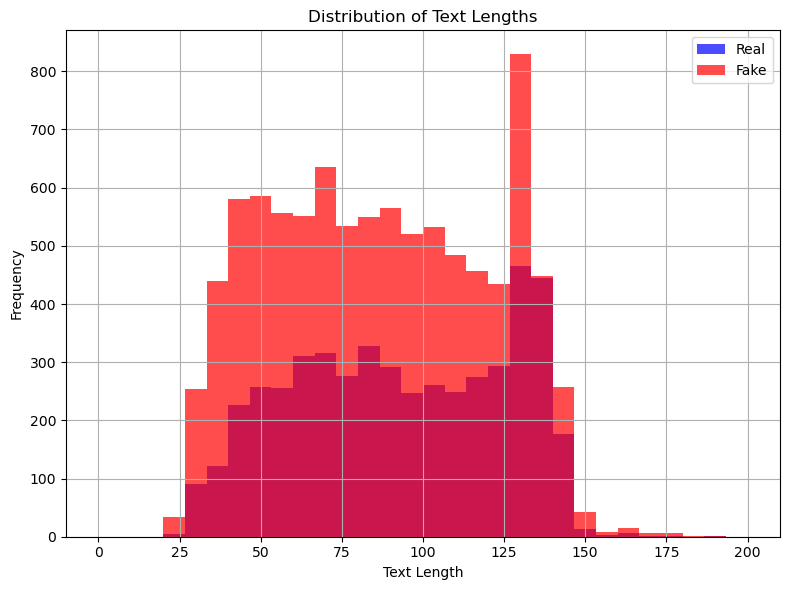

In [34]:
#plotting text lengths for real and fake values in the training data
real_data = training_data[training_data['label'] == 'real']
fake_data = training_data[training_data['label'] == 'fake']

plt.figure(figsize=(8, 6))
plt.hist(real_data['text_length'], bins=30, range=(0, 200), color='blue', alpha=0.7, label='Real')
plt.hist(fake_data['text_length'], bins=30, range=(0, 200), color='red', alpha=0.7, label='Fake')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('text_length_distribution.pdf')
plt.show()


In [12]:
#Create new features for both training and test datasets, count of hashtags, urls and mentions
training_data['num_hashtags'] = training_data['tweetText_translated'].apply(lambda x: len(re.findall(r'#\w+', str(x))))
training_data['num_mentions'] = training_data['tweetText_translated'].apply(lambda x: len(re.findall(r'@\w+', str(x))))
training_data['num_urls'] = training_data['tweetText_translated'].apply(lambda x: len(re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', str(x))))
test_data['num_hashtags'] = test_data['tweetText_translated'].apply(lambda x: len(re.findall(r'#\w+', str(x))))
test_data['num_mentions'] = test_data['tweetText_translated'].apply(lambda x: len(re.findall(r'@\w+', str(x))))
test_data['num_urls'] = test_data['tweetText_translated'].apply(lambda x: len(re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', str(x))))

In [13]:
#set up sentiment analyser
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
#exrtract sentiment features for training data
training_data['sentiment_scores'] = training_data['clean_text'].apply(lambda x: sia.polarity_scores(str(x)))
training_data['compound_score'] = training_data['sentiment_scores'].apply(lambda x: x['compound'])
training_data['positive_score'] = training_data['sentiment_scores'].apply(lambda x: x['pos'])
training_data['negative_score'] = training_data['sentiment_scores'].apply(lambda x: x['neg'])
training_data['neutral_score'] = training_data['sentiment_scores'].apply(lambda x: x['neu'])
training_data['compound_score'] = training_data['sentiment_scores'].apply(lambda x: x['compound'])
#extract sentiment features for test data
test_data['sentiment_scores'] = test_data['clean_text'].apply(lambda x: sia.polarity_scores(str(x)))
test_data['compound_score'] = test_data['sentiment_scores'].apply(lambda x: x['compound'])
test_data['positive_score'] = test_data['sentiment_scores'].apply(lambda x: x['pos'])
test_data['negative_score'] = test_data['sentiment_scores'].apply(lambda x: x['neg'])
test_data['neutral_score'] = test_data['sentiment_scores'].apply(lambda x: x['neu'])
test_data['compound_score'] = test_data['sentiment_scores'].apply(lambda x: x['compound'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\henry\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [14]:
#Create a numerical label feature for correlations for training data
training_data['label_value'] = training_data['label'].map({'fake': 1, 'humor': 1, 'real': 0})
#Create a numerical label feature for correlations for test data
test_data['label_value'] = test_data['label'].map({'fake': 1, 'humor': 1, 'real': 0})


tweetId                                          tweetText  \
0  578854927457349632  kereeen RT @Shyman33: Eclipse from ISS.... htt...   
1  578874632670953472  Absolutely beautiful! RT @Shyman33: Eclipse fr...   
2  578891261353984000  “@Shyman33: Eclipse from ISS.... http://t.co/C...   
3  578846612312748032        Eclipse from ISS.... http://t.co/En87OtvsU6   
4  578975333841551360  @ebonfigli: Éclipse vue de l'ISS... Autre chos...   

       userId   imageId(s)         username                       timestamp  \
0    70824972  eclipse_01            peay_s  Fri Mar 20 09:45:43 +0000 2015   
1   344707006  eclipse_01   JaredUcanChange  Fri Mar 20 11:04:02 +0000 2015   
2   224839607  eclipse_01          tpjp1231  Fri Mar 20 12:10:06 +0000 2015   
3   134543073  eclipse_01          Shyman33  Fri Mar 20 09:12:41 +0000 2015   
4  1150728872   eclipse_01       Epimethee_  Fri Mar 20 17:44:11 +0000 2015   

  label tweetLanguage                               tweetText_translated  \
0  fake            en  kereeen RT @Shyman33: Eclipse from ISS.... htt...   
1  fake            en  Absolutely beautiful! RT @Shyman33: Eclipse fr...   
2  fake            en  “@Shyman33: Eclipse from ISS.... http://t.co/C...   
3  fake            en        Eclipse from ISS.... http://t.co/En87OtvsU6   
4  fake            fr  @ebonfigli: Eclipse seen from the ISS... Somet...   

                                          clean_text  ...  word_count  \
0                 kereeen rt shyman33 eclipse i http  ...           7   
1    absolutely beautiful rt shyman33 eclipse i http  ...           8   
2  shyman33 eclipse i http solar eclipse seen spa...  ...          13   
3                                     eclipse i http  ...           4   
4  ebonfigli eclipse seen i something else http c...  ...          14   

   num_hashtags  num_mentions  num_urls  \
0             0             1         1   
1             0             1         1   
2             0             1         1   
3             0             0         1   
4             0             1         1   

                                    sentiment_scores compound_score  \
0  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...         0.0000   
1  {'neg': 0.0, 'neu': 0.544, 'pos': 0.456, 'comp...         0.6361   
2  {'neg': 0.0, 'neu': 0.479, 'pos': 0.521, 'comp...         0.8225   
3  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...         0.0000   
4  {'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'comp...         0.2732   

   positive_score  negative_score  neutral_score  label_value  
0           0.000             0.0          1.000            1  
1           0.456             0.0          0.544            1  
2           0.521             0.0          0.479            1  
3           0.000             0.0          1.000            1  
4           0.231             0.0          0.769            1  

[5 rows x 21 columns]

In [15]:
#initialise encoder
label_encoder = LabelEncoder()
#Create numerical value for language using encoder for both training and test data
training_data['language_numerical'] = label_encoder.fit_transform(training_data['tweetLanguage'])
test_data['language_numerical'] = label_encoder.fit_transform(test_data['tweetLanguage'])

In [16]:
#Remove the spaces in timestamp feature
training_data['timestamp'] = training_data['timestamp'].str.replace(r'\s+', ' ', regex=True)
# Convert to datetime format
training_data['timestamp'] = pd.to_datetime(training_data['timestamp'], errors='coerce')
# Extract hour
training_data['hour_of_day'] = training_data['timestamp'].dt.hour
# Convert hour to numerical format
training_data['hour_numerical'] = (training_data['hour_of_day'] / 24) * 100
# do the same for the test data
test_data['timestamp'] = test_data['timestamp'].str.replace(r'\s+', ' ', regex=True)
test_data['timestamp'] = pd.to_datetime(test_data['timestamp'], errors='coerce')
test_data['hour_of_day'] = test_data['timestamp'].dt.hour
test_data['hour_numerical'] = (test_data['hour_of_day'] / 24) * 100
#extract the date from timestamp feature for both training and testing data sets
training_data['date'] = training_data['timestamp'].dt.date
test_data['date'] = test_data['timestamp'].dt.date

C:\Users\henry\AppData\Local\Temp\ipykernel_1932\1518652182.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  training_data['timestamp'] = pd.to_datetime(training_data['timestamp'], errors='coerce')
C:\Users\henry\AppData\Local\Temp\ipykernel_1932\1518652182.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test_data['timestamp'] = pd.to_datetime(test_data['timestamp'], errors='coerce')


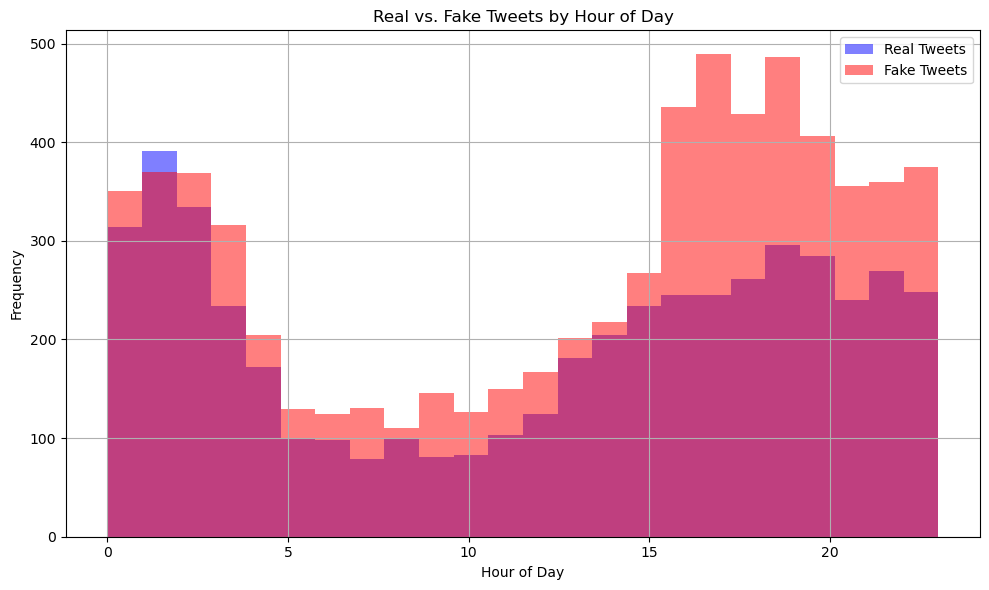

In [22]:
#Obtrain real and fake tweets
real_tweets = training_data[training_data['label'] == 'real']
fake_tweets = training_data[training_data['label'] == 'fake']

#Plot these tweets by the hour of the day
plt.figure(figsize=(10, 6))
plt.hist(real_tweets['hour_of_day'], bins=24, alpha=0.5, label='Real Tweets', color='blue')
plt.hist(fake_tweets['hour_of_day'], bins=24, alpha=0.5, label='Fake Tweets', color='red')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.title('Real vs. Fake Tweets by Hour of Day')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('times.pdf')
plt.show()


C:\Users\henry\AppData\Local\Temp\ipykernel_17800\2265776716.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_tweets['date'] = real_tweets['timestamp'].dt.date
C:\Users\henry\AppData\Local\Temp\ipykernel_17800\2265776716.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_tweets['date'] = fake_tweets['timestamp'].dt.date


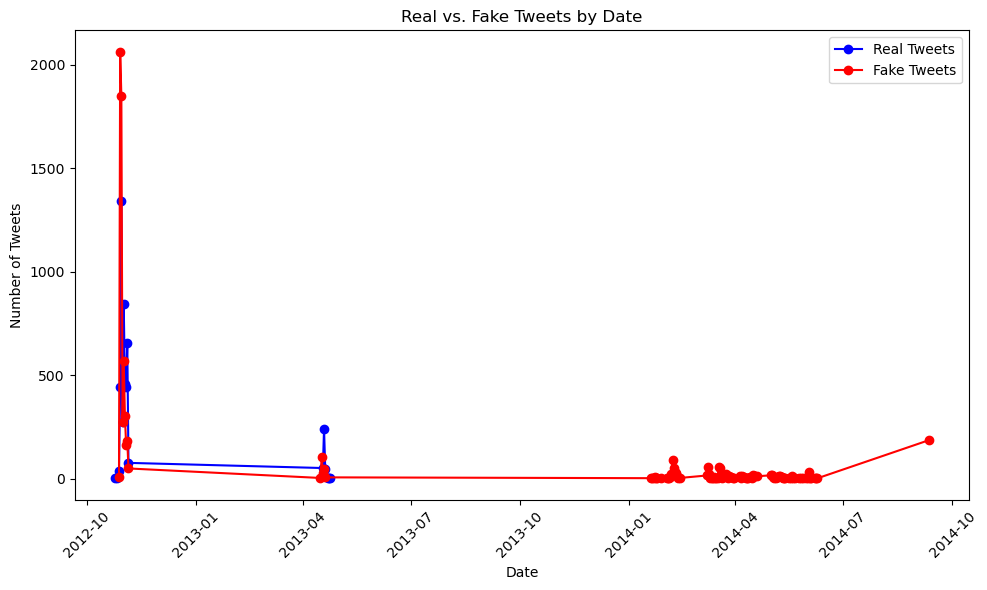

In [23]:
#Extract dates
real_tweets['date'] = real_tweets['timestamp'].dt.date
fake_tweets['date'] = fake_tweets['timestamp'].dt.date
#count tweets by date
real_tweet_counts = real_tweets.groupby('date').size()
fake_tweet_counts = fake_tweets.groupby('date').size()
# plot tweets by date
plt.figure(figsize=(10, 6))
plt.plot(real_tweet_counts.index, real_tweet_counts.values, label='Real Tweets', marker='o', linestyle='-', color='blue')
plt.plot(fake_tweet_counts.index, fake_tweet_counts.values, label='Fake Tweets', marker='o', linestyle='-', color='red')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Real vs. Fake Tweets by Date')
plt.legend()
plt.xticks(rotation=45) 
plt.tight_layout()
plt.savefig('tweets_by_date.pdf')
plt.show()

C:\Users\henry\AppData\Local\Temp\ipykernel_17800\1484599639.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_tweets_test['date'] = real_tweets_test['timestamp'].dt.date
C:\Users\henry\AppData\Local\Temp\ipykernel_17800\1484599639.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_tweets_test['date'] = fake_tweets_test['timestamp'].dt.date


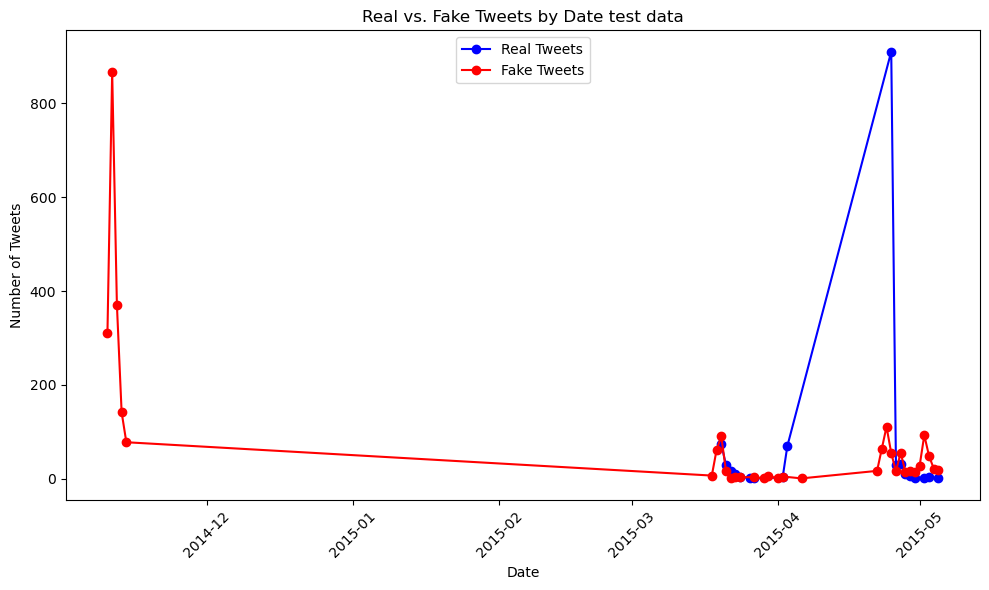

In [33]:
#same as above for test daat
real_tweets_test['date'] = real_tweets_test['timestamp'].dt.date
fake_tweets_test['date'] = fake_tweets_test['timestamp'].dt.date
real_tweet_counts_test = real_tweets_test.groupby('date').size()
fake_tweet_counts_test = fake_tweets_test.groupby('date').size()
plt.figure(figsize=(10, 6))
plt.plot(real_tweet_counts_test.index, real_tweet_counts_test.values, label='Real Tweets', marker='o', linestyle='-', color='blue')
plt.plot(fake_tweet_counts_test.index, fake_tweet_counts_test.values, label='Fake Tweets', marker='o', linestyle='-', color='red')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Real vs. Fake Tweets by Date test data')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('tweets_by_date_test.pdf')
plt.show()

In [17]:
#Function to extract the hashtag text from tweets
def extract_hashtags(text):
    if isinstance(text, str):
        hashtags = re.findall(r'#(\w+)', text)
        return hashtags
    else:
        return []
#applying above function to both datasets
training_data['hashtags'] = training_data['tweetText_translated'].apply(extract_hashtags)
test_data['hashtags'] = test_data['tweetText_translated'].apply(extract_hashtags)

training_data.head()





tweetId                                          tweetText  \
0  263046056240115712  ¿Se acuerdan de la película: “El día después d...   
1  262995061304852481  @milenagimon: Miren a Sandy en NY!  Tremenda i...   
2  262979898002534400  Buena la foto del Huracán Sandy, me recuerda a...   
3  262996108400271360     Scary shit #hurricane #NY http://t.co/e4JLBUfH   
4  263018881839411200  My fave place in the world #nyc #hurricane #sa...   

      userId      imageId(s)        username                 timestamp label  \
0   21226711  sandyA_fake_46         iAnnieM 2012-10-29 22:34:01+00:00  fake   
1  192378571  sandyA_fake_09  CarlosVerareal 2012-10-29 19:11:23+00:00  fake   
2  132303095  sandyA_fake_09     LucasPalape 2012-10-29 18:11:08+00:00  fake   
3  241995902  sandyA_fake_29     Haaaaarryyy 2012-10-29 19:15:33+00:00  fake   
4  250315890  sandyA_fake_15  princess__natt 2012-10-29 20:46:02+00:00  fake   

                                tweetText_translated tweetLanguage  \
0  Do you remember the movie: “The Day After Tomo...            es   
1  @milenagimon: Look at Sandy in NY! Tremendous ...            es   
2  Good photo of Hurricane Sandy, it reminds me o...            es   
3     Scary shit #hurricane #NY http://t.co/e4JLBUfH            en   
4  My fave place in the world #nyc #hurricane #sa...            en   

                                          clean_text  ...  compound_score  \
0  remember movie day tomorrow reminds happening ...  ...          0.0000   
1  milenagimon look sandy ny tremendous image hur...  ...          0.3612   
2  good photo hurricane sandy reminds movie indep...  ...          0.4404   
3                       scary shit hurricane ny http  ...         -0.7783   
4  fave place world nyc hurricane sandy statueofl...  ...          0.4404   

   positive_score  negative_score  neutral_score  label_value  \
0           0.000           0.000          1.000            1   
1           0.161           0.000          0.839            1   
2           0.225           0.000          0.775            1   
3           0.000           0.694          0.306            1   
4           0.293           0.000          0.707            1   

  language_numerical  hour_of_day  hour_numerical        date  \
0                 10         22.0       91.666667  2012-10-29   
1                 10         19.0       79.166667  2012-10-29   
2                 10         18.0       75.000000  2012-10-29   
3                  9         19.0       79.166667  2012-10-29   
4                  9         20.0       83.333333  2012-10-29   

                                   hashtags  
0                                   [Sandy]  
1                                        []  
2                              [ID4, Sandy]  
3                           [hurricane, NY]  
4  [nyc, hurricane, sandy, statueofliberty]  

[5 rows x 26 columns]

In [18]:
#Extract date
training_data['date'] = training_data['timestamp'].dt.date
# Assign a number to represent each date
date_mapping = {date: i for i, date in enumerate(training_data['date'].unique())}
# Map the date to representation for training data
training_data['date_encoded'] = training_data['date'].map(date_mapping)

#Same for test data
test_data['date'] = test_data['timestamp'].dt.date
date_mapping = {date: i for i, date in enumerate(test_data['date'].unique())}
test_data['date_encoded'] = test_data['date'].map(date_mapping)

tweetId                                          tweetText  \
14272  443231991593304064  @BobombDom *slaps TweetDeck with the PigFish h...   
14273  443086239127076865  New Species of Fish found in Brazil or just Re...   
14274  442978105238753280  What do we call this? #pigFISH http: \/\/t.co\...   
14275  442753479782989824  Pigfish ? E dopo il pescecane c'è il pesce mai...   
14276  442700377860104192  For those who can't decide between fish or mea...   

           userId  imageId(s)         username timestamp label  \
14272  2179310905  pigFish_01  Da_Vault_Hunter       NaT  fake   
14273   254843101  pigFish_01   DjSituation_RC       NaT  fake   
14274  2367553228  pigFish_01        Vivo1Vuyo       NaT  fake   
14275   603120231  pigFish_01      CosimoTarta       NaT  fake   
14276    25086784  pigFish_01         johnszim       NaT  fake   

                                    tweetText_translated tweetLanguage  \
14272  @BobombDom *slaps TweetDeck with the PigFish h...            en   
14273  New Species of Fish found in Brazil or just Re...            en   
14274  What do we call this? #pigFISH http: \/\/t.co\...            en   
14275  Pigfish? And after the dogfish there is the pi...            it   
14276  For those who can't decide between fish or mea...            en   

                                              clean_text  ...  positive_score  \
14272              bobombdom slap tweetdeck pigfish http  ...           0.286   
14273  new specie fish found brazil really good photo...  ...           0.262   
14274                                  call pigfish http  ...           0.000   
14275                       pigfish dogfish pigfish http  ...           0.000   
14276                   ca decide fish meat pigfish http  ...           0.000   

       negative_score  neutral_score  label_value  language_numerical  \
14272             0.0          0.714            1                   9   
14273             0.0          0.738            1                   9   
14274             0.0          1.000            1                   9   
14275             0.0          1.000            1                  20   
14276             0.0          1.000            1                   9   

      hour_of_day  hour_numerical  date   hashtags  date_encoded  
14272         NaN             NaN   NaT         []           105  
14273         NaN             NaN   NaT         []           105  
14274         NaN             NaN   NaT  [pigFISH]           105  
14275         NaN             NaN   NaT         []           105  
14276         NaN             NaN   NaT  [Pigfish]           105  

[5 rows x 27 columns]

In [19]:
#download POS tagging libraries
nltk.download('averaged_perceptron_tagger')
# function to extract POS tags
def pos_tagging(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    return pos_tags

# Apply POS function to both datasets
training_data['POS_tags'] = training_data['clean_text'].apply(pos_tagging)
test_data['POS_tags'] = test_data['clean_text'].apply(pos_tagging)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\henry\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [20]:
#Get hashtags as a single string rather than a list
training_data['hashtags_str'] = training_data['hashtags'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')
test_data['hashtags_str'] = test_data['hashtags'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')

In [22]:
training_data.head()

tweetId                                          tweetText  \
0  263046056240115712  ¿Se acuerdan de la película: “El día después d...   
1  262995061304852481  @milenagimon: Miren a Sandy en NY!  Tremenda i...   
2  262979898002534400  Buena la foto del Huracán Sandy, me recuerda a...   
3  262996108400271360     Scary shit #hurricane #NY http://t.co/e4JLBUfH   
4  263018881839411200  My fave place in the world #nyc #hurricane #sa...   

      userId      imageId(s)        username                 timestamp label  \
0   21226711  sandyA_fake_46         iAnnieM 2012-10-29 22:34:01+00:00  fake   
1  192378571  sandyA_fake_09  CarlosVerareal 2012-10-29 19:11:23+00:00  fake   
2  132303095  sandyA_fake_09     LucasPalape 2012-10-29 18:11:08+00:00  fake   
3  241995902  sandyA_fake_29     Haaaaarryyy 2012-10-29 19:15:33+00:00  fake   
4  250315890  sandyA_fake_15  princess__natt 2012-10-29 20:46:02+00:00  fake   

                                tweetText_translated tweetLanguage  \
0  Do you remember the movie: “The Day After Tomo...            es   
1  @milenagimon: Look at Sandy in NY! Tremendous ...            es   
2  Good photo of Hurricane Sandy, it reminds me o...            es   
3     Scary shit #hurricane #NY http://t.co/e4JLBUfH            en   
4  My fave place in the world #nyc #hurricane #sa...            en   

                                          clean_text  ...  neutral_score  \
0  remember movie day tomorrow reminds happening ...  ...          1.000   
1  milenagimon look sandy ny tremendous image hur...  ...          0.839   
2  good photo hurricane sandy reminds movie indep...  ...          0.775   
3                       scary shit hurricane ny http  ...          0.306   
4  fave place world nyc hurricane sandy statueofl...  ...          0.707   

   label_value  language_numerical  hour_of_day  hour_numerical        date  \
0            1                  10         22.0       91.666667  2012-10-29   
1            1                  10         19.0       79.166667  2012-10-29   
2            1                  10         18.0       75.000000  2012-10-29   
3            1                   9         19.0       79.166667  2012-10-29   
4            1                   9         20.0       83.333333  2012-10-29   

   date_encoded                                           POS_tags  \
0             0  [(remember, VB), (movie, NN), (day, NN), (tomo...   
1             0  [(milenagimon, JJ), (look, NN), (sandy, JJ), (...   
2             0  [(good, JJ), (photo, NN), (hurricane, NN), (sa...   
3             0  [(scary, JJ), (shit, VBD), (hurricane, NN), (n...   
4             0  [(fave, JJ), (place, NN), (world, NN), (nyc, N...   

                                   hashtags  \
0                                   [Sandy]   
1                                        []   
2                              [ID4, Sandy]   
3                           [hurricane, NY]   
4  [nyc, hurricane, sandy, statueofliberty]   

                          hashtags_str  
0                                Sandy  
1                                       
2                            ID4 Sandy  
3                         hurricane NY  
4  nyc hurricane sandy statueofliberty  

[5 rows x 29 columns]

In [37]:
# Convert the 'POS_tags' column to lists of strings
training_data['POS_tags'] = training_data['POS_tags'].apply(lambda x: x.split() if isinstance(x, str) else x)
# Initialize MultiLabelBinarizer
mlb_pos = MultiLabelBinarizer()
# encode POS tags for correlations
one_hot_encoded_pos = pd.DataFrame(mlb_pos.fit_transform(training_data['POS_tags']), columns=mlb_pos.classes_, index=training_data.index)

# Vectorize the text of hashtags using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
training_data['hashtags_str'] = training_data['hashtags'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')
hashtags_tfidf = tfidf_vectorizer.fit_transform(training_data['hashtags_str'])
# Calculate the mean TF-IDF value for each tweet's hashtags
mean_tfidf = np.mean(hashtags_tfidf, axis=1)
# Convert the mean TF-IDF values to a DataFrame for correlation
hashtags_mean_tfidf_df = pd.DataFrame(mean_tfidf, columns=['mean_hashtags_tfidf'], index=training_data.index)

# numerical correlation features
correlation_columns = ['label_value', 'num_urls', 'compound_score', 'text_length', 'word_count', 'num_hashtags', 'num_mentions', 'positive_score', 'negative_score', 'neutral_score', 'language_numerical', 'hour_numerical','date_encoded','userId']

# Combining the numerical features with encoded POS tags and hashtags
combined_data = pd.concat([training_data[correlation_columns], one_hot_encoded_pos, hashtags_mean_tfidf_df], axis=1)

# Calculate the correlation matrix
correlation_matrix = combined_data.corr()

# Extract the correlations between 'label_value' and POS tags, then calculate the mean
pos_label_correlations = correlation_matrix['label_value'].loc[mlb_pos.classes_]
average_pos_label_correlation = pos_label_correlations.mean()

# Create a new correlation matrix with selected features and average POS tagging correlation
selected_features = correlation_columns + ['mean_hashtags_tfidf']
final_correlation_matrix = correlation_matrix.loc[selected_features, selected_features]
final_correlation_matrix.loc['average_POS_correlation'] = average_pos_label_correlation
final_correlation_matrix['average_POS_correlation'] = average_pos_label_correlation

print(final_correlation_matrix)


                         label_value  num_urls  compound_score  text_length  \
label_value                 1.000000 -0.008564       -0.039932    -0.037485   
num_urls                   -0.008564  1.000000       -0.041289     0.810028   
compound_score             -0.039932 -0.041289        1.000000     0.005216   
text_length                -0.037485  0.810028        0.005216     1.000000   
word_count                 -0.039577  0.744939        0.019473     0.977291   
num_hashtags               -0.070392  0.234639       -0.018769     0.347142   
num_mentions               -0.138507  0.221172        0.113193     0.374985   
positive_score             -0.010868 -0.013887        0.783609     0.042956   
negative_score              0.036811  0.001091       -0.652695     0.019150   
neutral_score              -0.015976  0.012700       -0.220156    -0.049546   
language_numerical          0.048268 -0.003027       -0.062165    -0.080025   
hour_numerical              0.062398 -0.006678      

In [21]:
#MNB first run
training_data['label'] = training_data['label'].apply(lambda x: 'fake' if x == 'humor' else x)
# Extracting features and labels and store them as variables
num_hashtags = training_data['num_hashtags'].values
num_mentions = training_data['num_mentions'].values
hour_numerical = training_data['hour_numerical'].values
language_numerical = training_data['language_numerical'].values
clean_text = training_data['clean_text'].values
hashtags_str = training_data['hashtags_str'].values  
userId = training_data['userId'].values  
labels = training_data['label'].values  


#Initialize vectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(clean_text)
#Convert to dense array
tfidf_matrix_dense = tfidf_matrix.toarray()


#Combine features into a single feature matrix
combined_features = pd.DataFrame(tfidf_matrix_dense, columns=tfidf_vectorizer.get_feature_names_out())
combined_features['num_hashtags'] = num_hashtags
combined_features['num_mentions'] = num_mentions
combined_features['hour_numerical'] = hour_numerical
combined_features['language_numerical'] = language_numerical
combined_features['userId'] = userId
# Impute missing values
imputer = SimpleImputer(strategy='mean')
combined_features_imputed = imputer.fit_transform(combined_features)


#Split data into train and validation
X_train, X_test, y_train, y_test = train_test_split(combined_features_imputed, labels, test_size=0.2, random_state=42)

#Initialize, fit and predict MultinomialNB
mnbclf = MultinomialNB()
mnbclf.fit(X_train, y_train)
predictions = mnbclf.predict(X_test)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

        fake       0.72      0.47      0.57      1854
        real       0.40      0.66      0.50      1002

    accuracy                           0.54      2856
   macro avg       0.56      0.56      0.53      2856
weighted avg       0.61      0.54      0.54      2856



In [183]:
#WARNING FOR EXAMINER: this takes a very long time to run, all this code does is obtain best set of features 
features = ['num_hashtags', 'num_mentions', 'hour_numerical', 'language_numerical', 'clean_text', 'hashtags_str','userId']
target = 'label'

feature_combinations = []

#Create feature combinations
for L in range(1, len(features) + 1):
    for subset in combinations(features, L):
        feature_combinations.append(list(subset))

#K-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
#combine features
for feature_list in feature_combinations:
    transformers = []
    tfidf_counter = 0  
    for feature in feature_list:
        if feature in ['clean_text', 'hashtags_str']:
            tfidf_name = f'tfidf_{tfidf_counter}'
            transformers.append((tfidf_name, TfidfVectorizer(), feature))
            tfidf_counter += 1
        else:
            transformers.append((feature, SimpleImputer(strategy='mean'), [feature]))

    # Column Transformer
    preprocessor = ColumnTransformer(transformers)

    # Combine preprocessing with the classifier
    mnbclf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', MultinomialNB())
    ])
    #validate and obtain f1 scores
    f1_scores = []
    for train_idx, test_idx in kfold.split(training_data):
        X_train, X_test = training_data.iloc[train_idx][feature_list], training_data.iloc[test_idx][feature_list]
        y_train, y_test = training_data.iloc[train_idx][target], training_data.iloc[test_idx][target]

        # Fit model
        mnbclf.fit(X_train, y_train)

        # Predict on model
        predictions = mnbclf.predict(X_test)

        # Calculate F1 score
        f1 = f1_score(y_test, predictions, average='weighted')
        f1_scores.append(f1)

    avg_f1 = sum(f1_scores) / len(f1_scores)

    # Print feature combination and its average F1 score across folds
    print(f"Features: {feature_list} - Average F1 Score: {avg_f1}")


Features: ['num_hashtags'] - Average F1 Score: 0.5188879412857303
Features: ['num_mentions'] - Average F1 Score: 0.5188879412857303
Features: ['hour_numerical'] - Average F1 Score: 0.5188879412857303
Features: ['language_numerical'] - Average F1 Score: 0.5188879412857303
Features: ['clean_text'] - Average F1 Score: 0.8939600946604914
Features: ['hashtags_str'] - Average F1 Score: 0.6795249715158129
Features: ['userId'] - Average F1 Score: 0.5188879412857303
Features: ['num_hashtags', 'num_mentions'] - Average F1 Score: 0.5307286562690778
Features: ['num_hashtags', 'hour_numerical'] - Average F1 Score: 0.5561960028695279
Features: ['num_hashtags', 'language_numerical'] - Average F1 Score: 0.5391484506555569
Features: ['num_hashtags', 'clean_text'] - Average F1 Score: 0.8894008768641178
Features: ['num_hashtags', 'hashtags_str'] - Average F1 Score: 0.6756678851108789
Features: ['num_hashtags', 'userId'] - Average F1 Score: 0.5909821933137133
Features: ['num_mentions', 'hour_numerical'] -

Features: ['num_mentions', 'hour_numerical', 'clean_text', 'hashtags_str'] - Average F1 Score: 0.8610478834250574
Features: ['num_mentions', 'hour_numerical', 'clean_text', 'userId'] - Average F1 Score: 0.5727648960817427
Features: ['num_mentions', 'hour_numerical', 'hashtags_str', 'userId'] - Average F1 Score: 0.5397941085086979
Features: ['num_mentions', 'language_numerical', 'clean_text', 'hashtags_str'] - Average F1 Score: 0.8820692218226137
Features: ['num_mentions', 'language_numerical', 'clean_text', 'userId'] - Average F1 Score: 0.6718365542784859
Features: ['num_mentions', 'language_numerical', 'hashtags_str', 'userId'] - Average F1 Score: 0.593051537768036
Features: ['num_mentions', 'clean_text', 'hashtags_str', 'userId'] - Average F1 Score: 0.8104967055861934
Features: ['hour_numerical', 'language_numerical', 'clean_text', 'hashtags_str'] - Average F1 Score: 0.8682915297433855
Features: ['hour_numerical', 'language_numerical', 'clean_text', 'userId'] - Average F1 Score: 0.55

In [27]:
best_features = ['clean_text','hashtags_str']

In [56]:
#MNB run2 - with best features (best/final run)
best_features = ['clean_text', 'hashtags_str']
target = 'label'
#combine features
transformers = []
tfidf_counter = 0  
for feature in best_features:
    if feature in ['clean_text', 'hashtags_str']:
        tfidf_name = f'tfidf_{tfidf_counter}'
        transformers.append((tfidf_name, TfidfVectorizer(), feature))
        tfidf_counter += 1
    else:
        transformers.append((feature, SimpleImputer(strategy='mean'), [feature]))

# Column Transformer
preprocessor = ColumnTransformer(transformers)

#Combine preprocessing with the classifier
mnbclf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MultinomialNB())
])

# Training the model
X_train = training_data[best_features]
y_train = training_data[target]
#fit model
mnbclf.fit(X_train, y_train)

# Evaluating the model on the test data
X_test = test_data[best_features]
y_test = test_data[target]

#predict model
predictions = mnbclf.predict(X_test)

#Calculate F1 score
weighted_f1 = f1_score(y_test, predictions, average='weighted')

# Print the weighted F1 score
print(f"Weighted F1 Score on Test Set: {weighted_f1}")


Weighted F1 Score on Test Set: 0.7951333227096036


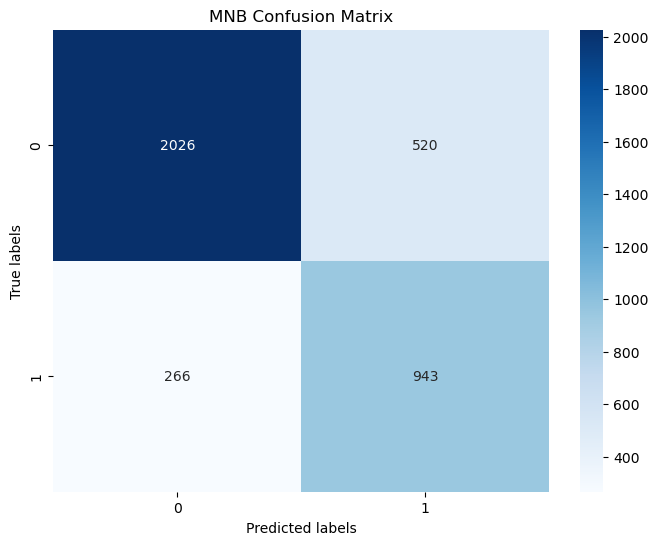

In [50]:
# Get the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('MNB Confusion Matrix')

plt.savefig('confusion_matrix_MNB.pdf', format='pdf')
plt.show()

In [71]:
#Hyperparameter tuning for MNB
#import gridsearch
from sklearn.model_selection import GridSearchCV

#hyperparameters to loop through
param_grid = {
    'classifier__alpha': [0.1, 0.5, 1.0],
    'classifier__fit_prior': [True, False],
    'classifier__class_prior': [None, [0.2, 0.8], [0.5, 0.5]] 
}
#Make grid search
grid_search = GridSearchCV(mnbclf, param_grid, cv=5, scoring='f1_weighted')

#fit grid
grid_search.fit(X_train, y_train)

#best estimator + score
best_estimator = grid_search.best_estimator_
best_score = grid_search.best_score_
best_params = grid_search.best_params_

#predict on test set
best_predictions = best_estimator.predict(X_test)

#Calculate F1 score using the best estimator
best_weighted_f1 = f1_score(y_test, best_predictions, average='weighted')

# Print the results
print(f"Best Parameters: {best_params}")
print(f"Best Cross-validated F1 Score: {best_score}")
print(f"Weighted F1 Score on Test Set (using best estimator): {best_weighted_f1}")


Best Parameters: {'classifier__alpha': 0.5, 'classifier__class_prior': None, 'classifier__fit_prior': True}
Best Cross-validated F1 Score: 0.8290220851749511
Weighted F1 Score on Test Set (using best estimator): 0.6194340920080947


In [ ]:
#Grid search causes overfitting - use previous run

In [23]:
#MLP run1
features = ['num_hashtags', 'num_mentions', 'hour_numerical', 'language_numerical', 'clean_text', 'hashtags_str','userId','date_encoded']
target = 'label'

transformers = []
tfidf_counter = 0  
#combine features
for feature in features:
    if feature in ['clean_text', 'hashtags_str']:
        tfidf_name = f'tfidf_{tfidf_counter}'
        transformers.append((tfidf_name, TfidfVectorizer(), feature))
        tfidf_counter += 1
    else:
        transformers.append((feature, SimpleImputer(strategy='mean'), [feature]))

# Column Transformer
preprocessor = ColumnTransformer(transformers)

#Combine preprocessing with the classifier
mlpclf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(hidden_layer_sizes=(100,), max_iter=500))  # MLPClassifier as the classifier
])

#Split data
X_train, X_test, y_train, y_test = train_test_split(training_data[features], training_data[target], test_size=0.2, random_state=42)

# Fit model
mlpclf.fit(X_train, y_train)
#predict on the validation set
predictions = mlpclf.predict(X_test)

#Calculate F1 score on the validation set
f1 = f1_score(y_test, predictions, average='weighted')
print(f"Final model F1 Score on Test Set: {f1}")


Final model F1 Score on Test Set: 0.5108909989988775


In [194]:
#WARNING FOR EXAMINER: this takes a very long time to run, all this code does is obtain best set of features 
features = ['num_hashtags', 'num_mentions', 'hour_numerical', 'language_numerical', 'clean_text', 'hashtags_str','userId','date_encoded']
target = 'label'

feature_combinations = []

#Create feature combinations
for L in range(1, len(features) + 1):
    for subset in combinations(features, L):
        feature_combinations.append(list(subset))

# K-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
#combine features
for feature_list in feature_combinations:
    transformers = []
    tfidf_counter = 0 
    for feature in feature_list:
        if feature in ['clean_text', 'hashtags_str']:
            tfidf_name = f'tfidf_{tfidf_counter}'
            transformers.append((tfidf_name, TfidfVectorizer(), feature))
            tfidf_counter += 1
        else:
            transformers.append((feature, SimpleImputer(strategy='mean'), [feature]))

    # Column Transformer
    preprocessor = ColumnTransformer(transformers)

    #Combine preprocessing with the classifier
    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', MLPClassifier(hidden_layer_sizes=(100, ), max_iter=500))  # MLPClassifier as the classifier
    ])
    #validate and obtain f1 scores
    f1_scores = []
    for train_idx, test_idx in kfold.split(training_data):
        X_train, X_test = training_data.iloc[train_idx][feature_list], training_data.iloc[test_idx][feature_list]
        y_train, y_test = training_data.iloc[train_idx][target], training_data.iloc[test_idx][target]

        # Fit model
        clf.fit(X_train, y_train)

        # Predict on model using validation set
        predictions = clf.predict(X_test)

        # Calculate F1 score
        f1 = f1_score(y_test, predictions, average='weighted')
        f1_scores.append(f1)

    avg_f1 = sum(f1_scores) / len(f1_scores)
    print(f"Features: {feature_list} - Average F1 Score: {avg_f1}")

Features: ['num_hashtags'] - Average F1 Score: 0.5188879412857303
Features: ['num_mentions'] - Average F1 Score: 0.5308841546795243
Features: ['hour_numerical'] - Average F1 Score: 0.5188879412857303
Features: ['language_numerical'] - Average F1 Score: 0.5188879412857303
Features: ['clean_text'] - Average F1 Score: 0.8916603056981709
Features: ['hashtags_str'] - Average F1 Score: 0.7324632158925443
Features: ['userId'] - Average F1 Score: 0.5188879412857303
Features: ['date_encoded'] - Average F1 Score: 0.72731845759404
Features: ['num_hashtags', 'num_mentions'] - Average F1 Score: 0.6502786186232918
Features: ['num_hashtags', 'hour_numerical'] - Average F1 Score: 0.5399700029744445
Features: ['num_hashtags', 'language_numerical'] - Average F1 Score: 0.5193002641135585
Features: ['num_hashtags', 'clean_text'] - Average F1 Score: 0.8920718592691237
Features: ['num_hashtags', 'hashtags_str'] - Average F1 Score: 0.7490619405695457
Features: ['num_hashtags', 'userId'] - Average F1 Score: 0

Features: ['hashtags_str', 'userId', 'date_encoded'] - Average F1 Score: 0.4513937653825881
Features: ['num_hashtags', 'num_mentions', 'hour_numerical', 'language_numerical'] - Average F1 Score: 0.64215489189963
Features: ['num_hashtags', 'num_mentions', 'hour_numerical', 'clean_text'] - Average F1 Score: 0.8986088584489146
Features: ['num_hashtags', 'num_mentions', 'hour_numerical', 'hashtags_str'] - Average F1 Score: 0.7509668043589812
Features: ['num_hashtags', 'num_mentions', 'hour_numerical', 'userId'] - Average F1 Score: 0.5195956032866192
Features: ['num_hashtags', 'num_mentions', 'hour_numerical', 'date_encoded'] - Average F1 Score: 0.7562513966955838
Features: ['num_hashtags', 'num_mentions', 'language_numerical', 'clean_text'] - Average F1 Score: 0.8958012745175168
Features: ['num_hashtags', 'num_mentions', 'language_numerical', 'hashtags_str'] - Average F1 Score: 0.75117171255314
Features: ['num_hashtags', 'num_mentions', 'language_numerical', 'userId'] - Average F1 Score: 0

Features: ['num_hashtags', 'num_mentions', 'hour_numerical', 'language_numerical', 'hashtags_str'] - Average F1 Score: 0.7576973487213834
Features: ['num_hashtags', 'num_mentions', 'hour_numerical', 'language_numerical', 'userId'] - Average F1 Score: 0.5195956032866192
Features: ['num_hashtags', 'num_mentions', 'hour_numerical', 'language_numerical', 'date_encoded'] - Average F1 Score: 0.7528167181401263
Features: ['num_hashtags', 'num_mentions', 'hour_numerical', 'clean_text', 'hashtags_str'] - Average F1 Score: 0.8959204259392759
Features: ['num_hashtags', 'num_mentions', 'hour_numerical', 'clean_text', 'userId'] - Average F1 Score: 0.3861959012271464
Features: ['num_hashtags', 'num_mentions', 'hour_numerical', 'clean_text', 'date_encoded'] - Average F1 Score: 0.8914371731603348
Features: ['num_hashtags', 'num_mentions', 'hour_numerical', 'hashtags_str', 'userId'] - Average F1 Score: 0.3840398532155627
Features: ['num_hashtags', 'num_mentions', 'hour_numerical', 'hashtags_str', 'date

Features: ['num_hashtags', 'num_mentions', 'hour_numerical', 'clean_text', 'hashtags_str', 'date_encoded'] - Average F1 Score: 0.9012483053029221
Features: ['num_hashtags', 'num_mentions', 'hour_numerical', 'clean_text', 'userId', 'date_encoded'] - Average F1 Score: 0.3103808373895058
Features: ['num_hashtags', 'num_mentions', 'hour_numerical', 'hashtags_str', 'userId', 'date_encoded'] - Average F1 Score: 0.3819816042438811
Features: ['num_hashtags', 'num_mentions', 'language_numerical', 'clean_text', 'hashtags_str', 'userId'] - Average F1 Score: 0.4537378035304271
Features: ['num_hashtags', 'num_mentions', 'language_numerical', 'clean_text', 'hashtags_str', 'date_encoded'] - Average F1 Score: 0.8966468560014578
Features: ['num_hashtags', 'num_mentions', 'language_numerical', 'clean_text', 'userId', 'date_encoded'] - Average F1 Score: 0.45160219072809255
Features: ['num_hashtags', 'num_mentions', 'language_numerical', 'hashtags_str', 'userId', 'date_encoded'] - Average F1 Score: 0.5191

In [30]:
best_features_nn = ['language_numerical', 'clean_text', 'hashtags_str']

In [26]:
#MLP run2
best_features_nn = ['language_numerical', 'clean_text', 'hashtags_str']
target = 'label'

transformers = []
tfidf_counter = 0
#combine features
for feature in best_features_nn:
    if feature in ['clean_text', 'hashtags_str']:
        tfidf_name = f'tfidf_{tfidf_counter}'
        transformers.append((tfidf_name, TfidfVectorizer(), feature))
        tfidf_counter += 1
    else:
        transformers.append((feature, SimpleImputer(strategy='mean'), [feature]))

# Column Transformer
preprocessor = ColumnTransformer(transformers)

# MLPClassifier pipeline
clfnn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(hidden_layer_sizes=(100, ), max_iter=500, random_state=32))
])

# Train model
X_train = training_data[best_features_nn]
y_train = training_data[target]
#fit model
clfnn.fit(X_train, y_train)

#Test data
X_test = test_data[best_features_nn]
y_test = test_data[target]

# Predict on test data
predictions = clfnn.predict(X_test)

# Calculate weighted F1 score
weighted_f1 = f1_score(y_test, predictions, average='weighted')
print(f"Weighted F1 Score on Test Data: {weighted_f1}")


Weighted F1 Score on Test Data: 0.7467761582473844


In [27]:
#MLP run3 - Hyperparameter tuning + final f1 score
#WARNING: takes a while to run
#hyperparameters to tune
param_grid = {
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],
}

#find best parameters
grid_search = GridSearchCV(clfnn, param_grid, cv=5, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

# Get the best model
best_clf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
# Evaluate on test data
predictions = best_clf.predict(X_test)
weighted_f1 = f1_score(y_test, predictions, average='weighted')
print(f"Weighted F1 Score on Test Data: {weighted_f1}")

Best Parameters: {'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (50,)}
Weighted F1 Score on Test Data: 0.8200564347418654


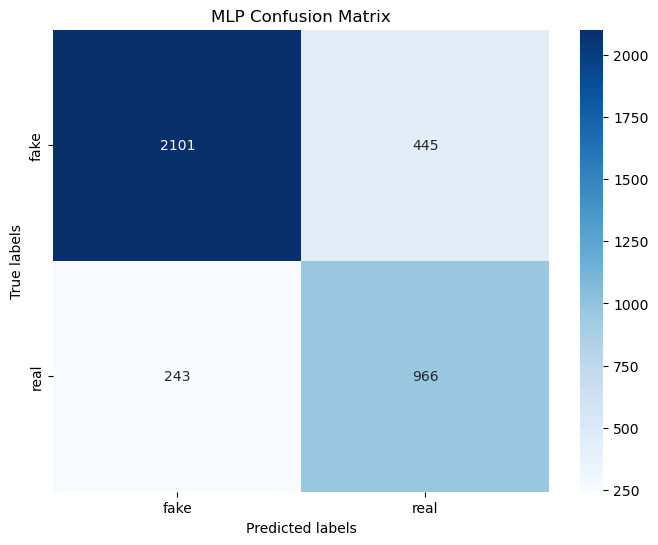

In [36]:
# Get the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=best_clf.classes_, yticklabels=best_clf.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('MLP Confusion Matrix')
plt.savefig('confusion_matrix_MLP.pdf', format='pdf')
plt.show()